### Import libraries

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import catboost as cb

import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Import train and test datasets

In [2]:
DATA_FOLDER = '../Data/'

transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))

### Constants

In [3]:
nmonths = 13 # Number of last months, which data we use

In [4]:
pd.set_option('max_columns', 100)

## EDA

In [5]:
# Shapes of dataframes
print(transactions.shape, items.shape, item_categories.shape, shops.shape, test.shape)

(2935849, 6) (22170, 3) (84, 2) (60, 2) (214200, 3)


### Let's start our observation with smallest dataset: shops

In [6]:
shops.head(15)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


#### We can extract City feature from shop name. Practically all of shop names has city as first word in their names 

In [7]:
shop_name_split = [el.split(' ') for el in shops.shop_name.values]
shops['city'] = pd.Series([el[0] for el in shop_name_split], index=shops.index)
shops.head(15)

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский
5,"Вологда ТРЦ ""Мармелад""",5,Вологда
6,"Воронеж (Плехановская, 13)",6,Воронеж
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж
9,Выездная Торговля,9,Выездная


#### As we can see, we have a big bias to the Moscow city (13 shops). 2nd and 3rd city (Voronezh and Rostov on Don) have only 3 shops

In [7]:
shops.city.value_counts()

Москва              13
Воронеж              3
РостовНаДону         3
Тюмень               3
СПб                  2
!Якутск              2
Н.Новгород           2
Жуковский            2
Новосибирск          2
Якутск               2
Самара               2
Уфа                  2
Красноярск           2
Казань               2
Интернет-магазин     1
Волжский             1
Цифровой             1
Вологда              1
Выездная             1
Чехов                1
Адыгея               1
Мытищи               1
Омск                 1
Курск                1
Химки                1
Ярославль            1
Сергиев              1
Балашиха             1
Калуга               1
Сургут               1
Коломна              1
Томск                1
Name: city, dtype: int64

#### Number of unique cities

In [8]:
shops.city.nunique()

32

#### One hot encoding function

In [9]:
def df_col_to_ohe(df_col):
    """ df_col - pd.Series object, which we want to be one hot encoded """
    # First step: label encoding (text -> int)
    le = LabelEncoder()
    enc_feature = le.fit_transform(df_col)
    enc_feature = enc_feature.reshape(-1, 1) # for using in one hot encoder
    
    # Second step: ohe hot encoding of labeled feature
    ohe = OneHotEncoder(sparse=False)
    return ohe.fit_transform(enc_feature)

#### Not so many categories, use One hot Encoding for the City

In [10]:
ohe_city = df_col_to_ohe(shops.city)

#### Append one hot encoded features to the shop dataset

In [11]:
for col in range(ohe_city.shape[1]):
    shops['ohe_city_' + str(col)] = pd.Series(ohe_city[:, col], index=shops.index)

In [12]:
shops.head(10)

,shop_name,shop_id,city,ohe_city_0,ohe_city_1,ohe_city_2,ohe_city_3,ohe_city_4,ohe_city_5,ohe_city_6,...,ohe_city_22,ohe_city_23,ohe_city_24,ohe_city_25,ohe_city_26,ohe_city_27,ohe_city_28,ohe_city_29,ohe_city_30,ohe_city_31
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,"Воронеж (Плехановская, 13)",6,Воронеж,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Выездная Торговля,9,Выездная,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Explore item_categories dataframe

#### Split categories by type (Accessories, Programs, Gifts, e.t.c.)

In [8]:
item_cat_types = np.array(['PC_Headphone'] + ['Accessory'] * 7 + ['Ticket', 'Delivery'] + ['Game_Console'] * 8 + 
                  ['Game'] * 7 + ['Game_Accessory'] + ['Game'] * 6 + ['Pay_Card'] * 5 + ['Cinema'] * 5 + 
                  ['Book'] * 13 + ['Music'] * 6 + ['Gift'] * 12 + ['Program'] * 6 + ['Service'] * 2 + 
                  ['Clean_Disk'] * 2 + ['Charger'])
item_cat_types.shape

(84,)

#### Add category type to the dataset

In [9]:
item_categories['item_category_type'] = pd.Series(item_cat_types, index=item_categories.index)
item_categories.tail()

,item_category_name,item_category_id,item_category_type
79,Служебные,79,Service
80,Служебные - Билеты,80,Service
81,Чистые носители (шпиль),81,Clean_Disk
82,Чистые носители (штучные),82,Clean_Disk
83,Элементы питания,83,Charger


#### Now we add one hot encoded item_category_type feature to dataframe

In [15]:
# Get ohe matrix from feature
ohe_item_cat_types = df_col_to_ohe(item_categories.item_category_type)

# Add OHE features
for col in range(ohe_item_cat_types.shape[1]):
    item_categories['type_' + str(col)] = pd.Series(ohe_item_cat_types[:, col], index=item_categories.index)
    
item_categories.head(10)

,item_category_name,item_category_id,item_category_type,type_0,type_1,type_2,type_3,type_4,type_5,type_6,type_7,type_8,type_9,type_10,type_11,type_12,type_13,type_14,type_15
0,PC - Гарнитуры/Наушники,0,PC_Headphone,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Аксессуары - PS2,1,Accessory,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Аксессуары - PS3,2,Accessory,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Аксессуары - PS4,3,Accessory,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Аксессуары - PSP,4,Accessory,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Аксессуары - PSVita,5,Accessory,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Аксессуары - XBOX 360,6,Accessory,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Аксессуары - XBOX ONE,7,Accessory,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Билеты (Цифра),8,Ticket,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,Доставка товара,9,Delivery,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
df_col_to_ohe(item_categories.item_category_type).shape

(84, 16)

### What we can do with items dataframe?

In [17]:
items.head(10)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


#### Plot histogram of item_category distribution 

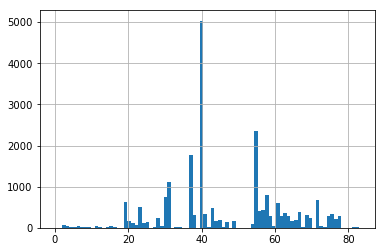

In [18]:
items['item_category_id'].hist(bins=84)

In [19]:
top10_categories = items['item_category_id'].value_counts()[:10]
top10_categories

40    5035
55    2365
37    1780
31    1125
58     790
30     756
72     666
19     628
61     598
23     501
Name: item_category_id, dtype: int64

#### Show top 10 categories from item_categories dataframe

In [20]:
item_categories[item_categories['item_category_id'].isin(top10_categories.index)]

,item_category_name,item_category_id,item_category_type,type_0,type_1,type_2,type_3,type_4,type_5,type_6,type_7,type_8,type_9,type_10,type_11,type_12,type_13,type_14,type_15
19,Игры - PS3,19,Game,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,Игры - XBOX 360,23,Game,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,Игры PC - Стандартные издания,30,Game,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,Игры PC - Цифра,31,Game,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,Кино - Blu-Ray,37,Cinema,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,Кино - DVD,40,Cinema,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55,Музыка - CD локального производства,55,Music,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
58,Музыка - Винил,58,Music,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
61,Подарки - Атрибутика,61,Gift,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
72,Подарки - Фигурки,72,Gift,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### As we can see, it's Games, Cinema, Music and Gifts

### And the main dataframe - transactions

In [21]:
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


#### Group transactions by month, shop and item and sum count of sold items

In [6]:
grp_trans = transactions.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)[['item_cnt_day']].sum()
grp_trans.shape

(1609124, 4)

In [7]:
grp_trans.head(3)

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0


#### Split grouped dataset by months

In [8]:
lst_grp_trans = []
max_month = grp_trans.date_block_num.max() + 1
for month in range(max_month-nmonths, max_month): # Get only last year data
    month_df = grp_trans[grp_trans.date_block_num == month]
    month_df.rename(index=str, columns={"item_cnt_day": "item_cnt_day_" + str(month)}, inplace=True) # Rename target column
    lst_grp_trans.append(month_df)

#### Join this list of dataframes with test dataset in cycle

In [9]:
traintest = test[['shop_id', 'item_id']].set_index(['shop_id', 'item_id'])
for month in range(max_month-nmonths, max_month):
    traintest = traintest.join(lst_grp_trans[month+nmonths-max_month][['shop_id', 'item_id', 'item_cnt_day_'+str(month)]
                                                                     ].set_index(['shop_id', 'item_id']))
    
# Replace NaNs by 0
traintest.fillna(0, inplace=True)
# Extract target for our validation
val_target = traintest.item_cnt_day_33
traintest.drop(['item_cnt_day_33'], axis=1, inplace=True)
traintest.head()

item_cnt_day_21  item_cnt_day_22  item_cnt_day_23  \
shop_id item_id                                                      
5       5037                 0.0              1.0              2.0   
        5320                 0.0              0.0              0.0   
        5233                 0.0              0.0              0.0   
        5232                 0.0              0.0              0.0   
        5268                 0.0              0.0              0.0   

                 item_cnt_day_24  item_cnt_day_25  item_cnt_day_26  \
shop_id item_id                                                      
5       5037                 2.0              0.0              0.0   
        5320                 0.0              0.0              0.0   
        5233                 0.0              0.0              0.0   
        5232                 0.0              0.0              0.0   
        5268                 0.0              0.0              0.0   

                 item_cnt_day_27  item_cnt_day_28  item_cnt_day_29  \
shop_id item_id                                                      
5       5037                 0.0              1.0              1.0   
        5320                 0.0              0.0              0.0   
        5233                 0.0              3.0              2.0   
        5232                 0.0              0.0              0.0   
        5268                 0.0              0.0              0.0   

                 item_cnt_day_30  item_cnt_day_31  item_cnt_day_32  
shop_id item_id                                                     
5       5037                 1.0              3.0              1.0  
        5320                 0.0              0.0              0.0  
        5233                 0.0              1.0              3.0  
        5232                 0.0              1.0              0.0  
        5268                 0.0              0.0              0.0

In [11]:
val_target.head()

shop_id  item_id
5        5037       0.0
         5320       0.0
         5233       1.0
         5232       0.0
         5268       0.0
Name: item_cnt_day_33, dtype: float64

In [12]:
np_traintest = np.array(traintest)
np_traintest.shape

(214200, 12)

In [13]:
for i in range(1, nmonths):
    traintest['mean_' + str(i)] = pd.Series(np_traintest[:, -i:].mean(axis=1), index=traintest.index)

In [14]:
traintest.head(10)

item_cnt_day_21  item_cnt_day_22  item_cnt_day_23  \
shop_id item_id                                                      
5       5037                 0.0              1.0              2.0   
        5320                 0.0              0.0              0.0   
        5233                 0.0              0.0              0.0   
        5232                 0.0              0.0              0.0   
        5268                 0.0              0.0              0.0   
        5039                 0.0              0.0              3.0   
        5041                 0.0              0.0              0.0   
        5046                 0.0              1.0              5.0   
        5319                 0.0              5.0             28.0   
        5003                 0.0              0.0              0.0   

                 item_cnt_day_24  item_cnt_day_25  item_cnt_day_26  \
shop_id item_id                                                      
5       5037                 2.0              0.0              0.0   
        5320                 0.0              0.0              0.0   
        5233                 0.0              0.0              0.0   
        5232                 0.0              0.0              0.0   
        5268                 0.0              0.0              0.0   
        5039                 1.0              0.0              0.0   
        5041                 0.0              0.0              0.0   
        5046                 0.0              0.0              1.0   
        5319                 9.0              2.0              3.0   
        5003                 0.0              0.0              0.0   

                 item_cnt_day_27  item_cnt_day_28  item_cnt_day_29  \
shop_id item_id                                                      
5       5037                 0.0              1.0              1.0   
        5320                 0.0              0.0              0.0   
        5233                 0.0              3.0              2.0   
        5232                 0.0              0.0              0.0   
        5268                 0.0              0.0              0.0   
        5039                 0.0              3.0              0.0   
        5041                 0.0              0.0              0.0   
        5046                 0.0              0.0              1.0   
        5319                 2.0              2.0              4.0   
        5003                 0.0              0.0              0.0   

                 item_cnt_day_30  item_cnt_day_31  item_cnt_day_32  mean_1  \
shop_id item_id                                                              
5       5037                 1.0              3.0              1.0     1.0   
        5320                 0.0              0.0              0.0     0.0   
        5233                 0.0              1.0              3.0     3.0   
        5232                 0.0              1.0              0.0     0.0   
        5268                 0.0              0.0              0.0     0.0   
        5039                 0.0              0.0              1.0     1.0   
        5041                 0.0              0.0              3.0     3.0   
        5046                 0.0              0.0              0.0     0.0   
        5319                 3.0              2.0              3.0     3.0   
        5003                 0.0              0.0              0.0     0.0   

                 mean_2    mean_3  mean_4  mean_5    mean_6    mean_7  mean_8  \
shop_id item_id                                                                 
5       5037        2.0  1.666667    1.50     1.4  1.166667  1.000000   0.875   
        5320        0.0  0.000000    0.00     0.0  0.000000  0.000000   0.000   
        5233        2.0  1.333333    1.50     1.8  1.500000  1.285714   1.125   
        5232        0.5  0.333333    0.25     0.2  0.166667  0.142857   0.125   
        5268        0.0  0.000000    0.00     0.0  0.000000  0.000000  

In [15]:
traintest.shape

(214200, 24)

#### Concatenate the predictions to a tensor of size `(number of trees, number of objects, number of classes)`.

In [16]:
np_train_matrix = np.array(traintest)

#### First simple benchmark: feed everything to RandomForestRegressor

In [53]:
%%time
rf = RandomForestRegressor(n_estimators=250, n_jobs=-1, random_state=26)
rf.fit(np_train_matrix, val_target)

Wall time: 55.2 s


#### Get predictions and clip them

In [54]:
first_preds = rf.predict(np_train_matrix)
first_preds = np.clip(first_preds, 0, 20)

#### Calculate RMSE error

In [21]:
val_target_clip = np.clip(np.array(val_target), 0, 20)
np.sqrt(mean_squared_error(first_preds, val_target_clip))
# 0.76434722557359258

NameError: name 'first_preds' is not defined

In [60]:
rf.feature_importances_

array([ 0.00632154,  0.00289569,  0.03817474,  0.15536718,  0.00169612,
        0.01630579,  0.00181566,  0.51032782,  0.0150122 ,  0.00739723,
        0.01100007,  0.01349739,  0.00548578,  0.02940128,  0.03800777,
        0.0355068 ,  0.01588134,  0.00326703,  0.01648046,  0.00363063,
        0.01881736,  0.0169479 ,  0.01295585,  0.02380636])

### Good. Now we need to prepare test data to calculate predictions

In [17]:
filter_col = [col for col in traintest if col.startswith('item_cnt_day')]
test_extended = traintest[filter_col]
test_extended['item_cnt_day_33'] = val_target
test_extended.drop(['item_cnt_day_21'], axis=1, inplace=True)
test_extended.head()

item_cnt_day_22  item_cnt_day_23  item_cnt_day_24  \
shop_id item_id                                                      
5       5037                 1.0              2.0              2.0   
        5320                 0.0              0.0              0.0   
        5233                 0.0              0.0              0.0   
        5232                 0.0              0.0              0.0   
        5268                 0.0              0.0              0.0   

                 item_cnt_day_25  item_cnt_day_26  item_cnt_day_27  \
shop_id item_id                                                      
5       5037                 0.0              0.0              0.0   
        5320                 0.0              0.0              0.0   
        5233                 0.0              0.0              0.0   
        5232                 0.0              0.0              0.0   
        5268                 0.0              0.0              0.0   

                 item_cnt_day_28  item_cnt_day_29  item_cnt_day_30  \
shop_id item_id                                                      
5       5037                 1.0              1.0              1.0   
        5320                 0.0              0.0              0.0   
        5233                 3.0              2.0              0.0   
        5232                 0.0              0.0              0.0   
        5268                 0.0              0.0              0.0   

                 item_cnt_day_31  item_cnt_day_32  item_cnt_day_33  
shop_id item_id                                                     
5       5037                 3.0              1.0              0.0  
        5320                 0.0              0.0              0.0  
        5233                 1.0              3.0              1.0  
        5232                 1.0              0.0              0.0  
        5268                 0.0              0.0              0.0

In [18]:
# Get numpy version
np_test_ext = np.array(traintest)
np_test_ext.shape

# Add means
for i in range(1, nmonths):
    test_extended['mean_' + str(i)] = pd.Series(np_test_ext[:, -i:].mean(axis=1), index=test_extended.index)
    
# Convert all df in np array
np_test_matrix = np.array(test_extended)

In [47]:
test_extended.shape

(214200, 24)

#### Get preditions and clip them

In [72]:
test_preds = rf.predict(np_test_matrix)
test_preds = np.clip(test_preds, 0, 20)
test_preds[:10]

array([ 0.428     ,  0.125145  ,  0.6       ,  0.11583789,  0.125145  ,
        0.906     ,  0.30764473,  0.38334794,  3.508     ,  0.125145  ])

In [74]:
first_preds[:10]

array([ 0.304     ,  0.125145  ,  0.9096    ,  0.2062002 ,  0.125145  ,
        0.84657143,  1.47846576,  0.102     ,  0.448     ,  0.125145  ])

#### Convert it to the Kaggle submission dataframe

In [73]:
df_test_pred = test.join(pd.Series(test_preds, index=test.index, name='item_cnt_month'))[['ID', 'item_cnt_month']]
df_test_pred.to_csv('../Data/Submissions/3_3_rf_250_trees_baseline_correct.csv', index=None)

### Your submission scored 1.08260, which is an improvement of your previous score of 1.08401. Great job!

### Simple heuristics: if predictions are confident enough ({x} > 0.8 or {x} < 0.2), then round the prediction

In [212]:
np.modf(3.5)

(0.5, 3.0)

In [57]:
# Get array of fractional parts
test_pred_frac_part = np.modf(test_preds)[0]

# Get rounded predictions
test_pred_round = []
for pred, frac in zip(test_preds, test_pred_frac_part):
    if frac < 0.2:
        test_pred_round.append(pred-frac)
    elif frac > 0.8:
        test_pred_round.append(pred-frac+1)
    else:
        test_pred_round.append(pred)

In [58]:
len([el for el in zip(test_preds, test_pred_round) if el[0] != el[1]])

180008

In [59]:
df_test_pred_r = test.join(pd.Series(test_pred_round, index=test.index, name='item_cnt_month'))[['ID', 'item_cnt_month']]
df_test_pred_r.to_csv('../Data/Submissions/3_2_rf_250_trees_baseline_rounded.csv', index=None)

## Do the same prediction with XGBoost

In [19]:
%%time
xgbr = xgb.XGBRegressor(n_estimators=250, max_depth=4, n_jobs=-1, random_state=26)
xgbr.fit(np_train_matrix, val_target)

Wall time: 14 s


In [22]:
first_xgb_preds = xgbr.predict(np_train_matrix)
first_xgb_preds = np.clip(first_xgb_preds, 0, 20)
np.sqrt(mean_squared_error(first_xgb_preds, val_target_clip))
# 1000 - 0.81225612713103956
# 500 - 0.82961473055039203
# 250 - 0.84801719288101907

0.84801719288101907

In [23]:
xgbr.feature_importances_

array([ 0.05574261,  0.0291807 ,  0.04863449,  0.04040404,  0.03142536,
        0.06247662,  0.04638983,  0.08641975,  0.03142536,  0.04489338,
        0.0587355 ,  0.14291058,  0.        ,  0.06659184,  0.05087916,
        0.03778526,  0.03030303,  0.02656192,  0.01758324,  0.01346801,
        0.02543958,  0.01084923,  0.01047512,  0.03142536], dtype=float32)

In [24]:
test_xgb_preds = xgbr.predict(np_test_matrix)
test_xgb_preds = np.clip(test_xgb_preds, 0, 20)
test_xgb_preds[:10]

array([ 0.59153587,  0.1248734 ,  0.58168894,  0.14050049,  0.1248734 ,
        0.41748619,  0.41783255,  0.27361202,  3.09929419,  0.1248734 ], dtype=float32)

In [90]:
df_test_pred = test.join(pd.Series(test_xgb_preds, index=test.index, name='item_cnt_month'))[['ID', 'item_cnt_month']]
df_test_pred.to_csv('../Data/Submissions/3_4_xgb_250_trees_baseline.csv', index=None)

### Great! XGB on 250 trees has 1.06649 score! Much better, than previous: 1.08260

#### Construct train and test matrix by function for convenience

In [10]:
def construct_base_traintest(months=nmonths):
    """
    months - number of last months to construct base train/test matrix dataset
    This function construct grouped by months sales information
    """
    # Group transactions by month, shop and item
    grp_trans = transactions.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)[['item_cnt_day']].sum()
    
    # Split dataset by months
    lst_grp_trans = []
    max_month = grp_trans.date_block_num.max() + 1
    for month in range(max_month-months, max_month): # Get only last year data
        month_df = grp_trans[grp_trans.date_block_num == month]
        # Rename target column
        month_df.rename(index=str, columns={"item_cnt_day": "item_cnt_day_" + str(month)}, inplace=True) 
        lst_grp_trans.append(month_df)
        
    # Join data with test dataset
    traintest = test[['shop_id', 'item_id']].set_index(['shop_id', 'item_id'])
    for month in range(max_month-months, max_month):
        traintest = traintest.join(lst_grp_trans[month+months-max_month][['shop_id', 'item_id', 'item_cnt_day_'+str(month)]
                                                                        ].set_index(['shop_id', 'item_id']))

    # Replace NaNs by 0
    traintest.fillna(0, inplace=True)
    # Extract target for our validation
    val_target = traintest.item_cnt_day_33
    traintest.drop(['item_cnt_day_33'], axis=1, inplace=True)
    
    # Now prepare test matrix
    filter_col = [col for col in traintest if col.startswith('item_cnt_day')]
    test_extended = traintest[filter_col]
    test_extended['item_cnt_day_33'] = val_target
    test_extended.drop(['item_cnt_day_' + str(33-months+1)], axis=1, inplace=True)
    
    return traintest, test_extended

In [11]:
%%time
traintest, test_extended = construct_base_traintest()

Wall time: 5.57 s


In [12]:
print(traintest.shape, test_extended.shape)

(214200, 12) (214200, 12)


#### Also for convenience construct add_means function

In [13]:
def add_means(train, test, months=nmonths):
    """
    train - base train dataframe
    test - base test dataframe
    This function add sliding means by last n column values (last n months)
    """
    # Add features to train
    np_train = np.array(train)
    
    for i in range(1, months):
        train['mean_' + str(i)] = pd.Series(np_train[:, -i:].mean(axis=1), index=train.index)
        
    # Add features to test
    np_test = np.array(test)
    
    for i in range(1, months):
        test['mean_' + str(i)] = pd.Series(np_test[:, -i:].mean(axis=1), index=test.index)
        
    return train, test

In [14]:
%%time
traintest, test_extended = add_means(traintest, test_extended)

Wall time: 121 ms


In [15]:
print(traintest.shape, test_extended.shape)

(214200, 24) (214200, 24)


### Data leakage: shop_id and item_id in test dataframe

#### We can use shop_id and item_id as a new features to improve our score

In [16]:
# Transform indexes into df columns
traintest.reset_index(inplace=True)  
test_extended.reset_index(inplace=True)

# Create new numpy matrices
np_train_matrix = np.array(traintest)
np_test_matrix = np.array(test_extended)

In [17]:
print(np_train_matrix.shape, np_test_matrix.shape)

(214200, 26) (214200, 26)


#### Now it's time to get validation scores

In [52]:
# Fit XGBRegressor
xgbr_leak = xgb.XGBRegressor(n_estimators=250, max_depth=4, n_jobs=-1, random_state=26)
xgbr_leak.fit(np_train_matrix, val_target)

# Get validation score
xgb_preds_leak = xgbr_leak.predict(np_train_matrix)
xgb_preds_leak = np.clip(xgb_preds_leak, 0, 20)
np.sqrt(mean_squared_error(xgb_preds_leak, val_target_clip))

0.7009781000411005

#### Much better, than previous score - 0.84801719288101907. But we have a risk of overfitting. Trying to predict future sales

In [53]:
test_xgb_preds_leak = xgbr_leak.predict(np_test_matrix)
test_xgb_preds_leak = np.clip(test_xgb_preds_leak, 0, 20)
test_xgb_preds_leak[:10]

array([ 0.50242674,  0.08532378,  0.81220287,  0.11022645,  0.08532378,
        0.38899371,  0.86076355,  0.10238555,  1.15239787,  0.08532378], dtype=float32)

In [55]:
df_test_pred_leak = test.join(pd.Series(test_xgb_preds_leak, index=test.index, 
                                        name='item_cnt_month'))[['ID', 'item_cnt_month']]
df_test_pred_leak.to_csv('../Data/Submissions/3_5_xgb_250_trees_with_leak.csv', index=None)

### We get a slightly better score: 1.06318. Previous top score was 1.06649
### Public score = 1.063188 and Private score = 1.059269

### It's time to add mean encoding

#### Now we can to calculate total months sales of current shop and current item and add this info to dataframe

In [18]:
def get_month_totals(train, test):
    """
    train - train matrix dataframe
    test - test matrix dataframe
    Function calculate cumsum divided by cumcount for current shop and current item saled quantities
    We aggregate info by months
    """
    # Get dataframes with sold item quantities, grouped by shop and item
    train_filter_col = [col for col in train if col.startswith('item_cnt_day')]
    train_item_agg_df = train.groupby(['item_id'])[train_filter_col].agg(['sum'])
    
    test_filter_col = [col for col in test if col.startswith('item_cnt_day')]
    test_item_agg_df = test.groupby(['item_id'])[test_filter_col].agg(['sum'])
    
    # Now we want to get cumulative sum of this features on rows
    train_item_agg_df = train_item_agg_df.cumsum(axis=1)
    test_item_agg_df = test_item_agg_df.cumsum(axis=1)
    
    # Divide cumulative sum by column number (np.cumcount emulation)
    np_to_divide = np.array(train_item_agg_df.columns.labels[0] + 1, dtype=float)
    train_item_agg_df = train_item_agg_df / np_to_divide
    test_item_agg_df = test_item_agg_df / np_to_divide
    
    # Move index to columns of daraframe
    train_item_agg_df.reset_index(inplace=True)
    test_item_agg_df.reset_index(inplace=True)
    
    # Join all mean encoding features with initial data
    train_ext = pd.merge(train, train_item_agg_df, how='left', left_on='item_id', right_on='item_id')
    test_ext = pd.merge(test, test_item_agg_df, how='left', left_on='item_id', right_on='item_id')

    return train_ext, test_ext

In [20]:
def get_month_totals_with_shops(train, test):
    """
    train - train matrix dataframe
    test - test matrix dataframe
    Function calculate cumsum divided by cumcount for current shop and current item saled quantities
    We aggregate info by months
    """
    # Get dataframes with sold item quantities, grouped by shop and item
    train_filter_col = [col for col in train if col.startswith('item_cnt_day')]
    train_shop_agg_df = train.groupby(['shop_id'])[train_filter_col].agg(['sum'])
    train_item_agg_df = train.groupby(['item_id'])[train_filter_col].agg(['sum'])
    
    test_filter_col = [col for col in test if col.startswith('item_cnt_day')]
    test_shop_agg_df = test.groupby(['shop_id'])[test_filter_col].agg(['sum'])
    test_item_agg_df = test.groupby(['item_id'])[test_filter_col].agg(['sum'])
    
    # Now we want to get cumulative sum of this features on rows
    train_shop_agg_df = train_shop_agg_df.cumsum(axis=1)
    train_item_agg_df = train_item_agg_df.cumsum(axis=1)
    test_shop_agg_df = test_shop_agg_df.cumsum(axis=1)
    test_item_agg_df = test_item_agg_df.cumsum(axis=1)
    
    # Divide cumulative sum by column number (np.cumcount emulation)
    np_to_divide = np.array(train_item_agg_df.columns.labels[0] + 1, dtype=float)
    train_shop_agg_df = train_shop_agg_df / np_to_divide
    train_item_agg_df = train_item_agg_df / np_to_divide
    test_shop_agg_df = test_shop_agg_df / np_to_divide
    test_item_agg_df = test_item_agg_df / np_to_divide
    
    # Move index to columns of daraframe
    train_shop_agg_df.reset_index(inplace=True)
    train_item_agg_df.reset_index(inplace=True)
    test_shop_agg_df.reset_index(inplace=True)
    test_item_agg_df.reset_index(inplace=True)
    
    # Join all mean encoding features with initial data
    train_ext = pd.merge(train, train_item_agg_df, how='left', left_on='item_id', right_on='item_id')
    train_ext = pd.merge(train_ext, train_shop_agg_df, how='left', left_on='shop_id', right_on='shop_id')
    test_ext = pd.merge(test, test_item_agg_df, how='left', left_on='item_id', right_on='item_id')
    test_ext = pd.merge(test_ext, test_shop_agg_df, how='left', left_on='shop_id', right_on='shop_id')

    return train_ext, test_ext

In [118]:
traintest, test_extended = get_month_totals(traintest, test_extended)
print(traintest.shape, test_extended.shape)

(214200, 38) (214200, 38)


In [119]:
traintest.head()

,shop_id,item_id,item_cnt_day_21,item_cnt_day_22,item_cnt_day_23,item_cnt_day_24,item_cnt_day_25,item_cnt_day_26,item_cnt_day_27,item_cnt_day_28,item_cnt_day_29,item_cnt_day_30,item_cnt_day_31,item_cnt_day_32,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6,mean_7,mean_8,mean_9,mean_10,mean_11,mean_12,"(item_cnt_day_21, sum)","(item_cnt_day_22, sum)","(item_cnt_day_23, sum)","(item_cnt_day_24, sum)","(item_cnt_day_25, sum)","(item_cnt_day_26, sum)","(item_cnt_day_27, sum)","(item_cnt_day_28, sum)","(item_cnt_day_29, sum)","(item_cnt_day_30, sum)","(item_cnt_day_31, sum)","(item_cnt_day_32, sum)"
0,5,5037,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,2.0,1.666667,1.50,1.4,1.166667,1.000000,0.875,1.000000,1.1,1.090909,1.000000,51.0,52.0,101.333333,96.75,83.8,74.5,67.428571,69.250,72.111111,70.2,74.454545,77.416667
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,3.0,2.0,1.333333,1.50,1.8,1.500000,1.285714,1.125,1.000000,0.9,0.818182,0.750000,0.0,0.0,0.000000,0.00,0.0,0.0,1.142857,9.375,20.333333,21.7,33.272727,37.166667
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.5,0.333333,0.25,0.2,0.166667,0.142857,0.125,0.111111,0.1,0.090909,0.083333,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000,0.000000,0.0,5.818182,9.333333
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000


#### It's time to validate

In [120]:
%%time
# df -> np
np_train_matrix = np.array(traintest)
np_test_matrix = np.array(test_extended)

# Fit regressor
xgbr_mean = xgb.XGBRegressor(n_estimators=250, max_depth=4, n_jobs=-1, random_state=26)
xgbr_mean.fit(np_train_matrix, val_target)

Wall time: 24.3 s


In [121]:
xgb_preds_mean = xgbr_mean.predict(np_train_matrix)
xgb_preds_mean = np.clip(xgb_preds_mean, 0, 20)
np.sqrt(mean_squared_error(xgb_preds_mean, val_target_clip))
# shop + item -> 0.6772903547543887
# item -> 0.68655616584986823

0.68655616584986823

#### Better. Now we can try to predict something

In [122]:
test_xgb_preds_mean = xgbr_mean.predict(np_test_matrix)
test_xgb_preds_mean = np.clip(test_xgb_preds_mean, 0, 20)
test_xgb_preds_mean[:10]

array([ 0.49832878,  0.15172735,  0.77672362,  0.35016954,  0.15172735,
        0.45020264,  1.16721189,  0.18421584,  1.09900188,  0.04826805], dtype=float32)

In [123]:
df_test_pred_mean = test.join(pd.Series(test_xgb_preds_mean, index=test.index, 
                                        name='item_cnt_month'))[['ID', 'item_cnt_month']]
df_test_pred_mean.to_csv('../Data/Submissions/3_7_xgb_250_trees_item_mean_encoding.csv', index=None)

#### 1.06614, which is not the best score (1.063188)

In [128]:
df_test_pred_mean.shape

(214200, 2)

In [111]:
num_of_trees = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

for n_of_tr in num_of_trees:
    xgbr_mean = xgb.XGBRegressor(n_estimators=n_of_tr, max_depth=4, n_jobs=-1, random_state=26)
    xgbr_mean.fit(np_train_matrix, val_target)
    xgb_preds_mean = xgbr_mean.predict(np_train_matrix)
    xgb_preds_mean = np.clip(xgb_preds_mean, 0, 20)
    rmse_score = np.sqrt(mean_squared_error(xgb_preds_mean, val_target_clip))
    print("Num of trees = " + str(n_of_tr) + " RMSE = " + str(rmse_score) + " Time = " + str(datetime.datetime.now()))

Num of trees = 50 RMSE = 0.87274906718 Time = 2018-09-02 13:43:56.303803
Num of trees = 100 RMSE = 0.793321228922 Time = 2018-09-02 13:44:08.374479
Num of trees = 150 RMSE = 0.725214790817 Time = 2018-09-02 13:44:25.468027
Num of trees = 200 RMSE = 0.695704658 Time = 2018-09-02 13:44:47.963779
Num of trees = 250 RMSE = 0.677290354754 Time = 2018-09-02 13:45:25.440874
Num of trees = 300 RMSE = 0.66276464572 Time = 2018-09-02 13:46:14.301037
Num of trees = 350 RMSE = 0.649229760132 Time = 2018-09-02 13:47:12.049822
Num of trees = 400 RMSE = 0.639583371322 Time = 2018-09-02 13:48:31.368913
Num of trees = 450 RMSE = 0.629601189426 Time = 2018-09-02 13:50:05.130762
Num of trees = 500 RMSE = 0.621343549794 Time = 2018-09-02 13:51:47.871826


### What if we try CatBoost?

In [133]:
%%time
cbr = cb.CatBoostRegressor(iterations=250, depth=4, random_seed=26)
cbr.fit(np_train_matrix, val_target)

0:	learn: 5.5055323	total: 59.9ms	remaining: 14.9s
1:	learn: 5.4606197	total: 120ms	remaining: 14.8s
2:	learn: 5.4218317	total: 196ms	remaining: 16.1s
3:	learn: 5.3828969	total: 255ms	remaining: 15.7s
4:	learn: 5.3413699	total: 310ms	remaining: 15.2s
5:	learn: 5.3052490	total: 366ms	remaining: 14.9s
6:	learn: 5.2669596	total: 423ms	remaining: 14.7s
7:	learn: 5.2242494	total: 476ms	remaining: 14.4s
8:	learn: 5.1868559	total: 529ms	remaining: 14.2s
9:	learn: 5.1492431	total: 587ms	remaining: 14.1s
10:	learn: 5.1062452	total: 643ms	remaining: 14s
11:	learn: 5.0698118	total: 699ms	remaining: 13.9s
12:	learn: 5.0292674	total: 755ms	remaining: 13.8s
13:	learn: 4.9938205	total: 811ms	remaining: 13.7s
14:	learn: 4.9618230	total: 868ms	remaining: 13.6s
15:	learn: 4.9242290	total: 927ms	remaining: 13.6s
16:	learn: 4.8857741	total: 981ms	remaining: 13.4s
17:	learn: 4.8513070	total: 1.04s	remaining: 13.4s
18:	learn: 4.8155708	total: 1.09s	remaining: 13.3s
19:	learn: 4.7795365	total: 1.15s	remainin

164:	learn: 2.0060229	total: 9.5s	remaining: 4.89s
165:	learn: 1.9978615	total: 9.57s	remaining: 4.84s
166:	learn: 1.9898349	total: 9.63s	remaining: 4.79s
167:	learn: 1.9821298	total: 9.68s	remaining: 4.73s
168:	learn: 1.9744198	total: 9.74s	remaining: 4.67s
169:	learn: 1.9666965	total: 9.79s	remaining: 4.61s
170:	learn: 1.9590613	total: 9.85s	remaining: 4.55s
171:	learn: 1.9503985	total: 9.91s	remaining: 4.49s
172:	learn: 1.9430976	total: 9.97s	remaining: 4.44s
173:	learn: 1.9342527	total: 10s	remaining: 4.38s
174:	learn: 1.9269399	total: 10.1s	remaining: 4.32s
175:	learn: 1.9200492	total: 10.1s	remaining: 4.27s
176:	learn: 1.9102794	total: 10.2s	remaining: 4.21s
177:	learn: 1.9031726	total: 10.3s	remaining: 4.15s
178:	learn: 1.8957121	total: 10.3s	remaining: 4.09s
179:	learn: 1.8888849	total: 10.4s	remaining: 4.03s
180:	learn: 1.8806662	total: 10.4s	remaining: 3.98s
181:	learn: 1.8739847	total: 10.5s	remaining: 3.92s
182:	learn: 1.8672682	total: 10.5s	remaining: 3.86s
183:	learn: 1.8

In [134]:
cb_preds = cbr.predict(np_train_matrix)
cb_preds = np.clip(cb_preds, 0, 20)
np.sqrt(mean_squared_error(cb_preds, val_target_clip))

0.91781298583093396

In [135]:
test_cb_preds = cbr.predict(np_test_matrix)
test_cb_preds = np.clip(test_cb_preds, 0, 20)
test_cb_preds[:10]

array([ 0.35026615,  0.21169891,  0.49742242,  0.21169891,  0.21169891,
        0.21169891,  0.59406737,  0.21169891,  0.53806988,  0.21169891])

In [136]:
df_test_pred_cb = test.join(pd.Series(test_cb_preds, index=test.index, 
                                      name='item_cnt_month'))[['ID', 'item_cnt_month']]
df_test_pred_cb.to_csv('../Data/Submissions/3_8_catboost_250_trees_item_mean_encoding.csv', index=None)

### CatBoost get better score, than XGBoost: 1.05793 instead of 1.063188

### What if we use 500 iterations instead of 250?

In [137]:
%%time
cbr_2 = cb.CatBoostRegressor(iterations=500, depth=4, random_seed=26)
cbr_2.fit(np_train_matrix, val_target)

0:	learn: 5.5055323	total: 53.1ms	remaining: 26.5s
1:	learn: 5.4606197	total: 104ms	remaining: 25.9s
2:	learn: 5.4218317	total: 155ms	remaining: 25.7s
3:	learn: 5.3828969	total: 208ms	remaining: 25.8s
4:	learn: 5.3413699	total: 263ms	remaining: 26s
5:	learn: 5.3052490	total: 319ms	remaining: 26.2s
6:	learn: 5.2669596	total: 372ms	remaining: 26.2s
7:	learn: 5.2242494	total: 431ms	remaining: 26.5s
8:	learn: 5.1868559	total: 490ms	remaining: 26.7s
9:	learn: 5.1492431	total: 544ms	remaining: 26.7s
10:	learn: 5.1062452	total: 599ms	remaining: 26.6s
11:	learn: 5.0698118	total: 658ms	remaining: 26.8s
12:	learn: 5.0292674	total: 714ms	remaining: 26.8s
13:	learn: 4.9938205	total: 771ms	remaining: 26.8s
14:	learn: 4.9618230	total: 828ms	remaining: 26.8s
15:	learn: 4.9242290	total: 884ms	remaining: 26.8s
16:	learn: 4.8857741	total: 936ms	remaining: 26.6s
17:	learn: 4.8513070	total: 989ms	remaining: 26.5s
18:	learn: 4.8155708	total: 1.05s	remaining: 26.5s
19:	learn: 4.7795365	total: 1.1s	remaining

164:	learn: 2.0060229	total: 9.28s	remaining: 18.8s
165:	learn: 1.9978615	total: 9.34s	remaining: 18.8s
166:	learn: 1.9898349	total: 9.4s	remaining: 18.7s
167:	learn: 1.9821298	total: 9.46s	remaining: 18.7s
168:	learn: 1.9744198	total: 9.52s	remaining: 18.6s
169:	learn: 1.9666965	total: 9.57s	remaining: 18.6s
170:	learn: 1.9590613	total: 9.63s	remaining: 18.5s
171:	learn: 1.9503985	total: 9.68s	remaining: 18.5s
172:	learn: 1.9430976	total: 9.73s	remaining: 18.4s
173:	learn: 1.9342527	total: 9.79s	remaining: 18.3s
174:	learn: 1.9269399	total: 9.84s	remaining: 18.3s
175:	learn: 1.9200492	total: 9.89s	remaining: 18.2s
176:	learn: 1.9102794	total: 9.94s	remaining: 18.1s
177:	learn: 1.9031726	total: 10s	remaining: 18.1s
178:	learn: 1.8957121	total: 10s	remaining: 18s
179:	learn: 1.8888849	total: 10.1s	remaining: 17.9s
180:	learn: 1.8806662	total: 10.2s	remaining: 17.9s
181:	learn: 1.8739847	total: 10.2s	remaining: 17.8s
182:	learn: 1.8672682	total: 10.3s	remaining: 17.8s
183:	learn: 1.85813

326:	learn: 1.3578620	total: 18.2s	remaining: 9.63s
327:	learn: 1.3567970	total: 18.3s	remaining: 9.58s
328:	learn: 1.3557325	total: 18.3s	remaining: 9.52s
329:	learn: 1.3543634	total: 18.4s	remaining: 9.47s
330:	learn: 1.3530148	total: 18.4s	remaining: 9.41s
331:	learn: 1.3517655	total: 18.5s	remaining: 9.36s
332:	learn: 1.3507790	total: 18.6s	remaining: 9.3s
333:	learn: 1.3494941	total: 18.6s	remaining: 9.25s
334:	learn: 1.3484867	total: 18.7s	remaining: 9.19s
335:	learn: 1.3473229	total: 18.7s	remaining: 9.14s
336:	learn: 1.3463840	total: 18.8s	remaining: 9.08s
337:	learn: 1.3452909	total: 18.8s	remaining: 9.02s
338:	learn: 1.3440966	total: 18.9s	remaining: 8.97s
339:	learn: 1.3431946	total: 18.9s	remaining: 8.91s
340:	learn: 1.3419424	total: 19s	remaining: 8.85s
341:	learn: 1.3408516	total: 19s	remaining: 8.79s
342:	learn: 1.3399919	total: 19.1s	remaining: 8.74s
343:	learn: 1.3392082	total: 19.1s	remaining: 8.68s
344:	learn: 1.3379842	total: 19.2s	remaining: 8.63s
345:	learn: 1.337

488:	learn: 1.2715449	total: 27s	remaining: 608ms
489:	learn: 1.2714199	total: 27.1s	remaining: 553ms
490:	learn: 1.2712758	total: 27.2s	remaining: 498ms
491:	learn: 1.2711416	total: 27.2s	remaining: 443ms
492:	learn: 1.2710201	total: 27.3s	remaining: 387ms
493:	learn: 1.2707714	total: 27.3s	remaining: 332ms
494:	learn: 1.2705917	total: 27.4s	remaining: 277ms
495:	learn: 1.2704175	total: 27.4s	remaining: 221ms
496:	learn: 1.2702964	total: 27.5s	remaining: 166ms
497:	learn: 1.2701816	total: 27.5s	remaining: 111ms
498:	learn: 1.2700613	total: 27.6s	remaining: 55.3ms
499:	learn: 1.2698610	total: 27.6s	remaining: 0us
Wall time: 29.5 s


In [139]:
cb_preds_2 = cbr_2.predict(np_train_matrix)
cb_preds_2 = np.clip(cb_preds_2, 0, 20)
np.sqrt(mean_squared_error(cb_preds_2, val_target_clip))

0.88028388666338209

In [140]:
test_cb_preds_2 = cbr_2.predict(np_test_matrix)
test_cb_preds_2 = np.clip(test_cb_preds_2, 0, 20)
test_cb_preds_2[:10]

array([ 0.49442917,  0.24018125,  0.81519451,  0.16386128,  0.24018125,
        0.38139711,  0.90586602,  0.18652408,  0.9577673 ,  0.16453865])

In [141]:
df_test_pred_cb_2 = test.join(pd.Series(test_cb_preds_2, index=test.index, 
                                        name='item_cnt_month'))[['ID', 'item_cnt_month']]
df_test_pred_cb_2.to_csv('../Data/Submissions/3_8_1_catboost_500_trees_item_mean_encoding.csv', index=None)

### Wow! 1.02654 instead of 1.05793! 63 places up on the leaderboard! Current place - 358th

### Public and private LB scores are: 1.026541 and 1.024239.

### Of course, we can overfit. But why not try?

In [142]:
%%time
cbr_3 = cb.CatBoostRegressor(iterations=1000, depth=4, random_seed=26)
cbr_3.fit(np_train_matrix, val_target)

0:	learn: 5.5055323	total: 64ms	remaining: 1m 3s
1:	learn: 5.4606197	total: 120ms	remaining: 1m
2:	learn: 5.4218317	total: 175ms	remaining: 58.1s
3:	learn: 5.3828969	total: 227ms	remaining: 56.6s
4:	learn: 5.3413699	total: 282ms	remaining: 56.2s
5:	learn: 5.3052490	total: 338ms	remaining: 56s
6:	learn: 5.2669596	total: 393ms	remaining: 55.7s
7:	learn: 5.2242494	total: 452ms	remaining: 56s
8:	learn: 5.1868559	total: 509ms	remaining: 56.1s
9:	learn: 5.1492431	total: 568ms	remaining: 56.2s
10:	learn: 5.1062452	total: 628ms	remaining: 56.4s
11:	learn: 5.0698118	total: 687ms	remaining: 56.6s
12:	learn: 5.0292674	total: 744ms	remaining: 56.5s
13:	learn: 4.9938205	total: 802ms	remaining: 56.5s
14:	learn: 4.9618230	total: 857ms	remaining: 56.3s
15:	learn: 4.9242290	total: 919ms	remaining: 56.5s
16:	learn: 4.8857741	total: 982ms	remaining: 56.8s
17:	learn: 4.8513070	total: 1.04s	remaining: 56.7s
18:	learn: 4.8155708	total: 1.09s	remaining: 56.5s
19:	learn: 4.7795365	total: 1.16s	remaining: 56.9

164:	learn: 2.0060229	total: 9.67s	remaining: 48.9s
165:	learn: 1.9978615	total: 9.73s	remaining: 48.9s
166:	learn: 1.9898349	total: 9.79s	remaining: 48.8s
167:	learn: 1.9821298	total: 9.86s	remaining: 48.8s
168:	learn: 1.9744198	total: 9.92s	remaining: 48.8s
169:	learn: 1.9666965	total: 9.97s	remaining: 48.7s
170:	learn: 1.9590613	total: 10s	remaining: 48.6s
171:	learn: 1.9503985	total: 10.1s	remaining: 48.5s
172:	learn: 1.9430976	total: 10.1s	remaining: 48.4s
173:	learn: 1.9342527	total: 10.2s	remaining: 48.4s
174:	learn: 1.9269399	total: 10.2s	remaining: 48.3s
175:	learn: 1.9200492	total: 10.3s	remaining: 48.2s
176:	learn: 1.9102794	total: 10.3s	remaining: 48.1s
177:	learn: 1.9031726	total: 10.4s	remaining: 48.1s
178:	learn: 1.8957121	total: 10.5s	remaining: 48s
179:	learn: 1.8888849	total: 10.5s	remaining: 47.9s
180:	learn: 1.8806662	total: 10.6s	remaining: 47.8s
181:	learn: 1.8739847	total: 10.6s	remaining: 47.7s
182:	learn: 1.8672682	total: 10.7s	remaining: 47.7s
183:	learn: 1.85

323:	learn: 1.3611972	total: 18.5s	remaining: 38.7s
324:	learn: 1.3600748	total: 18.6s	remaining: 38.6s
325:	learn: 1.3589669	total: 18.7s	remaining: 38.6s
326:	learn: 1.3578620	total: 18.7s	remaining: 38.5s
327:	learn: 1.3567970	total: 18.8s	remaining: 38.5s
328:	learn: 1.3557325	total: 18.8s	remaining: 38.4s
329:	learn: 1.3543634	total: 18.9s	remaining: 38.4s
330:	learn: 1.3530148	total: 19s	remaining: 38.3s
331:	learn: 1.3517655	total: 19s	remaining: 38.3s
332:	learn: 1.3507790	total: 19.1s	remaining: 38.2s
333:	learn: 1.3494941	total: 19.1s	remaining: 38.1s
334:	learn: 1.3484867	total: 19.2s	remaining: 38.1s
335:	learn: 1.3473229	total: 19.2s	remaining: 38s
336:	learn: 1.3463840	total: 19.3s	remaining: 38s
337:	learn: 1.3452909	total: 19.4s	remaining: 37.9s
338:	learn: 1.3440966	total: 19.4s	remaining: 37.8s
339:	learn: 1.3431946	total: 19.5s	remaining: 37.8s
340:	learn: 1.3419424	total: 19.5s	remaining: 37.7s
341:	learn: 1.3408516	total: 19.6s	remaining: 37.6s
342:	learn: 1.339991

484:	learn: 1.2721668	total: 27.5s	remaining: 29.2s
485:	learn: 1.2719887	total: 27.6s	remaining: 29.1s
486:	learn: 1.2718070	total: 27.6s	remaining: 29.1s
487:	learn: 1.2716620	total: 27.7s	remaining: 29s
488:	learn: 1.2715449	total: 27.7s	remaining: 29s
489:	learn: 1.2714199	total: 27.8s	remaining: 28.9s
490:	learn: 1.2712758	total: 27.8s	remaining: 28.9s
491:	learn: 1.2711416	total: 27.9s	remaining: 28.8s
492:	learn: 1.2710201	total: 27.9s	remaining: 28.7s
493:	learn: 1.2707714	total: 28s	remaining: 28.7s
494:	learn: 1.2705917	total: 28s	remaining: 28.6s
495:	learn: 1.2704175	total: 28.1s	remaining: 28.6s
496:	learn: 1.2702964	total: 28.2s	remaining: 28.5s
497:	learn: 1.2701816	total: 28.2s	remaining: 28.4s
498:	learn: 1.2700613	total: 28.3s	remaining: 28.4s
499:	learn: 1.2698610	total: 28.3s	remaining: 28.3s
500:	learn: 1.2696186	total: 28.4s	remaining: 28.3s
501:	learn: 1.2693897	total: 28.4s	remaining: 28.2s
502:	learn: 1.2692768	total: 28.5s	remaining: 28.1s
503:	learn: 1.269095

645:	learn: 1.2480793	total: 36.3s	remaining: 19.9s
646:	learn: 1.2479625	total: 36.4s	remaining: 19.8s
647:	learn: 1.2479065	total: 36.4s	remaining: 19.8s
648:	learn: 1.2478599	total: 36.5s	remaining: 19.7s
649:	learn: 1.2477941	total: 36.5s	remaining: 19.7s
650:	learn: 1.2477483	total: 36.6s	remaining: 19.6s
651:	learn: 1.2475417	total: 36.6s	remaining: 19.6s
652:	learn: 1.2474137	total: 36.7s	remaining: 19.5s
653:	learn: 1.2473730	total: 36.8s	remaining: 19.4s
654:	learn: 1.2473301	total: 36.8s	remaining: 19.4s
655:	learn: 1.2472965	total: 36.9s	remaining: 19.3s
656:	learn: 1.2472759	total: 36.9s	remaining: 19.3s
657:	learn: 1.2472170	total: 37s	remaining: 19.2s
658:	learn: 1.2471793	total: 37s	remaining: 19.2s
659:	learn: 1.2471217	total: 37.1s	remaining: 19.1s
660:	learn: 1.2469968	total: 37.1s	remaining: 19s
661:	learn: 1.2468690	total: 37.2s	remaining: 19s
662:	learn: 1.2468073	total: 37.2s	remaining: 18.9s
663:	learn: 1.2467420	total: 37.3s	remaining: 18.9s
664:	learn: 1.246600

807:	learn: 1.2350011	total: 45.4s	remaining: 10.8s
808:	learn: 1.2349614	total: 45.5s	remaining: 10.7s
809:	learn: 1.2349301	total: 45.5s	remaining: 10.7s
810:	learn: 1.2348859	total: 45.6s	remaining: 10.6s
811:	learn: 1.2348509	total: 45.6s	remaining: 10.6s
812:	learn: 1.2345968	total: 45.7s	remaining: 10.5s
813:	learn: 1.2345417	total: 45.7s	remaining: 10.5s
814:	learn: 1.2344961	total: 45.8s	remaining: 10.4s
815:	learn: 1.2344152	total: 45.8s	remaining: 10.3s
816:	learn: 1.2343396	total: 45.9s	remaining: 10.3s
817:	learn: 1.2343008	total: 46s	remaining: 10.2s
818:	learn: 1.2342507	total: 46s	remaining: 10.2s
819:	learn: 1.2342068	total: 46.1s	remaining: 10.1s
820:	learn: 1.2341140	total: 46.1s	remaining: 10.1s
821:	learn: 1.2340950	total: 46.2s	remaining: 10s
822:	learn: 1.2339991	total: 46.2s	remaining: 9.94s
823:	learn: 1.2339648	total: 46.3s	remaining: 9.89s
824:	learn: 1.2338608	total: 46.3s	remaining: 9.83s
825:	learn: 1.2338468	total: 46.4s	remaining: 9.78s
826:	learn: 1.2337

967:	learn: 1.2198700	total: 54.5s	remaining: 1.8s
968:	learn: 1.2198269	total: 54.5s	remaining: 1.75s
969:	learn: 1.2191442	total: 54.6s	remaining: 1.69s
970:	learn: 1.2191128	total: 54.7s	remaining: 1.63s
971:	learn: 1.2189805	total: 54.7s	remaining: 1.58s
972:	learn: 1.2189327	total: 54.8s	remaining: 1.52s
973:	learn: 1.2188930	total: 54.8s	remaining: 1.46s
974:	learn: 1.2188577	total: 54.9s	remaining: 1.41s
975:	learn: 1.2188315	total: 55s	remaining: 1.35s
976:	learn: 1.2187443	total: 55s	remaining: 1.29s
977:	learn: 1.2187158	total: 55.1s	remaining: 1.24s
978:	learn: 1.2186803	total: 55.1s	remaining: 1.18s
979:	learn: 1.2185559	total: 55.2s	remaining: 1.13s
980:	learn: 1.2184791	total: 55.2s	remaining: 1.07s
981:	learn: 1.2184570	total: 55.3s	remaining: 1.01s
982:	learn: 1.2183842	total: 55.4s	remaining: 957ms
983:	learn: 1.2183652	total: 55.4s	remaining: 901ms
984:	learn: 1.2183396	total: 55.5s	remaining: 845ms
985:	learn: 1.2182955	total: 55.5s	remaining: 788ms
986:	learn: 1.218

In [143]:
cb_preds_3 = cbr_3.predict(np_train_matrix)
cb_preds_3 = np.clip(cb_preds_3, 0, 20)
np.sqrt(mean_squared_error(cb_preds_3, val_target_clip))

0.84746539426402523

In [144]:
test_cb_preds_3 = cbr_3.predict(np_test_matrix)
test_cb_preds_3 = np.clip(test_cb_preds_3, 0, 20)
test_cb_preds_3[:10]

array([ 0.48333168,  0.26861462,  0.83438916,  0.16361055,  0.26861462,
        0.39816627,  0.97137351,  0.13775836,  1.00609195,  0.15862793])

In [147]:
df_test_pred_cb_3 = test.join(pd.Series(test_cb_preds_3, index=test.index, 
                                        name='item_cnt_month'))[['ID', 'item_cnt_month']]
df_test_pred_cb_3.to_csv('../Data/Submissions/3_8_2_catboost_1000_trEees_item_mean_encoding.csv', index=None)

### 1.01630 instead of 1.02654. 22 places up. Current place - 336th

#### Explore feature importancies

In [148]:
cbr_3.feature_importances_

array([  3.31696935e-01,   8.90174951e-01,   1.63047895e+00,
         2.79030322e+00,   1.06219140e+01,   9.34151614e+00,
         3.53410860e+00,   1.85556748e+00,   1.80477670e-01,
         2.73292711e+01,   5.17434713e-01,   8.96024888e-01,
         1.14223779e+00,   3.06840755e+00,   0.00000000e+00,
         2.24817163e+00,   2.56774540e+00,   8.51131805e-01,
         1.40820647e-01,   2.77271579e-01,   2.34001112e+01,
         2.73303157e-01,   3.98357861e+00,   1.66586280e-01,
         8.66846690e-01,   7.76705832e-02,   8.83016263e-02,
         6.24624293e-02,   0.00000000e+00,   5.18806682e-03,
         3.16972855e-03,   1.30137760e-02,   6.38627601e-03,
         5.29284687e-04,   3.84738367e-02,   8.76999130e-02,
         4.16076074e-01,   2.95847398e-01])

In [156]:
for el in zip(cbr_3.feature_importances_, np.array(traintest.columns)):
    print(str(el[1]) + ": " + str(el[0]))

shop_id: 0.331696935226
item_id: 0.890174951371
item_cnt_day_21: 1.63047895119
item_cnt_day_22: 2.79030322194
item_cnt_day_23: 10.6219139749
item_cnt_day_24: 9.34151614451
item_cnt_day_25: 3.53410859964
item_cnt_day_26: 1.85556748309
item_cnt_day_27: 0.180477669969
item_cnt_day_28: 27.3292711289
item_cnt_day_29: 0.517434713435
item_cnt_day_30: 0.896024888025
item_cnt_day_31: 1.14223779151
item_cnt_day_32: 3.0684075498
mean_1: 0.0
mean_2: 2.24817162997
mean_3: 2.56774539603
mean_4: 0.851131805496
mean_5: 0.140820647403
mean_6: 0.277271578529
mean_7: 23.4001112132
mean_8: 0.273303157255
mean_9: 3.98357860655
mean_10: 0.166586279591
mean_11: 0.866846690386
mean_12: 0.0776705831794
('item_cnt_day_21', 'sum'): 0.0883016262569
('item_cnt_day_22', 'sum'): 0.0624624292888
('item_cnt_day_23', 'sum'): 0.0
('item_cnt_day_24', 'sum'): 0.00518806682044
('item_cnt_day_25', 'sum'): 0.00316972854825
('item_cnt_day_26', 'sum'): 0.0130137759698
('item_cnt_day_27', 'sum'): 0.00638627601246
('item_cnt_day

In [155]:
zip(cbr_3.feature_importances_, np.array(traintest.columns))

### Last try of iterations increase: 2000 instead of 1000

In [164]:
%%time
cbr_4 = cb.CatBoostRegressor(iterations=2000, depth=4, random_seed=26)
cbr_4.fit(np_train_matrix, val_target)

0:	learn: 5.5055323	total: 54.6ms	remaining: 1m 49s
1:	learn: 5.4606197	total: 108ms	remaining: 1m 47s
2:	learn: 5.4218317	total: 161ms	remaining: 1m 47s
3:	learn: 5.3828969	total: 215ms	remaining: 1m 47s
4:	learn: 5.3413699	total: 273ms	remaining: 1m 48s
5:	learn: 5.3052490	total: 329ms	remaining: 1m 49s
6:	learn: 5.2669596	total: 385ms	remaining: 1m 49s
7:	learn: 5.2242494	total: 446ms	remaining: 1m 51s
8:	learn: 5.1868559	total: 504ms	remaining: 1m 51s
9:	learn: 5.1492431	total: 565ms	remaining: 1m 52s
10:	learn: 5.1062452	total: 622ms	remaining: 1m 52s
11:	learn: 5.0698118	total: 678ms	remaining: 1m 52s
12:	learn: 5.0292674	total: 733ms	remaining: 1m 51s
13:	learn: 4.9938205	total: 789ms	remaining: 1m 51s
14:	learn: 4.9618230	total: 845ms	remaining: 1m 51s
15:	learn: 4.9242290	total: 903ms	remaining: 1m 52s
16:	learn: 4.8857741	total: 959ms	remaining: 1m 51s
17:	learn: 4.8513070	total: 1.01s	remaining: 1m 51s
18:	learn: 4.8155708	total: 1.07s	remaining: 1m 51s
19:	learn: 4.7795365	

157:	learn: 2.0697366	total: 8.89s	remaining: 1m 43s
158:	learn: 2.0583008	total: 8.95s	remaining: 1m 43s
159:	learn: 2.0497832	total: 9s	remaining: 1m 43s
160:	learn: 2.0408124	total: 9.06s	remaining: 1m 43s
161:	learn: 2.0307178	total: 9.12s	remaining: 1m 43s
162:	learn: 2.0223316	total: 9.17s	remaining: 1m 43s
163:	learn: 2.0141817	total: 9.23s	remaining: 1m 43s
164:	learn: 2.0060229	total: 9.28s	remaining: 1m 43s
165:	learn: 1.9978615	total: 9.34s	remaining: 1m 43s
166:	learn: 1.9898349	total: 9.39s	remaining: 1m 43s
167:	learn: 1.9821298	total: 9.45s	remaining: 1m 43s
168:	learn: 1.9744198	total: 9.51s	remaining: 1m 42s
169:	learn: 1.9666965	total: 9.56s	remaining: 1m 42s
170:	learn: 1.9590613	total: 9.62s	remaining: 1m 42s
171:	learn: 1.9503985	total: 9.68s	remaining: 1m 42s
172:	learn: 1.9430976	total: 9.73s	remaining: 1m 42s
173:	learn: 1.9342527	total: 9.79s	remaining: 1m 42s
174:	learn: 1.9269399	total: 9.84s	remaining: 1m 42s
175:	learn: 1.9200492	total: 9.9s	remaining: 1m 4

313:	learn: 1.3745534	total: 17.7s	remaining: 1m 35s
314:	learn: 1.3729566	total: 17.8s	remaining: 1m 35s
315:	learn: 1.3713838	total: 17.8s	remaining: 1m 35s
316:	learn: 1.3701263	total: 17.9s	remaining: 1m 35s
317:	learn: 1.3686301	total: 18s	remaining: 1m 34s
318:	learn: 1.3674157	total: 18s	remaining: 1m 34s
319:	learn: 1.3661603	total: 18.1s	remaining: 1m 34s
320:	learn: 1.3649975	total: 18.1s	remaining: 1m 34s
321:	learn: 1.3638427	total: 18.2s	remaining: 1m 34s
322:	learn: 1.3623309	total: 18.2s	remaining: 1m 34s
323:	learn: 1.3611972	total: 18.3s	remaining: 1m 34s
324:	learn: 1.3600748	total: 18.3s	remaining: 1m 34s
325:	learn: 1.3589669	total: 18.4s	remaining: 1m 34s
326:	learn: 1.3578620	total: 18.5s	remaining: 1m 34s
327:	learn: 1.3567970	total: 18.5s	remaining: 1m 34s
328:	learn: 1.3557325	total: 18.6s	remaining: 1m 34s
329:	learn: 1.3543634	total: 18.6s	remaining: 1m 34s
330:	learn: 1.3530148	total: 18.7s	remaining: 1m 34s
331:	learn: 1.3517655	total: 18.7s	remaining: 1m 3

469:	learn: 1.2751819	total: 26.4s	remaining: 1m 25s
470:	learn: 1.2749549	total: 26.5s	remaining: 1m 25s
471:	learn: 1.2747820	total: 26.5s	remaining: 1m 25s
472:	learn: 1.2746193	total: 26.6s	remaining: 1m 25s
473:	learn: 1.2743658	total: 26.6s	remaining: 1m 25s
474:	learn: 1.2742035	total: 26.7s	remaining: 1m 25s
475:	learn: 1.2738910	total: 26.7s	remaining: 1m 25s
476:	learn: 1.2737369	total: 26.8s	remaining: 1m 25s
477:	learn: 1.2733630	total: 26.9s	remaining: 1m 25s
478:	learn: 1.2731491	total: 26.9s	remaining: 1m 25s
479:	learn: 1.2729043	total: 27s	remaining: 1m 25s
480:	learn: 1.2727463	total: 27s	remaining: 1m 25s
481:	learn: 1.2725934	total: 27.1s	remaining: 1m 25s
482:	learn: 1.2724395	total: 27.1s	remaining: 1m 25s
483:	learn: 1.2723030	total: 27.2s	remaining: 1m 25s
484:	learn: 1.2721668	total: 27.3s	remaining: 1m 25s
485:	learn: 1.2719887	total: 27.3s	remaining: 1m 25s
486:	learn: 1.2718070	total: 27.4s	remaining: 1m 25s
487:	learn: 1.2716620	total: 27.4s	remaining: 1m 2

627:	learn: 1.2497874	total: 35.3s	remaining: 1m 17s
628:	learn: 1.2496442	total: 35.4s	remaining: 1m 17s
629:	learn: 1.2494806	total: 35.4s	remaining: 1m 16s
630:	learn: 1.2494253	total: 35.5s	remaining: 1m 16s
631:	learn: 1.2492355	total: 35.5s	remaining: 1m 16s
632:	learn: 1.2491442	total: 35.6s	remaining: 1m 16s
633:	learn: 1.2490153	total: 35.6s	remaining: 1m 16s
634:	learn: 1.2489054	total: 35.7s	remaining: 1m 16s
635:	learn: 1.2488528	total: 35.7s	remaining: 1m 16s
636:	learn: 1.2487412	total: 35.8s	remaining: 1m 16s
637:	learn: 1.2486492	total: 35.8s	remaining: 1m 16s
638:	learn: 1.2485948	total: 35.9s	remaining: 1m 16s
639:	learn: 1.2485543	total: 35.9s	remaining: 1m 16s
640:	learn: 1.2484689	total: 36s	remaining: 1m 16s
641:	learn: 1.2483801	total: 36.1s	remaining: 1m 16s
642:	learn: 1.2483089	total: 36.1s	remaining: 1m 16s
643:	learn: 1.2482168	total: 36.2s	remaining: 1m 16s
644:	learn: 1.2481462	total: 36.2s	remaining: 1m 16s
645:	learn: 1.2480793	total: 36.3s	remaining: 1m

783:	learn: 1.2365097	total: 44s	remaining: 1m 8s
784:	learn: 1.2364263	total: 44s	remaining: 1m 8s
785:	learn: 1.2363646	total: 44.1s	remaining: 1m 8s
786:	learn: 1.2362284	total: 44.2s	remaining: 1m 8s
787:	learn: 1.2361706	total: 44.2s	remaining: 1m 7s
788:	learn: 1.2361055	total: 44.3s	remaining: 1m 7s
789:	learn: 1.2359692	total: 44.3s	remaining: 1m 7s
790:	learn: 1.2358825	total: 44.4s	remaining: 1m 7s
791:	learn: 1.2357832	total: 44.4s	remaining: 1m 7s
792:	learn: 1.2356857	total: 44.5s	remaining: 1m 7s
793:	learn: 1.2356519	total: 44.5s	remaining: 1m 7s
794:	learn: 1.2355878	total: 44.6s	remaining: 1m 7s
795:	learn: 1.2355121	total: 44.7s	remaining: 1m 7s
796:	learn: 1.2354905	total: 44.7s	remaining: 1m 7s
797:	learn: 1.2354537	total: 44.8s	remaining: 1m 7s
798:	learn: 1.2354229	total: 44.8s	remaining: 1m 7s
799:	learn: 1.2354040	total: 44.9s	remaining: 1m 7s
800:	learn: 1.2353761	total: 44.9s	remaining: 1m 7s
801:	learn: 1.2353465	total: 45s	remaining: 1m 7s
802:	learn: 1.2352

943:	learn: 1.2236790	total: 53.1s	remaining: 59.4s
944:	learn: 1.2236655	total: 53.2s	remaining: 59.3s
945:	learn: 1.2236522	total: 53.2s	remaining: 59.3s
946:	learn: 1.2219407	total: 53.3s	remaining: 59.2s
947:	learn: 1.2217387	total: 53.3s	remaining: 59.2s
948:	learn: 1.2216561	total: 53.4s	remaining: 59.1s
949:	learn: 1.2216414	total: 53.4s	remaining: 59.1s
950:	learn: 1.2215948	total: 53.5s	remaining: 59s
951:	learn: 1.2215655	total: 53.5s	remaining: 58.9s
952:	learn: 1.2215480	total: 53.6s	remaining: 58.9s
953:	learn: 1.2207447	total: 53.7s	remaining: 58.8s
954:	learn: 1.2206516	total: 53.7s	remaining: 58.8s
955:	learn: 1.2206320	total: 53.8s	remaining: 58.7s
956:	learn: 1.2205896	total: 53.8s	remaining: 58.7s
957:	learn: 1.2205760	total: 53.9s	remaining: 58.6s
958:	learn: 1.2203655	total: 53.9s	remaining: 58.5s
959:	learn: 1.2202801	total: 54s	remaining: 58.5s
960:	learn: 1.2201867	total: 54s	remaining: 58.4s
961:	learn: 1.2201508	total: 54.1s	remaining: 58.4s
962:	learn: 1.2200

1103:	learn: 1.2086426	total: 1m 2s	remaining: 50.4s
1104:	learn: 1.2086059	total: 1m 2s	remaining: 50.4s
1105:	learn: 1.2085944	total: 1m 2s	remaining: 50.3s
1106:	learn: 1.2085830	total: 1m 2s	remaining: 50.2s
1107:	learn: 1.2085542	total: 1m 2s	remaining: 50.2s
1108:	learn: 1.2085375	total: 1m 2s	remaining: 50.1s
1109:	learn: 1.2085160	total: 1m 2s	remaining: 50.1s
1110:	learn: 1.2084747	total: 1m 2s	remaining: 50s
1111:	learn: 1.2084353	total: 1m 2s	remaining: 50s
1112:	learn: 1.2083882	total: 1m 2s	remaining: 49.9s
1113:	learn: 1.2083596	total: 1m 2s	remaining: 49.9s
1114:	learn: 1.2083315	total: 1m 2s	remaining: 49.8s
1115:	learn: 1.2083064	total: 1m 2s	remaining: 49.7s
1116:	learn: 1.2082760	total: 1m 2s	remaining: 49.7s
1117:	learn: 1.2082585	total: 1m 2s	remaining: 49.6s
1118:	learn: 1.2082522	total: 1m 2s	remaining: 49.6s
1119:	learn: 1.2082024	total: 1m 3s	remaining: 49.5s
1120:	learn: 1.2081397	total: 1m 3s	remaining: 49.5s
1121:	learn: 1.2080924	total: 1m 3s	remaining: 49.

1259:	learn: 1.2010555	total: 1m 10s	remaining: 41.6s
1260:	learn: 1.2010322	total: 1m 10s	remaining: 41.5s
1261:	learn: 1.2010136	total: 1m 10s	remaining: 41.5s
1262:	learn: 1.2009897	total: 1m 10s	remaining: 41.4s
1263:	learn: 1.2009544	total: 1m 11s	remaining: 41.4s
1264:	learn: 1.2009398	total: 1m 11s	remaining: 41.3s
1265:	learn: 1.2008133	total: 1m 11s	remaining: 41.2s
1266:	learn: 1.2007817	total: 1m 11s	remaining: 41.2s
1267:	learn: 1.2007576	total: 1m 11s	remaining: 41.1s
1268:	learn: 1.2007289	total: 1m 11s	remaining: 41.1s
1269:	learn: 1.2006764	total: 1m 11s	remaining: 41s
1270:	learn: 1.2006091	total: 1m 11s	remaining: 41s
1271:	learn: 1.2005960	total: 1m 11s	remaining: 40.9s
1272:	learn: 1.2005538	total: 1m 11s	remaining: 40.8s
1273:	learn: 1.2005170	total: 1m 11s	remaining: 40.8s
1274:	learn: 1.2004767	total: 1m 11s	remaining: 40.7s
1275:	learn: 1.2004602	total: 1m 11s	remaining: 40.7s
1276:	learn: 1.2004436	total: 1m 11s	remaining: 40.6s
1277:	learn: 1.2004282	total: 1m

1415:	learn: 1.1919671	total: 1m 19s	remaining: 32.8s
1416:	learn: 1.1919491	total: 1m 19s	remaining: 32.7s
1417:	learn: 1.1919225	total: 1m 19s	remaining: 32.7s
1418:	learn: 1.1917252	total: 1m 19s	remaining: 32.6s
1419:	learn: 1.1915910	total: 1m 19s	remaining: 32.5s
1420:	learn: 1.1915664	total: 1m 19s	remaining: 32.5s
1421:	learn: 1.1915352	total: 1m 19s	remaining: 32.4s
1422:	learn: 1.1913153	total: 1m 19s	remaining: 32.4s
1423:	learn: 1.1912971	total: 1m 19s	remaining: 32.3s
1424:	learn: 1.1912886	total: 1m 19s	remaining: 32.3s
1425:	learn: 1.1912736	total: 1m 19s	remaining: 32.2s
1426:	learn: 1.1912503	total: 1m 20s	remaining: 32.1s
1427:	learn: 1.1912304	total: 1m 20s	remaining: 32.1s
1428:	learn: 1.1911994	total: 1m 20s	remaining: 32s
1429:	learn: 1.1911735	total: 1m 20s	remaining: 32s
1430:	learn: 1.1911495	total: 1m 20s	remaining: 31.9s
1431:	learn: 1.1911407	total: 1m 20s	remaining: 31.9s
1432:	learn: 1.1911071	total: 1m 20s	remaining: 31.8s
1433:	learn: 1.1910911	total: 1m

1568:	learn: 1.1873045	total: 1m 27s	remaining: 24.1s
1569:	learn: 1.1872899	total: 1m 27s	remaining: 24.1s
1570:	learn: 1.1872617	total: 1m 27s	remaining: 24s
1571:	learn: 1.1872442	total: 1m 28s	remaining: 24s
1572:	learn: 1.1872302	total: 1m 28s	remaining: 23.9s
1573:	learn: 1.1871947	total: 1m 28s	remaining: 23.9s
1574:	learn: 1.1871279	total: 1m 28s	remaining: 23.8s
1575:	learn: 1.1871036	total: 1m 28s	remaining: 23.7s
1576:	learn: 1.1870966	total: 1m 28s	remaining: 23.7s
1577:	learn: 1.1870884	total: 1m 28s	remaining: 23.6s
1578:	learn: 1.1870506	total: 1m 28s	remaining: 23.6s
1579:	learn: 1.1870193	total: 1m 28s	remaining: 23.5s
1580:	learn: 1.1870043	total: 1m 28s	remaining: 23.5s
1581:	learn: 1.1869869	total: 1m 28s	remaining: 23.4s
1582:	learn: 1.1869610	total: 1m 28s	remaining: 23.4s
1583:	learn: 1.1869377	total: 1m 28s	remaining: 23.3s
1584:	learn: 1.1869289	total: 1m 28s	remaining: 23.2s
1585:	learn: 1.1869083	total: 1m 28s	remaining: 23.2s
1586:	learn: 1.1868855	total: 1m

1721:	learn: 1.1812276	total: 1m 36s	remaining: 15.5s
1722:	learn: 1.1812019	total: 1m 36s	remaining: 15.5s
1723:	learn: 1.1811835	total: 1m 36s	remaining: 15.4s
1724:	learn: 1.1811563	total: 1m 36s	remaining: 15.3s
1725:	learn: 1.1811394	total: 1m 36s	remaining: 15.3s
1726:	learn: 1.1811240	total: 1m 36s	remaining: 15.2s
1727:	learn: 1.1810932	total: 1m 36s	remaining: 15.2s
1728:	learn: 1.1810869	total: 1m 36s	remaining: 15.1s
1729:	learn: 1.1810660	total: 1m 36s	remaining: 15.1s
1730:	learn: 1.1810606	total: 1m 36s	remaining: 15s
1731:	learn: 1.1810458	total: 1m 36s	remaining: 15s
1732:	learn: 1.1810132	total: 1m 36s	remaining: 14.9s
1733:	learn: 1.1809978	total: 1m 36s	remaining: 14.8s
1734:	learn: 1.1809677	total: 1m 36s	remaining: 14.8s
1735:	learn: 1.1809437	total: 1m 36s	remaining: 14.7s
1736:	learn: 1.1809275	total: 1m 36s	remaining: 14.7s
1737:	learn: 1.1808513	total: 1m 36s	remaining: 14.6s
1738:	learn: 1.1808370	total: 1m 37s	remaining: 14.6s
1739:	learn: 1.1808034	total: 1m

1875:	learn: 1.1767782	total: 1m 44s	remaining: 6.92s
1876:	learn: 1.1767247	total: 1m 44s	remaining: 6.87s
1877:	learn: 1.1767067	total: 1m 44s	remaining: 6.81s
1878:	learn: 1.1767034	total: 1m 44s	remaining: 6.76s
1879:	learn: 1.1766989	total: 1m 45s	remaining: 6.7s
1880:	learn: 1.1766917	total: 1m 45s	remaining: 6.65s
1881:	learn: 1.1766756	total: 1m 45s	remaining: 6.59s
1882:	learn: 1.1766684	total: 1m 45s	remaining: 6.54s
1883:	learn: 1.1766629	total: 1m 45s	remaining: 6.49s
1884:	learn: 1.1766535	total: 1m 45s	remaining: 6.43s
1885:	learn: 1.1766397	total: 1m 45s	remaining: 6.38s
1886:	learn: 1.1766287	total: 1m 45s	remaining: 6.32s
1887:	learn: 1.1766072	total: 1m 45s	remaining: 6.27s
1888:	learn: 1.1765767	total: 1m 45s	remaining: 6.21s
1889:	learn: 1.1765625	total: 1m 45s	remaining: 6.16s
1890:	learn: 1.1765356	total: 1m 45s	remaining: 6.1s
1891:	learn: 1.1765205	total: 1m 45s	remaining: 6.05s
1892:	learn: 1.1765164	total: 1m 46s	remaining: 5.99s
1893:	learn: 1.1764978	total: 

In [165]:
cb_preds_4 = cbr_4.predict(np_train_matrix)
cb_preds_4 = np.clip(cb_preds_4, 0, 20)
np.sqrt(mean_squared_error(cb_preds_4, val_target_clip))

0.81001245203119898

In [166]:
test_cb_preds_4 = cbr_4.predict(np_test_matrix)
test_cb_preds_4 = np.clip(test_cb_preds_4, 0, 20)
test_cb_preds_4[:10]

array([ 0.47001196,  0.25362485,  0.80680154,  0.16946791,  0.25362485,
        0.38014783,  1.27587381,  0.09533167,  1.03011763,  0.1861282 ])

In [167]:
df_test_pred_cb_4 = test.join(pd.Series(test_cb_preds_4, index=test.index, 
                                        name='item_cnt_month'))[['ID', 'item_cnt_month']]
df_test_pred_cb_4.to_csv('../Data/Submissions/3_8_3_catboost_2000_trEees_item_mean_encoding.csv', index=None)

### 1.01555 (previous best - 1.01630). Model become overfitted

### Get shops ME features and CatBoost 1000 trees as model

In [19]:
traintest, test_extended = get_month_totals_with_shops(traintest, test_extended)
print(traintest.shape, test_extended.shape)

(214200, 50) (214200, 50)


In [20]:
np_train_matrix = np.array(traintest)
np_test_matrix = np.array(test_extended)
print (np_train_matrix.shape, np_test_matrix.shape)
val_target = test_extended.item_cnt_day_33
val_target_clip = np.clip(np.array(val_target), 0, 20)

(214200, 50) (214200, 50)


In [22]:
%%time
cbr_5 = cb.CatBoostRegressor(iterations=1000, depth=4, random_seed=26)
cbr_5.fit(np_train_matrix, val_target)

0:	learn: 5.5178371	total: 61.8ms	remaining: 1m 1s
1:	learn: 5.4750034	total: 122ms	remaining: 1m
2:	learn: 5.4351112	total: 183ms	remaining: 1m
3:	learn: 5.3897081	total: 245ms	remaining: 1m
4:	learn: 5.3500981	total: 312ms	remaining: 1m 2s
5:	learn: 5.3086392	total: 376ms	remaining: 1m 2s
6:	learn: 5.2678187	total: 445ms	remaining: 1m 3s
7:	learn: 5.2297571	total: 505ms	remaining: 1m 2s
8:	learn: 5.1898827	total: 575ms	remaining: 1m 3s
9:	learn: 5.1517058	total: 643ms	remaining: 1m 3s
10:	learn: 5.1161487	total: 719ms	remaining: 1m 4s
11:	learn: 5.0790256	total: 785ms	remaining: 1m 4s
12:	learn: 5.0380185	total: 849ms	remaining: 1m 4s
13:	learn: 5.0016815	total: 914ms	remaining: 1m 4s
14:	learn: 4.9679006	total: 981ms	remaining: 1m 4s
15:	learn: 4.9296335	total: 1.05s	remaining: 1m 4s
16:	learn: 4.8947854	total: 1.11s	remaining: 1m 4s
17:	learn: 4.8606718	total: 1.18s	remaining: 1m 4s
18:	learn: 4.8276098	total: 1.26s	remaining: 1m 5s
19:	learn: 4.7898541	total: 1.34s	remaining: 1m 5

162:	learn: 2.0194343	total: 10.7s	remaining: 55.1s
163:	learn: 2.0112717	total: 10.8s	remaining: 55s
164:	learn: 2.0029383	total: 10.9s	remaining: 55s
165:	learn: 1.9937300	total: 10.9s	remaining: 54.9s
166:	learn: 1.9852175	total: 11s	remaining: 54.8s
167:	learn: 1.9754714	total: 11.1s	remaining: 54.8s
168:	learn: 1.9668040	total: 11.1s	remaining: 54.8s
169:	learn: 1.9591628	total: 11.2s	remaining: 54.8s
170:	learn: 1.9514894	total: 11.3s	remaining: 54.9s
171:	learn: 1.9436904	total: 11.4s	remaining: 54.8s
172:	learn: 1.9361217	total: 11.5s	remaining: 54.8s
173:	learn: 1.9288817	total: 11.5s	remaining: 54.7s
174:	learn: 1.9201268	total: 11.6s	remaining: 54.6s
175:	learn: 1.9115425	total: 11.6s	remaining: 54.5s
176:	learn: 1.9026259	total: 11.7s	remaining: 54.5s
177:	learn: 1.8948578	total: 11.8s	remaining: 54.4s
178:	learn: 1.8875640	total: 11.8s	remaining: 54.3s
179:	learn: 1.8791672	total: 11.9s	remaining: 54.3s
180:	learn: 1.8709048	total: 12s	remaining: 54.2s
181:	learn: 1.862808

323:	learn: 1.3597622	total: 21.5s	remaining: 44.8s
324:	learn: 1.3586309	total: 21.5s	remaining: 44.7s
325:	learn: 1.3573497	total: 21.6s	remaining: 44.6s
326:	learn: 1.3560025	total: 21.6s	remaining: 44.5s
327:	learn: 1.3545541	total: 21.7s	remaining: 44.5s
328:	learn: 1.3534718	total: 21.8s	remaining: 44.4s
329:	learn: 1.3524662	total: 21.8s	remaining: 44.3s
330:	learn: 1.3510989	total: 21.9s	remaining: 44.2s
331:	learn: 1.3500360	total: 22s	remaining: 44.2s
332:	learn: 1.3490619	total: 22s	remaining: 44.1s
333:	learn: 1.3480957	total: 22.1s	remaining: 44s
334:	learn: 1.3471440	total: 22.1s	remaining: 44s
335:	learn: 1.3462135	total: 22.2s	remaining: 43.9s
336:	learn: 1.3451204	total: 22.3s	remaining: 43.8s
337:	learn: 1.3437664	total: 22.3s	remaining: 43.8s
338:	learn: 1.3428724	total: 22.4s	remaining: 43.7s
339:	learn: 1.3418048	total: 22.5s	remaining: 43.6s
340:	learn: 1.3406847	total: 22.5s	remaining: 43.6s
341:	learn: 1.3398355	total: 22.6s	remaining: 43.5s
342:	learn: 1.338985

483:	learn: 1.2684103	total: 31.9s	remaining: 34s
484:	learn: 1.2681917	total: 32s	remaining: 34s
485:	learn: 1.2680447	total: 32.1s	remaining: 33.9s
486:	learn: 1.2678443	total: 32.1s	remaining: 33.9s
487:	learn: 1.2676416	total: 32.2s	remaining: 33.8s
488:	learn: 1.2675136	total: 32.3s	remaining: 33.7s
489:	learn: 1.2671774	total: 32.3s	remaining: 33.7s
490:	learn: 1.2670003	total: 32.4s	remaining: 33.6s
491:	learn: 1.2665971	total: 32.5s	remaining: 33.5s
492:	learn: 1.2663541	total: 32.5s	remaining: 33.5s
493:	learn: 1.2661218	total: 32.6s	remaining: 33.4s
494:	learn: 1.2659526	total: 32.7s	remaining: 33.3s
495:	learn: 1.2657016	total: 32.7s	remaining: 33.3s
496:	learn: 1.2655800	total: 32.8s	remaining: 33.2s
497:	learn: 1.2653341	total: 32.9s	remaining: 33.1s
498:	learn: 1.2652024	total: 32.9s	remaining: 33.1s
499:	learn: 1.2650359	total: 33s	remaining: 33s
500:	learn: 1.2648364	total: 33.1s	remaining: 32.9s
501:	learn: 1.2646321	total: 33.1s	remaining: 32.9s
502:	learn: 1.2644484	

642:	learn: 1.2428964	total: 42.6s	remaining: 23.6s
643:	learn: 1.2428070	total: 42.6s	remaining: 23.6s
644:	learn: 1.2427490	total: 42.7s	remaining: 23.5s
645:	learn: 1.2425759	total: 42.8s	remaining: 23.4s
646:	learn: 1.2424967	total: 42.8s	remaining: 23.4s
647:	learn: 1.2423120	total: 42.9s	remaining: 23.3s
648:	learn: 1.2421354	total: 43s	remaining: 23.2s
649:	learn: 1.2420493	total: 43s	remaining: 23.2s
650:	learn: 1.2419458	total: 43.1s	remaining: 23.1s
651:	learn: 1.2418893	total: 43.2s	remaining: 23s
652:	learn: 1.2418173	total: 43.2s	remaining: 23s
653:	learn: 1.2416182	total: 43.3s	remaining: 22.9s
654:	learn: 1.2414108	total: 43.4s	remaining: 22.8s
655:	learn: 1.2411859	total: 43.5s	remaining: 22.8s
656:	learn: 1.2411536	total: 43.5s	remaining: 22.7s
657:	learn: 1.2411027	total: 43.6s	remaining: 22.7s
658:	learn: 1.2410041	total: 43.7s	remaining: 22.6s
659:	learn: 1.2409203	total: 43.7s	remaining: 22.5s
660:	learn: 1.2408905	total: 43.8s	remaining: 22.5s
661:	learn: 1.240852

802:	learn: 1.2288429	total: 53.5s	remaining: 13.1s
803:	learn: 1.2287926	total: 53.5s	remaining: 13s
804:	learn: 1.2285194	total: 53.6s	remaining: 13s
805:	learn: 1.2284550	total: 53.6s	remaining: 12.9s
806:	learn: 1.2284253	total: 53.7s	remaining: 12.8s
807:	learn: 1.2284007	total: 53.8s	remaining: 12.8s
808:	learn: 1.2283255	total: 53.9s	remaining: 12.7s
809:	learn: 1.2282207	total: 53.9s	remaining: 12.6s
810:	learn: 1.2281581	total: 54s	remaining: 12.6s
811:	learn: 1.2281219	total: 54.1s	remaining: 12.5s
812:	learn: 1.2280681	total: 54.1s	remaining: 12.4s
813:	learn: 1.2279755	total: 54.2s	remaining: 12.4s
814:	learn: 1.2278988	total: 54.3s	remaining: 12.3s
815:	learn: 1.2278593	total: 54.3s	remaining: 12.3s
816:	learn: 1.2278101	total: 54.4s	remaining: 12.2s
817:	learn: 1.2277716	total: 54.5s	remaining: 12.1s
818:	learn: 1.2277438	total: 54.5s	remaining: 12.1s
819:	learn: 1.2277378	total: 54.6s	remaining: 12s
820:	learn: 1.2277027	total: 54.7s	remaining: 11.9s
821:	learn: 1.227579

964:	learn: 1.2161845	total: 1m 4s	remaining: 2.33s
965:	learn: 1.2161561	total: 1m 4s	remaining: 2.26s
966:	learn: 1.2161368	total: 1m 4s	remaining: 2.2s
967:	learn: 1.2160970	total: 1m 4s	remaining: 2.13s
968:	learn: 1.2159824	total: 1m 4s	remaining: 2.06s
969:	learn: 1.2159429	total: 1m 4s	remaining: 2s
970:	learn: 1.2159141	total: 1m 4s	remaining: 1.93s
971:	learn: 1.2157284	total: 1m 4s	remaining: 1.86s
972:	learn: 1.2156944	total: 1m 4s	remaining: 1.8s
973:	learn: 1.2156739	total: 1m 4s	remaining: 1.73s
974:	learn: 1.2156191	total: 1m 4s	remaining: 1.67s
975:	learn: 1.2155552	total: 1m 5s	remaining: 1.6s
976:	learn: 1.2154852	total: 1m 5s	remaining: 1.53s
977:	learn: 1.2154418	total: 1m 5s	remaining: 1.47s
978:	learn: 1.2153674	total: 1m 5s	remaining: 1.4s
979:	learn: 1.2153249	total: 1m 5s	remaining: 1.33s
980:	learn: 1.2153074	total: 1m 5s	remaining: 1.27s
981:	learn: 1.2152444	total: 1m 5s	remaining: 1.2s
982:	learn: 1.2151500	total: 1m 5s	remaining: 1.13s
983:	learn: 1.215103

In [23]:
cb_preds_5 = cbr_5.predict(np_train_matrix)
cb_preds_5 = np.clip(cb_preds_5, 0, 20)
np.sqrt(mean_squared_error(cb_preds_5, val_target_clip))

0.84472646128814555

In [24]:
test_cb_preds_5 = cbr_5.predict(np_test_matrix)
test_cb_preds_5 = np.clip(test_cb_preds_5, 0, 20)
test_cb_preds_5[:10]

array([ 0.45835884,  0.22025461,  0.79738539,  0.15266341,  0.22025461,
        0.38054877,  0.98476566,  0.15123366,  0.94582902,  0.18592141])

In [26]:
df_test_pred_cb_5 = test.join(pd.Series(test_cb_preds_5, index=test.index, 
                                        name='item_cnt_month'))[['ID', 'item_cnt_month']]
df_test_pred_cb_5.to_csv('../Data/Submissions/3_9_catboost_1000_trees_item_shop_mean_enc.csv', index=None)

### Good. 1.01035 (previous best - 1.01555). 327th place in public leaderboard

### Add item category, item category type, city and price to the train/test datasets and use CatBoost with 1000 threes on it

#### Add item_category_id

In [36]:
# Add item category to train/test from transactions
traintest = pd.merge(traintest, items, how='left', left_on='item_id', right_on='item_id')
test_extended = pd.merge(test_extended, items, how='left', left_on='item_id', right_on='item_id')
print(traintest.shape, test_extended.shape)

(214200, 52) (214200, 52)


In [38]:
# Drop unnecessary item_name column
traintest.drop(['item_name'], axis=1, inplace=True)
test_extended.drop(['item_name'], axis=1, inplace=True)
print(traintest.shape, test_extended.shape)

(214200, 51) (214200, 51)


In [40]:
item_categories.head()

,item_category_name,item_category_id,item_category_type
0,PC - Гарнитуры/Наушники,0,PC_Headphone
1,Аксессуары - PS2,1,Accessory
2,Аксессуары - PS3,2,Accessory
3,Аксессуары - PS4,3,Accessory
4,Аксессуары - PSP,4,Accessory


#### Add item_category_type

In [45]:
traintest = pd.merge(traintest, item_categories, how='left', left_on='item_category_id', right_on='item_category_id')
test_extended = pd.merge(test_extended, item_categories, how='left', left_on='item_category_id', right_on='item_category_id')
print(traintest.shape, test_extended.shape)

(214200, 53) (214200, 53)


In [48]:
# Drop unnecessary item_category_name column
traintest.drop(['item_category_name'], axis=1, inplace=True)
test_extended.drop(['item_category_name'], axis=1, inplace=True)
print(traintest.shape, test_extended.shape)

(214200, 52) (214200, 52)


#### Last feature to add: city

In [50]:
traintest = pd.merge(traintest, shops, how='left', left_on='shop_id', right_on='shop_id')
test_extended = pd.merge(test_extended, shops, how='left', left_on='shop_id', right_on='shop_id')
print(traintest.shape, test_extended.shape)

(214200, 54) (214200, 54)


In [51]:
# Drop unnecessary shop_name column
traintest.drop(['shop_name'], axis=1, inplace=True)
test_extended.drop(['shop_name'], axis=1, inplace=True)
print(traintest.shape, test_extended.shape)

(214200, 53) (214200, 53)


In [65]:
# Transform Item Category Type and City to the int categorical feature
traintest['item_category_type'] = traintest['item_category_type'].factorize()[0]
test_extended['item_category_type'] = test_extended['item_category_type'].factorize()[0]

In [68]:
traintest['city'] = traintest['city'].factorize()[0]
test_extended['city'] = test_extended['city'].factorize()[0]

#### Now we do standard things: train and make predictions with CatBoost

In [70]:
np_train_matrix = np.array(traintest)
np_test_matrix = np.array(test_extended)
print (np_train_matrix.shape, np_test_matrix.shape)
val_target = test_extended.item_cnt_day_33
val_target_clip = np.clip(np.array(val_target), 0, 20)

(214200, 53) (214200, 53)


In [72]:
%%time
cbr_6 = cb.CatBoostRegressor(iterations=1000, depth=4, random_seed=26)
cbr_6.fit(np_train_matrix, val_target)

0:	learn: 5.5151745	total: 177ms	remaining: 2m 56s
1:	learn: 5.4725022	total: 235ms	remaining: 1m 57s
2:	learn: 5.4281298	total: 293ms	remaining: 1m 37s
3:	learn: 5.3884507	total: 353ms	remaining: 1m 27s
4:	learn: 5.3407146	total: 415ms	remaining: 1m 22s
5:	learn: 5.2956985	total: 480ms	remaining: 1m 19s
6:	learn: 5.2549070	total: 544ms	remaining: 1m 17s
7:	learn: 5.2173536	total: 609ms	remaining: 1m 15s
8:	learn: 5.1806307	total: 680ms	remaining: 1m 14s
9:	learn: 5.1457991	total: 744ms	remaining: 1m 13s
10:	learn: 5.1042099	total: 809ms	remaining: 1m 12s
11:	learn: 5.0678183	total: 874ms	remaining: 1m 11s
12:	learn: 5.0315836	total: 937ms	remaining: 1m 11s
13:	learn: 4.9951572	total: 1s	remaining: 1m 10s
14:	learn: 4.9498286	total: 1.06s	remaining: 1m 9s
15:	learn: 4.9139487	total: 1.13s	remaining: 1m 9s
16:	learn: 4.8790757	total: 1.19s	remaining: 1m 9s
17:	learn: 4.8408399	total: 1.26s	remaining: 1m 8s
18:	learn: 4.8048990	total: 1.32s	remaining: 1m 8s
19:	learn: 4.7663416	total: 1.

161:	learn: 2.0149454	total: 10.7s	remaining: 55.4s
162:	learn: 2.0057884	total: 10.8s	remaining: 55.3s
163:	learn: 1.9955503	total: 10.8s	remaining: 55.3s
164:	learn: 1.9874331	total: 10.9s	remaining: 55.2s
165:	learn: 1.9774928	total: 11s	remaining: 55.1s
166:	learn: 1.9681554	total: 11s	remaining: 55s
167:	learn: 1.9601607	total: 11.1s	remaining: 55s
168:	learn: 1.9514724	total: 11.2s	remaining: 54.9s
169:	learn: 1.9437785	total: 11.2s	remaining: 54.8s
170:	learn: 1.9347189	total: 11.3s	remaining: 54.7s
171:	learn: 1.9269966	total: 11.4s	remaining: 54.7s
172:	learn: 1.9188642	total: 11.4s	remaining: 54.6s
173:	learn: 1.9101576	total: 11.5s	remaining: 54.5s
174:	learn: 1.9028764	total: 11.5s	remaining: 54.4s
175:	learn: 1.8940461	total: 11.6s	remaining: 54.3s
176:	learn: 1.8869714	total: 11.7s	remaining: 54.3s
177:	learn: 1.8793801	total: 11.7s	remaining: 54.2s
178:	learn: 1.8724263	total: 11.8s	remaining: 54.1s
179:	learn: 1.8652512	total: 11.9s	remaining: 54s
180:	learn: 1.8570537	

323:	learn: 1.3540853	total: 21.2s	remaining: 44.3s
324:	learn: 1.3529214	total: 21.3s	remaining: 44.2s
325:	learn: 1.3518531	total: 21.4s	remaining: 44.2s
326:	learn: 1.3502773	total: 21.4s	remaining: 44.1s
327:	learn: 1.3487341	total: 21.5s	remaining: 44.1s
328:	learn: 1.3476237	total: 21.6s	remaining: 44s
329:	learn: 1.3465872	total: 21.6s	remaining: 43.9s
330:	learn: 1.3455878	total: 21.7s	remaining: 43.9s
331:	learn: 1.3444362	total: 21.8s	remaining: 43.8s
332:	learn: 1.3434598	total: 21.8s	remaining: 43.7s
333:	learn: 1.3422007	total: 21.9s	remaining: 43.7s
334:	learn: 1.3412369	total: 22s	remaining: 43.6s
335:	learn: 1.3403063	total: 22s	remaining: 43.5s
336:	learn: 1.3393887	total: 22.1s	remaining: 43.5s
337:	learn: 1.3384923	total: 22.2s	remaining: 43.4s
338:	learn: 1.3374573	total: 22.2s	remaining: 43.3s
339:	learn: 1.3363752	total: 22.3s	remaining: 43.3s
340:	learn: 1.3352479	total: 22.4s	remaining: 43.2s
341:	learn: 1.3341332	total: 22.4s	remaining: 43.1s
342:	learn: 1.3328

485:	learn: 1.2557990	total: 31.8s	remaining: 33.6s
486:	learn: 1.2556647	total: 31.8s	remaining: 33.5s
487:	learn: 1.2555263	total: 31.9s	remaining: 33.5s
488:	learn: 1.2553841	total: 32s	remaining: 33.4s
489:	learn: 1.2551797	total: 32s	remaining: 33.3s
490:	learn: 1.2550497	total: 32.1s	remaining: 33.3s
491:	learn: 1.2547426	total: 32.2s	remaining: 33.2s
492:	learn: 1.2545631	total: 32.2s	remaining: 33.1s
493:	learn: 1.2544238	total: 32.3s	remaining: 33.1s
494:	learn: 1.2542103	total: 32.3s	remaining: 33s
495:	learn: 1.2540568	total: 32.4s	remaining: 32.9s
496:	learn: 1.2539323	total: 32.5s	remaining: 32.9s
497:	learn: 1.2535357	total: 32.5s	remaining: 32.8s
498:	learn: 1.2532492	total: 32.6s	remaining: 32.7s
499:	learn: 1.2530592	total: 32.7s	remaining: 32.7s
500:	learn: 1.2529315	total: 32.7s	remaining: 32.6s
501:	learn: 1.2527552	total: 32.8s	remaining: 32.5s
502:	learn: 1.2520560	total: 32.8s	remaining: 32.5s
503:	learn: 1.2519279	total: 32.9s	remaining: 32.4s
504:	learn: 1.2517

645:	learn: 1.2222731	total: 43.4s	remaining: 23.8s
646:	learn: 1.2222473	total: 43.5s	remaining: 23.7s
647:	learn: 1.2220369	total: 43.6s	remaining: 23.7s
648:	learn: 1.2209839	total: 43.7s	remaining: 23.6s
649:	learn: 1.2209346	total: 43.8s	remaining: 23.6s
650:	learn: 1.2208114	total: 43.9s	remaining: 23.5s
651:	learn: 1.2184450	total: 44s	remaining: 23.5s
652:	learn: 1.2184079	total: 44.1s	remaining: 23.4s
653:	learn: 1.2183731	total: 44.2s	remaining: 23.4s
654:	learn: 1.2182868	total: 44.3s	remaining: 23.3s
655:	learn: 1.2182012	total: 44.4s	remaining: 23.3s
656:	learn: 1.2181470	total: 44.5s	remaining: 23.3s
657:	learn: 1.2178767	total: 44.6s	remaining: 23.2s
658:	learn: 1.2177710	total: 44.7s	remaining: 23.2s
659:	learn: 1.2175514	total: 44.9s	remaining: 23.1s
660:	learn: 1.2174239	total: 45s	remaining: 23.1s
661:	learn: 1.2173793	total: 45.1s	remaining: 23s
662:	learn: 1.2173333	total: 45.2s	remaining: 23s
663:	learn: 1.2172463	total: 45.3s	remaining: 22.9s
664:	learn: 1.217183

805:	learn: 1.1975500	total: 56.9s	remaining: 13.7s
806:	learn: 1.1975115	total: 57s	remaining: 13.6s
807:	learn: 1.1973955	total: 57s	remaining: 13.5s
808:	learn: 1.1972703	total: 57.1s	remaining: 13.5s
809:	learn: 1.1971541	total: 57.1s	remaining: 13.4s
810:	learn: 1.1971189	total: 57.2s	remaining: 13.3s
811:	learn: 1.1970543	total: 57.3s	remaining: 13.3s
812:	learn: 1.1969141	total: 57.3s	remaining: 13.2s
813:	learn: 1.1967756	total: 57.4s	remaining: 13.1s
814:	learn: 1.1967614	total: 57.5s	remaining: 13s
815:	learn: 1.1966775	total: 57.5s	remaining: 13s
816:	learn: 1.1966533	total: 57.6s	remaining: 12.9s
817:	learn: 1.1966137	total: 57.7s	remaining: 12.8s
818:	learn: 1.1964492	total: 57.7s	remaining: 12.8s
819:	learn: 1.1963851	total: 57.8s	remaining: 12.7s
820:	learn: 1.1963376	total: 57.8s	remaining: 12.6s
821:	learn: 1.1963121	total: 57.9s	remaining: 12.5s
822:	learn: 1.1961939	total: 58s	remaining: 12.5s
823:	learn: 1.1960485	total: 58s	remaining: 12.4s
824:	learn: 1.1959795	to

965:	learn: 1.1829436	total: 1m 12s	remaining: 2.56s
966:	learn: 1.1828520	total: 1m 12s	remaining: 2.49s
967:	learn: 1.1827615	total: 1m 12s	remaining: 2.41s
968:	learn: 1.1827308	total: 1m 13s	remaining: 2.34s
969:	learn: 1.1826052	total: 1m 13s	remaining: 2.26s
970:	learn: 1.1825743	total: 1m 13s	remaining: 2.19s
971:	learn: 1.1822896	total: 1m 13s	remaining: 2.11s
972:	learn: 1.1822727	total: 1m 13s	remaining: 2.03s
973:	learn: 1.1822535	total: 1m 13s	remaining: 1.96s
974:	learn: 1.1821955	total: 1m 13s	remaining: 1.88s
975:	learn: 1.1820665	total: 1m 13s	remaining: 1.81s
976:	learn: 1.1818008	total: 1m 13s	remaining: 1.73s
977:	learn: 1.1817515	total: 1m 13s	remaining: 1.66s
978:	learn: 1.1817294	total: 1m 13s	remaining: 1.58s
979:	learn: 1.1816795	total: 1m 13s	remaining: 1.5s
980:	learn: 1.1814414	total: 1m 13s	remaining: 1.43s
981:	learn: 1.1814285	total: 1m 13s	remaining: 1.35s
982:	learn: 1.1784318	total: 1m 13s	remaining: 1.28s
983:	learn: 1.1783089	total: 1m 14s	remaining: 

In [73]:
cb_preds_6 = cbr_6.predict(np_train_matrix)
cb_preds_6 = np.clip(cb_preds_6, 0, 20)
np.sqrt(mean_squared_error(cb_preds_6, val_target_clip))

0.81606308536283034

In [74]:
test_cb_preds_6 = cbr_6.predict(np_test_matrix)
test_cb_preds_6 = np.clip(test_cb_preds_6, 0, 20)
test_cb_preds_6[:10]

array([ 0.39969212,  0.07864696,  0.67764452,  0.20455528,  0.6687588 ,
        0.34211791,  1.10938376,  0.1365215 ,  1.12953461,  0.29151911])

In [76]:
df_test_pred_cb_6 = test.join(pd.Series(test_cb_preds_6, index=test.index, 
                                        name='item_cnt_month'))[['ID', 'item_cnt_month']]
df_test_pred_cb_6.to_csv('../Data/Submissions/3_10_catboost_1000_trees_mean_enc_new_feat.csv', index=None)

### Great! 1.00048 instead of 1.01035. 17 places up and 311st place!

In [13]:
shops.tail()

,shop_name,shop_id
55,Цифровой склад 1С-Онлайн,55
56,"Чехов ТРЦ ""Карнавал""",56
57,"Якутск Орджоникидзе, 56",57
58,"Якутск ТЦ ""Центральный""",58
59,"Ярославль ТЦ ""Альтаир""",59


In [12]:
print(sorted(test.shop_id.unique()))

[2, 3, 4, 5, 6, 7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25, 26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 59]


In [17]:
transactions.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)[['item_price']].mean()

,date_block_num,shop_id,item_id,item_price
0,0,0,32,221.0
1,0,0,33,347.0
2,0,0,35,247.0
3,0,0,43,221.0
4,0,0,51,128.5
5,0,0,61,195.0
6,0,0,75,76.0
7,0,0,88,76.0
8,0,0,95,193.0
9,0,0,96,70.0


### We should try to add sliding mean price of all shop-item features 

In [10]:
def construct_base_traintest_with_price(months=nmonths):
    """
    months - number of last months to construct base train/test matrix dataset
    This function construct grouped by months sales information
    """
    # Group transactions by month, shop and item (add price mean here)
    grp_trans = transactions.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg({'item_cnt_day': 'sum',
                                                                                               'item_price': 'mean'})
    
    # Split dataset by months
    lst_grp_trans = []
    max_month = grp_trans.date_block_num.max() + 1
    for month in range(max_month-months, max_month): # Get only last year data
        month_df = grp_trans[grp_trans.date_block_num == month]
        # Rename target column and price column
        month_df.rename(index=str, columns={"item_cnt_day": "item_cnt_day_" + str(month),
                                           "item_price": "item_price_" + str(month)}, inplace=True) 
        lst_grp_trans.append(month_df)
        
    # Join data with test dataset
    traintest = test[['shop_id', 'item_id']].set_index(['shop_id', 'item_id'])
    for month in range(max_month-months, max_month):
        traintest = traintest.join(lst_grp_trans[month+months-max_month][['shop_id', 'item_id', 'item_cnt_day_'+str(month),
                                                                         'item_price_' + str(month)]
                                                                        ].set_index(['shop_id', 'item_id']))

    # Replace NaNs by 0
    traintest.fillna(0, inplace=True)
    # Extract target for our validation
    val_target = traintest.item_cnt_day_33
    val_price = traintest.item_price_33
    traintest.drop(['item_cnt_day_33', 'item_price_33'], axis=1, inplace=True)
    
    # Now prepare test matrix
    filter_col = [col for col in traintest if col.startswith('item_cnt_day') or col.startswith('item_price')]
    test_extended = traintest[filter_col]
    test_extended['item_cnt_day_33'] = val_target
    test_extended['item_price_33'] = val_price
    test_extended.drop(['item_cnt_day_' + str(33-months+1), 'item_price_' + str(33-months+1)], axis=1, inplace=True)
    
    return traintest, test_extended, val_target

In [11]:
%%time
traintest, test_extended, val_target = construct_base_traintest_with_price()

Wall time: 4.63 s


In [12]:
print(traintest.shape, test_extended.shape)

(214200, 24) (214200, 24)


In [13]:
test_extended.head()

item_cnt_day_22  item_price_22  item_cnt_day_23  \
shop_id item_id                                                    
5       5037                 1.0         2599.0              2.0   
        5320                 0.0            0.0              0.0   
        5233                 0.0            0.0              0.0   
        5232                 0.0            0.0              0.0   
        5268                 0.0            0.0              0.0   

                 item_price_23  item_cnt_day_24  item_price_24  \
shop_id item_id                                                  
5       5037            1999.0              2.0         1999.0   
        5320               0.0              0.0            0.0   
        5233               0.0              0.0            0.0   
        5232               0.0              0.0            0.0   
        5268               0.0              0.0            0.0   

                 item_cnt_day_25  item_price_25  item_cnt_day_26  \
shop_id item_id                                                    
5       5037                 0.0            0.0              0.0   
        5320                 0.0            0.0              0.0   
        5233                 0.0            0.0              0.0   
        5232                 0.0            0.0              0.0   
        5268                 0.0            0.0              0.0   

                 item_price_26  item_cnt_day_27  item_price_27  \
shop_id item_id                                                  
5       5037               0.0              0.0            0.0   
        5320               0.0              0.0            0.0   
        5233               0.0              0.0            0.0   
        5232               0.0              0.0            0.0   
        5268               0.0              0.0            0.0   

                 item_cnt_day_28  item_price_28  item_cnt_day_29  \
shop_id item_id                                                    
5       5037                 1.0         1299.0              1.0   
        5320                 0.0            0.0              0.0   
        5233                 3.0          899.0              2.0   
        5232                 0.0            0.0              0.0   
        5268                 0.0            0.0              0.0   

                 item_price_29  item_cnt_day_30  item_price_30  \
shop_id item_id                                                  
5       5037            1499.0              1.0         1499.0   
        5320               0.0              0.0            0.0   
        5233             599.0              0.0            0.0   
        5232               0.0              0.0            0.0   
        5268               0.0              0.0            0.0   

                 item_cnt_day_31  item_price_31  item_cnt_day_32  \
shop_id item_id                                                    
5       5037                 3.0     999.166667              1.0   
        5320                 0.0       0.000000              0.0   
        5233                 1.0     599.000000              3.0   
        5232                 1.0     599.000000              0.0   
        5268                 0.0       0.000000              0.0   

                 item_price_32  item_cnt_day_33  item_price_33  
shop_id item_id                                                 
5       5037             749.5              0.0            0.0  
        5320               0.0              0.0            0.0  
        5233             999.0              1.0         1199.0  
        5232               0.0              0.0            0.0  
        5268               0.0              0.0            0.0

In [14]:
def add_means_with_price(train, test, months=nmonths):
    """
    train - base train dataframe
    test - base test dataframe
    This function add sliding means by last n column values (last n months)
    """
    # Define filters for price and item count features separation
    train_filter_item_cnt_col = [col for col in train if col.startswith('item_cnt_day')]
    train_filter_price_col = [col for col in train if col.startswith('item_price')]
    test_filter_item_cnt_col = [col for col in test if col.startswith('item_cnt_day')]
    test_filter_price_col = [col for col in test if col.startswith('item_price')]
    
    # Get 4 separate dataframes
    train_item_cnt_df = train[train_filter_item_cnt_col]
    train_price_df = train[train_filter_price_col]
    test_item_cnt_df = test[test_filter_item_cnt_col]
    test_price_df = test[test_filter_price_col]
    
    # Add features to train
    np_train_count = np.array(train_item_cnt_df)
    np_train_price = np.array(train_price_df)
    
    for i in range(1, months):
        train['mean_cnt_' + str(i)] = pd.Series(np_train_count[:, -i:].mean(axis=1), index=train.index)
        train['mean_price_' + str(i)] = pd.Series(np_train_price[:, -i:].mean(axis=1), index=train.index)
        
    # Add features to test
    np_test_count = np.array(test_item_cnt_df)
    np_test_price = np.array(test_price_df)
    
    for i in range(1, months):
        test['mean_cnt_' + str(i)] = pd.Series(np_test_count[:, -i:].mean(axis=1), index=test.index)
        test['mean_price_' + str(i)] = pd.Series(np_test_price[:, -i:].mean(axis=1), index=test.index)
        
    return train, test

In [15]:
%%time
traintest, test_extended = add_means_with_price(traintest, test_extended)

Wall time: 291 ms


In [16]:
print(traintest.shape, test_extended.shape)

(214200, 48) (214200, 48)


In [17]:
# Add shop and item id features
# Transform indexes into df columns
traintest.reset_index(inplace=True)  
test_extended.reset_index(inplace=True)

print(traintest.shape, test_extended.shape)

(214200, 50) (214200, 50)


In [18]:
traintest.head()

,shop_id,item_id,item_cnt_day_21,item_price_21,item_cnt_day_22,item_price_22,item_cnt_day_23,item_price_23,item_cnt_day_24,item_price_24,item_cnt_day_25,item_price_25,item_cnt_day_26,item_price_26,item_cnt_day_27,item_price_27,item_cnt_day_28,item_price_28,item_cnt_day_29,item_price_29,item_cnt_day_30,item_price_30,item_cnt_day_31,item_price_31,item_cnt_day_32,item_price_32,mean_cnt_1,mean_price_1,mean_cnt_2,mean_price_2,mean_cnt_3,mean_price_3,mean_cnt_4,mean_price_4,mean_cnt_5,mean_price_5,mean_cnt_6,mean_price_6,mean_cnt_7,mean_price_7,mean_cnt_8,mean_price_8,mean_cnt_9,mean_price_9,mean_cnt_10,mean_price_10,mean_cnt_11,mean_price_11,mean_cnt_12,mean_price_12
0,5,5037,0.0,0.0,1.0,2599.0,2.0,1999.0,2.0,1999.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1299.0,1.0,1499.0,1.0,1499.0,3.0,999.166667,1.0,749.5,1.0,749.5,2.0,874.333333,1.666667,1082.555556,1.50,1186.666667,1.4,1209.133333,1.166667,1007.611111,1.000000,863.666667,0.875,755.708333,1.000000,893.851852,1.1,1004.366667,1.090909,1149.333333,1.000000,1053.555556
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,899.0,2.0,599.0,0.0,0.0,1.0,599.000000,3.0,999.0,3.0,999.0,2.0,799.000000,1.333333,532.666667,1.50,549.250000,1.8,619.200000,1.500000,516.000000,1.285714,442.285714,1.125,387.000000,1.000000,344.000000,0.9,309.600000,0.818182,281.454545,0.750000,258.000000
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,599.000000,0.0,0.0,0.0,0.0,0.5,299.500000,0.333333,199.666667,0.25,149.750000,0.2,119.800000,0.166667,99.833333,0.142857,85.571429,0.125,74.875000,0.111111,66.555556,0.1,59.900000,0.090909,54.454545,0.083333,49.916667
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
# Add mean encodings for the shop and item
traintest, test_extended = get_month_totals_with_shops(traintest, test_extended)
print(traintest.shape, test_extended.shape)

(214200, 75) (214200, 75)


In [22]:
traintest.head()

,shop_id,shop_id_x,item_id,item_cnt_day_21_x,item_price_21,item_cnt_day_22_x,item_price_22,item_cnt_day_23_x,item_price_23,item_cnt_day_24_x,item_price_24,item_cnt_day_25_x,item_price_25,item_cnt_day_26_x,item_price_26,item_cnt_day_27_x,item_price_27,item_cnt_day_28_x,item_price_28,item_cnt_day_29_x,item_price_29,item_cnt_day_30_x,item_price_30,item_cnt_day_31_x,item_price_31,item_cnt_day_32_x,item_price_32,mean_cnt_1,mean_price_1,mean_cnt_2,mean_price_2,mean_cnt_3,mean_price_3,mean_cnt_4,mean_price_4,mean_cnt_5,mean_price_5,mean_cnt_6,mean_price_6,mean_cnt_7,mean_price_7,mean_cnt_8,mean_price_8,mean_cnt_9,mean_price_9,mean_cnt_10,mean_price_10,mean_cnt_11,mean_price_11,mean_cnt_12,mean_price_12,"('item_cnt_day_21', 'sum')_x","('item_cnt_day_22', 'sum')_x","('item_cnt_day_23', 'sum')_x","('item_cnt_day_24', 'sum')_x","('item_cnt_day_25', 'sum')_x","('item_cnt_day_26', 'sum')_x","('item_cnt_day_27', 'sum')_x","('item_cnt_day_28', 'sum')_x","('item_cnt_day_29', 'sum')_x","('item_cnt_day_30', 'sum')_x","('item_cnt_day_31', 'sum')_x","('item_cnt_day_32', 'sum')_x","(item_cnt_day_21_y, sum)","(item_cnt_day_22_y, sum)","(item_cnt_day_23_y, sum)","(item_cnt_day_24_y, sum)","(item_cnt_day_25_y, sum)","(item_cnt_day_26_y, sum)","(item_cnt_day_27_y, sum)","(item_cnt_day_28_y, sum)","(item_cnt_day_29_y, sum)","(item_cnt_day_30_y, sum)","(item_cnt_day_31_y, sum)","(item_cnt_day_32_y, sum)"
0,5,5,5037,0.0,0.0,1.0,2599.0,2.0,1999.0,2.0,1999.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1299.0,1.0,1499.0,1.0,1499.0,3.0,999.166667,1.0,749.5,1.0,749.5,2.0,874.333333,1.666667,1082.555556,1.50,1186.666667,1.4,1209.133333,1.166667,1007.611111,1.000000,863.666667,0.875,755.708333,1.000000,893.851852,1.1,1004.366667,1.090909,1149.333333,1.000000,1053.555556,51.0,52.0,101.333333,96.75,83.8,74.5,67.428571,69.250,72.111111,70.2,74.454545,77.416667,831.0,935.5,1154.333333,1134.0,1074.6,1042.333333,1020.428571,1004.625,988.111111,976.5,998.454545,1002.0
1,5,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000,831.0,935.5,1154.333333,1134.0,1074.6,1042.333333,1020.428571,1004.625,988.111111,976.5,998.454545,1002.0
2,5,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,899.0,2.0,599.0,0.0,0.0,1.0,599.000000,3.0,999.0,3.0,999.0,2.0,799.000000,1.333333,532.666667,1.50,549.250000,1.8,619.200000,1.500000,516.000000,1.285714,442.285714,1.125,387.000000,1.000000,344.000000,0.9,309.600000,0.818182,281.454545,0.750000,258.000000,0.0,0.0,0.000000,0.00,0.0,0.0,1.142857,9.375,20.333333,21.7,33.272727,37.166667,831.0,935.5,1154.333333,1134.0,1074.6,1042.333333,1020.428571,1004.625,988.111111,976.5,998.454545,1002.0
3,5,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,599.000000,0.0,0.0,0.0,0.0,0.5,299.500000,0.333333,199.666667,0.25,149.750000,0.2,119.800000,0.166667,99.833333,0.142857,85.571429,0.125,74.875000,0.111111,66.555556,0.1,59.900000,0.090909,54.454545,0.083333,49.916667,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000,0.000000,0.0,5.818182,9.333333,831.0,935.5,1154.333333,1134.0,1074.6,1042.333333,1020.428571,1004.625,988.111111,976.5,998.454545,1002.0
4,5,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000,831.0,935.5,1154.333333,1134.0,1074.6,1042.333333,1020.428571,1004.625,988.111111,976.5,998.454545,1002.0


In [23]:
# Add item category to train/test from transactions
traintest = pd.merge(traintest, items, how='left', left_on='item_id', right_on='item_id')
test_extended = pd.merge(test_extended, items, how='left', left_on='item_id', right_on='item_id')
print(traintest.shape, test_extended.shape)

# Drop unnecessary item_name column
traintest.drop(['item_name'], axis=1, inplace=True)
test_extended.drop(['item_name'], axis=1, inplace=True)
print(traintest.shape, test_extended.shape)

(214200, 77) (214200, 77)
(214200, 76) (214200, 76)


In [24]:
# Add item category type
traintest = pd.merge(traintest, item_categories, how='left', left_on='item_category_id', right_on='item_category_id')
test_extended = pd.merge(test_extended, item_categories, how='left', left_on='item_category_id', right_on='item_category_id')
print(traintest.shape, test_extended.shape)

# Drop unnecessary item_category_name column
traintest.drop(['item_category_name'], axis=1, inplace=True)
test_extended.drop(['item_category_name'], axis=1, inplace=True)
print(traintest.shape, test_extended.shape)

(214200, 78) (214200, 78)
(214200, 77) (214200, 77)


In [25]:
# Add city feature
traintest = pd.merge(traintest, shops, how='left', left_on='shop_id', right_on='shop_id')
test_extended = pd.merge(test_extended, shops, how='left', left_on='shop_id', right_on='shop_id')
print(traintest.shape, test_extended.shape)

# Drop unnecessary shop_name column
traintest.drop(['shop_name'], axis=1, inplace=True)
test_extended.drop(['shop_name'], axis=1, inplace=True)
print(traintest.shape, test_extended.shape)

(214200, 79) (214200, 79)
(214200, 78) (214200, 78)


In [26]:
# Transform Item Category Type and City to the int categorical feature
traintest['item_category_type'] = traintest['item_category_type'].factorize()[0]
test_extended['item_category_type'] = test_extended['item_category_type'].factorize()[0]

traintest['city'] = traintest['city'].factorize()[0]
test_extended['city'] = test_extended['city'].factorize()[0]

In [27]:
# Drop duplicate shop_id_x column
traintest.drop(['shop_id_x'], axis=1, inplace=True)
test_extended.drop(['shop_id_x'], axis=1, inplace=True)
print(traintest.shape, test_extended.shape)

(214200, 77) (214200, 77)


In [28]:
test_extended.tail()

,shop_id,item_id,item_cnt_day_22_x,item_price_22,item_cnt_day_23_x,item_price_23,item_cnt_day_24_x,item_price_24,item_cnt_day_25_x,item_price_25,item_cnt_day_26_x,item_price_26,item_cnt_day_27_x,item_price_27,item_cnt_day_28_x,item_price_28,item_cnt_day_29_x,item_price_29,item_cnt_day_30_x,item_price_30,item_cnt_day_31_x,item_price_31,item_cnt_day_32_x,item_price_32,item_cnt_day_33_x,item_price_33,mean_cnt_1,mean_price_1,mean_cnt_2,mean_price_2,mean_cnt_3,mean_price_3,mean_cnt_4,mean_price_4,mean_cnt_5,mean_price_5,mean_cnt_6,mean_price_6,mean_cnt_7,mean_price_7,mean_cnt_8,mean_price_8,mean_cnt_9,mean_price_9,mean_cnt_10,mean_price_10,mean_cnt_11,mean_price_11,mean_cnt_12,mean_price_12,"('item_cnt_day_22', 'sum')_x","('item_cnt_day_23', 'sum')_x","('item_cnt_day_24', 'sum')_x","('item_cnt_day_25', 'sum')_x","('item_cnt_day_26', 'sum')_x","('item_cnt_day_27', 'sum')_x","('item_cnt_day_28', 'sum')_x","('item_cnt_day_29', 'sum')_x","('item_cnt_day_30', 'sum')_x","('item_cnt_day_31', 'sum')_x","('item_cnt_day_32', 'sum')_x","('item_cnt_day_33', 'sum')_x","(item_cnt_day_22_y, sum)","(item_cnt_day_23_y, sum)","(item_cnt_day_24_y, sum)","(item_cnt_day_25_y, sum)","(item_cnt_day_26_y, sum)","(item_cnt_day_27_y, sum)","(item_cnt_day_28_y, sum)","(item_cnt_day_29_y, sum)","(item_cnt_day_30_y, sum)","(item_cnt_day_31_y, sum)","(item_cnt_day_32_y, sum)","(item_cnt_day_33_y, sum)",item_category_id,item_category_type,city
214195,45,18454,0.0,0.0,4.0,199.0,2.0,199.0,1.0,199.0,1.0,199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,99.0,1.0,99.0,0.5,49.5,0.333333,33.0,0.25,24.75,0.2,19.8,0.166667,16.5,0.142857,14.142857,0.25,37.25,0.333333,55.222222,0.5,69.6,0.818182,81.363636,0.750000,74.583333,0.0,45.5,64.666667,70.00,71.8,66.666667,60.571429,55.25,50.333333,45.6,41.545455,38.250000,956.0,1067.0,948.666667,862.25,806.4,795.0,772.857143,742.875,723.111111,716.1,707.727273,705.666667,55,1,27
214196,45,16188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.272727,0.333333,956.0,1067.0,948.666667,862.25,806.4,795.0,772.857143,742.875,723.111111,716.1,707.727273,705.666667,64,2,27
214197,45,15757,0.0,0.0,0.0,0.0,1.0,199.0,1.0,199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.111111,22.111111,0.2,39.8,0.181818,36.181818,0.166667,33.166667,7.0,11.0,9.666667,9.25,10.6,10.000000,10.000000,9.75,9.111111,8.6,8.090909,7.833333,956.0,1067.0,948.666667,862.25,806.4,795.0,772.857143,742.875,723.111111,716.1,707.727273,705.666667,55,1,27
214198,45,19648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,4.0,5.333333,4.75,4.4,4.666667,4.571429,4.50,4.222222,4.4,4.272727,4.083333,956.0,1067.0,948.666667,862.25,806.4,795.0,772.857143,742.875,723.111111,716.1,707.727273,705.666667,40,5,27
214199,45,969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,6.0,6.0,6.000000,5.75,6.2,5.500000,5.000000,4.50,4.222222,3.9,4.000000,3.916667,956.0,1067.0,948.666667,862.25,806.4,795.0,772.857143,742.875,723.111111,716.1,707.727273,705.666667,37,5,27


#### And get CatBoost 1000 trees prediction

In [85]:
np_train_matrix = np.array(traintest)
np_test_matrix = np.array(test_extended)
print (np_train_matrix.shape, np_test_matrix.shape)
val_target_clip = np.clip(np.array(val_target), 0, 20)

(214200, 77) (214200, 77)


In [86]:
%%time
cbr_7 = cb.CatBoostRegressor(iterations=1000, depth=4, random_seed=26)
cbr_7.fit(np_train_matrix, val_target)

0:	learn: 5.5175828	total: 176ms	remaining: 2m 56s
1:	learn: 5.4732718	total: 261ms	remaining: 2m 10s
2:	learn: 5.4328650	total: 342ms	remaining: 1m 53s
3:	learn: 5.3957564	total: 427ms	remaining: 1m 46s
4:	learn: 5.3546575	total: 507ms	remaining: 1m 40s
5:	learn: 5.3106384	total: 587ms	remaining: 1m 37s
6:	learn: 5.2696264	total: 669ms	remaining: 1m 34s
7:	learn: 5.2314257	total: 752ms	remaining: 1m 33s
8:	learn: 5.1939818	total: 834ms	remaining: 1m 31s
9:	learn: 5.1565892	total: 917ms	remaining: 1m 30s
10:	learn: 5.1204451	total: 998ms	remaining: 1m 29s
11:	learn: 5.0773064	total: 1.08s	remaining: 1m 29s
12:	learn: 5.0420428	total: 1.16s	remaining: 1m 28s
13:	learn: 5.0069285	total: 1.24s	remaining: 1m 27s
14:	learn: 4.9710794	total: 1.32s	remaining: 1m 26s
15:	learn: 4.9351602	total: 1.41s	remaining: 1m 26s
16:	learn: 4.8993430	total: 1.49s	remaining: 1m 26s
17:	learn: 4.8626275	total: 1.57s	remaining: 1m 25s
18:	learn: 4.8243847	total: 1.66s	remaining: 1m 25s
19:	learn: 4.7893507	t

158:	learn: 2.0510959	total: 13.2s	remaining: 1m 9s
159:	learn: 2.0409289	total: 13.2s	remaining: 1m 9s
160:	learn: 2.0325243	total: 13.3s	remaining: 1m 9s
161:	learn: 2.0239344	total: 13.4s	remaining: 1m 9s
162:	learn: 2.0147671	total: 13.5s	remaining: 1m 9s
163:	learn: 2.0058796	total: 13.6s	remaining: 1m 9s
164:	learn: 1.9974786	total: 13.7s	remaining: 1m 9s
165:	learn: 1.9886398	total: 13.7s	remaining: 1m 9s
166:	learn: 1.9804865	total: 13.8s	remaining: 1m 8s
167:	learn: 1.9721555	total: 13.9s	remaining: 1m 8s
168:	learn: 1.9642472	total: 14s	remaining: 1m 8s
169:	learn: 1.9553565	total: 14.1s	remaining: 1m 8s
170:	learn: 1.9469460	total: 14.1s	remaining: 1m 8s
171:	learn: 1.9372649	total: 14.2s	remaining: 1m 8s
172:	learn: 1.9292438	total: 14.3s	remaining: 1m 8s
173:	learn: 1.9204070	total: 14.4s	remaining: 1m 8s
174:	learn: 1.9122317	total: 14.5s	remaining: 1m 8s
175:	learn: 1.9049334	total: 14.5s	remaining: 1m 8s
176:	learn: 1.8966466	total: 14.6s	remaining: 1m 8s
177:	learn: 1.

317:	learn: 1.3676898	total: 26.1s	remaining: 56.1s
318:	learn: 1.3660864	total: 26.2s	remaining: 56s
319:	learn: 1.3645018	total: 26.3s	remaining: 55.9s
320:	learn: 1.3631537	total: 26.4s	remaining: 55.8s
321:	learn: 1.3617009	total: 26.5s	remaining: 55.7s
322:	learn: 1.3598499	total: 26.6s	remaining: 55.7s
323:	learn: 1.3584642	total: 26.6s	remaining: 55.6s
324:	learn: 1.3570468	total: 26.7s	remaining: 55.5s
325:	learn: 1.3559922	total: 26.8s	remaining: 55.4s
326:	learn: 1.3549013	total: 26.9s	remaining: 55.3s
327:	learn: 1.3538350	total: 27s	remaining: 55.3s
328:	learn: 1.3525063	total: 27s	remaining: 55.2s
329:	learn: 1.3514676	total: 27.1s	remaining: 55.1s
330:	learn: 1.3504760	total: 27.2s	remaining: 55s
331:	learn: 1.3495042	total: 27.3s	remaining: 54.9s
332:	learn: 1.3484998	total: 27.4s	remaining: 54.8s
333:	learn: 1.3472276	total: 27.5s	remaining: 54.7s
334:	learn: 1.3460146	total: 27.5s	remaining: 54.7s
335:	learn: 1.3443460	total: 27.6s	remaining: 54.6s
336:	learn: 1.343416

476:	learn: 1.2606612	total: 39.2s	remaining: 42.9s
477:	learn: 1.2602880	total: 39.2s	remaining: 42.8s
478:	learn: 1.2600778	total: 39.3s	remaining: 42.8s
479:	learn: 1.2597992	total: 39.4s	remaining: 42.7s
480:	learn: 1.2594838	total: 39.5s	remaining: 42.6s
481:	learn: 1.2593256	total: 39.6s	remaining: 42.5s
482:	learn: 1.2591786	total: 39.6s	remaining: 42.4s
483:	learn: 1.2588685	total: 39.7s	remaining: 42.3s
484:	learn: 1.2586467	total: 39.8s	remaining: 42.3s
485:	learn: 1.2584581	total: 39.9s	remaining: 42.2s
486:	learn: 1.2582313	total: 40s	remaining: 42.1s
487:	learn: 1.2578571	total: 40s	remaining: 42s
488:	learn: 1.2573765	total: 40.1s	remaining: 41.9s
489:	learn: 1.2571060	total: 40.2s	remaining: 41.8s
490:	learn: 1.2568313	total: 40.3s	remaining: 41.8s
491:	learn: 1.2565815	total: 40.4s	remaining: 41.7s
492:	learn: 1.2563766	total: 40.4s	remaining: 41.6s
493:	learn: 1.2561748	total: 40.5s	remaining: 41.5s
494:	learn: 1.2559837	total: 40.6s	remaining: 41.4s
495:	learn: 1.2557

635:	learn: 1.2219549	total: 52.1s	remaining: 29.8s
636:	learn: 1.2218768	total: 52.2s	remaining: 29.7s
637:	learn: 1.2218070	total: 52.3s	remaining: 29.6s
638:	learn: 1.2217253	total: 52.3s	remaining: 29.6s
639:	learn: 1.2216396	total: 52.4s	remaining: 29.5s
640:	learn: 1.2214753	total: 52.5s	remaining: 29.4s
641:	learn: 1.2213341	total: 52.6s	remaining: 29.3s
642:	learn: 1.2212477	total: 52.7s	remaining: 29.2s
643:	learn: 1.2211392	total: 52.7s	remaining: 29.2s
644:	learn: 1.2210586	total: 52.8s	remaining: 29.1s
645:	learn: 1.2209515	total: 52.9s	remaining: 29s
646:	learn: 1.2208557	total: 53s	remaining: 28.9s
647:	learn: 1.2207609	total: 53.1s	remaining: 28.8s
648:	learn: 1.2205364	total: 53.1s	remaining: 28.7s
649:	learn: 1.2198732	total: 53.2s	remaining: 28.7s
650:	learn: 1.2198254	total: 53.3s	remaining: 28.6s
651:	learn: 1.2197175	total: 53.4s	remaining: 28.5s
652:	learn: 1.2196606	total: 53.4s	remaining: 28.4s
653:	learn: 1.2195853	total: 53.5s	remaining: 28.3s
654:	learn: 1.21

797:	learn: 1.1996913	total: 1m 5s	remaining: 16.5s
798:	learn: 1.1995979	total: 1m 5s	remaining: 16.4s
799:	learn: 1.1995007	total: 1m 5s	remaining: 16.4s
800:	learn: 1.1994212	total: 1m 5s	remaining: 16.3s
801:	learn: 1.1993945	total: 1m 5s	remaining: 16.2s
802:	learn: 1.1992457	total: 1m 5s	remaining: 16.1s
803:	learn: 1.1992193	total: 1m 5s	remaining: 16s
804:	learn: 1.1991494	total: 1m 5s	remaining: 16s
805:	learn: 1.1991145	total: 1m 5s	remaining: 15.9s
806:	learn: 1.1990685	total: 1m 6s	remaining: 15.8s
807:	learn: 1.1990245	total: 1m 6s	remaining: 15.7s
808:	learn: 1.1989776	total: 1m 6s	remaining: 15.6s
809:	learn: 1.1989228	total: 1m 6s	remaining: 15.6s
810:	learn: 1.1988417	total: 1m 6s	remaining: 15.5s
811:	learn: 1.1987981	total: 1m 6s	remaining: 15.4s
812:	learn: 1.1987336	total: 1m 6s	remaining: 15.3s
813:	learn: 1.1984266	total: 1m 6s	remaining: 15.2s
814:	learn: 1.1982185	total: 1m 6s	remaining: 15.1s
815:	learn: 1.1981241	total: 1m 6s	remaining: 15.1s
816:	learn: 1.19

956:	learn: 1.1827798	total: 1m 18s	remaining: 3.52s
957:	learn: 1.1827363	total: 1m 18s	remaining: 3.44s
958:	learn: 1.1827016	total: 1m 18s	remaining: 3.35s
959:	learn: 1.1826642	total: 1m 18s	remaining: 3.27s
960:	learn: 1.1826427	total: 1m 18s	remaining: 3.19s
961:	learn: 1.1826159	total: 1m 18s	remaining: 3.11s
962:	learn: 1.1825999	total: 1m 18s	remaining: 3.03s
963:	learn: 1.1825821	total: 1m 18s	remaining: 2.94s
964:	learn: 1.1825373	total: 1m 18s	remaining: 2.86s
965:	learn: 1.1824941	total: 1m 18s	remaining: 2.78s
966:	learn: 1.1824732	total: 1m 19s	remaining: 2.7s
967:	learn: 1.1824593	total: 1m 19s	remaining: 2.62s
968:	learn: 1.1824357	total: 1m 19s	remaining: 2.53s
969:	learn: 1.1823879	total: 1m 19s	remaining: 2.45s
970:	learn: 1.1823662	total: 1m 19s	remaining: 2.37s
971:	learn: 1.1822889	total: 1m 19s	remaining: 2.29s
972:	learn: 1.1822458	total: 1m 19s	remaining: 2.21s
973:	learn: 1.1821460	total: 1m 19s	remaining: 2.13s
974:	learn: 1.1819039	total: 1m 19s	remaining: 

In [87]:
cb_preds_7 = cbr_7.predict(np_train_matrix)
cb_preds_7 = np.clip(cb_preds_7, 0, 20)
np.sqrt(mean_squared_error(cb_preds_7, val_target_clip))

0.81725995889730729

In [88]:
test_cb_preds_7 = cbr_7.predict(np_test_matrix)
test_cb_preds_7 = np.clip(test_cb_preds_7, 0, 20)
test_cb_preds_7[:10]

array([ 0.37572484,  0.09027437,  0.76189144,  0.19068901,  0.7199317 ,
        0.37708414,  0.85707303,  0.17124099,  0.98898064,  0.19633687])

In [89]:
df_test_pred_cb_7 = test.join(pd.Series(test_cb_preds_7, index=test.index, 
                                        name='item_cnt_month'))[['ID', 'item_cnt_month']]
df_test_pred_cb_7.to_csv('../Data/Submissions/4_1_catboost_1000_trees_mean_enc_new_feat_and_price.csv', index=None)

### Depth = 4: 0.99974

In [90]:
%%time
# Trying Max_depth = 7
cbr_7_2 = cb.CatBoostRegressor(iterations=1000, depth=7, random_seed=26)
cbr_7_2.fit(np_train_matrix, val_target)

0:	learn: 5.5196365	total: 156ms	remaining: 2m 36s
1:	learn: 5.4785101	total: 311ms	remaining: 2m 35s
2:	learn: 5.4388912	total: 444ms	remaining: 2m 27s
3:	learn: 5.3982788	total: 597ms	remaining: 2m 28s
4:	learn: 5.3585092	total: 753ms	remaining: 2m 29s
5:	learn: 5.3210661	total: 910ms	remaining: 2m 30s
6:	learn: 5.2842358	total: 1.06s	remaining: 2m 30s
7:	learn: 5.2433571	total: 1.21s	remaining: 2m 30s
8:	learn: 5.2070688	total: 1.37s	remaining: 2m 30s
9:	learn: 5.1710199	total: 1.53s	remaining: 2m 31s
10:	learn: 5.1293398	total: 1.69s	remaining: 2m 31s
11:	learn: 5.0928257	total: 1.84s	remaining: 2m 31s
12:	learn: 5.0561872	total: 2s	remaining: 2m 32s
13:	learn: 5.0214826	total: 2.15s	remaining: 2m 31s
14:	learn: 4.9856202	total: 2.31s	remaining: 2m 31s
15:	learn: 4.9507089	total: 2.46s	remaining: 2m 31s
16:	learn: 4.9151414	total: 2.62s	remaining: 2m 31s
17:	learn: 4.8786985	total: 2.79s	remaining: 2m 32s
18:	learn: 4.8433407	total: 2.95s	remaining: 2m 32s
19:	learn: 4.8081615	tota

159:	learn: 2.0464376	total: 23.4s	remaining: 2m 2s
160:	learn: 2.0373787	total: 23.6s	remaining: 2m 2s
161:	learn: 2.0257850	total: 23.7s	remaining: 2m 2s
162:	learn: 2.0160828	total: 23.8s	remaining: 2m 2s
163:	learn: 2.0074376	total: 24s	remaining: 2m 2s
164:	learn: 1.9988413	total: 24.1s	remaining: 2m 2s
165:	learn: 1.9890042	total: 24.3s	remaining: 2m 1s
166:	learn: 1.9804027	total: 24.4s	remaining: 2m 1s
167:	learn: 1.9700281	total: 24.5s	remaining: 2m 1s
168:	learn: 1.9607764	total: 24.7s	remaining: 2m 1s
169:	learn: 1.9526291	total: 24.8s	remaining: 2m 1s
170:	learn: 1.9443608	total: 24.9s	remaining: 2m
171:	learn: 1.9360169	total: 25.1s	remaining: 2m
172:	learn: 1.9281451	total: 25.2s	remaining: 2m
173:	learn: 1.9184867	total: 25.3s	remaining: 2m
174:	learn: 1.9090685	total: 25.5s	remaining: 2m
175:	learn: 1.9002632	total: 25.6s	remaining: 1m 59s
176:	learn: 1.8913311	total: 25.7s	remaining: 1m 59s
177:	learn: 1.8838553	total: 25.9s	remaining: 1m 59s
178:	learn: 1.8763864	tota

315:	learn: 1.3470325	total: 44.7s	remaining: 1m 36s
316:	learn: 1.3457972	total: 44.9s	remaining: 1m 36s
317:	learn: 1.3444635	total: 45s	remaining: 1m 36s
318:	learn: 1.3432315	total: 45.2s	remaining: 1m 36s
319:	learn: 1.3417186	total: 45.3s	remaining: 1m 36s
320:	learn: 1.3366753	total: 45.5s	remaining: 1m 36s
321:	learn: 1.3347637	total: 45.6s	remaining: 1m 36s
322:	learn: 1.3336004	total: 45.7s	remaining: 1m 35s
323:	learn: 1.3324783	total: 45.9s	remaining: 1m 35s
324:	learn: 1.3307996	total: 46s	remaining: 1m 35s
325:	learn: 1.3295152	total: 46.2s	remaining: 1m 35s
326:	learn: 1.3280441	total: 46.3s	remaining: 1m 35s
327:	learn: 1.3269258	total: 46.5s	remaining: 1m 35s
328:	learn: 1.3256879	total: 46.6s	remaining: 1m 35s
329:	learn: 1.3246286	total: 46.8s	remaining: 1m 34s
330:	learn: 1.3232520	total: 46.9s	remaining: 1m 34s
331:	learn: 1.3222498	total: 47s	remaining: 1m 34s
332:	learn: 1.3210012	total: 47.2s	remaining: 1m 34s
333:	learn: 1.3191382	total: 47.3s	remaining: 1m 34s

472:	learn: 1.2094334	total: 1m 6s	remaining: 1m 14s
473:	learn: 1.2093009	total: 1m 6s	remaining: 1m 13s
474:	learn: 1.2089628	total: 1m 6s	remaining: 1m 13s
475:	learn: 1.2087748	total: 1m 6s	remaining: 1m 13s
476:	learn: 1.2086395	total: 1m 6s	remaining: 1m 13s
477:	learn: 1.2082544	total: 1m 7s	remaining: 1m 13s
478:	learn: 1.2080297	total: 1m 7s	remaining: 1m 13s
479:	learn: 1.2078610	total: 1m 7s	remaining: 1m 12s
480:	learn: 1.2075139	total: 1m 7s	remaining: 1m 12s
481:	learn: 1.2073109	total: 1m 7s	remaining: 1m 12s
482:	learn: 1.2070491	total: 1m 7s	remaining: 1m 12s
483:	learn: 1.2065856	total: 1m 7s	remaining: 1m 12s
484:	learn: 1.2061986	total: 1m 8s	remaining: 1m 12s
485:	learn: 1.2060810	total: 1m 8s	remaining: 1m 12s
486:	learn: 1.2056479	total: 1m 8s	remaining: 1m 12s
487:	learn: 1.2055027	total: 1m 8s	remaining: 1m 11s
488:	learn: 1.2053367	total: 1m 8s	remaining: 1m 11s
489:	learn: 1.2049381	total: 1m 8s	remaining: 1m 11s
490:	learn: 1.2047064	total: 1m 8s	remaining: 

628:	learn: 1.1619857	total: 1m 28s	remaining: 52.3s
629:	learn: 1.1619499	total: 1m 28s	remaining: 52.2s
630:	learn: 1.1618132	total: 1m 29s	remaining: 52.1s
631:	learn: 1.1616269	total: 1m 29s	remaining: 51.9s
632:	learn: 1.1615276	total: 1m 29s	remaining: 51.8s
633:	learn: 1.1612853	total: 1m 29s	remaining: 51.7s
634:	learn: 1.1611381	total: 1m 29s	remaining: 51.6s
635:	learn: 1.1610806	total: 1m 29s	remaining: 51.5s
636:	learn: 1.1608068	total: 1m 30s	remaining: 51.4s
637:	learn: 1.1607377	total: 1m 30s	remaining: 51.3s
638:	learn: 1.1600362	total: 1m 30s	remaining: 51.2s
639:	learn: 1.1599010	total: 1m 30s	remaining: 51.1s
640:	learn: 1.1598202	total: 1m 30s	remaining: 51s
641:	learn: 1.1595020	total: 1m 31s	remaining: 50.9s
642:	learn: 1.1594023	total: 1m 31s	remaining: 50.7s
643:	learn: 1.1593223	total: 1m 31s	remaining: 50.6s
644:	learn: 1.1591709	total: 1m 31s	remaining: 50.5s
645:	learn: 1.1590966	total: 1m 32s	remaining: 50.4s
646:	learn: 1.1590037	total: 1m 32s	remaining: 5

785:	learn: 1.1177584	total: 1m 57s	remaining: 32s
786:	learn: 1.1177299	total: 1m 57s	remaining: 31.9s
787:	learn: 1.1177114	total: 1m 57s	remaining: 31.7s
788:	learn: 1.1176016	total: 1m 58s	remaining: 31.6s
789:	learn: 1.1174521	total: 1m 58s	remaining: 31.4s
790:	learn: 1.1170349	total: 1m 58s	remaining: 31.3s
791:	learn: 1.1169989	total: 1m 58s	remaining: 31.1s
792:	learn: 1.1156123	total: 1m 58s	remaining: 31s
793:	learn: 1.1154760	total: 1m 58s	remaining: 30.8s
794:	learn: 1.1154003	total: 1m 58s	remaining: 30.7s
795:	learn: 1.1153207	total: 1m 59s	remaining: 30.5s
796:	learn: 1.1151282	total: 1m 59s	remaining: 30.4s
797:	learn: 1.1135745	total: 1m 59s	remaining: 30.2s
798:	learn: 1.1135143	total: 1m 59s	remaining: 30.1s
799:	learn: 1.1132827	total: 1m 59s	remaining: 29.9s
800:	learn: 1.1131776	total: 1m 59s	remaining: 29.8s
801:	learn: 1.1131006	total: 1m 59s	remaining: 29.6s
802:	learn: 1.1130137	total: 2m	remaining: 29.5s
803:	learn: 1.1129727	total: 2m	remaining: 29.3s
804:	

943:	learn: 1.0809613	total: 2m 20s	remaining: 8.31s
944:	learn: 1.0809456	total: 2m 20s	remaining: 8.16s
945:	learn: 1.0809282	total: 2m 20s	remaining: 8.02s
946:	learn: 1.0808789	total: 2m 20s	remaining: 7.87s
947:	learn: 1.0807628	total: 2m 20s	remaining: 7.72s
948:	learn: 1.0806908	total: 2m 20s	remaining: 7.58s
949:	learn: 1.0805528	total: 2m 21s	remaining: 7.43s
950:	learn: 1.0805225	total: 2m 21s	remaining: 7.28s
951:	learn: 1.0804396	total: 2m 21s	remaining: 7.14s
952:	learn: 1.0803962	total: 2m 21s	remaining: 6.99s
953:	learn: 1.0803679	total: 2m 21s	remaining: 6.85s
954:	learn: 1.0802603	total: 2m 22s	remaining: 6.7s
955:	learn: 1.0802100	total: 2m 22s	remaining: 6.55s
956:	learn: 1.0801335	total: 2m 22s	remaining: 6.41s
957:	learn: 1.0800783	total: 2m 22s	remaining: 6.26s
958:	learn: 1.0799269	total: 2m 23s	remaining: 6.11s
959:	learn: 1.0798987	total: 2m 23s	remaining: 5.97s
960:	learn: 1.0798514	total: 2m 23s	remaining: 5.82s
961:	learn: 1.0798102	total: 2m 23s	remaining: 

In [91]:
cb_preds_7_2 = cbr_7_22.predict(np_train_matrix)
cb_preds_7_2 = np.clip(cb_preds_7_2, 0, 20)
np.sqrt(mean_squared_error(cb_preds_7_2, val_target_clip))

0.75292380491410071

In [92]:
test_cb_preds_7_2 = cbr_7_2.predict(np_test_matrix)
test_cb_preds_7_2 = np.clip(test_cb_preds_7_2, 0, 20)
test_cb_preds_7_2[:10]

array([ 0.34449997,  0.08218701,  0.77517433,  0.20480776,  0.70244037,
        0.33104691,  0.84361291,  0.18937042,  1.30640904,  0.28649751])

In [93]:
df_test_pred_cb_7_2 = test.join(pd.Series(test_cb_preds_7_2, index=test.index, 
                                          name='item_cnt_month'))[['ID', 'item_cnt_month']]
df_test_pred_cb_7_2.to_csv('../Data/Submissions/4_1_2_catboost_1000_trees_ME_new_feat_depth_7.csv', index=None)

### 1.00361, not good. We've overfitted model

In [94]:
%%time
# Trying Max_depth = 3
cbr_7_3 = cb.CatBoostRegressor(iterations=1000, depth=3, random_seed=26)
cbr_7_3.fit(np_train_matrix, val_target)

0:	learn: 5.5147749	total: 70.9ms	remaining: 1m 10s
1:	learn: 5.4720347	total: 134ms	remaining: 1m 6s
2:	learn: 5.4307057	total: 198ms	remaining: 1m 5s
3:	learn: 5.3915526	total: 261ms	remaining: 1m 5s
4:	learn: 5.3527164	total: 323ms	remaining: 1m 4s
5:	learn: 5.3125982	total: 383ms	remaining: 1m 3s
6:	learn: 5.2742151	total: 448ms	remaining: 1m 3s
7:	learn: 5.2313987	total: 515ms	remaining: 1m 3s
8:	learn: 5.1910728	total: 581ms	remaining: 1m 3s
9:	learn: 5.1488425	total: 644ms	remaining: 1m 3s
10:	learn: 5.1119518	total: 709ms	remaining: 1m 3s
11:	learn: 5.0791288	total: 770ms	remaining: 1m 3s
12:	learn: 5.0401975	total: 831ms	remaining: 1m 3s
13:	learn: 5.0067943	total: 896ms	remaining: 1m 3s
14:	learn: 4.9686728	total: 964ms	remaining: 1m 3s
15:	learn: 4.9274497	total: 1.03s	remaining: 1m 3s
16:	learn: 4.8927938	total: 1.09s	remaining: 1m 3s
17:	learn: 4.8568783	total: 1.15s	remaining: 1m 2s
18:	learn: 4.8182675	total: 1.21s	remaining: 1m 2s
19:	learn: 4.7844184	total: 1.28s	remai

165:	learn: 2.0168134	total: 10.6s	remaining: 53.2s
166:	learn: 2.0072982	total: 10.6s	remaining: 53.1s
167:	learn: 1.9994444	total: 10.7s	remaining: 53s
168:	learn: 1.9908328	total: 10.8s	remaining: 52.9s
169:	learn: 1.9816382	total: 10.8s	remaining: 52.9s
170:	learn: 1.9744121	total: 10.9s	remaining: 52.8s
171:	learn: 1.9651892	total: 11s	remaining: 52.7s
172:	learn: 1.9574504	total: 11s	remaining: 52.7s
173:	learn: 1.9498393	total: 11.1s	remaining: 52.6s
174:	learn: 1.9425311	total: 11.1s	remaining: 52.5s
175:	learn: 1.9336158	total: 11.2s	remaining: 52.4s
176:	learn: 1.9264657	total: 11.3s	remaining: 52.4s
177:	learn: 1.9182117	total: 11.3s	remaining: 52.3s
178:	learn: 1.9110725	total: 11.4s	remaining: 52.2s
179:	learn: 1.9060950	total: 11.5s	remaining: 52.2s
180:	learn: 1.8991390	total: 11.5s	remaining: 52.1s
181:	learn: 1.8922539	total: 11.6s	remaining: 52s
182:	learn: 1.8855038	total: 11.6s	remaining: 51.9s
183:	learn: 1.8787299	total: 11.7s	remaining: 51.9s
184:	learn: 1.872056

327:	learn: 1.3799166	total: 20.8s	remaining: 42.7s
328:	learn: 1.3787307	total: 20.9s	remaining: 42.6s
329:	learn: 1.3777115	total: 21s	remaining: 42.6s
330:	learn: 1.3765181	total: 21s	remaining: 42.5s
331:	learn: 1.3753678	total: 21.1s	remaining: 42.4s
332:	learn: 1.3738731	total: 21.1s	remaining: 42.4s
333:	learn: 1.3724754	total: 21.2s	remaining: 42.3s
334:	learn: 1.3713713	total: 21.3s	remaining: 42.3s
335:	learn: 1.3702947	total: 21.4s	remaining: 42.2s
336:	learn: 1.3692011	total: 21.4s	remaining: 42.1s
337:	learn: 1.3681212	total: 21.5s	remaining: 42.1s
338:	learn: 1.3670584	total: 21.6s	remaining: 42s
339:	learn: 1.3660916	total: 21.6s	remaining: 42s
340:	learn: 1.3650782	total: 21.7s	remaining: 41.9s
341:	learn: 1.3639148	total: 21.7s	remaining: 41.8s
342:	learn: 1.3629269	total: 21.8s	remaining: 41.8s
343:	learn: 1.3620145	total: 21.9s	remaining: 41.7s
344:	learn: 1.3610642	total: 21.9s	remaining: 41.6s
345:	learn: 1.3600061	total: 22s	remaining: 41.6s
346:	learn: 1.3589589	

488:	learn: 1.2817044	total: 31s	remaining: 32.4s
489:	learn: 1.2814959	total: 31.1s	remaining: 32.4s
490:	learn: 1.2812830	total: 31.2s	remaining: 32.3s
491:	learn: 1.2810331	total: 31.2s	remaining: 32.2s
492:	learn: 1.2804346	total: 31.3s	remaining: 32.2s
493:	learn: 1.2802389	total: 31.4s	remaining: 32.1s
494:	learn: 1.2799627	total: 31.4s	remaining: 32.1s
495:	learn: 1.2797842	total: 31.5s	remaining: 32s
496:	learn: 1.2794507	total: 31.5s	remaining: 31.9s
497:	learn: 1.2792685	total: 31.6s	remaining: 31.9s
498:	learn: 1.2790351	total: 31.7s	remaining: 31.8s
499:	learn: 1.2788665	total: 31.7s	remaining: 31.7s
500:	learn: 1.2787211	total: 31.8s	remaining: 31.7s
501:	learn: 1.2784285	total: 31.9s	remaining: 31.6s
502:	learn: 1.2781700	total: 31.9s	remaining: 31.5s
503:	learn: 1.2778538	total: 32s	remaining: 31.5s
504:	learn: 1.2776290	total: 32s	remaining: 31.4s
505:	learn: 1.2774927	total: 32.1s	remaining: 31.3s
506:	learn: 1.2773464	total: 32.2s	remaining: 31.3s
507:	learn: 1.277211

649:	learn: 1.2543566	total: 41.3s	remaining: 22.2s
650:	learn: 1.2542133	total: 41.3s	remaining: 22.2s
651:	learn: 1.2533653	total: 41.4s	remaining: 22.1s
652:	learn: 1.2532866	total: 41.5s	remaining: 22s
653:	learn: 1.2524877	total: 41.5s	remaining: 22s
654:	learn: 1.2523779	total: 41.6s	remaining: 21.9s
655:	learn: 1.2523063	total: 41.7s	remaining: 21.8s
656:	learn: 1.2522215	total: 41.7s	remaining: 21.8s
657:	learn: 1.2521279	total: 41.8s	remaining: 21.7s
658:	learn: 1.2507626	total: 41.8s	remaining: 21.6s
659:	learn: 1.2506735	total: 41.9s	remaining: 21.6s
660:	learn: 1.2505953	total: 42s	remaining: 21.5s
661:	learn: 1.2504898	total: 42s	remaining: 21.5s
662:	learn: 1.2504262	total: 42.1s	remaining: 21.4s
663:	learn: 1.2503813	total: 42.2s	remaining: 21.3s
664:	learn: 1.2503214	total: 42.2s	remaining: 21.3s
665:	learn: 1.2500906	total: 42.3s	remaining: 21.2s
666:	learn: 1.2499694	total: 42.3s	remaining: 21.1s
667:	learn: 1.2499239	total: 42.4s	remaining: 21.1s
668:	learn: 1.249821

810:	learn: 1.2339339	total: 51.6s	remaining: 12s
811:	learn: 1.2339136	total: 51.7s	remaining: 12s
812:	learn: 1.2338624	total: 51.7s	remaining: 11.9s
813:	learn: 1.2337940	total: 51.8s	remaining: 11.8s
814:	learn: 1.2336779	total: 51.9s	remaining: 11.8s
815:	learn: 1.2336200	total: 51.9s	remaining: 11.7s
816:	learn: 1.2335973	total: 52s	remaining: 11.6s
817:	learn: 1.2335515	total: 52.1s	remaining: 11.6s
818:	learn: 1.2335308	total: 52.1s	remaining: 11.5s
819:	learn: 1.2335071	total: 52.2s	remaining: 11.5s
820:	learn: 1.2334670	total: 52.3s	remaining: 11.4s
821:	learn: 1.2334291	total: 52.3s	remaining: 11.3s
822:	learn: 1.2333895	total: 52.4s	remaining: 11.3s
823:	learn: 1.2333526	total: 52.5s	remaining: 11.2s
824:	learn: 1.2332442	total: 52.5s	remaining: 11.1s
825:	learn: 1.2330513	total: 52.6s	remaining: 11.1s
826:	learn: 1.2330271	total: 52.6s	remaining: 11s
827:	learn: 1.2329441	total: 52.7s	remaining: 10.9s
828:	learn: 1.2329098	total: 52.8s	remaining: 10.9s
829:	learn: 1.232812

973:	learn: 1.2205436	total: 1m 2s	remaining: 1.66s
974:	learn: 1.2196040	total: 1m 2s	remaining: 1.59s
975:	learn: 1.2195806	total: 1m 2s	remaining: 1.53s
976:	learn: 1.2195645	total: 1m 2s	remaining: 1.47s
977:	learn: 1.2195260	total: 1m 2s	remaining: 1.4s
978:	learn: 1.2195094	total: 1m 2s	remaining: 1.34s
979:	learn: 1.2194539	total: 1m 2s	remaining: 1.27s
980:	learn: 1.2194222	total: 1m 2s	remaining: 1.21s
981:	learn: 1.2194007	total: 1m 2s	remaining: 1.15s
982:	learn: 1.2193361	total: 1m 2s	remaining: 1.08s
983:	learn: 1.2191908	total: 1m 2s	remaining: 1.02s
984:	learn: 1.2190758	total: 1m 2s	remaining: 956ms
985:	learn: 1.2190635	total: 1m 2s	remaining: 892ms
986:	learn: 1.2190152	total: 1m 2s	remaining: 829ms
987:	learn: 1.2189915	total: 1m 2s	remaining: 765ms
988:	learn: 1.2189686	total: 1m 3s	remaining: 701ms
989:	learn: 1.2189508	total: 1m 3s	remaining: 638ms
990:	learn: 1.2188798	total: 1m 3s	remaining: 574ms
991:	learn: 1.2188586	total: 1m 3s	remaining: 510ms
992:	learn: 1

In [95]:
cb_preds_7_3 = cbr_7_3.predict(np_train_matrix)
cb_preds_7_3 = np.clip(cb_preds_7_3, 0, 20)
np.sqrt(mean_squared_error(cb_preds_7_3, val_target_clip))

0.84503495483130386

In [96]:
test_cb_preds_7_3 = cbr_7_3.predict(np_test_matrix)
test_cb_preds_7_3 = np.clip(test_cb_preds_7_3, 0, 20)
test_cb_preds_7_3[:10]

array([ 0.3741596 ,  0.10346623,  0.7549707 ,  0.21507454,  0.54995599,
        0.32891017,  0.94071084,  0.14541232,  1.08819442,  0.23877439])

In [97]:
df_test_pred_cb_7_3 = test.join(pd.Series(test_cb_preds_7_3, index=test.index, 
                                          name='item_cnt_month'))[['ID', 'item_cnt_month']]
df_test_pred_cb_7_3.to_csv('../Data/Submissions/4_1_3_catboost_1000_trees_ME_new_feat_depth_3.csv', index=None)

### 1.00360. It doesn't work

In [100]:
# Our best model feature importances
for el in zip(cbr_7.feature_importances_, np.array(traintest.columns)):
    print(str(el[1]) + ": " + str(el[0]))

shop_id: 0.156372307956
item_id: 1.04945356899
item_cnt_day_21_x: 1.65303762763
item_price_21: 0.00926890782192
item_cnt_day_22_x: 2.07100326712
item_price_22: 0.000411676107597
item_cnt_day_23_x: 11.2882228486
item_price_23: 0.000473028389563
item_cnt_day_24_x: 8.53906969901
item_price_24: 0.00774789905004
item_cnt_day_25_x: 2.69189968417
item_price_25: 0.0336851536438
item_cnt_day_26_x: 1.38767753691
item_price_26: 0.0128015513475
item_cnt_day_27_x: 0.259399261121
item_price_27: 0.00202724178488
item_cnt_day_28_x: 26.2645780777
item_price_28: 0.0189343612586
item_cnt_day_29_x: 0.735487657866
item_price_29: 0.00435625270635
item_cnt_day_30_x: 0.231932107952
item_price_30: 0.034973267504
item_cnt_day_31_x: 0.872882460247
item_price_31: 0.0129209080288
item_cnt_day_32_x: 2.78696745341
item_price_32: 0.255025598502
mean_cnt_1: 0.0
mean_price_1: 0.0
mean_cnt_2: 2.19473535842
mean_price_2: 0.109537228677
mean_cnt_3: 2.8205185186
mean_price_3: 0.0037182000255
mean_cnt_4: 0.894145313423
mean

### Now we can get last 24 months dataset instead to last 12 months dataset and try 1000 trees CatBoost on him

In [30]:
%%time
traintest, test_extended, val_target = construct_base_traintest_with_price(months=25)
print(traintest.shape, test_extended.shape)

(214200, 48) (214200, 48)
Wall time: 8.31 s


In [31]:
traintest.head(3)

item_cnt_day_9  item_price_9  item_cnt_day_10  item_price_10  \
shop_id item_id                                                                 
5       5037                0.0           0.0              0.0            0.0   
        5320                0.0           0.0              0.0            0.0   
        5233                0.0           0.0              0.0            0.0   

                 item_cnt_day_11  item_price_11  item_cnt_day_12  \
shop_id item_id                                                    
5       5037                 0.0            0.0              0.0   
        5320                 0.0            0.0              0.0   
        5233                 0.0            0.0              0.0   

                 item_price_12  item_cnt_day_13  item_price_13  \
shop_id item_id                                                  
5       5037               0.0              0.0            0.0   
        5320               0.0              0.0            0.0   
        5233               0.0              0.0            0.0   

                 item_cnt_day_14  item_price_14  item_cnt_day_15  \
shop_id item_id                                                    
5       5037                 0.0            0.0              0.0   
        5320                 0.0            0.0              0.0   
        5233                 0.0            0.0              0.0   

                 item_price_15  item_cnt_day_16  item_price_16  \
shop_id item_id                                                  
5       5037               0.0              0.0            0.0   
        5320               0.0              0.0            0.0   
        5233               0.0              0.0            0.0   

                 item_cnt_day_17  item_price_17  item_cnt_day_18  \
shop_id item_id                                                    
5       5037                 0.0            0.0              0.0   
        5320                 0.0            0.0              0.0   
        5233                 0.0            0.0              0.0   

                 item_price_18  item_cnt_day_19  item_price_19  \
shop_id item_id                                                  
5       5037               0.0              0.0            0.0   
        5320               0.0              0.0            0.0   
        5233               0.0              0.0            0.0   

                 item_cnt_day_20  item_price_20  item_cnt_day_21  \
shop_id item_id                                                    
5       5037                 1.0         2599.0              0.0   
        5320                 0.0            0.0              0.0   
        5233                 0.0            0.0              0.0   

                 item_price_21  item_cnt_day_22  item_price_22  \
shop_id item_id                                                  
5       5037               0.0              1.0         2599.0   
        5320               0.0              0.0            0.0   
        5233               0.0              0.0            0.0   

                 item_cnt_day_23  item_price_23  item_cnt_day_24  \
shop_id item_id                                                    
5       5037                 2.0         1999.0              2.0   
        5320                 0.0            0.0              0.0   
        5233                 0.0            0.0              0.0   

                 item_price_24  item_cnt_day_25  item_price_25  \
shop_id item_id                                                  
5       5037            1999.0              0.0            0.0   
        5320               0.0              0.0            0.0   
        5233               0.0              0.0            0.0   

                 item_cnt_day_26  item_price_26  item_cnt_day_27  \
shop_id item_id                                                    
5       5037                 0.0            0.0              0.0   
        5320                 0.0            0.0

In [32]:
%%time
traintest, test_extended = add_means_with_price(traintest, test_extended)

Wall time: 396 ms


In [33]:
print(traintest.shape, test_extended.shape)

(214200, 72) (214200, 72)


In [34]:
# Add shop and item id features
# Transform indexes into df columns
traintest.reset_index(inplace=True)  
test_extended.reset_index(inplace=True)

print(traintest.shape, test_extended.shape)

(214200, 74) (214200, 74)


In [35]:
# Add mean encodings for the shop and item
traintest, test_extended = get_month_totals_with_shops(traintest, test_extended)
print(traintest.shape, test_extended.shape)

(214200, 123) (214200, 123)


In [36]:
# Add item category to train/test from transactions
traintest = pd.merge(traintest, items, how='left', left_on='item_id', right_on='item_id')
test_extended = pd.merge(test_extended, items, how='left', left_on='item_id', right_on='item_id')
print(traintest.shape, test_extended.shape)

# Drop unnecessary item_name column
traintest.drop(['item_name'], axis=1, inplace=True)
test_extended.drop(['item_name'], axis=1, inplace=True)
print(traintest.shape, test_extended.shape)

(214200, 125) (214200, 125)
(214200, 124) (214200, 124)


In [37]:
# Add item category type
traintest = pd.merge(traintest, item_categories, how='left', left_on='item_category_id', right_on='item_category_id')
test_extended = pd.merge(test_extended, item_categories, how='left', left_on='item_category_id', right_on='item_category_id')
print(traintest.shape, test_extended.shape)

# Drop unnecessary item_category_name column
traintest.drop(['item_category_name'], axis=1, inplace=True)
test_extended.drop(['item_category_name'], axis=1, inplace=True)
print(traintest.shape, test_extended.shape)

(214200, 126) (214200, 126)
(214200, 125) (214200, 125)


In [38]:
# Add city feature
traintest = pd.merge(traintest, shops, how='left', left_on='shop_id', right_on='shop_id')
test_extended = pd.merge(test_extended, shops, how='left', left_on='shop_id', right_on='shop_id')
print(traintest.shape, test_extended.shape)

# Drop unnecessary shop_name column
traintest.drop(['shop_name'], axis=1, inplace=True)
test_extended.drop(['shop_name'], axis=1, inplace=True)
print(traintest.shape, test_extended.shape)

(214200, 127) (214200, 127)
(214200, 126) (214200, 126)


In [39]:
# Transform Item Category Type and City to the int categorical feature
traintest['item_category_type'] = traintest['item_category_type'].factorize()[0]
test_extended['item_category_type'] = test_extended['item_category_type'].factorize()[0]

traintest['city'] = traintest['city'].factorize()[0]
test_extended['city'] = test_extended['city'].factorize()[0]

In [40]:
# Drop duplicate shop_id_x column
traintest.drop(['shop_id_x'], axis=1, inplace=True)
test_extended.drop(['shop_id_x'], axis=1, inplace=True)
print(traintest.shape, test_extended.shape)

(214200, 125) (214200, 125)


In [41]:
traintest.tail()

,shop_id,item_id,item_cnt_day_9_x,item_price_9,item_cnt_day_10_x,item_price_10,item_cnt_day_11_x,item_price_11,item_cnt_day_12_x,item_price_12,item_cnt_day_13_x,item_price_13,item_cnt_day_14_x,item_price_14,item_cnt_day_15_x,item_price_15,item_cnt_day_16_x,item_price_16,item_cnt_day_17_x,item_price_17,item_cnt_day_18_x,item_price_18,item_cnt_day_19_x,item_price_19,item_cnt_day_20_x,item_price_20,item_cnt_day_21_x,item_price_21,item_cnt_day_22_x,item_price_22,item_cnt_day_23_x,item_price_23,item_cnt_day_24_x,item_price_24,item_cnt_day_25_x,item_price_25,item_cnt_day_26_x,item_price_26,item_cnt_day_27_x,item_price_27,item_cnt_day_28_x,item_price_28,item_cnt_day_29_x,item_price_29,item_cnt_day_30_x,item_price_30,item_cnt_day_31_x,item_price_31,item_cnt_day_32_x,item_price_32,...,"('item_cnt_day_10', 'sum')_x","('item_cnt_day_11', 'sum')_x","('item_cnt_day_12', 'sum')_x","('item_cnt_day_13', 'sum')_x","('item_cnt_day_14', 'sum')_x","('item_cnt_day_15', 'sum')_x","('item_cnt_day_16', 'sum')_x","('item_cnt_day_17', 'sum')_x","('item_cnt_day_18', 'sum')_x","('item_cnt_day_19', 'sum')_x","('item_cnt_day_20', 'sum')_x","('item_cnt_day_21', 'sum')_x","('item_cnt_day_22', 'sum')_x","('item_cnt_day_23', 'sum')_x","('item_cnt_day_24', 'sum')_x","('item_cnt_day_25', 'sum')_x","('item_cnt_day_26', 'sum')_x","('item_cnt_day_27', 'sum')_x","('item_cnt_day_28', 'sum')_x","('item_cnt_day_29', 'sum')_x","('item_cnt_day_30', 'sum')_x","('item_cnt_day_31', 'sum')_x","('item_cnt_day_32', 'sum')_x","(item_cnt_day_9_y, sum)","(item_cnt_day_10_y, sum)","(item_cnt_day_11_y, sum)","(item_cnt_day_12_y, sum)","(item_cnt_day_13_y, sum)","(item_cnt_day_14_y, sum)","(item_cnt_day_15_y, sum)","(item_cnt_day_16_y, sum)","(item_cnt_day_17_y, sum)","(item_cnt_day_18_y, sum)","(item_cnt_day_19_y, sum)","(item_cnt_day_20_y, sum)","(item_cnt_day_21_y, sum)","(item_cnt_day_22_y, sum)","(item_cnt_day_23_y, sum)","(item_cnt_day_24_y, sum)","(item_cnt_day_25_y, sum)","(item_cnt_day_26_y, sum)","(item_cnt_day_27_y, sum)","(item_cnt_day_28_y, sum)","(item_cnt_day_29_y, sum)","(item_cnt_day_30_y, sum)","(item_cnt_day_31_y, sum)","(item_cnt_day_32_y, sum)",item_category_id,item_category_type,city
214195,45,18454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,199.0,2.0,199.0,1.0,199.0,1.0,199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,6.066667,12.1250,16.470588,19.944444,21.052632,21.2,21.047619,20.590909,19.826087,19.041667,654.0,656.5,760.666667,740.0,722.4,732.5,703.571429,696.125,703.111111,701.4,706.363636,693.75,689.692308,708.714286,740.0,738.25,730.294118,722.111111,722.947368,718.8,709.952381,703.363636,701.173913,697.958333,55,1,27
214196,45,16188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.125000,654.0,656.5,760.666667,740.0,722.4,732.5,703.571429,696.125,703.111111,701.4,706.363636,693.75,689.692308,708.714286,740.0,738.25,730.294118,722.111111,722.947368,718.8,709.952381,703.363636,701.173913,697.958333,64,2,27
214197,45,15757,0.0,0.0,2.0,199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,199.0,1.0,199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,199.0,1.0,199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,11.666667,10.75,9.2,9.166667,9.571429,9.25,9.444444,9.6,9.272727,9.250000,9.384615,9.214286,9.600000,9.4375,9.352941,9.722222,9.578947,9.6,9.523810,9.272727,9.043478,8.791667,654.0,656.5,760.666667,740.0,722.4,732.5,703.571429,696.125,703.111111,701.4,706.363636,693.75,689.692308,708.714286,740.0,738.25,730.294118,722.111111,722.947368,718.8,709.

#### Let's start predicting

In [42]:
np_train_matrix = np.array(traintest)
np_test_matrix = np.array(test_extended)
print (np_train_matrix.shape, np_test_matrix.shape)
val_target_clip = np.clip(np.array(val_target), 0, 20)

(214200, 125) (214200, 125)


In [43]:
%%time
cbr_8 = cb.CatBoostRegressor(iterations=1000, depth=4, random_seed=26)
cbr_8.fit(np_train_matrix, val_target)

0:	learn: 5.5165980	total: 189ms	remaining: 3m 8s
1:	learn: 5.4770420	total: 298ms	remaining: 2m 28s
2:	learn: 5.4378696	total: 406ms	remaining: 2m 15s
3:	learn: 5.3990810	total: 517ms	remaining: 2m 8s
4:	learn: 5.3535529	total: 629ms	remaining: 2m 5s
5:	learn: 5.3102925	total: 747ms	remaining: 2m 3s
6:	learn: 5.2717837	total: 859ms	remaining: 2m 1s
7:	learn: 5.2344232	total: 975ms	remaining: 2m
8:	learn: 5.1916164	total: 1.1s	remaining: 2m 1s
9:	learn: 5.1508913	total: 1.24s	remaining: 2m 2s
10:	learn: 5.1155801	total: 1.36s	remaining: 2m 2s
11:	learn: 5.0787599	total: 1.48s	remaining: 2m 1s
12:	learn: 5.0416373	total: 1.6s	remaining: 2m 1s
13:	learn: 5.0036155	total: 1.71s	remaining: 2m
14:	learn: 4.9654188	total: 1.83s	remaining: 1m 59s
15:	learn: 4.9293015	total: 1.94s	remaining: 1m 59s
16:	learn: 4.8950231	total: 2.06s	remaining: 1m 59s
17:	learn: 4.8595346	total: 2.17s	remaining: 1m 58s
18:	learn: 4.8250253	total: 2.29s	remaining: 1m 58s
19:	learn: 4.7900170	total: 2.4s	remaining

158:	learn: 2.0581832	total: 18.6s	remaining: 1m 38s
159:	learn: 2.0493777	total: 18.7s	remaining: 1m 38s
160:	learn: 2.0391231	total: 18.8s	remaining: 1m 38s
161:	learn: 2.0309530	total: 19s	remaining: 1m 38s
162:	learn: 2.0209691	total: 19.1s	remaining: 1m 37s
163:	learn: 2.0113819	total: 19.2s	remaining: 1m 37s
164:	learn: 2.0014493	total: 19.3s	remaining: 1m 37s
165:	learn: 1.9930025	total: 19.4s	remaining: 1m 37s
166:	learn: 1.9842863	total: 19.6s	remaining: 1m 37s
167:	learn: 1.9749355	total: 19.7s	remaining: 1m 37s
168:	learn: 1.9672012	total: 19.8s	remaining: 1m 37s
169:	learn: 1.9593225	total: 19.9s	remaining: 1m 37s
170:	learn: 1.9495300	total: 20s	remaining: 1m 37s
171:	learn: 1.9402399	total: 20.1s	remaining: 1m 36s
172:	learn: 1.9325977	total: 20.2s	remaining: 1m 36s
173:	learn: 1.9253011	total: 20.3s	remaining: 1m 36s
174:	learn: 1.9178435	total: 20.5s	remaining: 1m 36s
175:	learn: 1.9094689	total: 20.6s	remaining: 1m 36s
176:	learn: 1.9010180	total: 20.7s	remaining: 1m 3

314:	learn: 1.3664870	total: 36.7s	remaining: 1m 19s
315:	learn: 1.3652462	total: 36.8s	remaining: 1m 19s
316:	learn: 1.3638694	total: 37s	remaining: 1m 19s
317:	learn: 1.3621615	total: 37.1s	remaining: 1m 19s
318:	learn: 1.3609671	total: 37.2s	remaining: 1m 19s
319:	learn: 1.3596812	total: 37.3s	remaining: 1m 19s
320:	learn: 1.3583172	total: 37.5s	remaining: 1m 19s
321:	learn: 1.3571586	total: 37.6s	remaining: 1m 19s
322:	learn: 1.3560417	total: 37.7s	remaining: 1m 18s
323:	learn: 1.3545904	total: 37.8s	remaining: 1m 18s
324:	learn: 1.3530472	total: 37.9s	remaining: 1m 18s
325:	learn: 1.3519158	total: 38s	remaining: 1m 18s
326:	learn: 1.3508017	total: 38.1s	remaining: 1m 18s
327:	learn: 1.3497586	total: 38.2s	remaining: 1m 18s
328:	learn: 1.3487196	total: 38.4s	remaining: 1m 18s
329:	learn: 1.3474690	total: 38.5s	remaining: 1m 18s
330:	learn: 1.3461802	total: 38.6s	remaining: 1m 17s
331:	learn: 1.3447709	total: 38.7s	remaining: 1m 17s
332:	learn: 1.3434792	total: 38.8s	remaining: 1m 1

472:	learn: 1.2572009	total: 55.1s	remaining: 1m 1s
473:	learn: 1.2570303	total: 55.2s	remaining: 1m 1s
474:	learn: 1.2568840	total: 55.3s	remaining: 1m 1s
475:	learn: 1.2567187	total: 55.4s	remaining: 1m
476:	learn: 1.2565811	total: 55.5s	remaining: 1m
477:	learn: 1.2561857	total: 55.6s	remaining: 1m
478:	learn: 1.2560155	total: 55.8s	remaining: 1m
479:	learn: 1.2557733	total: 55.9s	remaining: 1m
480:	learn: 1.2555760	total: 56s	remaining: 1m
481:	learn: 1.2553618	total: 56.1s	remaining: 1m
482:	learn: 1.2551580	total: 56.2s	remaining: 1m
483:	learn: 1.2549293	total: 56.3s	remaining: 1m
484:	learn: 1.2547195	total: 56.4s	remaining: 59.9s
485:	learn: 1.2545293	total: 56.6s	remaining: 59.8s
486:	learn: 1.2542441	total: 56.7s	remaining: 59.7s
487:	learn: 1.2536684	total: 56.8s	remaining: 59.6s
488:	learn: 1.2533451	total: 56.9s	remaining: 59.5s
489:	learn: 1.2530821	total: 57s	remaining: 59.3s
490:	learn: 1.2529152	total: 57.1s	remaining: 59.2s
491:	learn: 1.2524656	total: 57.2s	remainin

632:	learn: 1.2237864	total: 1m 13s	remaining: 42.6s
633:	learn: 1.2236614	total: 1m 13s	remaining: 42.5s
634:	learn: 1.2235911	total: 1m 13s	remaining: 42.4s
635:	learn: 1.2235333	total: 1m 13s	remaining: 42.2s
636:	learn: 1.2234427	total: 1m 13s	remaining: 42.1s
637:	learn: 1.2233185	total: 1m 14s	remaining: 42s
638:	learn: 1.2232218	total: 1m 14s	remaining: 41.9s
639:	learn: 1.2230695	total: 1m 14s	remaining: 41.8s
640:	learn: 1.2229398	total: 1m 14s	remaining: 41.7s
641:	learn: 1.2228023	total: 1m 14s	remaining: 41.5s
642:	learn: 1.2227262	total: 1m 14s	remaining: 41.4s
643:	learn: 1.2226865	total: 1m 14s	remaining: 41.3s
644:	learn: 1.2226371	total: 1m 14s	remaining: 41.2s
645:	learn: 1.2225339	total: 1m 14s	remaining: 41.1s
646:	learn: 1.2224784	total: 1m 15s	remaining: 41s
647:	learn: 1.2224036	total: 1m 15s	remaining: 40.8s
648:	learn: 1.2220937	total: 1m 15s	remaining: 40.7s
649:	learn: 1.2219763	total: 1m 15s	remaining: 40.6s
650:	learn: 1.2219079	total: 1m 15s	remaining: 40.

788:	learn: 1.1990637	total: 1m 31s	remaining: 24.4s
789:	learn: 1.1958571	total: 1m 31s	remaining: 24.3s
790:	learn: 1.1957659	total: 1m 31s	remaining: 24.2s
791:	learn: 1.1957140	total: 1m 31s	remaining: 24.1s
792:	learn: 1.1956386	total: 1m 31s	remaining: 24s
793:	learn: 1.1955934	total: 1m 31s	remaining: 23.9s
794:	learn: 1.1955493	total: 1m 32s	remaining: 23.8s
795:	learn: 1.1955291	total: 1m 32s	remaining: 23.6s
796:	learn: 1.1954387	total: 1m 32s	remaining: 23.5s
797:	learn: 1.1954183	total: 1m 32s	remaining: 23.4s
798:	learn: 1.1953271	total: 1m 32s	remaining: 23.3s
799:	learn: 1.1942284	total: 1m 32s	remaining: 23.2s
800:	learn: 1.1942082	total: 1m 32s	remaining: 23.1s
801:	learn: 1.1941634	total: 1m 32s	remaining: 22.9s
802:	learn: 1.1940619	total: 1m 33s	remaining: 22.8s
803:	learn: 1.1940178	total: 1m 33s	remaining: 22.7s
804:	learn: 1.1938053	total: 1m 33s	remaining: 22.6s
805:	learn: 1.1937242	total: 1m 33s	remaining: 22.5s
806:	learn: 1.1936665	total: 1m 33s	remaining: 2

945:	learn: 1.1779723	total: 1m 52s	remaining: 6.43s
946:	learn: 1.1776998	total: 1m 52s	remaining: 6.31s
947:	learn: 1.1776496	total: 1m 52s	remaining: 6.19s
948:	learn: 1.1776224	total: 1m 53s	remaining: 6.08s
949:	learn: 1.1774927	total: 1m 53s	remaining: 5.96s
950:	learn: 1.1774181	total: 1m 53s	remaining: 5.84s
951:	learn: 1.1773624	total: 1m 53s	remaining: 5.72s
952:	learn: 1.1773212	total: 1m 53s	remaining: 5.6s
953:	learn: 1.1772308	total: 1m 53s	remaining: 5.48s
954:	learn: 1.1771559	total: 1m 53s	remaining: 5.36s
955:	learn: 1.1770522	total: 1m 53s	remaining: 5.24s
956:	learn: 1.1770019	total: 1m 54s	remaining: 5.12s
957:	learn: 1.1769446	total: 1m 54s	remaining: 5s
958:	learn: 1.1769241	total: 1m 54s	remaining: 4.88s
959:	learn: 1.1768760	total: 1m 54s	remaining: 4.76s
960:	learn: 1.1768108	total: 1m 54s	remaining: 4.64s
961:	learn: 1.1767859	total: 1m 54s	remaining: 4.53s
962:	learn: 1.1767547	total: 1m 54s	remaining: 4.41s
963:	learn: 1.1767039	total: 1m 54s	remaining: 4.2

In [44]:
cb_preds_8 = cbr_8.predict(np_train_matrix)
cb_preds_8 = np.clip(cb_preds_8, 0, 20)
np.sqrt(mean_squared_error(cb_preds_8, val_target_clip))

0.81439714822071163

In [45]:
test_cb_preds_8 = cbr_8.predict(np_test_matrix)
test_cb_preds_8 = np.clip(test_cb_preds_8, 0, 20)
test_cb_preds_8[:10]

array([ 0.37933051,  0.09994536,  0.68739614,  0.20276232,  0.74298484,
        0.33488312,  1.02437906,  0.09557791,  1.10016494,  0.22973581])

In [46]:
df_test_pred_cb_8 = test.join(pd.Series(test_cb_preds_8, index=test.index, 
                                          name='item_cnt_month'))[['ID', 'item_cnt_month']]
df_test_pred_cb_8.to_csv('../Data/Submissions/4_2_catboost_1000_trees_all_features_2_years.csv', index=None)

### 0.99605 instead of 0.99974. Not bad, but not so good... 9 places up in public Leaderboard

### Add 26-random seeds model bagging

In [47]:
cbr_9 = cb.CatBoostRegressor(iterations=1000, depth=4, random_seed=26, verbose=True)

In [49]:
bags = 26
seed = 1
cbr_9 = cb.CatBoostRegressor(iterations=1000, depth=4, random_seed=26, verbose=True)
bagged_pred = np.zeros(val_target.shape[0])

#### Get average prediction score

In [53]:
for i in range(0, bags):
    print('Start ' + str(i) + ' model bagging. Time = ' + str(datetime.datetime.now()))
    cbr_9.set_params(random_seed=seed+i)
    cbr_9.fit(np_train_matrix, val_target, verbose=True)
    preds = cbr_9.predict(np_test_matrix)
    bagged_pred += preds
    
bagged_pred /= bags

Start 0 model bagging. Time = 2018-09-06 22:47:52.015217
0:	learn: 5.5097843	total: 102ms	remaining: 1m 42s
1:	learn: 5.4697754	total: 206ms	remaining: 1m 43s
2:	learn: 5.4305535	total: 309ms	remaining: 1m 42s
3:	learn: 5.3866483	total: 422ms	remaining: 1m 45s
4:	learn: 5.3482947	total: 534ms	remaining: 1m 46s
5:	learn: 5.3112129	total: 656ms	remaining: 1m 48s
6:	learn: 5.2735750	total: 769ms	remaining: 1m 49s
7:	learn: 5.2349288	total: 885ms	remaining: 1m 49s
8:	learn: 5.1989274	total: 997ms	remaining: 1m 49s
9:	learn: 5.1617227	total: 1.11s	remaining: 1m 49s
10:	learn: 5.1240670	total: 1.22s	remaining: 1m 50s
11:	learn: 5.0877020	total: 1.33s	remaining: 1m 49s
12:	learn: 5.0495790	total: 1.45s	remaining: 1m 49s
13:	learn: 5.0086449	total: 1.57s	remaining: 1m 50s
14:	learn: 4.9744617	total: 1.69s	remaining: 1m 51s
15:	learn: 4.9396386	total: 1.81s	remaining: 1m 51s
16:	learn: 4.9054401	total: 1.92s	remaining: 1m 51s
17:	learn: 4.8678350	total: 2.03s	remaining: 1m 50s
18:	learn: 4.8324

157:	learn: 2.0704092	total: 18.1s	remaining: 1m 36s
158:	learn: 2.0606241	total: 18.2s	remaining: 1m 36s
159:	learn: 2.0517004	total: 18.3s	remaining: 1m 36s
160:	learn: 2.0405793	total: 18.4s	remaining: 1m 36s
161:	learn: 2.0302348	total: 18.5s	remaining: 1m 35s
162:	learn: 2.0203681	total: 18.7s	remaining: 1m 35s
163:	learn: 2.0121673	total: 18.8s	remaining: 1m 35s
164:	learn: 2.0038922	total: 18.9s	remaining: 1m 35s
165:	learn: 1.9957152	total: 19s	remaining: 1m 35s
166:	learn: 1.9860332	total: 19.1s	remaining: 1m 35s
167:	learn: 1.9781940	total: 19.2s	remaining: 1m 35s
168:	learn: 1.9690491	total: 19.3s	remaining: 1m 34s
169:	learn: 1.9613859	total: 19.4s	remaining: 1m 34s
170:	learn: 1.9509097	total: 19.5s	remaining: 1m 34s
171:	learn: 1.9434819	total: 19.7s	remaining: 1m 34s
172:	learn: 1.9343343	total: 19.8s	remaining: 1m 34s
173:	learn: 1.9259668	total: 19.9s	remaining: 1m 34s
174:	learn: 1.9185042	total: 20s	remaining: 1m 34s
175:	learn: 1.9112382	total: 20.1s	remaining: 1m 3

313:	learn: 1.3720858	total: 36.2s	remaining: 1m 18s
314:	learn: 1.3704453	total: 36.3s	remaining: 1m 18s
315:	learn: 1.3683906	total: 36.4s	remaining: 1m 18s
316:	learn: 1.3669280	total: 36.5s	remaining: 1m 18s
317:	learn: 1.3658030	total: 36.6s	remaining: 1m 18s
318:	learn: 1.3645296	total: 36.7s	remaining: 1m 18s
319:	learn: 1.3633644	total: 36.8s	remaining: 1m 18s
320:	learn: 1.3621949	total: 37s	remaining: 1m 18s
321:	learn: 1.3610183	total: 37.1s	remaining: 1m 18s
322:	learn: 1.3598922	total: 37.2s	remaining: 1m 17s
323:	learn: 1.3585325	total: 37.3s	remaining: 1m 17s
324:	learn: 1.3570687	total: 37.4s	remaining: 1m 17s
325:	learn: 1.3554368	total: 37.5s	remaining: 1m 17s
326:	learn: 1.3543695	total: 37.7s	remaining: 1m 17s
327:	learn: 1.3527729	total: 37.8s	remaining: 1m 17s
328:	learn: 1.3516804	total: 37.9s	remaining: 1m 17s
329:	learn: 1.3501627	total: 38s	remaining: 1m 17s
330:	learn: 1.3491517	total: 38.1s	remaining: 1m 17s
331:	learn: 1.3481310	total: 38.2s	remaining: 1m 1

471:	learn: 1.2627656	total: 54s	remaining: 1m
472:	learn: 1.2620513	total: 54.1s	remaining: 1m
473:	learn: 1.2618719	total: 54.2s	remaining: 1m
474:	learn: 1.2617252	total: 54.4s	remaining: 1m
475:	learn: 1.2614134	total: 54.5s	remaining: 60s
476:	learn: 1.2611351	total: 54.6s	remaining: 59.9s
477:	learn: 1.2608681	total: 54.8s	remaining: 59.8s
478:	learn: 1.2606604	total: 54.9s	remaining: 59.7s
479:	learn: 1.2603107	total: 55s	remaining: 59.6s
480:	learn: 1.2597469	total: 55.1s	remaining: 59.5s
481:	learn: 1.2593308	total: 55.2s	remaining: 59.4s
482:	learn: 1.2588677	total: 55.4s	remaining: 59.3s
483:	learn: 1.2586696	total: 55.5s	remaining: 59.1s
484:	learn: 1.2583914	total: 55.6s	remaining: 59s
485:	learn: 1.2580341	total: 55.7s	remaining: 58.9s
486:	learn: 1.2578858	total: 55.8s	remaining: 58.8s
487:	learn: 1.2572350	total: 55.9s	remaining: 58.7s
488:	learn: 1.2570464	total: 56.1s	remaining: 58.6s
489:	learn: 1.2563254	total: 56.2s	remaining: 58.5s
490:	learn: 1.2560828	total: 56.

631:	learn: 1.2242040	total: 1m 12s	remaining: 42.2s
632:	learn: 1.2240192	total: 1m 12s	remaining: 42.1s
633:	learn: 1.2238390	total: 1m 12s	remaining: 42s
634:	learn: 1.2236771	total: 1m 12s	remaining: 41.9s
635:	learn: 1.2236095	total: 1m 12s	remaining: 41.8s
636:	learn: 1.2234570	total: 1m 13s	remaining: 41.6s
637:	learn: 1.2233876	total: 1m 13s	remaining: 41.5s
638:	learn: 1.2233199	total: 1m 13s	remaining: 41.4s
639:	learn: 1.2232079	total: 1m 13s	remaining: 41.3s
640:	learn: 1.2229293	total: 1m 13s	remaining: 41.2s
641:	learn: 1.2228412	total: 1m 13s	remaining: 41.1s
642:	learn: 1.2212241	total: 1m 13s	remaining: 40.9s
643:	learn: 1.2211722	total: 1m 13s	remaining: 40.8s
644:	learn: 1.2211274	total: 1m 13s	remaining: 40.7s
645:	learn: 1.2209915	total: 1m 14s	remaining: 40.6s
646:	learn: 1.2208219	total: 1m 14s	remaining: 40.5s
647:	learn: 1.2207096	total: 1m 14s	remaining: 40.4s
648:	learn: 1.2206723	total: 1m 14s	remaining: 40.3s
649:	learn: 1.2206374	total: 1m 14s	remaining: 4

787:	learn: 1.2012352	total: 1m 30s	remaining: 24.3s
788:	learn: 1.2011950	total: 1m 30s	remaining: 24.2s
789:	learn: 1.2011790	total: 1m 30s	remaining: 24s
790:	learn: 1.2010958	total: 1m 30s	remaining: 23.9s
791:	learn: 1.2009902	total: 1m 30s	remaining: 23.8s
792:	learn: 1.2009149	total: 1m 30s	remaining: 23.7s
793:	learn: 1.2008133	total: 1m 30s	remaining: 23.6s
794:	learn: 1.2007899	total: 1m 31s	remaining: 23.5s
795:	learn: 1.2007371	total: 1m 31s	remaining: 23.4s
796:	learn: 1.2004476	total: 1m 31s	remaining: 23.2s
797:	learn: 1.2004225	total: 1m 31s	remaining: 23.1s
798:	learn: 1.2003859	total: 1m 31s	remaining: 23s
799:	learn: 1.2002090	total: 1m 31s	remaining: 22.9s
800:	learn: 1.2001757	total: 1m 31s	remaining: 22.8s
801:	learn: 1.2001258	total: 1m 31s	remaining: 22.7s
802:	learn: 1.2000920	total: 1m 31s	remaining: 22.6s
803:	learn: 1.2000190	total: 1m 32s	remaining: 22.4s
804:	learn: 1.1999267	total: 1m 32s	remaining: 22.3s
805:	learn: 1.1998918	total: 1m 32s	remaining: 22.

943:	learn: 1.1834888	total: 1m 47s	remaining: 6.4s
944:	learn: 1.1834088	total: 1m 48s	remaining: 6.29s
945:	learn: 1.1833310	total: 1m 48s	remaining: 6.17s
946:	learn: 1.1833176	total: 1m 48s	remaining: 6.06s
947:	learn: 1.1832997	total: 1m 48s	remaining: 5.95s
948:	learn: 1.1825523	total: 1m 48s	remaining: 5.83s
949:	learn: 1.1825122	total: 1m 48s	remaining: 5.72s
950:	learn: 1.1824269	total: 1m 48s	remaining: 5.6s
951:	learn: 1.1824084	total: 1m 48s	remaining: 5.49s
952:	learn: 1.1823607	total: 1m 48s	remaining: 5.37s
953:	learn: 1.1823259	total: 1m 49s	remaining: 5.26s
954:	learn: 1.1823054	total: 1m 49s	remaining: 5.14s
955:	learn: 1.1822781	total: 1m 49s	remaining: 5.03s
956:	learn: 1.1822610	total: 1m 49s	remaining: 4.92s
957:	learn: 1.1822509	total: 1m 49s	remaining: 4.8s
958:	learn: 1.1822247	total: 1m 49s	remaining: 4.69s
959:	learn: 1.1822063	total: 1m 49s	remaining: 4.57s
960:	learn: 1.1821059	total: 1m 49s	remaining: 4.46s
961:	learn: 1.1820285	total: 1m 49s	remaining: 4.

99:	learn: 2.8026817	total: 11.2s	remaining: 1m 41s
100:	learn: 2.7849526	total: 11.4s	remaining: 1m 41s
101:	learn: 2.7685591	total: 11.5s	remaining: 1m 41s
102:	learn: 2.7524482	total: 11.6s	remaining: 1m 40s
103:	learn: 2.7370060	total: 11.7s	remaining: 1m 40s
104:	learn: 2.7221402	total: 11.8s	remaining: 1m 40s
105:	learn: 2.7074169	total: 11.9s	remaining: 1m 40s
106:	learn: 2.6928349	total: 12s	remaining: 1m 40s
107:	learn: 2.6781322	total: 12.1s	remaining: 1m 40s
108:	learn: 2.6633383	total: 12.3s	remaining: 1m 40s
109:	learn: 2.6463911	total: 12.4s	remaining: 1m 40s
110:	learn: 2.6310865	total: 12.5s	remaining: 1m 39s
111:	learn: 2.6167895	total: 12.6s	remaining: 1m 39s
112:	learn: 2.6002740	total: 12.7s	remaining: 1m 39s
113:	learn: 2.5860091	total: 12.8s	remaining: 1m 39s
114:	learn: 2.5708789	total: 13s	remaining: 1m 39s
115:	learn: 2.5571443	total: 13.1s	remaining: 1m 39s
116:	learn: 2.5440228	total: 13.2s	remaining: 1m 39s
117:	learn: 2.5293509	total: 13.3s	remaining: 1m 39

255:	learn: 1.4978925	total: 29s	remaining: 1m 24s
256:	learn: 1.4942919	total: 29.1s	remaining: 1m 24s
257:	learn: 1.4915064	total: 29.2s	remaining: 1m 23s
258:	learn: 1.4888257	total: 29.3s	remaining: 1m 23s
259:	learn: 1.4860319	total: 29.4s	remaining: 1m 23s
260:	learn: 1.4833236	total: 29.5s	remaining: 1m 23s
261:	learn: 1.4803271	total: 29.6s	remaining: 1m 23s
262:	learn: 1.4778419	total: 29.7s	remaining: 1m 23s
263:	learn: 1.4753712	total: 29.8s	remaining: 1m 23s
264:	learn: 1.4729133	total: 30s	remaining: 1m 23s
265:	learn: 1.4699694	total: 30.1s	remaining: 1m 23s
266:	learn: 1.4666535	total: 30.3s	remaining: 1m 23s
267:	learn: 1.4641350	total: 30.5s	remaining: 1m 23s
268:	learn: 1.4618293	total: 30.6s	remaining: 1m 23s
269:	learn: 1.4594909	total: 30.8s	remaining: 1m 23s
270:	learn: 1.4571941	total: 31s	remaining: 1m 23s
271:	learn: 1.4549558	total: 31.1s	remaining: 1m 23s
272:	learn: 1.4527368	total: 31.3s	remaining: 1m 23s
273:	learn: 1.4505644	total: 31.4s	remaining: 1m 23s

411:	learn: 1.2851242	total: 49.4s	remaining: 1m 10s
412:	learn: 1.2844890	total: 49.5s	remaining: 1m 10s
413:	learn: 1.2836122	total: 49.7s	remaining: 1m 10s
414:	learn: 1.2829986	total: 49.8s	remaining: 1m 10s
415:	learn: 1.2826757	total: 49.9s	remaining: 1m 10s
416:	learn: 1.2818635	total: 50.2s	remaining: 1m 10s
417:	learn: 1.2813397	total: 50.4s	remaining: 1m 10s
418:	learn: 1.2809216	total: 50.6s	remaining: 1m 10s
419:	learn: 1.2796999	total: 50.9s	remaining: 1m 10s
420:	learn: 1.2793723	total: 51.1s	remaining: 1m 10s
421:	learn: 1.2789229	total: 51.4s	remaining: 1m 10s
422:	learn: 1.2780141	total: 51.6s	remaining: 1m 10s
423:	learn: 1.2774224	total: 51.9s	remaining: 1m 10s
424:	learn: 1.2771309	total: 52.1s	remaining: 1m 10s
425:	learn: 1.2767997	total: 52.4s	remaining: 1m 10s
426:	learn: 1.2764737	total: 52.6s	remaining: 1m 10s
427:	learn: 1.2761920	total: 52.9s	remaining: 1m 10s
428:	learn: 1.2759169	total: 53.1s	remaining: 1m 10s
429:	learn: 1.2755238	total: 53.4s	remaining: 

569:	learn: 1.2373597	total: 1m 15s	remaining: 56.9s
570:	learn: 1.2372574	total: 1m 15s	remaining: 56.8s
571:	learn: 1.2371862	total: 1m 15s	remaining: 56.8s
572:	learn: 1.2369551	total: 1m 16s	remaining: 56.7s
573:	learn: 1.2368439	total: 1m 16s	remaining: 56.7s
574:	learn: 1.2367568	total: 1m 16s	remaining: 56.6s
575:	learn: 1.2366934	total: 1m 16s	remaining: 56.5s
576:	learn: 1.2366283	total: 1m 17s	remaining: 56.5s
577:	learn: 1.2365942	total: 1m 17s	remaining: 56.4s
578:	learn: 1.2363791	total: 1m 17s	remaining: 56.3s
579:	learn: 1.2353360	total: 1m 17s	remaining: 56.3s
580:	learn: 1.2351966	total: 1m 17s	remaining: 56.2s
581:	learn: 1.2347839	total: 1m 18s	remaining: 56.1s
582:	learn: 1.2347225	total: 1m 18s	remaining: 56.1s
583:	learn: 1.2344527	total: 1m 18s	remaining: 56s
584:	learn: 1.2343280	total: 1m 18s	remaining: 56s
585:	learn: 1.2336387	total: 1m 19s	remaining: 55.9s
586:	learn: 1.2335801	total: 1m 19s	remaining: 55.8s
587:	learn: 1.2331961	total: 1m 19s	remaining: 55.

725:	learn: 1.2078985	total: 1m 35s	remaining: 36s
726:	learn: 1.2078298	total: 1m 35s	remaining: 35.9s
727:	learn: 1.2077769	total: 1m 35s	remaining: 35.7s
728:	learn: 1.2077396	total: 1m 35s	remaining: 35.6s
729:	learn: 1.2076197	total: 1m 35s	remaining: 35.5s
730:	learn: 1.2075299	total: 1m 36s	remaining: 35.3s
731:	learn: 1.2074825	total: 1m 36s	remaining: 35.2s
732:	learn: 1.2073369	total: 1m 36s	remaining: 35.1s
733:	learn: 1.2072307	total: 1m 36s	remaining: 34.9s
734:	learn: 1.2071900	total: 1m 36s	remaining: 34.8s
735:	learn: 1.2070751	total: 1m 36s	remaining: 34.6s
736:	learn: 1.2069192	total: 1m 36s	remaining: 34.5s
737:	learn: 1.2068299	total: 1m 36s	remaining: 34.4s
738:	learn: 1.2068098	total: 1m 36s	remaining: 34.2s
739:	learn: 1.2067815	total: 1m 37s	remaining: 34.1s
740:	learn: 1.2067200	total: 1m 37s	remaining: 34s
741:	learn: 1.2066721	total: 1m 37s	remaining: 33.8s
742:	learn: 1.2050287	total: 1m 37s	remaining: 33.7s
743:	learn: 1.2049146	total: 1m 37s	remaining: 33.

881:	learn: 1.1831673	total: 1m 56s	remaining: 15.6s
882:	learn: 1.1831500	total: 1m 56s	remaining: 15.5s
883:	learn: 1.1830996	total: 1m 56s	remaining: 15.4s
884:	learn: 1.1830230	total: 1m 57s	remaining: 15.2s
885:	learn: 1.1829475	total: 1m 57s	remaining: 15.1s
886:	learn: 1.1829054	total: 1m 57s	remaining: 14.9s
887:	learn: 1.1828463	total: 1m 57s	remaining: 14.8s
888:	learn: 1.1828197	total: 1m 57s	remaining: 14.7s
889:	learn: 1.1827813	total: 1m 57s	remaining: 14.5s
890:	learn: 1.1826905	total: 1m 57s	remaining: 14.4s
891:	learn: 1.1826757	total: 1m 57s	remaining: 14.3s
892:	learn: 1.1826380	total: 1m 58s	remaining: 14.1s
893:	learn: 1.1825775	total: 1m 58s	remaining: 14s
894:	learn: 1.1825333	total: 1m 58s	remaining: 13.9s
895:	learn: 1.1824783	total: 1m 58s	remaining: 13.7s
896:	learn: 1.1824228	total: 1m 58s	remaining: 13.6s
897:	learn: 1.1823211	total: 1m 58s	remaining: 13.5s
898:	learn: 1.1822960	total: 1m 58s	remaining: 13.3s
899:	learn: 1.1821906	total: 1m 58s	remaining: 1

38:	learn: 4.1622697	total: 4.36s	remaining: 1m 47s
39:	learn: 4.1341034	total: 4.48s	remaining: 1m 47s
40:	learn: 4.1063081	total: 4.6s	remaining: 1m 47s
41:	learn: 4.0783335	total: 4.72s	remaining: 1m 47s
42:	learn: 4.0510452	total: 4.83s	remaining: 1m 47s
43:	learn: 4.0247266	total: 4.94s	remaining: 1m 47s
44:	learn: 3.9979197	total: 5.07s	remaining: 1m 47s
45:	learn: 3.9707371	total: 5.17s	remaining: 1m 47s
46:	learn: 3.9432318	total: 5.27s	remaining: 1m 46s
47:	learn: 3.9141180	total: 5.37s	remaining: 1m 46s
48:	learn: 3.8883527	total: 5.47s	remaining: 1m 46s
49:	learn: 3.8600578	total: 5.57s	remaining: 1m 45s
50:	learn: 3.8347448	total: 5.68s	remaining: 1m 45s
51:	learn: 3.8061951	total: 5.78s	remaining: 1m 45s
52:	learn: 3.7830931	total: 5.89s	remaining: 1m 45s
53:	learn: 3.7554568	total: 5.99s	remaining: 1m 44s
54:	learn: 3.7294318	total: 6.1s	remaining: 1m 44s
55:	learn: 3.7040926	total: 6.2s	remaining: 1m 44s
56:	learn: 3.6806962	total: 6.3s	remaining: 1m 44s
57:	learn: 3.655

196:	learn: 1.7614119	total: 24.2s	remaining: 1m 38s
197:	learn: 1.7557449	total: 24.3s	remaining: 1m 38s
198:	learn: 1.7501565	total: 24.4s	remaining: 1m 38s
199:	learn: 1.7444587	total: 24.5s	remaining: 1m 38s
200:	learn: 1.7389419	total: 24.6s	remaining: 1m 37s
201:	learn: 1.7323661	total: 24.7s	remaining: 1m 37s
202:	learn: 1.7260744	total: 24.8s	remaining: 1m 37s
203:	learn: 1.7205621	total: 24.9s	remaining: 1m 37s
204:	learn: 1.7151709	total: 25s	remaining: 1m 37s
205:	learn: 1.7100185	total: 25.1s	remaining: 1m 36s
206:	learn: 1.7033091	total: 25.3s	remaining: 1m 36s
207:	learn: 1.6974164	total: 25.4s	remaining: 1m 36s
208:	learn: 1.6911667	total: 25.5s	remaining: 1m 36s
209:	learn: 1.6858327	total: 25.6s	remaining: 1m 36s
210:	learn: 1.6808847	total: 25.7s	remaining: 1m 36s
211:	learn: 1.6757186	total: 25.8s	remaining: 1m 35s
212:	learn: 1.6696461	total: 25.9s	remaining: 1m 35s
213:	learn: 1.6648521	total: 26.1s	remaining: 1m 35s
214:	learn: 1.6599701	total: 26.2s	remaining: 1m

352:	learn: 1.3270550	total: 47s	remaining: 1m 26s
353:	learn: 1.3262339	total: 47.1s	remaining: 1m 25s
354:	learn: 1.3251456	total: 47.2s	remaining: 1m 25s
355:	learn: 1.3244514	total: 47.3s	remaining: 1m 25s
356:	learn: 1.3235351	total: 47.4s	remaining: 1m 25s
357:	learn: 1.3227557	total: 47.5s	remaining: 1m 25s
358:	learn: 1.3218836	total: 47.7s	remaining: 1m 25s
359:	learn: 1.3209911	total: 47.8s	remaining: 1m 24s
360:	learn: 1.3202221	total: 47.9s	remaining: 1m 24s
361:	learn: 1.3195400	total: 48s	remaining: 1m 24s
362:	learn: 1.3188886	total: 48.1s	remaining: 1m 24s
363:	learn: 1.3182420	total: 48.2s	remaining: 1m 24s
364:	learn: 1.3176072	total: 48.3s	remaining: 1m 24s
365:	learn: 1.3167936	total: 48.4s	remaining: 1m 23s
366:	learn: 1.3155925	total: 48.5s	remaining: 1m 23s
367:	learn: 1.3147993	total: 48.6s	remaining: 1m 23s
368:	learn: 1.3140105	total: 48.7s	remaining: 1m 23s
369:	learn: 1.3132995	total: 48.8s	remaining: 1m 23s
370:	learn: 1.3127139	total: 48.9s	remaining: 1m 2

509:	learn: 1.2508512	total: 1m 9s	remaining: 1m 6s
510:	learn: 1.2506143	total: 1m 9s	remaining: 1m 6s
511:	learn: 1.2504189	total: 1m 9s	remaining: 1m 6s
512:	learn: 1.2501595	total: 1m 9s	remaining: 1m 6s
513:	learn: 1.2499950	total: 1m 9s	remaining: 1m 6s
514:	learn: 1.2497149	total: 1m 10s	remaining: 1m 5s
515:	learn: 1.2496256	total: 1m 10s	remaining: 1m 5s
516:	learn: 1.2494486	total: 1m 10s	remaining: 1m 5s
517:	learn: 1.2466422	total: 1m 10s	remaining: 1m 5s
518:	learn: 1.2465328	total: 1m 10s	remaining: 1m 5s
519:	learn: 1.2464257	total: 1m 10s	remaining: 1m 5s
520:	learn: 1.2462643	total: 1m 11s	remaining: 1m 5s
521:	learn: 1.2460859	total: 1m 11s	remaining: 1m 5s
522:	learn: 1.2459044	total: 1m 11s	remaining: 1m 5s
523:	learn: 1.2457298	total: 1m 11s	remaining: 1m 5s
524:	learn: 1.2455729	total: 1m 11s	remaining: 1m 5s
525:	learn: 1.2454056	total: 1m 12s	remaining: 1m 4s
526:	learn: 1.2453063	total: 1m 12s	remaining: 1m 4s
527:	learn: 1.2449385	total: 1m 12s	remaining: 1m 4

666:	learn: 1.2198471	total: 1m 34s	remaining: 47.3s
667:	learn: 1.2197760	total: 1m 34s	remaining: 47.2s
668:	learn: 1.2196855	total: 1m 35s	remaining: 47s
669:	learn: 1.2196329	total: 1m 35s	remaining: 46.9s
670:	learn: 1.2193934	total: 1m 35s	remaining: 46.7s
671:	learn: 1.2193419	total: 1m 35s	remaining: 46.5s
672:	learn: 1.2193030	total: 1m 35s	remaining: 46.4s
673:	learn: 1.2191745	total: 1m 35s	remaining: 46.2s
674:	learn: 1.2191339	total: 1m 35s	remaining: 46.1s
675:	learn: 1.2174791	total: 1m 35s	remaining: 45.9s
676:	learn: 1.2173278	total: 1m 35s	remaining: 45.8s
677:	learn: 1.2171502	total: 1m 36s	remaining: 45.6s
678:	learn: 1.2169708	total: 1m 36s	remaining: 45.5s
679:	learn: 1.2168676	total: 1m 36s	remaining: 45.3s
680:	learn: 1.2167589	total: 1m 36s	remaining: 45.1s
681:	learn: 1.2166854	total: 1m 36s	remaining: 45s
682:	learn: 1.2165980	total: 1m 36s	remaining: 44.8s
683:	learn: 1.2165354	total: 1m 36s	remaining: 44.7s
684:	learn: 1.2164617	total: 1m 36s	remaining: 44.

823:	learn: 1.1965005	total: 1m 59s	remaining: 25.6s
824:	learn: 1.1964632	total: 1m 59s	remaining: 25.4s
825:	learn: 1.1963269	total: 2m	remaining: 25.3s
826:	learn: 1.1961834	total: 2m	remaining: 25.1s
827:	learn: 1.1961063	total: 2m	remaining: 25s
828:	learn: 1.1951866	total: 2m	remaining: 24.8s
829:	learn: 1.1951592	total: 2m	remaining: 24.7s
830:	learn: 1.1937313	total: 2m	remaining: 24.5s
831:	learn: 1.1936518	total: 2m	remaining: 24.4s
832:	learn: 1.1936042	total: 2m	remaining: 24.2s
833:	learn: 1.1934430	total: 2m	remaining: 24.1s
834:	learn: 1.1933131	total: 2m 1s	remaining: 23.9s
835:	learn: 1.1931799	total: 2m 1s	remaining: 23.8s
836:	learn: 1.1931359	total: 2m 1s	remaining: 23.6s
837:	learn: 1.1930287	total: 2m 1s	remaining: 23.5s
838:	learn: 1.1930158	total: 2m 1s	remaining: 23.3s
839:	learn: 1.1929694	total: 2m 1s	remaining: 23.2s
840:	learn: 1.1929257	total: 2m 1s	remaining: 23.1s
841:	learn: 1.1928275	total: 2m 2s	remaining: 23s
842:	learn: 1.1926567	total: 2m 2s	remain

980:	learn: 1.1806064	total: 2m 29s	remaining: 2.9s
981:	learn: 1.1805768	total: 2m 29s	remaining: 2.75s
982:	learn: 1.1804560	total: 2m 30s	remaining: 2.6s
983:	learn: 1.1804341	total: 2m 30s	remaining: 2.45s
984:	learn: 1.1802714	total: 2m 30s	remaining: 2.29s
985:	learn: 1.1802355	total: 2m 31s	remaining: 2.14s
986:	learn: 1.1802111	total: 2m 31s	remaining: 1.99s
987:	learn: 1.1801710	total: 2m 31s	remaining: 1.84s
988:	learn: 1.1801252	total: 2m 31s	remaining: 1.69s
989:	learn: 1.1800289	total: 2m 32s	remaining: 1.53s
990:	learn: 1.1800043	total: 2m 32s	remaining: 1.38s
991:	learn: 1.1794841	total: 2m 32s	remaining: 1.23s
992:	learn: 1.1794174	total: 2m 32s	remaining: 1.07s
993:	learn: 1.1793802	total: 2m 32s	remaining: 920ms
994:	learn: 1.1793496	total: 2m 32s	remaining: 767ms
995:	learn: 1.1792950	total: 2m 32s	remaining: 613ms
996:	learn: 1.1792715	total: 2m 32s	remaining: 460ms
997:	learn: 1.1789376	total: 2m 32s	remaining: 306ms
998:	learn: 1.1788897	total: 2m 33s	remaining: 1

138:	learn: 2.2627066	total: 21.3s	remaining: 2m 12s
139:	learn: 2.2505722	total: 21.4s	remaining: 2m 11s
140:	learn: 2.2385696	total: 21.6s	remaining: 2m 11s
141:	learn: 2.2280316	total: 21.7s	remaining: 2m 10s
142:	learn: 2.2173739	total: 21.8s	remaining: 2m 10s
143:	learn: 2.2067357	total: 21.9s	remaining: 2m 10s
144:	learn: 2.1964354	total: 22s	remaining: 2m 9s
145:	learn: 2.1864480	total: 22.1s	remaining: 2m 9s
146:	learn: 2.1749375	total: 22.2s	remaining: 2m 8s
147:	learn: 2.1651526	total: 22.3s	remaining: 2m 8s
148:	learn: 2.1535578	total: 22.5s	remaining: 2m 8s
149:	learn: 2.1418024	total: 22.8s	remaining: 2m 9s
150:	learn: 2.1296949	total: 23s	remaining: 2m 9s
151:	learn: 2.1183975	total: 23.3s	remaining: 2m 9s
152:	learn: 2.1084207	total: 23.5s	remaining: 2m 10s
153:	learn: 2.0976853	total: 23.8s	remaining: 2m 10s
154:	learn: 2.0874372	total: 24s	remaining: 2m 10s
155:	learn: 2.0775486	total: 24.3s	remaining: 2m 11s
156:	learn: 2.0682183	total: 24.5s	remaining: 2m 11s
157:	le

295:	learn: 1.4015590	total: 50s	remaining: 1m 59s
296:	learn: 1.3999515	total: 50.4s	remaining: 1m 59s
297:	learn: 1.3983904	total: 50.7s	remaining: 1m 59s
298:	learn: 1.3963926	total: 51.1s	remaining: 1m 59s
299:	learn: 1.3948582	total: 51.4s	remaining: 1m 59s
300:	learn: 1.3929729	total: 51.8s	remaining: 2m
301:	learn: 1.3911569	total: 52.2s	remaining: 2m
302:	learn: 1.3896519	total: 52.3s	remaining: 2m
303:	learn: 1.3880295	total: 52.4s	remaining: 1m 59s
304:	learn: 1.3861583	total: 52.5s	remaining: 1m 59s
305:	learn: 1.3844830	total: 52.6s	remaining: 1m 59s
306:	learn: 1.3825275	total: 52.7s	remaining: 1m 58s
307:	learn: 1.3807142	total: 52.8s	remaining: 1m 58s
308:	learn: 1.3793085	total: 52.9s	remaining: 1m 58s
309:	learn: 1.3778700	total: 53s	remaining: 1m 57s
310:	learn: 1.3765341	total: 53.1s	remaining: 1m 57s
311:	learn: 1.3748502	total: 53.2s	remaining: 1m 57s
312:	learn: 1.3735721	total: 53.3s	remaining: 1m 56s
313:	learn: 1.3723082	total: 53.4s	remaining: 1m 56s
314:	lear

451:	learn: 1.2673348	total: 1m 14s	remaining: 1m 29s
452:	learn: 1.2671100	total: 1m 14s	remaining: 1m 29s
453:	learn: 1.2665311	total: 1m 14s	remaining: 1m 29s
454:	learn: 1.2661560	total: 1m 14s	remaining: 1m 29s
455:	learn: 1.2658404	total: 1m 14s	remaining: 1m 28s
456:	learn: 1.2656386	total: 1m 14s	remaining: 1m 28s
457:	learn: 1.2654352	total: 1m 14s	remaining: 1m 28s
458:	learn: 1.2649627	total: 1m 14s	remaining: 1m 28s
459:	learn: 1.2646738	total: 1m 14s	remaining: 1m 27s
460:	learn: 1.2643956	total: 1m 15s	remaining: 1m 27s
461:	learn: 1.2642125	total: 1m 15s	remaining: 1m 27s
462:	learn: 1.2640532	total: 1m 15s	remaining: 1m 27s
463:	learn: 1.2637432	total: 1m 15s	remaining: 1m 27s
464:	learn: 1.2632398	total: 1m 15s	remaining: 1m 26s
465:	learn: 1.2629934	total: 1m 15s	remaining: 1m 26s
466:	learn: 1.2627425	total: 1m 15s	remaining: 1m 26s
467:	learn: 1.2624608	total: 1m 15s	remaining: 1m 26s
468:	learn: 1.2622065	total: 1m 15s	remaining: 1m 25s
469:	learn: 1.2618750	total:

604:	learn: 1.2302782	total: 1m 34s	remaining: 1m 1s
605:	learn: 1.2297851	total: 1m 34s	remaining: 1m 1s
606:	learn: 1.2297027	total: 1m 34s	remaining: 1m 1s
607:	learn: 1.2295619	total: 1m 34s	remaining: 1m
608:	learn: 1.2286100	total: 1m 34s	remaining: 1m
609:	learn: 1.2285382	total: 1m 34s	remaining: 1m
610:	learn: 1.2284414	total: 1m 34s	remaining: 1m
611:	learn: 1.2282927	total: 1m 35s	remaining: 1m
612:	learn: 1.2281884	total: 1m 35s	remaining: 1m
613:	learn: 1.2280861	total: 1m 35s	remaining: 1m
614:	learn: 1.2280218	total: 1m 35s	remaining: 59.9s
615:	learn: 1.2279325	total: 1m 35s	remaining: 59.7s
616:	learn: 1.2278745	total: 1m 35s	remaining: 59.6s
617:	learn: 1.2277015	total: 1m 36s	remaining: 59.4s
618:	learn: 1.2275111	total: 1m 36s	remaining: 59.2s
619:	learn: 1.2272504	total: 1m 36s	remaining: 59s
620:	learn: 1.2272176	total: 1m 36s	remaining: 58.8s
621:	learn: 1.2271189	total: 1m 36s	remaining: 58.6s
622:	learn: 1.2270338	total: 1m 36s	remaining: 58.4s
623:	learn: 1.22

760:	learn: 1.2083036	total: 1m 59s	remaining: 37.5s
761:	learn: 1.2081549	total: 1m 59s	remaining: 37.3s
762:	learn: 1.2080283	total: 1m 59s	remaining: 37.1s
763:	learn: 1.2079097	total: 1m 59s	remaining: 36.9s
764:	learn: 1.2078724	total: 1m 59s	remaining: 36.8s
765:	learn: 1.2077633	total: 1m 59s	remaining: 36.6s
766:	learn: 1.2075035	total: 1m 59s	remaining: 36.4s
767:	learn: 1.2074534	total: 2m	remaining: 36.3s
768:	learn: 1.2074272	total: 2m	remaining: 36.1s
769:	learn: 1.2073621	total: 2m	remaining: 36s
770:	learn: 1.2072959	total: 2m	remaining: 35.8s
771:	learn: 1.2072740	total: 2m	remaining: 35.7s
772:	learn: 1.2071992	total: 2m 1s	remaining: 35.6s
773:	learn: 1.2071121	total: 2m 1s	remaining: 35.4s
774:	learn: 1.2070803	total: 2m 1s	remaining: 35.3s
775:	learn: 1.2070447	total: 2m 1s	remaining: 35.1s
776:	learn: 1.2069314	total: 2m 1s	remaining: 34.9s
777:	learn: 1.2068319	total: 2m 1s	remaining: 34.8s
778:	learn: 1.2068100	total: 2m 1s	remaining: 34.6s
779:	learn: 1.2067121	

917:	learn: 1.1914876	total: 2m 25s	remaining: 13s
918:	learn: 1.1914212	total: 2m 25s	remaining: 12.9s
919:	learn: 1.1913980	total: 2m 25s	remaining: 12.7s
920:	learn: 1.1913808	total: 2m 26s	remaining: 12.5s
921:	learn: 1.1913397	total: 2m 26s	remaining: 12.4s
922:	learn: 1.1913135	total: 2m 26s	remaining: 12.2s
923:	learn: 1.1912851	total: 2m 26s	remaining: 12.1s
924:	learn: 1.1912630	total: 2m 26s	remaining: 11.9s
925:	learn: 1.1912096	total: 2m 26s	remaining: 11.7s
926:	learn: 1.1910881	total: 2m 27s	remaining: 11.6s
927:	learn: 1.1910566	total: 2m 27s	remaining: 11.4s
928:	learn: 1.1909850	total: 2m 27s	remaining: 11.3s
929:	learn: 1.1909293	total: 2m 27s	remaining: 11.1s
930:	learn: 1.1909040	total: 2m 27s	remaining: 11s
931:	learn: 1.1906484	total: 2m 27s	remaining: 10.8s
932:	learn: 1.1906120	total: 2m 28s	remaining: 10.6s
933:	learn: 1.1905436	total: 2m 28s	remaining: 10.5s
934:	learn: 1.1905246	total: 2m 28s	remaining: 10.3s
935:	learn: 1.1904864	total: 2m 28s	remaining: 10.

73:	learn: 3.2950230	total: 12.1s	remaining: 2m 31s
74:	learn: 3.2745670	total: 12.2s	remaining: 2m 30s
75:	learn: 3.2523527	total: 12.3s	remaining: 2m 29s
76:	learn: 3.2322204	total: 12.4s	remaining: 2m 28s
77:	learn: 3.2113856	total: 12.5s	remaining: 2m 27s
78:	learn: 3.1898218	total: 12.6s	remaining: 2m 26s
79:	learn: 3.1666475	total: 12.7s	remaining: 2m 26s
80:	learn: 3.1472851	total: 12.8s	remaining: 2m 25s
81:	learn: 3.1248437	total: 12.9s	remaining: 2m 24s
82:	learn: 3.1063075	total: 13.1s	remaining: 2m 25s
83:	learn: 3.0844996	total: 13.4s	remaining: 2m 25s
84:	learn: 3.0675278	total: 13.6s	remaining: 2m 26s
85:	learn: 3.0487166	total: 13.9s	remaining: 2m 27s
86:	learn: 3.0302266	total: 14s	remaining: 2m 27s
87:	learn: 3.0118612	total: 14.1s	remaining: 2m 26s
88:	learn: 2.9911284	total: 14.2s	remaining: 2m 25s
89:	learn: 2.9716792	total: 14.3s	remaining: 2m 24s
90:	learn: 2.9522240	total: 14.4s	remaining: 2m 24s
91:	learn: 2.9344766	total: 14.5s	remaining: 2m 23s
92:	learn: 2.9

229:	learn: 1.5891944	total: 38.1s	remaining: 2m 7s
230:	learn: 1.5847885	total: 38.4s	remaining: 2m 7s
231:	learn: 1.5806201	total: 38.5s	remaining: 2m 7s
232:	learn: 1.5768097	total: 38.6s	remaining: 2m 7s
233:	learn: 1.5723282	total: 38.7s	remaining: 2m 6s
234:	learn: 1.5685076	total: 38.8s	remaining: 2m 6s
235:	learn: 1.5647342	total: 38.9s	remaining: 2m 5s
236:	learn: 1.5606109	total: 39s	remaining: 2m 5s
237:	learn: 1.5563475	total: 39.1s	remaining: 2m 5s
238:	learn: 1.5526381	total: 39.2s	remaining: 2m 4s
239:	learn: 1.5483369	total: 39.3s	remaining: 2m 4s
240:	learn: 1.5448448	total: 39.4s	remaining: 2m 4s
241:	learn: 1.5414186	total: 39.5s	remaining: 2m 3s
242:	learn: 1.5381670	total: 39.6s	remaining: 2m 3s
243:	learn: 1.5349257	total: 39.7s	remaining: 2m 3s
244:	learn: 1.5319068	total: 39.8s	remaining: 2m 2s
245:	learn: 1.5289862	total: 39.9s	remaining: 2m 2s
246:	learn: 1.5253651	total: 40s	remaining: 2m 2s
247:	learn: 1.5215368	total: 40.1s	remaining: 2m 1s
248:	learn: 1.51

387:	learn: 1.2996105	total: 1m 11s	remaining: 1m 52s
388:	learn: 1.2991409	total: 1m 11s	remaining: 1m 52s
389:	learn: 1.2985063	total: 1m 11s	remaining: 1m 52s
390:	learn: 1.2979288	total: 1m 11s	remaining: 1m 51s
391:	learn: 1.2965577	total: 1m 11s	remaining: 1m 51s
392:	learn: 1.2961110	total: 1m 12s	remaining: 1m 51s
393:	learn: 1.2955549	total: 1m 12s	remaining: 1m 50s
394:	learn: 1.2947970	total: 1m 12s	remaining: 1m 50s
395:	learn: 1.2941787	total: 1m 12s	remaining: 1m 50s
396:	learn: 1.2937564	total: 1m 12s	remaining: 1m 50s
397:	learn: 1.2932045	total: 1m 12s	remaining: 1m 49s
398:	learn: 1.2926452	total: 1m 12s	remaining: 1m 49s
399:	learn: 1.2914576	total: 1m 12s	remaining: 1m 49s
400:	learn: 1.2910700	total: 1m 12s	remaining: 1m 48s
401:	learn: 1.2906526	total: 1m 13s	remaining: 1m 48s
402:	learn: 1.2898730	total: 1m 13s	remaining: 1m 48s
403:	learn: 1.2888004	total: 1m 13s	remaining: 1m 48s
404:	learn: 1.2882815	total: 1m 13s	remaining: 1m 47s
405:	learn: 1.2879199	total:

539:	learn: 1.2437213	total: 1m 34s	remaining: 1m 20s
540:	learn: 1.2436282	total: 1m 35s	remaining: 1m 20s
541:	learn: 1.2435455	total: 1m 35s	remaining: 1m 20s
542:	learn: 1.2431122	total: 1m 35s	remaining: 1m 20s
543:	learn: 1.2429144	total: 1m 35s	remaining: 1m 19s
544:	learn: 1.2414438	total: 1m 35s	remaining: 1m 19s
545:	learn: 1.2413556	total: 1m 35s	remaining: 1m 19s
546:	learn: 1.2412030	total: 1m 35s	remaining: 1m 19s
547:	learn: 1.2410797	total: 1m 36s	remaining: 1m 19s
548:	learn: 1.2410016	total: 1m 36s	remaining: 1m 19s
549:	learn: 1.2409069	total: 1m 36s	remaining: 1m 19s
550:	learn: 1.2408278	total: 1m 36s	remaining: 1m 18s
551:	learn: 1.2405477	total: 1m 36s	remaining: 1m 18s
552:	learn: 1.2403990	total: 1m 36s	remaining: 1m 18s
553:	learn: 1.2403195	total: 1m 37s	remaining: 1m 18s
554:	learn: 1.2401420	total: 1m 37s	remaining: 1m 17s
555:	learn: 1.2398163	total: 1m 37s	remaining: 1m 17s
556:	learn: 1.2396381	total: 1m 37s	remaining: 1m 17s
557:	learn: 1.2394206	total:

694:	learn: 1.2165108	total: 1m 59s	remaining: 52.6s
695:	learn: 1.2164396	total: 2m	remaining: 52.4s
696:	learn: 1.2163258	total: 2m	remaining: 52.2s
697:	learn: 1.2159822	total: 2m	remaining: 52s
698:	learn: 1.2159592	total: 2m	remaining: 51.8s
699:	learn: 1.2158840	total: 2m	remaining: 51.6s
700:	learn: 1.2158563	total: 2m	remaining: 51.4s
701:	learn: 1.2158152	total: 2m	remaining: 51.2s
702:	learn: 1.2157477	total: 2m	remaining: 51s
703:	learn: 1.2157170	total: 2m	remaining: 50.8s
704:	learn: 1.2156791	total: 2m	remaining: 50.6s
705:	learn: 1.2156393	total: 2m 1s	remaining: 50.5s
706:	learn: 1.2155934	total: 2m 1s	remaining: 50.3s
707:	learn: 1.2153994	total: 2m 1s	remaining: 50.2s
708:	learn: 1.2153715	total: 2m 1s	remaining: 50.1s
709:	learn: 1.2153195	total: 2m 2s	remaining: 49.9s
710:	learn: 1.2152317	total: 2m 2s	remaining: 49.8s
711:	learn: 1.2151892	total: 2m 2s	remaining: 49.6s
712:	learn: 1.2150229	total: 2m 2s	remaining: 49.5s
713:	learn: 1.2149362	total: 2m 3s	remaining:

851:	learn: 1.1921206	total: 2m 31s	remaining: 26.3s
852:	learn: 1.1920453	total: 2m 31s	remaining: 26.1s
853:	learn: 1.1920328	total: 2m 31s	remaining: 25.9s
854:	learn: 1.1920010	total: 2m 31s	remaining: 25.7s
855:	learn: 1.1919728	total: 2m 31s	remaining: 25.5s
856:	learn: 1.1918735	total: 2m 31s	remaining: 25.4s
857:	learn: 1.1918097	total: 2m 32s	remaining: 25.2s
858:	learn: 1.1917401	total: 2m 32s	remaining: 25s
859:	learn: 1.1916723	total: 2m 32s	remaining: 24.8s
860:	learn: 1.1915891	total: 2m 32s	remaining: 24.6s
861:	learn: 1.1910161	total: 2m 32s	remaining: 24.4s
862:	learn: 1.1909340	total: 2m 32s	remaining: 24.2s
863:	learn: 1.1908777	total: 2m 32s	remaining: 24s
864:	learn: 1.1908122	total: 2m 32s	remaining: 23.8s
865:	learn: 1.1907260	total: 2m 32s	remaining: 23.6s
866:	learn: 1.1907034	total: 2m 32s	remaining: 23.5s
867:	learn: 1.1906253	total: 2m 33s	remaining: 23.3s
868:	learn: 1.1905865	total: 2m 33s	remaining: 23.1s
869:	learn: 1.1904999	total: 2m 33s	remaining: 22.

7:	learn: 5.2301442	total: 822ms	remaining: 1m 41s
8:	learn: 5.1927882	total: 924ms	remaining: 1m 41s
9:	learn: 5.1565695	total: 1.03s	remaining: 1m 41s
10:	learn: 5.1194124	total: 1.14s	remaining: 1m 42s
11:	learn: 5.0818501	total: 1.38s	remaining: 1m 53s
12:	learn: 5.0448477	total: 1.63s	remaining: 2m 3s
13:	learn: 5.0088474	total: 1.94s	remaining: 2m 16s
14:	learn: 4.9729464	total: 2.29s	remaining: 2m 30s
15:	learn: 4.9338649	total: 2.63s	remaining: 2m 41s
16:	learn: 4.8974408	total: 2.98s	remaining: 2m 52s
17:	learn: 4.8624059	total: 3.37s	remaining: 3m 4s
18:	learn: 4.8272438	total: 3.72s	remaining: 3m 11s
19:	learn: 4.7887457	total: 4.09s	remaining: 3m 20s
20:	learn: 4.7545723	total: 4.43s	remaining: 3m 26s
21:	learn: 4.7240606	total: 4.78s	remaining: 3m 32s
22:	learn: 4.6906727	total: 5.13s	remaining: 3m 37s
23:	learn: 4.6535332	total: 5.47s	remaining: 3m 42s
24:	learn: 4.6222549	total: 5.81s	remaining: 3m 46s
25:	learn: 4.5899122	total: 6.19s	remaining: 3m 51s
26:	learn: 4.5597

166:	learn: 1.9794303	total: 32.2s	remaining: 2m 40s
167:	learn: 1.9709173	total: 32.4s	remaining: 2m 40s
168:	learn: 1.9620670	total: 32.6s	remaining: 2m 40s
169:	learn: 1.9532315	total: 32.7s	remaining: 2m 39s
170:	learn: 1.9450680	total: 32.8s	remaining: 2m 39s
171:	learn: 1.9358441	total: 32.9s	remaining: 2m 38s
172:	learn: 1.9270366	total: 33s	remaining: 2m 37s
173:	learn: 1.9195372	total: 33.1s	remaining: 2m 37s
174:	learn: 1.9106351	total: 33.3s	remaining: 2m 36s
175:	learn: 1.9032083	total: 33.4s	remaining: 2m 36s
176:	learn: 1.8964029	total: 33.5s	remaining: 2m 35s
177:	learn: 1.8890574	total: 33.6s	remaining: 2m 35s
178:	learn: 1.8819614	total: 33.7s	remaining: 2m 34s
179:	learn: 1.8751409	total: 33.8s	remaining: 2m 33s
180:	learn: 1.8683172	total: 34s	remaining: 2m 33s
181:	learn: 1.8613481	total: 34.3s	remaining: 2m 34s
182:	learn: 1.8528331	total: 34.5s	remaining: 2m 34s
183:	learn: 1.8462396	total: 34.8s	remaining: 2m 34s
184:	learn: 1.8395976	total: 34.9s	remaining: 2m 3

323:	learn: 1.3555513	total: 59.8s	remaining: 2m 4s
324:	learn: 1.3539139	total: 59.9s	remaining: 2m 4s
325:	learn: 1.3527369	total: 60s	remaining: 2m 4s
326:	learn: 1.3516852	total: 1m	remaining: 2m 3s
327:	learn: 1.3506185	total: 1m	remaining: 2m 3s
328:	learn: 1.3496017	total: 1m	remaining: 2m 2s
329:	learn: 1.3485774	total: 1m	remaining: 2m 2s
330:	learn: 1.3475054	total: 1m	remaining: 2m 2s
331:	learn: 1.3465202	total: 1m 1s	remaining: 2m 2s
332:	learn: 1.3455507	total: 1m 1s	remaining: 2m 2s
333:	learn: 1.3445879	total: 1m 1s	remaining: 2m 2s
334:	learn: 1.3436373	total: 1m 1s	remaining: 2m 2s
335:	learn: 1.3423886	total: 1m 1s	remaining: 2m 1s
336:	learn: 1.3412726	total: 1m 1s	remaining: 2m 1s
337:	learn: 1.3403786	total: 1m 1s	remaining: 2m 1s
338:	learn: 1.3391502	total: 1m 1s	remaining: 2m
339:	learn: 1.3382819	total: 1m 2s	remaining: 2m
340:	learn: 1.3374236	total: 1m 2s	remaining: 2m
341:	learn: 1.3359195	total: 1m 2s	remaining: 1m 59s
342:	learn: 1.3350598	total: 1m 2s	re

477:	learn: 1.2605604	total: 1m 27s	remaining: 1m 35s
478:	learn: 1.2601006	total: 1m 27s	remaining: 1m 35s
479:	learn: 1.2599404	total: 1m 27s	remaining: 1m 35s
480:	learn: 1.2595803	total: 1m 28s	remaining: 1m 35s
481:	learn: 1.2593116	total: 1m 28s	remaining: 1m 34s
482:	learn: 1.2590881	total: 1m 28s	remaining: 1m 34s
483:	learn: 1.2589536	total: 1m 28s	remaining: 1m 34s
484:	learn: 1.2588089	total: 1m 28s	remaining: 1m 34s
485:	learn: 1.2586070	total: 1m 28s	remaining: 1m 34s
486:	learn: 1.2582276	total: 1m 29s	remaining: 1m 33s
487:	learn: 1.2579509	total: 1m 29s	remaining: 1m 33s
488:	learn: 1.2570219	total: 1m 29s	remaining: 1m 33s
489:	learn: 1.2562745	total: 1m 29s	remaining: 1m 33s
490:	learn: 1.2558910	total: 1m 29s	remaining: 1m 33s
491:	learn: 1.2557677	total: 1m 29s	remaining: 1m 32s
492:	learn: 1.2556501	total: 1m 30s	remaining: 1m 32s
493:	learn: 1.2554280	total: 1m 30s	remaining: 1m 32s
494:	learn: 1.2551994	total: 1m 30s	remaining: 1m 32s
495:	learn: 1.2550745	total:

630:	learn: 1.2254657	total: 1m 56s	remaining: 1m 8s
631:	learn: 1.2252969	total: 1m 56s	remaining: 1m 7s
632:	learn: 1.2245689	total: 1m 56s	remaining: 1m 7s
633:	learn: 1.2242601	total: 1m 56s	remaining: 1m 7s
634:	learn: 1.2241907	total: 1m 57s	remaining: 1m 7s
635:	learn: 1.2239806	total: 1m 57s	remaining: 1m 7s
636:	learn: 1.2238591	total: 1m 57s	remaining: 1m 7s
637:	learn: 1.2235615	total: 1m 57s	remaining: 1m 6s
638:	learn: 1.2234145	total: 1m 57s	remaining: 1m 6s
639:	learn: 1.2233815	total: 1m 57s	remaining: 1m 6s
640:	learn: 1.2232383	total: 1m 58s	remaining: 1m 6s
641:	learn: 1.2232001	total: 1m 58s	remaining: 1m 5s
642:	learn: 1.2231242	total: 1m 58s	remaining: 1m 5s
643:	learn: 1.2229071	total: 1m 58s	remaining: 1m 5s
644:	learn: 1.2226479	total: 1m 58s	remaining: 1m 5s
645:	learn: 1.2225392	total: 1m 58s	remaining: 1m 5s
646:	learn: 1.2224573	total: 1m 59s	remaining: 1m 4s
647:	learn: 1.2223855	total: 1m 59s	remaining: 1m 4s
648:	learn: 1.2223259	total: 1m 59s	remaining:

788:	learn: 1.2032692	total: 2m 33s	remaining: 40.9s
789:	learn: 1.2031701	total: 2m 33s	remaining: 40.7s
790:	learn: 1.2029748	total: 2m 33s	remaining: 40.5s
791:	learn: 1.2029462	total: 2m 33s	remaining: 40.3s
792:	learn: 1.2028405	total: 2m 33s	remaining: 40.1s
793:	learn: 1.1998409	total: 2m 33s	remaining: 39.8s
794:	learn: 1.1997707	total: 2m 33s	remaining: 39.6s
795:	learn: 1.1996851	total: 2m 33s	remaining: 39.4s
796:	learn: 1.1996325	total: 2m 33s	remaining: 39.2s
797:	learn: 1.1996037	total: 2m 33s	remaining: 39s
798:	learn: 1.1995128	total: 2m 34s	remaining: 38.8s
799:	learn: 1.1993784	total: 2m 34s	remaining: 38.5s
800:	learn: 1.1993331	total: 2m 34s	remaining: 38.4s
801:	learn: 1.1992914	total: 2m 34s	remaining: 38.2s
802:	learn: 1.1992451	total: 2m 34s	remaining: 38s
803:	learn: 1.1992073	total: 2m 35s	remaining: 37.8s
804:	learn: 1.1990623	total: 2m 35s	remaining: 37.6s
805:	learn: 1.1978836	total: 2m 35s	remaining: 37.4s
806:	learn: 1.1977763	total: 2m 35s	remaining: 37.

945:	learn: 1.1861506	total: 3m 1s	remaining: 10.4s
946:	learn: 1.1855542	total: 3m 2s	remaining: 10.2s
947:	learn: 1.1853753	total: 3m 2s	remaining: 10s
948:	learn: 1.1852962	total: 3m 2s	remaining: 9.83s
949:	learn: 1.1852338	total: 3m 3s	remaining: 9.65s
950:	learn: 1.1852093	total: 3m 3s	remaining: 9.47s
951:	learn: 1.1850950	total: 3m 4s	remaining: 9.29s
952:	learn: 1.1850365	total: 3m 4s	remaining: 9.1s
953:	learn: 1.1849912	total: 3m 4s	remaining: 8.92s
954:	learn: 1.1847389	total: 3m 5s	remaining: 8.74s
955:	learn: 1.1847097	total: 3m 5s	remaining: 8.56s
956:	learn: 1.1847018	total: 3m 6s	remaining: 8.38s
957:	learn: 1.1846558	total: 3m 6s	remaining: 8.19s
958:	learn: 1.1846390	total: 3m 7s	remaining: 8.01s
959:	learn: 1.1845728	total: 3m 7s	remaining: 7.82s
960:	learn: 1.1845276	total: 3m 8s	remaining: 7.63s
961:	learn: 1.1845062	total: 3m 8s	remaining: 7.45s
962:	learn: 1.1844439	total: 3m 8s	remaining: 7.26s
963:	learn: 1.1844057	total: 3m 9s	remaining: 7.07s
964:	learn: 1.1

102:	learn: 2.7548802	total: 17.5s	remaining: 2m 32s
103:	learn: 2.7398544	total: 17.7s	remaining: 2m 32s
104:	learn: 2.7237865	total: 17.9s	remaining: 2m 32s
105:	learn: 2.7082549	total: 18.1s	remaining: 2m 32s
106:	learn: 2.6938757	total: 18.3s	remaining: 2m 32s
107:	learn: 2.6784531	total: 18.6s	remaining: 2m 33s
108:	learn: 2.6647130	total: 18.8s	remaining: 2m 33s
109:	learn: 2.6492271	total: 19s	remaining: 2m 33s
110:	learn: 2.6347601	total: 19.2s	remaining: 2m 33s
111:	learn: 2.6195661	total: 19.4s	remaining: 2m 33s
112:	learn: 2.6044326	total: 19.6s	remaining: 2m 33s
113:	learn: 2.5909611	total: 19.8s	remaining: 2m 33s
114:	learn: 2.5751005	total: 20s	remaining: 2m 33s
115:	learn: 2.5595132	total: 20.2s	remaining: 2m 33s
116:	learn: 2.5454168	total: 20.3s	remaining: 2m 32s
117:	learn: 2.5323038	total: 20.4s	remaining: 2m 32s
118:	learn: 2.5193201	total: 20.5s	remaining: 2m 31s
119:	learn: 2.5066517	total: 20.6s	remaining: 2m 30s
120:	learn: 2.4916379	total: 20.7s	remaining: 2m 3

258:	learn: 1.4890183	total: 46.5s	remaining: 2m 12s
259:	learn: 1.4864837	total: 46.7s	remaining: 2m 13s
260:	learn: 1.4828807	total: 47s	remaining: 2m 13s
261:	learn: 1.4799019	total: 47.2s	remaining: 2m 12s
262:	learn: 1.4769891	total: 47.3s	remaining: 2m 12s
263:	learn: 1.4739491	total: 47.4s	remaining: 2m 12s
264:	learn: 1.4715281	total: 47.5s	remaining: 2m 11s
265:	learn: 1.4691424	total: 47.6s	remaining: 2m 11s
266:	learn: 1.4667933	total: 47.7s	remaining: 2m 10s
267:	learn: 1.4644726	total: 47.8s	remaining: 2m 10s
268:	learn: 1.4618054	total: 47.9s	remaining: 2m 10s
269:	learn: 1.4588254	total: 48s	remaining: 2m 9s
270:	learn: 1.4560888	total: 48.2s	remaining: 2m 9s
271:	learn: 1.4538497	total: 48.5s	remaining: 2m 9s
272:	learn: 1.4510132	total: 48.7s	remaining: 2m 9s
273:	learn: 1.4481221	total: 49s	remaining: 2m 9s
274:	learn: 1.4460900	total: 49.2s	remaining: 2m 9s
275:	learn: 1.4439063	total: 49.3s	remaining: 2m 9s
276:	learn: 1.4418024	total: 49.4s	remaining: 2m 8s
277:	le

415:	learn: 1.2843301	total: 1m 16s	remaining: 1m 47s
416:	learn: 1.2837076	total: 1m 17s	remaining: 1m 47s
417:	learn: 1.2834058	total: 1m 17s	remaining: 1m 48s
418:	learn: 1.2829929	total: 1m 17s	remaining: 1m 48s
419:	learn: 1.2821960	total: 1m 18s	remaining: 1m 48s
420:	learn: 1.2818948	total: 1m 18s	remaining: 1m 48s
421:	learn: 1.2814397	total: 1m 19s	remaining: 1m 48s
422:	learn: 1.2811675	total: 1m 19s	remaining: 1m 48s
423:	learn: 1.2799851	total: 1m 19s	remaining: 1m 48s
424:	learn: 1.2795551	total: 1m 20s	remaining: 1m 48s
425:	learn: 1.2792629	total: 1m 20s	remaining: 1m 48s
426:	learn: 1.2789763	total: 1m 20s	remaining: 1m 47s
427:	learn: 1.2785103	total: 1m 20s	remaining: 1m 47s
428:	learn: 1.2782286	total: 1m 20s	remaining: 1m 47s
429:	learn: 1.2779572	total: 1m 20s	remaining: 1m 46s
430:	learn: 1.2762033	total: 1m 20s	remaining: 1m 46s
431:	learn: 1.2759364	total: 1m 20s	remaining: 1m 46s
432:	learn: 1.2748553	total: 1m 20s	remaining: 1m 45s
433:	learn: 1.2745175	total:

567:	learn: 1.2356993	total: 1m 45s	remaining: 1m 20s
568:	learn: 1.2356354	total: 1m 46s	remaining: 1m 20s
569:	learn: 1.2355372	total: 1m 46s	remaining: 1m 20s
570:	learn: 1.2350240	total: 1m 46s	remaining: 1m 19s
571:	learn: 1.2346558	total: 1m 46s	remaining: 1m 19s
572:	learn: 1.2345341	total: 1m 46s	remaining: 1m 19s
573:	learn: 1.2344389	total: 1m 46s	remaining: 1m 19s
574:	learn: 1.2343612	total: 1m 46s	remaining: 1m 18s
575:	learn: 1.2341202	total: 1m 46s	remaining: 1m 18s
576:	learn: 1.2340766	total: 1m 47s	remaining: 1m 18s
577:	learn: 1.2339661	total: 1m 47s	remaining: 1m 18s
578:	learn: 1.2339066	total: 1m 47s	remaining: 1m 17s
579:	learn: 1.2334138	total: 1m 47s	remaining: 1m 17s
580:	learn: 1.2322737	total: 1m 47s	remaining: 1m 17s
581:	learn: 1.2321623	total: 1m 47s	remaining: 1m 17s
582:	learn: 1.2319830	total: 1m 48s	remaining: 1m 17s
583:	learn: 1.2319209	total: 1m 48s	remaining: 1m 17s
584:	learn: 1.2318351	total: 1m 48s	remaining: 1m 16s
585:	learn: 1.2317369	total:

723:	learn: 1.2117535	total: 2m 21s	remaining: 53.8s
724:	learn: 1.2116634	total: 2m 21s	remaining: 53.6s
725:	learn: 1.2115542	total: 2m 21s	remaining: 53.4s
726:	learn: 1.2115177	total: 2m 21s	remaining: 53.3s
727:	learn: 1.2114729	total: 2m 22s	remaining: 53.1s
728:	learn: 1.2114352	total: 2m 22s	remaining: 52.9s
729:	learn: 1.2108983	total: 2m 22s	remaining: 52.6s
730:	learn: 1.2108500	total: 2m 22s	remaining: 52.4s
731:	learn: 1.2107953	total: 2m 22s	remaining: 52.2s
732:	learn: 1.2107510	total: 2m 22s	remaining: 52s
733:	learn: 1.2105172	total: 2m 22s	remaining: 51.7s
734:	learn: 1.2104414	total: 2m 22s	remaining: 51.5s
735:	learn: 1.2103441	total: 2m 22s	remaining: 51.3s
736:	learn: 1.2102517	total: 2m 23s	remaining: 51.1s
737:	learn: 1.2100065	total: 2m 23s	remaining: 50.9s
738:	learn: 1.2097970	total: 2m 23s	remaining: 50.7s
739:	learn: 1.2096702	total: 2m 23s	remaining: 50.6s
740:	learn: 1.2096064	total: 2m 24s	remaining: 50.4s
741:	learn: 1.2093274	total: 2m 24s	remaining: 5

879:	learn: 1.1917111	total: 2m 53s	remaining: 23.6s
880:	learn: 1.1914970	total: 2m 53s	remaining: 23.4s
881:	learn: 1.1914488	total: 2m 54s	remaining: 23.3s
882:	learn: 1.1913001	total: 2m 54s	remaining: 23.1s
883:	learn: 1.1912641	total: 2m 54s	remaining: 23s
884:	learn: 1.1912226	total: 2m 55s	remaining: 22.8s
885:	learn: 1.1911858	total: 2m 55s	remaining: 22.6s
886:	learn: 1.1907625	total: 2m 56s	remaining: 22.4s
887:	learn: 1.1907015	total: 2m 56s	remaining: 22.3s
888:	learn: 1.1906705	total: 2m 57s	remaining: 22.1s
889:	learn: 1.1906218	total: 2m 57s	remaining: 21.9s
890:	learn: 1.1905867	total: 2m 57s	remaining: 21.8s
891:	learn: 1.1905504	total: 2m 58s	remaining: 21.6s
892:	learn: 1.1905331	total: 2m 58s	remaining: 21.4s
893:	learn: 1.1905085	total: 2m 59s	remaining: 21.2s
894:	learn: 1.1904312	total: 2m 59s	remaining: 21.1s
895:	learn: 1.1903988	total: 2m 59s	remaining: 20.9s
896:	learn: 1.1903206	total: 2m 59s	remaining: 20.7s
897:	learn: 1.1903014	total: 3m	remaining: 20.5s

36:	learn: 4.2378334	total: 5.89s	remaining: 2m 33s
37:	learn: 4.2058811	total: 6.18s	remaining: 2m 36s
38:	learn: 4.1775728	total: 6.48s	remaining: 2m 39s
39:	learn: 4.1494595	total: 6.77s	remaining: 2m 42s
40:	learn: 4.1212322	total: 7.07s	remaining: 2m 45s
41:	learn: 4.0933946	total: 7.36s	remaining: 2m 47s
42:	learn: 4.0620511	total: 7.65s	remaining: 2m 50s
43:	learn: 4.0347216	total: 7.95s	remaining: 2m 52s
44:	learn: 4.0078208	total: 8.26s	remaining: 2m 55s
45:	learn: 3.9800386	total: 8.58s	remaining: 2m 57s
46:	learn: 3.9504275	total: 8.87s	remaining: 2m 59s
47:	learn: 3.9222630	total: 9.16s	remaining: 3m 1s
48:	learn: 3.8934152	total: 9.46s	remaining: 3m 3s
49:	learn: 3.8670719	total: 9.75s	remaining: 3m 5s
50:	learn: 3.8414088	total: 10.1s	remaining: 3m 7s
51:	learn: 3.8159671	total: 10.4s	remaining: 3m 9s
52:	learn: 3.7895722	total: 10.7s	remaining: 3m 10s
53:	learn: 3.7633102	total: 11s	remaining: 3m 12s
54:	learn: 3.7384459	total: 11.3s	remaining: 3m 14s
55:	learn: 3.713067

194:	learn: 1.7743692	total: 41.1s	remaining: 2m 49s
195:	learn: 1.7686689	total: 41.4s	remaining: 2m 49s
196:	learn: 1.7628747	total: 41.7s	remaining: 2m 49s
197:	learn: 1.7555581	total: 41.8s	remaining: 2m 49s
198:	learn: 1.7485211	total: 41.9s	remaining: 2m 48s
199:	learn: 1.7429635	total: 42s	remaining: 2m 47s
200:	learn: 1.7358363	total: 42.1s	remaining: 2m 47s
201:	learn: 1.7292788	total: 42.2s	remaining: 2m 46s
202:	learn: 1.7239478	total: 42.3s	remaining: 2m 45s
203:	learn: 1.7189383	total: 42.4s	remaining: 2m 45s
204:	learn: 1.7137654	total: 42.5s	remaining: 2m 44s
205:	learn: 1.7086059	total: 42.6s	remaining: 2m 44s
206:	learn: 1.7034929	total: 42.7s	remaining: 2m 43s
207:	learn: 1.6972607	total: 43s	remaining: 2m 43s
208:	learn: 1.6922556	total: 43.2s	remaining: 2m 43s
209:	learn: 1.6863585	total: 43.5s	remaining: 2m 43s
210:	learn: 1.6808684	total: 43.7s	remaining: 2m 43s
211:	learn: 1.6747679	total: 43.8s	remaining: 2m 42s
212:	learn: 1.6698181	total: 43.9s	remaining: 2m 4

351:	learn: 1.3269551	total: 1m 16s	remaining: 2m 21s
352:	learn: 1.3260022	total: 1m 16s	remaining: 2m 21s
353:	learn: 1.3245936	total: 1m 17s	remaining: 2m 20s
354:	learn: 1.3236551	total: 1m 17s	remaining: 2m 20s
355:	learn: 1.3229356	total: 1m 17s	remaining: 2m 19s
356:	learn: 1.3219667	total: 1m 17s	remaining: 2m 19s
357:	learn: 1.3211263	total: 1m 17s	remaining: 2m 19s
358:	learn: 1.3204323	total: 1m 18s	remaining: 2m 19s
359:	learn: 1.3189028	total: 1m 18s	remaining: 2m 19s
360:	learn: 1.3182141	total: 1m 18s	remaining: 2m 18s
361:	learn: 1.3173672	total: 1m 18s	remaining: 2m 18s
362:	learn: 1.3165099	total: 1m 18s	remaining: 2m 18s
363:	learn: 1.3158772	total: 1m 18s	remaining: 2m 17s
364:	learn: 1.3152554	total: 1m 18s	remaining: 2m 17s
365:	learn: 1.3138758	total: 1m 19s	remaining: 2m 16s
366:	learn: 1.3130679	total: 1m 19s	remaining: 2m 16s
367:	learn: 1.3124048	total: 1m 19s	remaining: 2m 16s
368:	learn: 1.3115182	total: 1m 19s	remaining: 2m 15s
369:	learn: 1.3109305	total:

504:	learn: 1.2513019	total: 1m 42s	remaining: 1m 40s
505:	learn: 1.2511646	total: 1m 42s	remaining: 1m 40s
506:	learn: 1.2510592	total: 1m 42s	remaining: 1m 39s
507:	learn: 1.2509012	total: 1m 42s	remaining: 1m 39s
508:	learn: 1.2505133	total: 1m 42s	remaining: 1m 39s
509:	learn: 1.2503190	total: 1m 42s	remaining: 1m 38s
510:	learn: 1.2500357	total: 1m 43s	remaining: 1m 38s
511:	learn: 1.2498972	total: 1m 43s	remaining: 1m 38s
512:	learn: 1.2497917	total: 1m 43s	remaining: 1m 38s
513:	learn: 1.2496224	total: 1m 43s	remaining: 1m 38s
514:	learn: 1.2493842	total: 1m 44s	remaining: 1m 37s
515:	learn: 1.2492528	total: 1m 44s	remaining: 1m 37s
516:	learn: 1.2491620	total: 1m 44s	remaining: 1m 37s
517:	learn: 1.2490141	total: 1m 44s	remaining: 1m 37s
518:	learn: 1.2488307	total: 1m 44s	remaining: 1m 36s
519:	learn: 1.2486481	total: 1m 44s	remaining: 1m 36s
520:	learn: 1.2482546	total: 1m 44s	remaining: 1m 36s
521:	learn: 1.2481478	total: 1m 44s	remaining: 1m 36s
522:	learn: 1.2480339	total:

658:	learn: 1.2193335	total: 2m 18s	remaining: 1m 11s
659:	learn: 1.2192858	total: 2m 18s	remaining: 1m 11s
660:	learn: 1.2192482	total: 2m 18s	remaining: 1m 10s
661:	learn: 1.2190167	total: 2m 18s	remaining: 1m 10s
662:	learn: 1.2189703	total: 2m 18s	remaining: 1m 10s
663:	learn: 1.2189388	total: 2m 18s	remaining: 1m 10s
664:	learn: 1.2176192	total: 2m 19s	remaining: 1m 10s
665:	learn: 1.2175583	total: 2m 19s	remaining: 1m 9s
666:	learn: 1.2174167	total: 2m 19s	remaining: 1m 9s
667:	learn: 1.2173434	total: 2m 19s	remaining: 1m 9s
668:	learn: 1.2169837	total: 2m 19s	remaining: 1m 9s
669:	learn: 1.2168593	total: 2m 20s	remaining: 1m 8s
670:	learn: 1.2166123	total: 2m 20s	remaining: 1m 8s
671:	learn: 1.2165703	total: 2m 20s	remaining: 1m 8s
672:	learn: 1.2163907	total: 2m 20s	remaining: 1m 8s
673:	learn: 1.2162871	total: 2m 20s	remaining: 1m 7s
674:	learn: 1.2160175	total: 2m 20s	remaining: 1m 7s
675:	learn: 1.2159764	total: 2m 20s	remaining: 1m 7s
676:	learn: 1.2159418	total: 2m 21s	rem

814:	learn: 1.2025943	total: 2m 55s	remaining: 39.8s
815:	learn: 1.2008985	total: 2m 55s	remaining: 39.6s
816:	learn: 1.2008366	total: 2m 55s	remaining: 39.4s
817:	learn: 1.2007883	total: 2m 55s	remaining: 39.1s
818:	learn: 1.2006723	total: 2m 55s	remaining: 38.9s
819:	learn: 1.2006162	total: 2m 56s	remaining: 38.7s
820:	learn: 1.1984132	total: 2m 56s	remaining: 38.4s
821:	learn: 1.1982883	total: 2m 56s	remaining: 38.2s
822:	learn: 1.1982722	total: 2m 56s	remaining: 38s
823:	learn: 1.1982318	total: 2m 56s	remaining: 37.8s
824:	learn: 1.1981746	total: 2m 57s	remaining: 37.6s
825:	learn: 1.1980468	total: 2m 57s	remaining: 37.4s
826:	learn: 1.1980122	total: 2m 57s	remaining: 37.1s
827:	learn: 1.1979685	total: 2m 57s	remaining: 36.9s
828:	learn: 1.1978864	total: 2m 57s	remaining: 36.7s
829:	learn: 1.1978290	total: 2m 57s	remaining: 36.4s
830:	learn: 1.1977801	total: 2m 58s	remaining: 36.2s
831:	learn: 1.1977273	total: 2m 58s	remaining: 36s
832:	learn: 1.1976854	total: 2m 58s	remaining: 35.

972:	learn: 1.1803923	total: 3m 22s	remaining: 5.61s
973:	learn: 1.1803473	total: 3m 22s	remaining: 5.39s
974:	learn: 1.1803159	total: 3m 22s	remaining: 5.18s
975:	learn: 1.1802333	total: 3m 22s	remaining: 4.97s
976:	learn: 1.1802118	total: 3m 22s	remaining: 4.76s
977:	learn: 1.1801785	total: 3m 22s	remaining: 4.56s
978:	learn: 1.1801243	total: 3m 22s	remaining: 4.35s
979:	learn: 1.1799506	total: 3m 22s	remaining: 4.14s
980:	learn: 1.1799089	total: 3m 22s	remaining: 3.93s
981:	learn: 1.1798645	total: 3m 23s	remaining: 3.72s
982:	learn: 1.1797670	total: 3m 23s	remaining: 3.52s
983:	learn: 1.1796734	total: 3m 23s	remaining: 3.31s
984:	learn: 1.1796460	total: 3m 23s	remaining: 3.1s
985:	learn: 1.1796019	total: 3m 23s	remaining: 2.9s
986:	learn: 1.1795671	total: 3m 24s	remaining: 2.69s
987:	learn: 1.1794912	total: 3m 24s	remaining: 2.48s
988:	learn: 1.1794562	total: 3m 24s	remaining: 2.27s
989:	learn: 1.1794054	total: 3m 24s	remaining: 2.06s
990:	learn: 1.1780414	total: 3m 24s	remaining: 1

130:	learn: 2.3636942	total: 22.4s	remaining: 2m 28s
131:	learn: 2.3517964	total: 22.5s	remaining: 2m 27s
132:	learn: 2.3387554	total: 22.7s	remaining: 2m 27s
133:	learn: 2.3275413	total: 22.9s	remaining: 2m 28s
134:	learn: 2.3165917	total: 23.2s	remaining: 2m 28s
135:	learn: 2.3055168	total: 23.4s	remaining: 2m 28s
136:	learn: 2.2925985	total: 23.6s	remaining: 2m 28s
137:	learn: 2.2815690	total: 23.7s	remaining: 2m 27s
138:	learn: 2.2693525	total: 23.8s	remaining: 2m 27s
139:	learn: 2.2584750	total: 23.9s	remaining: 2m 26s
140:	learn: 2.2450880	total: 24s	remaining: 2m 26s
141:	learn: 2.2343712	total: 24.1s	remaining: 2m 25s
142:	learn: 2.2217722	total: 24.2s	remaining: 2m 24s
143:	learn: 2.2097577	total: 24.3s	remaining: 2m 24s
144:	learn: 2.1995242	total: 24.4s	remaining: 2m 23s
145:	learn: 2.1894599	total: 24.5s	remaining: 2m 23s
146:	learn: 2.1785795	total: 24.7s	remaining: 2m 23s
147:	learn: 2.1668868	total: 25s	remaining: 2m 23s
148:	learn: 2.1566858	total: 25.2s	remaining: 2m 2

287:	learn: 1.4163506	total: 58s	remaining: 2m 23s
288:	learn: 1.4145784	total: 58.1s	remaining: 2m 22s
289:	learn: 1.4121426	total: 58.3s	remaining: 2m 22s
290:	learn: 1.4103935	total: 58.5s	remaining: 2m 22s
291:	learn: 1.4083113	total: 58.8s	remaining: 2m 22s
292:	learn: 1.4062730	total: 59.1s	remaining: 2m 22s
293:	learn: 1.4046004	total: 59.3s	remaining: 2m 22s
294:	learn: 1.4022100	total: 59.4s	remaining: 2m 22s
295:	learn: 1.4002204	total: 59.5s	remaining: 2m 21s
296:	learn: 1.3980343	total: 59.7s	remaining: 2m 21s
297:	learn: 1.3964322	total: 59.8s	remaining: 2m 20s
298:	learn: 1.3948816	total: 59.9s	remaining: 2m 20s
299:	learn: 1.3933559	total: 1m	remaining: 2m 20s
300:	learn: 1.3918263	total: 1m	remaining: 2m 19s
301:	learn: 1.3899934	total: 1m	remaining: 2m 19s
302:	learn: 1.3885090	total: 1m	remaining: 2m 19s
303:	learn: 1.3870469	total: 1m	remaining: 2m 19s
304:	learn: 1.3855954	total: 1m 1s	remaining: 2m 19s
305:	learn: 1.3841934	total: 1m 1s	remaining: 2m 19s
306:	learn

442:	learn: 1.2734204	total: 1m 31s	remaining: 1m 55s
443:	learn: 1.2728476	total: 1m 32s	remaining: 1m 55s
444:	learn: 1.2723586	total: 1m 32s	remaining: 1m 55s
445:	learn: 1.2718344	total: 1m 33s	remaining: 1m 55s
446:	learn: 1.2716004	total: 1m 33s	remaining: 1m 55s
447:	learn: 1.2713420	total: 1m 33s	remaining: 1m 55s
448:	learn: 1.2709908	total: 1m 34s	remaining: 1m 55s
449:	learn: 1.2707350	total: 1m 34s	remaining: 1m 55s
450:	learn: 1.2703996	total: 1m 35s	remaining: 1m 55s
451:	learn: 1.2701346	total: 1m 35s	remaining: 1m 55s
452:	learn: 1.2699385	total: 1m 35s	remaining: 1m 55s
453:	learn: 1.2697455	total: 1m 36s	remaining: 1m 55s
454:	learn: 1.2692359	total: 1m 36s	remaining: 1m 55s
455:	learn: 1.2688699	total: 1m 36s	remaining: 1m 55s
456:	learn: 1.2686703	total: 1m 37s	remaining: 1m 55s
457:	learn: 1.2657395	total: 1m 37s	remaining: 1m 55s
458:	learn: 1.2655526	total: 1m 37s	remaining: 1m 54s
459:	learn: 1.2652712	total: 1m 37s	remaining: 1m 54s
460:	learn: 1.2650575	total:

595:	learn: 1.2266247	total: 2m 5s	remaining: 1m 25s
596:	learn: 1.2265174	total: 2m 5s	remaining: 1m 24s
597:	learn: 1.2261485	total: 2m 5s	remaining: 1m 24s
598:	learn: 1.2258283	total: 2m 5s	remaining: 1m 24s
599:	learn: 1.2257373	total: 2m 6s	remaining: 1m 24s
600:	learn: 1.2256902	total: 2m 6s	remaining: 1m 23s
601:	learn: 1.2256483	total: 2m 6s	remaining: 1m 23s
602:	learn: 1.2255655	total: 2m 6s	remaining: 1m 23s
603:	learn: 1.2255057	total: 2m 6s	remaining: 1m 22s
604:	learn: 1.2254415	total: 2m 6s	remaining: 1m 22s
605:	learn: 1.2253463	total: 2m 7s	remaining: 1m 22s
606:	learn: 1.2251826	total: 2m 7s	remaining: 1m 22s
607:	learn: 1.2250827	total: 2m 7s	remaining: 1m 22s
608:	learn: 1.2250225	total: 2m 8s	remaining: 1m 22s
609:	learn: 1.2249046	total: 2m 8s	remaining: 1m 22s
610:	learn: 1.2247711	total: 2m 9s	remaining: 1m 22s
611:	learn: 1.2243885	total: 2m 9s	remaining: 1m 22s
612:	learn: 1.2243108	total: 2m 9s	remaining: 1m 21s
613:	learn: 1.2241933	total: 2m 10s	remaining:

750:	learn: 1.2013969	total: 2m 41s	remaining: 53.7s
751:	learn: 1.2013126	total: 2m 42s	remaining: 53.4s
752:	learn: 1.2012908	total: 2m 42s	remaining: 53.2s
753:	learn: 1.2008634	total: 2m 42s	remaining: 52.9s
754:	learn: 1.2007999	total: 2m 42s	remaining: 52.7s
755:	learn: 1.2007069	total: 2m 42s	remaining: 52.5s
756:	learn: 1.2005546	total: 2m 43s	remaining: 52.4s
757:	learn: 1.2004696	total: 2m 43s	remaining: 52.2s
758:	learn: 1.2004245	total: 2m 43s	remaining: 51.9s
759:	learn: 1.2004108	total: 2m 43s	remaining: 51.7s
760:	learn: 1.2002852	total: 2m 43s	remaining: 51.4s
761:	learn: 1.2002473	total: 2m 43s	remaining: 51.2s
762:	learn: 1.2000808	total: 2m 43s	remaining: 50.9s
763:	learn: 1.1999979	total: 2m 44s	remaining: 50.7s
764:	learn: 1.1998919	total: 2m 44s	remaining: 50.4s
765:	learn: 1.1998103	total: 2m 44s	remaining: 50.2s
766:	learn: 1.1997712	total: 2m 44s	remaining: 49.9s
767:	learn: 1.1996206	total: 2m 44s	remaining: 49.7s
768:	learn: 1.1995348	total: 2m 44s	remaining:

908:	learn: 1.1809757	total: 3m 19s	remaining: 19.9s
909:	learn: 1.1809301	total: 3m 19s	remaining: 19.7s
910:	learn: 1.1809113	total: 3m 19s	remaining: 19.5s
911:	learn: 1.1808677	total: 3m 19s	remaining: 19.3s
912:	learn: 1.1807317	total: 3m 19s	remaining: 19s
913:	learn: 1.1807137	total: 3m 19s	remaining: 18.8s
914:	learn: 1.1805981	total: 3m 19s	remaining: 18.6s
915:	learn: 1.1805284	total: 3m 19s	remaining: 18.3s
916:	learn: 1.1804775	total: 3m 20s	remaining: 18.1s
917:	learn: 1.1804510	total: 3m 20s	remaining: 17.9s
918:	learn: 1.1804338	total: 3m 20s	remaining: 17.7s
919:	learn: 1.1803797	total: 3m 21s	remaining: 17.5s
920:	learn: 1.1802944	total: 3m 21s	remaining: 17.3s
921:	learn: 1.1801116	total: 3m 21s	remaining: 17s
922:	learn: 1.1801008	total: 3m 21s	remaining: 16.8s
923:	learn: 1.1799766	total: 3m 21s	remaining: 16.6s
924:	learn: 1.1798962	total: 3m 21s	remaining: 16.3s
925:	learn: 1.1797776	total: 3m 21s	remaining: 16.1s
926:	learn: 1.1796915	total: 3m 21s	remaining: 15.

65:	learn: 3.4788023	total: 17.4s	remaining: 4m 6s
66:	learn: 3.4568537	total: 17.5s	remaining: 4m 3s
67:	learn: 3.4358180	total: 17.6s	remaining: 4m 1s
68:	learn: 3.4136584	total: 17.8s	remaining: 3m 59s
69:	learn: 3.3896289	total: 17.9s	remaining: 3m 57s
70:	learn: 3.3681686	total: 18s	remaining: 3m 55s
71:	learn: 3.3431135	total: 18.1s	remaining: 3m 53s
72:	learn: 3.3215529	total: 18.4s	remaining: 3m 53s
73:	learn: 3.3006627	total: 18.7s	remaining: 3m 53s
74:	learn: 3.2809423	total: 19s	remaining: 3m 53s
75:	learn: 3.2603427	total: 19.2s	remaining: 3m 53s
76:	learn: 3.2404120	total: 19.4s	remaining: 3m 51s
77:	learn: 3.2193118	total: 19.5s	remaining: 3m 50s
78:	learn: 3.1985585	total: 19.6s	remaining: 3m 48s
79:	learn: 3.1754117	total: 19.7s	remaining: 3m 46s
80:	learn: 3.1560551	total: 19.8s	remaining: 3m 44s
81:	learn: 3.1340974	total: 19.9s	remaining: 3m 43s
82:	learn: 3.1159068	total: 20s	remaining: 3m 41s
83:	learn: 3.0962526	total: 20.1s	remaining: 3m 39s
84:	learn: 3.0782124	

222:	learn: 1.6195989	total: 49.4s	remaining: 2m 52s
223:	learn: 1.6154028	total: 49.6s	remaining: 2m 51s
224:	learn: 1.6113104	total: 49.8s	remaining: 2m 51s
225:	learn: 1.6065228	total: 50.1s	remaining: 2m 51s
226:	learn: 1.6026703	total: 50.3s	remaining: 2m 51s
227:	learn: 1.5987257	total: 50.5s	remaining: 2m 50s
228:	learn: 1.5948581	total: 50.7s	remaining: 2m 50s
229:	learn: 1.5898619	total: 50.8s	remaining: 2m 50s
230:	learn: 1.5860522	total: 50.9s	remaining: 2m 49s
231:	learn: 1.5817582	total: 51s	remaining: 2m 48s
232:	learn: 1.5773592	total: 51.1s	remaining: 2m 48s
233:	learn: 1.5737088	total: 51.2s	remaining: 2m 47s
234:	learn: 1.5700935	total: 51.3s	remaining: 2m 46s
235:	learn: 1.5664681	total: 51.4s	remaining: 2m 46s
236:	learn: 1.5629735	total: 51.5s	remaining: 2m 45s
237:	learn: 1.5587766	total: 51.6s	remaining: 2m 45s
238:	learn: 1.5553415	total: 51.7s	remaining: 2m 44s
239:	learn: 1.5519220	total: 51.8s	remaining: 2m 44s
240:	learn: 1.5485321	total: 52.1s	remaining: 2m

377:	learn: 1.3058516	total: 1m 18s	remaining: 2m 8s
378:	learn: 1.3053201	total: 1m 18s	remaining: 2m 8s
379:	learn: 1.3042841	total: 1m 18s	remaining: 2m 8s
380:	learn: 1.3035429	total: 1m 18s	remaining: 2m 7s
381:	learn: 1.3026346	total: 1m 18s	remaining: 2m 7s
382:	learn: 1.3014197	total: 1m 18s	remaining: 2m 7s
383:	learn: 1.3006268	total: 1m 18s	remaining: 2m 6s
384:	learn: 1.2998978	total: 1m 19s	remaining: 2m 6s
385:	learn: 1.2991493	total: 1m 19s	remaining: 2m 5s
386:	learn: 1.2986191	total: 1m 19s	remaining: 2m 5s
387:	learn: 1.2981510	total: 1m 19s	remaining: 2m 5s
388:	learn: 1.2976754	total: 1m 19s	remaining: 2m 5s
389:	learn: 1.2972073	total: 1m 19s	remaining: 2m 4s
390:	learn: 1.2967437	total: 1m 20s	remaining: 2m 4s
391:	learn: 1.2959424	total: 1m 20s	remaining: 2m 4s
392:	learn: 1.2954879	total: 1m 20s	remaining: 2m 4s
393:	learn: 1.2950365	total: 1m 20s	remaining: 2m 4s
394:	learn: 1.2946161	total: 1m 20s	remaining: 2m 3s
395:	learn: 1.2940218	total: 1m 20s	remaining:

530:	learn: 1.2473461	total: 1m 48s	remaining: 1m 36s
531:	learn: 1.2472216	total: 1m 49s	remaining: 1m 35s
532:	learn: 1.2443746	total: 1m 49s	remaining: 1m 35s
533:	learn: 1.2442199	total: 1m 49s	remaining: 1m 35s
534:	learn: 1.2431069	total: 1m 50s	remaining: 1m 35s
535:	learn: 1.2429955	total: 1m 50s	remaining: 1m 35s
536:	learn: 1.2429200	total: 1m 51s	remaining: 1m 35s
537:	learn: 1.2427212	total: 1m 51s	remaining: 1m 35s
538:	learn: 1.2426464	total: 1m 51s	remaining: 1m 35s
539:	learn: 1.2424130	total: 1m 51s	remaining: 1m 35s
540:	learn: 1.2418893	total: 1m 51s	remaining: 1m 34s
541:	learn: 1.2417824	total: 1m 51s	remaining: 1m 34s
542:	learn: 1.2414575	total: 1m 51s	remaining: 1m 34s
543:	learn: 1.2413535	total: 1m 52s	remaining: 1m 33s
544:	learn: 1.2400401	total: 1m 52s	remaining: 1m 33s
545:	learn: 1.2398216	total: 1m 52s	remaining: 1m 33s
546:	learn: 1.2396816	total: 1m 52s	remaining: 1m 33s
547:	learn: 1.2395734	total: 1m 53s	remaining: 1m 33s
548:	learn: 1.2393535	total:

685:	learn: 1.2192870	total: 2m 17s	remaining: 1m 2s
686:	learn: 1.2192041	total: 2m 17s	remaining: 1m 2s
687:	learn: 1.2188919	total: 2m 17s	remaining: 1m 2s
688:	learn: 1.2188461	total: 2m 17s	remaining: 1m 2s
689:	learn: 1.2170531	total: 2m 17s	remaining: 1m 1s
690:	learn: 1.2170290	total: 2m 17s	remaining: 1m 1s
691:	learn: 1.2169891	total: 2m 18s	remaining: 1m 1s
692:	learn: 1.2168924	total: 2m 18s	remaining: 1m 1s
693:	learn: 1.2165089	total: 2m 18s	remaining: 1m 1s
694:	learn: 1.2164646	total: 2m 18s	remaining: 1m
695:	learn: 1.2164159	total: 2m 18s	remaining: 1m
696:	learn: 1.2163740	total: 2m 18s	remaining: 1m
697:	learn: 1.2161692	total: 2m 19s	remaining: 1m
698:	learn: 1.2160326	total: 2m 19s	remaining: 59.9s
699:	learn: 1.2159555	total: 2m 19s	remaining: 59.7s
700:	learn: 1.2158478	total: 2m 19s	remaining: 59.4s
701:	learn: 1.2153083	total: 2m 19s	remaining: 59.2s
702:	learn: 1.2152183	total: 2m 19s	remaining: 59s
703:	learn: 1.2151923	total: 2m 19s	remaining: 58.7s
704:	le

841:	learn: 1.1951104	total: 2m 47s	remaining: 31.5s
842:	learn: 1.1948422	total: 2m 47s	remaining: 31.3s
843:	learn: 1.1946839	total: 2m 48s	remaining: 31.1s
844:	learn: 1.1945367	total: 2m 48s	remaining: 30.9s
845:	learn: 1.1944526	total: 2m 48s	remaining: 30.7s
846:	learn: 1.1944123	total: 2m 48s	remaining: 30.5s
847:	learn: 1.1943362	total: 2m 48s	remaining: 30.3s
848:	learn: 1.1943017	total: 2m 49s	remaining: 30.1s
849:	learn: 1.1942857	total: 2m 49s	remaining: 29.9s
850:	learn: 1.1942204	total: 2m 49s	remaining: 29.7s
851:	learn: 1.1941445	total: 2m 49s	remaining: 29.5s
852:	learn: 1.1941066	total: 2m 50s	remaining: 29.3s
853:	learn: 1.1940701	total: 2m 50s	remaining: 29.1s
854:	learn: 1.1939429	total: 2m 50s	remaining: 28.9s
855:	learn: 1.1938242	total: 2m 50s	remaining: 28.7s
856:	learn: 1.1938092	total: 2m 51s	remaining: 28.5s
857:	learn: 1.1935623	total: 2m 51s	remaining: 28.3s
858:	learn: 1.1935094	total: 2m 51s	remaining: 28.2s
859:	learn: 1.1933898	total: 2m 51s	remaining:

999:	learn: 1.1820220	total: 3m 15s	remaining: 0us
Start 10 model bagging. Time = 2018-09-06 23:18:19.870968
0:	learn: 5.5162811	total: 107ms	remaining: 1m 46s
1:	learn: 5.4781605	total: 213ms	remaining: 1m 46s
2:	learn: 5.4365389	total: 318ms	remaining: 1m 45s
3:	learn: 5.3846876	total: 425ms	remaining: 1m 45s
4:	learn: 5.3455572	total: 532ms	remaining: 1m 45s
5:	learn: 5.3017416	total: 810ms	remaining: 2m 14s
6:	learn: 5.2634941	total: 1.11s	remaining: 2m 37s
7:	learn: 5.2232028	total: 1.43s	remaining: 2m 56s
8:	learn: 5.1825812	total: 1.74s	remaining: 3m 11s
9:	learn: 5.1428844	total: 2.05s	remaining: 3m 23s
10:	learn: 5.1055608	total: 2.37s	remaining: 3m 32s
11:	learn: 5.0685639	total: 2.7s	remaining: 3m 42s
12:	learn: 5.0328141	total: 3.01s	remaining: 3m 48s
13:	learn: 4.9991118	total: 3.34s	remaining: 3m 55s
14:	learn: 4.9621832	total: 3.66s	remaining: 4m
15:	learn: 4.9263026	total: 4.01s	remaining: 4m 6s
16:	learn: 4.8880076	total: 4.35s	remaining: 4m 11s
17:	learn: 4.8440282	to

159:	learn: 2.0319579	total: 32.5s	remaining: 2m 50s
160:	learn: 2.0233474	total: 32.6s	remaining: 2m 49s
161:	learn: 2.0130334	total: 32.7s	remaining: 2m 48s
162:	learn: 2.0047214	total: 32.8s	remaining: 2m 48s
163:	learn: 1.9964941	total: 32.9s	remaining: 2m 47s
164:	learn: 1.9865173	total: 33s	remaining: 2m 46s
165:	learn: 1.9775798	total: 33.1s	remaining: 2m 46s
166:	learn: 1.9700830	total: 33.2s	remaining: 2m 45s
167:	learn: 1.9621640	total: 33.4s	remaining: 2m 45s
168:	learn: 1.9529813	total: 33.6s	remaining: 2m 45s
169:	learn: 1.9452958	total: 34s	remaining: 2m 45s
170:	learn: 1.9375109	total: 34.2s	remaining: 2m 45s
171:	learn: 1.9299648	total: 34.3s	remaining: 2m 45s
172:	learn: 1.9220872	total: 34.4s	remaining: 2m 44s
173:	learn: 1.9148264	total: 34.5s	remaining: 2m 43s
174:	learn: 1.9075790	total: 34.6s	remaining: 2m 43s
175:	learn: 1.8995992	total: 34.7s	remaining: 2m 42s
176:	learn: 1.8913024	total: 34.8s	remaining: 2m 41s
177:	learn: 1.8841144	total: 34.9s	remaining: 2m 4

316:	learn: 1.3677241	total: 1m	remaining: 2m 10s
317:	learn: 1.3665254	total: 1m	remaining: 2m 10s
318:	learn: 1.3652708	total: 1m 1s	remaining: 2m 10s
319:	learn: 1.3637437	total: 1m 1s	remaining: 2m 10s
320:	learn: 1.3623437	total: 1m 1s	remaining: 2m 10s
321:	learn: 1.3606138	total: 1m 1s	remaining: 2m 10s
322:	learn: 1.3591665	total: 1m 1s	remaining: 2m 9s
323:	learn: 1.3571568	total: 1m 2s	remaining: 2m 9s
324:	learn: 1.3559710	total: 1m 2s	remaining: 2m 9s
325:	learn: 1.3547837	total: 1m 2s	remaining: 2m 8s
326:	learn: 1.3537109	total: 1m 2s	remaining: 2m 8s
327:	learn: 1.3526768	total: 1m 2s	remaining: 2m 8s
328:	learn: 1.3513925	total: 1m 2s	remaining: 2m 7s
329:	learn: 1.3495807	total: 1m 2s	remaining: 2m 7s
330:	learn: 1.3483039	total: 1m 2s	remaining: 2m 7s
331:	learn: 1.3473287	total: 1m 3s	remaining: 2m 7s
332:	learn: 1.3463554	total: 1m 3s	remaining: 2m 7s
333:	learn: 1.3448761	total: 1m 3s	remaining: 2m 7s
334:	learn: 1.3435632	total: 1m 3s	remaining: 2m 7s
335:	learn: 

470:	learn: 1.2627515	total: 1m 30s	remaining: 1m 41s
471:	learn: 1.2625356	total: 1m 30s	remaining: 1m 41s
472:	learn: 1.2622544	total: 1m 30s	remaining: 1m 41s
473:	learn: 1.2620158	total: 1m 31s	remaining: 1m 41s
474:	learn: 1.2618184	total: 1m 31s	remaining: 1m 41s
475:	learn: 1.2615788	total: 1m 31s	remaining: 1m 41s
476:	learn: 1.2613026	total: 1m 32s	remaining: 1m 41s
477:	learn: 1.2606321	total: 1m 32s	remaining: 1m 40s
478:	learn: 1.2596868	total: 1m 32s	remaining: 1m 40s
479:	learn: 1.2595183	total: 1m 32s	remaining: 1m 40s
480:	learn: 1.2593717	total: 1m 32s	remaining: 1m 40s
481:	learn: 1.2591268	total: 1m 33s	remaining: 1m 39s
482:	learn: 1.2587442	total: 1m 33s	remaining: 1m 39s
483:	learn: 1.2585846	total: 1m 33s	remaining: 1m 39s
484:	learn: 1.2563908	total: 1m 33s	remaining: 1m 39s
485:	learn: 1.2562465	total: 1m 33s	remaining: 1m 38s
486:	learn: 1.2560046	total: 1m 33s	remaining: 1m 38s
487:	learn: 1.2556782	total: 1m 34s	remaining: 1m 38s
488:	learn: 1.2552926	total:

622:	learn: 1.2260460	total: 1m 56s	remaining: 1m 10s
623:	learn: 1.2254991	total: 1m 56s	remaining: 1m 10s
624:	learn: 1.2254331	total: 1m 56s	remaining: 1m 10s
625:	learn: 1.2253608	total: 1m 57s	remaining: 1m 9s
626:	learn: 1.2252559	total: 1m 57s	remaining: 1m 9s
627:	learn: 1.2248491	total: 1m 57s	remaining: 1m 9s
628:	learn: 1.2245421	total: 1m 57s	remaining: 1m 9s
629:	learn: 1.2244589	total: 1m 57s	remaining: 1m 9s
630:	learn: 1.2236659	total: 1m 58s	remaining: 1m 9s
631:	learn: 1.2235443	total: 1m 58s	remaining: 1m 8s
632:	learn: 1.2233876	total: 1m 58s	remaining: 1m 8s
633:	learn: 1.2232863	total: 1m 58s	remaining: 1m 8s
634:	learn: 1.2232470	total: 1m 58s	remaining: 1m 8s
635:	learn: 1.2231769	total: 1m 58s	remaining: 1m 7s
636:	learn: 1.2229253	total: 1m 58s	remaining: 1m 7s
637:	learn: 1.2228318	total: 1m 58s	remaining: 1m 7s
638:	learn: 1.2225302	total: 1m 58s	remaining: 1m 7s
639:	learn: 1.2222920	total: 1m 59s	remaining: 1m 7s
640:	learn: 1.2221725	total: 1m 59s	remaini

779:	learn: 1.2041491	total: 2m 25s	remaining: 41.1s
780:	learn: 1.2040270	total: 2m 25s	remaining: 40.9s
781:	learn: 1.2039692	total: 2m 26s	remaining: 40.7s
782:	learn: 1.2039181	total: 2m 26s	remaining: 40.5s
783:	learn: 1.2038547	total: 2m 26s	remaining: 40.3s
784:	learn: 1.2038289	total: 2m 26s	remaining: 40.2s
785:	learn: 1.2037878	total: 2m 26s	remaining: 40s
786:	learn: 1.2037654	total: 2m 27s	remaining: 39.8s
787:	learn: 1.2036860	total: 2m 27s	remaining: 39.6s
788:	learn: 1.2036235	total: 2m 27s	remaining: 39.5s
789:	learn: 1.2035584	total: 2m 27s	remaining: 39.3s
790:	learn: 1.2034675	total: 2m 27s	remaining: 39.1s
791:	learn: 1.2033294	total: 2m 28s	remaining: 38.9s
792:	learn: 1.2032924	total: 2m 28s	remaining: 38.7s
793:	learn: 1.2032348	total: 2m 28s	remaining: 38.5s
794:	learn: 1.2031968	total: 2m 28s	remaining: 38.4s
795:	learn: 1.2024724	total: 2m 28s	remaining: 38.2s
796:	learn: 1.2024442	total: 2m 29s	remaining: 38s
797:	learn: 1.2024159	total: 2m 29s	remaining: 37.

934:	learn: 1.1791576	total: 2m 56s	remaining: 12.3s
935:	learn: 1.1790934	total: 2m 56s	remaining: 12.1s
936:	learn: 1.1790443	total: 2m 56s	remaining: 11.9s
937:	learn: 1.1789820	total: 2m 56s	remaining: 11.7s
938:	learn: 1.1789700	total: 2m 56s	remaining: 11.5s
939:	learn: 1.1789484	total: 2m 57s	remaining: 11.3s
940:	learn: 1.1778366	total: 2m 57s	remaining: 11.1s
941:	learn: 1.1777946	total: 2m 57s	remaining: 10.9s
942:	learn: 1.1777788	total: 2m 58s	remaining: 10.8s
943:	learn: 1.1776852	total: 2m 58s	remaining: 10.6s
944:	learn: 1.1775979	total: 2m 58s	remaining: 10.4s
945:	learn: 1.1764592	total: 2m 58s	remaining: 10.2s
946:	learn: 1.1753827	total: 2m 58s	remaining: 9.98s
947:	learn: 1.1747813	total: 2m 58s	remaining: 9.79s
948:	learn: 1.1747303	total: 2m 58s	remaining: 9.6s
949:	learn: 1.1746873	total: 2m 58s	remaining: 9.41s
950:	learn: 1.1746559	total: 2m 58s	remaining: 9.21s
951:	learn: 1.1746157	total: 2m 58s	remaining: 9.02s
952:	learn: 1.1731774	total: 2m 59s	remaining: 

92:	learn: 2.9258682	total: 17.2s	remaining: 2m 47s
93:	learn: 2.9065941	total: 17.4s	remaining: 2m 47s
94:	learn: 2.8896581	total: 17.6s	remaining: 2m 47s
95:	learn: 2.8728407	total: 17.8s	remaining: 2m 48s
96:	learn: 2.8568395	total: 18s	remaining: 2m 48s
97:	learn: 2.8403780	total: 18.3s	remaining: 2m 48s
98:	learn: 2.8210784	total: 18.4s	remaining: 2m 47s
99:	learn: 2.8036450	total: 18.5s	remaining: 2m 46s
100:	learn: 2.7874568	total: 18.6s	remaining: 2m 45s
101:	learn: 2.7716470	total: 18.7s	remaining: 2m 44s
102:	learn: 2.7563573	total: 18.8s	remaining: 2m 44s
103:	learn: 2.7412110	total: 18.9s	remaining: 2m 43s
104:	learn: 2.7263747	total: 19.1s	remaining: 2m 42s
105:	learn: 2.7115255	total: 19.2s	remaining: 2m 41s
106:	learn: 2.6951246	total: 19.3s	remaining: 2m 40s
107:	learn: 2.6790422	total: 19.4s	remaining: 2m 39s
108:	learn: 2.6617943	total: 19.5s	remaining: 2m 39s
109:	learn: 2.6472829	total: 19.6s	remaining: 2m 38s
110:	learn: 2.6304079	total: 19.7s	remaining: 2m 37s
111

248:	learn: 1.5194325	total: 44.4s	remaining: 2m 13s
249:	learn: 1.5159792	total: 44.5s	remaining: 2m 13s
250:	learn: 1.5124390	total: 44.6s	remaining: 2m 13s
251:	learn: 1.5094837	total: 44.7s	remaining: 2m 12s
252:	learn: 1.5065948	total: 44.8s	remaining: 2m 12s
253:	learn: 1.5037735	total: 44.9s	remaining: 2m 11s
254:	learn: 1.5007728	total: 45s	remaining: 2m 11s
255:	learn: 1.4974909	total: 45.1s	remaining: 2m 11s
256:	learn: 1.4944312	total: 45.2s	remaining: 2m 10s
257:	learn: 1.4909908	total: 45.5s	remaining: 2m 10s
258:	learn: 1.4874903	total: 45.8s	remaining: 2m 10s
259:	learn: 1.4845656	total: 46s	remaining: 2m 11s
260:	learn: 1.4819842	total: 46.2s	remaining: 2m 10s
261:	learn: 1.4787421	total: 46.3s	remaining: 2m 10s
262:	learn: 1.4762060	total: 46.4s	remaining: 2m 10s
263:	learn: 1.4729948	total: 46.5s	remaining: 2m 9s
264:	learn: 1.4704992	total: 46.6s	remaining: 2m 9s
265:	learn: 1.4672279	total: 46.7s	remaining: 2m 8s
266:	learn: 1.4646261	total: 46.8s	remaining: 2m 8s
2

405:	learn: 1.2888992	total: 1m 15s	remaining: 1m 50s
406:	learn: 1.2885318	total: 1m 15s	remaining: 1m 50s
407:	learn: 1.2880427	total: 1m 15s	remaining: 1m 50s
408:	learn: 1.2876791	total: 1m 16s	remaining: 1m 50s
409:	learn: 1.2870932	total: 1m 16s	remaining: 1m 50s
410:	learn: 1.2865991	total: 1m 16s	remaining: 1m 50s
411:	learn: 1.2862376	total: 1m 17s	remaining: 1m 50s
412:	learn: 1.2858587	total: 1m 17s	remaining: 1m 50s
413:	learn: 1.2853805	total: 1m 17s	remaining: 1m 50s
414:	learn: 1.2848306	total: 1m 18s	remaining: 1m 50s
415:	learn: 1.2839624	total: 1m 18s	remaining: 1m 50s
416:	learn: 1.2833187	total: 1m 18s	remaining: 1m 50s
417:	learn: 1.2824141	total: 1m 19s	remaining: 1m 50s
418:	learn: 1.2820934	total: 1m 19s	remaining: 1m 50s
419:	learn: 1.2816943	total: 1m 19s	remaining: 1m 49s
420:	learn: 1.2813578	total: 1m 19s	remaining: 1m 49s
421:	learn: 1.2807730	total: 1m 19s	remaining: 1m 49s
422:	learn: 1.2804464	total: 1m 19s	remaining: 1m 48s
423:	learn: 1.2796970	total:

557:	learn: 1.2428424	total: 1m 45s	remaining: 1m 23s
558:	learn: 1.2426887	total: 1m 45s	remaining: 1m 23s
559:	learn: 1.2424651	total: 1m 45s	remaining: 1m 22s
560:	learn: 1.2423822	total: 1m 45s	remaining: 1m 22s
561:	learn: 1.2422528	total: 1m 45s	remaining: 1m 22s
562:	learn: 1.2417412	total: 1m 45s	remaining: 1m 22s
563:	learn: 1.2416821	total: 1m 45s	remaining: 1m 21s
564:	learn: 1.2395680	total: 1m 46s	remaining: 1m 21s
565:	learn: 1.2394566	total: 1m 46s	remaining: 1m 21s
566:	learn: 1.2393176	total: 1m 46s	remaining: 1m 21s
567:	learn: 1.2391369	total: 1m 46s	remaining: 1m 20s
568:	learn: 1.2390643	total: 1m 46s	remaining: 1m 20s
569:	learn: 1.2389575	total: 1m 46s	remaining: 1m 20s
570:	learn: 1.2388902	total: 1m 47s	remaining: 1m 20s
571:	learn: 1.2387845	total: 1m 47s	remaining: 1m 20s
572:	learn: 1.2386614	total: 1m 47s	remaining: 1m 20s
573:	learn: 1.2385635	total: 1m 48s	remaining: 1m 20s
574:	learn: 1.2384347	total: 1m 48s	remaining: 1m 20s
575:	learn: 1.2380672	total:

713:	learn: 1.2104031	total: 2m 12s	remaining: 53.2s
714:	learn: 1.2102593	total: 2m 12s	remaining: 53s
715:	learn: 1.2101611	total: 2m 13s	remaining: 52.8s
716:	learn: 1.2100708	total: 2m 13s	remaining: 52.6s
717:	learn: 1.2100180	total: 2m 13s	remaining: 52.4s
718:	learn: 1.2099281	total: 2m 13s	remaining: 52.3s
719:	learn: 1.2098450	total: 2m 13s	remaining: 52.1s
720:	learn: 1.2097168	total: 2m 14s	remaining: 51.9s
721:	learn: 1.2096868	total: 2m 14s	remaining: 51.7s
722:	learn: 1.2095796	total: 2m 14s	remaining: 51.5s
723:	learn: 1.2094728	total: 2m 14s	remaining: 51.4s
724:	learn: 1.2094292	total: 2m 14s	remaining: 51.2s
725:	learn: 1.2092160	total: 2m 15s	remaining: 51s
726:	learn: 1.2091044	total: 2m 15s	remaining: 50.8s
727:	learn: 1.2090649	total: 2m 15s	remaining: 50.6s
728:	learn: 1.2089783	total: 2m 15s	remaining: 50.5s
729:	learn: 1.2085216	total: 2m 16s	remaining: 50.3s
730:	learn: 1.2084933	total: 2m 16s	remaining: 50.1s
731:	learn: 1.2084730	total: 2m 16s	remaining: 49.

870:	learn: 1.1913061	total: 2m 41s	remaining: 24s
871:	learn: 1.1912826	total: 2m 42s	remaining: 23.8s
872:	learn: 1.1911923	total: 2m 42s	remaining: 23.6s
873:	learn: 1.1911383	total: 2m 42s	remaining: 23.4s
874:	learn: 1.1911267	total: 2m 42s	remaining: 23.2s
875:	learn: 1.1910492	total: 2m 42s	remaining: 23s
876:	learn: 1.1910134	total: 2m 42s	remaining: 22.8s
877:	learn: 1.1909708	total: 2m 43s	remaining: 22.7s
878:	learn: 1.1908825	total: 2m 43s	remaining: 22.5s
879:	learn: 1.1908426	total: 2m 43s	remaining: 22.3s
880:	learn: 1.1904152	total: 2m 43s	remaining: 22.1s
881:	learn: 1.1903450	total: 2m 44s	remaining: 22s
882:	learn: 1.1902590	total: 2m 44s	remaining: 21.8s
883:	learn: 1.1894879	total: 2m 44s	remaining: 21.6s
884:	learn: 1.1894006	total: 2m 44s	remaining: 21.4s
885:	learn: 1.1874035	total: 2m 44s	remaining: 21.2s
886:	learn: 1.1873159	total: 2m 44s	remaining: 21s
887:	learn: 1.1871203	total: 2m 45s	remaining: 20.8s
888:	learn: 1.1870967	total: 2m 45s	remaining: 20.6s
8

26:	learn: 4.5620317	total: 4.08s	remaining: 2m 27s
27:	learn: 4.5319669	total: 4.22s	remaining: 2m 26s
28:	learn: 4.4981874	total: 4.37s	remaining: 2m 26s
29:	learn: 4.4610211	total: 4.52s	remaining: 2m 26s
30:	learn: 4.4234806	total: 4.67s	remaining: 2m 25s
31:	learn: 4.3906787	total: 4.82s	remaining: 2m 25s
32:	learn: 4.3599101	total: 4.96s	remaining: 2m 25s
33:	learn: 4.3297824	total: 5.11s	remaining: 2m 25s
34:	learn: 4.2998816	total: 5.26s	remaining: 2m 25s
35:	learn: 4.2699127	total: 5.41s	remaining: 2m 24s
36:	learn: 4.2345538	total: 5.56s	remaining: 2m 24s
37:	learn: 4.2024328	total: 5.7s	remaining: 2m 24s
38:	learn: 4.1735883	total: 5.85s	remaining: 2m 24s
39:	learn: 4.1438566	total: 6s	remaining: 2m 23s
40:	learn: 4.1157469	total: 6.15s	remaining: 2m 23s
41:	learn: 4.0860725	total: 6.29s	remaining: 2m 23s
42:	learn: 4.0587269	total: 6.44s	remaining: 2m 23s
43:	learn: 4.0314037	total: 6.6s	remaining: 2m 23s
44:	learn: 4.0018256	total: 6.76s	remaining: 2m 23s
45:	learn: 3.9760

183:	learn: 1.8526263	total: 31s	remaining: 2m 17s
184:	learn: 1.8440294	total: 31.1s	remaining: 2m 16s
185:	learn: 1.8376126	total: 31.3s	remaining: 2m 17s
186:	learn: 1.8310538	total: 31.6s	remaining: 2m 17s
187:	learn: 1.8247086	total: 31.9s	remaining: 2m 17s
188:	learn: 1.8183955	total: 32.1s	remaining: 2m 17s
189:	learn: 1.8108850	total: 32.2s	remaining: 2m 17s
190:	learn: 1.8032219	total: 32.3s	remaining: 2m 16s
191:	learn: 1.7963381	total: 32.4s	remaining: 2m 16s
192:	learn: 1.7903531	total: 32.5s	remaining: 2m 16s
193:	learn: 1.7844048	total: 32.7s	remaining: 2m 15s
194:	learn: 1.7785820	total: 32.8s	remaining: 2m 15s
195:	learn: 1.7728620	total: 32.9s	remaining: 2m 15s
196:	learn: 1.7659581	total: 33s	remaining: 2m 14s
197:	learn: 1.7602382	total: 33.2s	remaining: 2m 14s
198:	learn: 1.7530055	total: 33.4s	remaining: 2m 14s
199:	learn: 1.7475502	total: 33.8s	remaining: 2m 15s
200:	learn: 1.7404349	total: 34.1s	remaining: 2m 15s
201:	learn: 1.7330949	total: 34.4s	remaining: 2m 1

340:	learn: 1.3370791	total: 59.3s	remaining: 1m 54s
341:	learn: 1.3356680	total: 59.4s	remaining: 1m 54s
342:	learn: 1.3348087	total: 59.5s	remaining: 1m 54s
343:	learn: 1.3337239	total: 59.7s	remaining: 1m 53s
344:	learn: 1.3325882	total: 59.9s	remaining: 1m 53s
345:	learn: 1.3315457	total: 1m	remaining: 1m 53s
346:	learn: 1.3304029	total: 1m	remaining: 1m 53s
347:	learn: 1.3296004	total: 1m	remaining: 1m 54s
348:	learn: 1.3288096	total: 1m 1s	remaining: 1m 53s
349:	learn: 1.3280151	total: 1m 1s	remaining: 1m 53s
350:	learn: 1.3272551	total: 1m 1s	remaining: 1m 53s
351:	learn: 1.3263619	total: 1m 1s	remaining: 1m 53s
352:	learn: 1.3252505	total: 1m 2s	remaining: 1m 53s
353:	learn: 1.3245492	total: 1m 2s	remaining: 1m 53s
354:	learn: 1.3235076	total: 1m 2s	remaining: 1m 53s
355:	learn: 1.3223044	total: 1m 2s	remaining: 1m 53s
356:	learn: 1.3211838	total: 1m 2s	remaining: 1m 53s
357:	learn: 1.3204290	total: 1m 3s	remaining: 1m 53s
358:	learn: 1.3194833	total: 1m 3s	remaining: 1m 53s
35

493:	learn: 1.2523982	total: 1m 32s	remaining: 1m 34s
494:	learn: 1.2522077	total: 1m 32s	remaining: 1m 34s
495:	learn: 1.2519421	total: 1m 33s	remaining: 1m 34s
496:	learn: 1.2513951	total: 1m 33s	remaining: 1m 34s
497:	learn: 1.2510593	total: 1m 33s	remaining: 1m 34s
498:	learn: 1.2509055	total: 1m 33s	remaining: 1m 33s
499:	learn: 1.2507132	total: 1m 33s	remaining: 1m 33s
500:	learn: 1.2498726	total: 1m 33s	remaining: 1m 33s
501:	learn: 1.2497230	total: 1m 33s	remaining: 1m 33s
502:	learn: 1.2495900	total: 1m 33s	remaining: 1m 32s
503:	learn: 1.2494324	total: 1m 34s	remaining: 1m 32s
504:	learn: 1.2492843	total: 1m 34s	remaining: 1m 32s
505:	learn: 1.2487639	total: 1m 34s	remaining: 1m 32s
506:	learn: 1.2479008	total: 1m 34s	remaining: 1m 31s
507:	learn: 1.2477923	total: 1m 34s	remaining: 1m 31s
508:	learn: 1.2476650	total: 1m 34s	remaining: 1m 31s
509:	learn: 1.2471841	total: 1m 35s	remaining: 1m 31s
510:	learn: 1.2470673	total: 1m 35s	remaining: 1m 31s
511:	learn: 1.2468038	total:

648:	learn: 1.2246730	total: 1m 58s	remaining: 1m 3s
649:	learn: 1.2246311	total: 1m 58s	remaining: 1m 3s
650:	learn: 1.2245641	total: 1m 58s	remaining: 1m 3s
651:	learn: 1.2244728	total: 1m 58s	remaining: 1m 3s
652:	learn: 1.2243709	total: 1m 58s	remaining: 1m 3s
653:	learn: 1.2239793	total: 1m 59s	remaining: 1m 2s
654:	learn: 1.2238493	total: 1m 59s	remaining: 1m 2s
655:	learn: 1.2234526	total: 1m 59s	remaining: 1m 2s
656:	learn: 1.2233378	total: 1m 59s	remaining: 1m 2s
657:	learn: 1.2232150	total: 1m 59s	remaining: 1m 2s
658:	learn: 1.2231216	total: 1m 59s	remaining: 1m 1s
659:	learn: 1.2229861	total: 1m 59s	remaining: 1m 1s
660:	learn: 1.2228768	total: 1m 59s	remaining: 1m 1s
661:	learn: 1.2228071	total: 1m 59s	remaining: 1m 1s
662:	learn: 1.2227582	total: 2m	remaining: 1m 1s
663:	learn: 1.2227054	total: 2m	remaining: 1m
664:	learn: 1.2226327	total: 2m	remaining: 1m
665:	learn: 1.2222916	total: 2m	remaining: 1m
666:	learn: 1.2222379	total: 2m 1s	remaining: 1m
667:	learn: 1.2220273	

805:	learn: 1.2024155	total: 2m 31s	remaining: 36.6s
806:	learn: 1.2023917	total: 2m 32s	remaining: 36.4s
807:	learn: 1.2022858	total: 2m 32s	remaining: 36.2s
808:	learn: 1.2022296	total: 2m 32s	remaining: 36s
809:	learn: 1.2021000	total: 2m 32s	remaining: 35.8s
810:	learn: 1.2020308	total: 2m 32s	remaining: 35.6s
811:	learn: 1.2019899	total: 2m 32s	remaining: 35.4s
812:	learn: 1.2018403	total: 2m 32s	remaining: 35.2s
813:	learn: 1.2016885	total: 2m 33s	remaining: 35s
814:	learn: 1.2015732	total: 2m 33s	remaining: 34.8s
815:	learn: 1.2014662	total: 2m 33s	remaining: 34.6s
816:	learn: 1.2013878	total: 2m 33s	remaining: 34.4s
817:	learn: 1.2013617	total: 2m 33s	remaining: 34.2s
818:	learn: 1.1993456	total: 2m 33s	remaining: 34s
819:	learn: 1.1992679	total: 2m 33s	remaining: 33.8s
820:	learn: 1.1976102	total: 2m 34s	remaining: 33.6s
821:	learn: 1.1975255	total: 2m 34s	remaining: 33.4s
822:	learn: 1.1974140	total: 2m 34s	remaining: 33.3s
823:	learn: 1.1973791	total: 2m 34s	remaining: 33s
8

961:	learn: 1.1816324	total: 3m 3s	remaining: 7.26s
962:	learn: 1.1815476	total: 3m 4s	remaining: 7.08s
963:	learn: 1.1814984	total: 3m 4s	remaining: 6.89s
964:	learn: 1.1814679	total: 3m 4s	remaining: 6.71s
965:	learn: 1.1814478	total: 3m 5s	remaining: 6.52s
966:	learn: 1.1814092	total: 3m 5s	remaining: 6.33s
967:	learn: 1.1813602	total: 3m 6s	remaining: 6.15s
968:	learn: 1.1809474	total: 3m 6s	remaining: 5.96s
969:	learn: 1.1809251	total: 3m 6s	remaining: 5.78s
970:	learn: 1.1808702	total: 3m 7s	remaining: 5.59s
971:	learn: 1.1808085	total: 3m 7s	remaining: 5.4s
972:	learn: 1.1806914	total: 3m 7s	remaining: 5.21s
973:	learn: 1.1806683	total: 3m 8s	remaining: 5.02s
974:	learn: 1.1802968	total: 3m 8s	remaining: 4.83s
975:	learn: 1.1783066	total: 3m 8s	remaining: 4.64s
976:	learn: 1.1782524	total: 3m 9s	remaining: 4.46s
977:	learn: 1.1782452	total: 3m 9s	remaining: 4.27s
978:	learn: 1.1780846	total: 3m 10s	remaining: 4.08s
979:	learn: 1.1780683	total: 3m 10s	remaining: 3.88s
980:	learn:

118:	learn: 2.5191704	total: 23.2s	remaining: 2m 52s
119:	learn: 2.5060677	total: 23.6s	remaining: 2m 52s
120:	learn: 2.4914262	total: 23.9s	remaining: 2m 53s
121:	learn: 2.4760725	total: 24.3s	remaining: 2m 54s
122:	learn: 2.4609820	total: 24.6s	remaining: 2m 55s
123:	learn: 2.4482808	total: 25s	remaining: 2m 56s
124:	learn: 2.4357292	total: 25.4s	remaining: 2m 57s
125:	learn: 2.4206195	total: 25.7s	remaining: 2m 58s
126:	learn: 2.4082257	total: 26.2s	remaining: 3m
127:	learn: 2.3959769	total: 26.5s	remaining: 3m
128:	learn: 2.3850433	total: 26.9s	remaining: 3m 1s
129:	learn: 2.3735422	total: 27.3s	remaining: 3m 2s
130:	learn: 2.3617269	total: 27.6s	remaining: 3m 3s
131:	learn: 2.3498856	total: 28s	remaining: 3m 3s
132:	learn: 2.3385028	total: 28.3s	remaining: 3m 4s
133:	learn: 2.3252020	total: 28.7s	remaining: 3m 5s
134:	learn: 2.3121818	total: 29s	remaining: 3m 5s
135:	learn: 2.3004919	total: 29.4s	remaining: 3m 6s
136:	learn: 2.2893761	total: 29.7s	remaining: 3m 7s
137:	learn: 2.27

275:	learn: 1.4393035	total: 57.1s	remaining: 2m 29s
276:	learn: 1.4372431	total: 57.4s	remaining: 2m 29s
277:	learn: 1.4352207	total: 57.6s	remaining: 2m 29s
278:	learn: 1.4332258	total: 57.7s	remaining: 2m 29s
279:	learn: 1.4312311	total: 57.8s	remaining: 2m 28s
280:	learn: 1.4289163	total: 57.9s	remaining: 2m 28s
281:	learn: 1.4269768	total: 58s	remaining: 2m 27s
282:	learn: 1.4250585	total: 58.2s	remaining: 2m 27s
283:	learn: 1.4231293	total: 58.3s	remaining: 2m 26s
284:	learn: 1.4207392	total: 58.4s	remaining: 2m 26s
285:	learn: 1.4188534	total: 58.5s	remaining: 2m 26s
286:	learn: 1.4171300	total: 58.7s	remaining: 2m 25s
287:	learn: 1.4153465	total: 59s	remaining: 2m 25s
288:	learn: 1.4135753	total: 59.3s	remaining: 2m 25s
289:	learn: 1.4118342	total: 59.6s	remaining: 2m 25s
290:	learn: 1.4101079	total: 59.7s	remaining: 2m 25s
291:	learn: 1.4082615	total: 59.8s	remaining: 2m 25s
292:	learn: 1.4065063	total: 59.9s	remaining: 2m 24s
293:	learn: 1.4048467	total: 1m	remaining: 2m 24s


429:	learn: 1.2775086	total: 1m 31s	remaining: 2m 1s
430:	learn: 1.2771923	total: 1m 31s	remaining: 2m 1s
431:	learn: 1.2769462	total: 1m 32s	remaining: 2m 1s
432:	learn: 1.2766508	total: 1m 32s	remaining: 2m
433:	learn: 1.2759058	total: 1m 32s	remaining: 2m
434:	learn: 1.2756225	total: 1m 32s	remaining: 2m
435:	learn: 1.2753584	total: 1m 32s	remaining: 2m
436:	learn: 1.2749876	total: 1m 33s	remaining: 1m 59s
437:	learn: 1.2744703	total: 1m 33s	remaining: 1m 59s
438:	learn: 1.2726364	total: 1m 33s	remaining: 1m 59s
439:	learn: 1.2724003	total: 1m 33s	remaining: 1m 58s
440:	learn: 1.2721868	total: 1m 33s	remaining: 1m 58s
441:	learn: 1.2719214	total: 1m 33s	remaining: 1m 58s
442:	learn: 1.2716414	total: 1m 33s	remaining: 1m 57s
443:	learn: 1.2714040	total: 1m 33s	remaining: 1m 57s
444:	learn: 1.2710605	total: 1m 33s	remaining: 1m 57s
445:	learn: 1.2708391	total: 1m 34s	remaining: 1m 56s
446:	learn: 1.2706032	total: 1m 34s	remaining: 1m 56s
447:	learn: 1.2701375	total: 1m 34s	remaining: 

582:	learn: 1.2368679	total: 2m 4s	remaining: 1m 28s
583:	learn: 1.2367714	total: 2m 4s	remaining: 1m 28s
584:	learn: 1.2367237	total: 2m 5s	remaining: 1m 28s
585:	learn: 1.2366260	total: 2m 5s	remaining: 1m 28s
586:	learn: 1.2363548	total: 2m 5s	remaining: 1m 28s
587:	learn: 1.2360876	total: 2m 6s	remaining: 1m 28s
588:	learn: 1.2360089	total: 2m 6s	remaining: 1m 28s
589:	learn: 1.2358930	total: 2m 7s	remaining: 1m 28s
590:	learn: 1.2358385	total: 2m 7s	remaining: 1m 28s
591:	learn: 1.2357818	total: 2m 8s	remaining: 1m 28s
592:	learn: 1.2357101	total: 2m 8s	remaining: 1m 28s
593:	learn: 1.2355058	total: 2m 8s	remaining: 1m 28s
594:	learn: 1.2354455	total: 2m 9s	remaining: 1m 28s
595:	learn: 1.2353519	total: 2m 9s	remaining: 1m 27s
596:	learn: 1.2351692	total: 2m 10s	remaining: 1m 27s
597:	learn: 1.2351134	total: 2m 10s	remaining: 1m 27s
598:	learn: 1.2349110	total: 2m 10s	remaining: 1m 27s
599:	learn: 1.2347604	total: 2m 10s	remaining: 1m 27s
600:	learn: 1.2345956	total: 2m 10s	remain

736:	learn: 1.2103115	total: 2m 38s	remaining: 56.7s
737:	learn: 1.2102833	total: 2m 39s	remaining: 56.5s
738:	learn: 1.2101797	total: 2m 39s	remaining: 56.3s
739:	learn: 1.2100842	total: 2m 39s	remaining: 56.1s
740:	learn: 1.2100281	total: 2m 39s	remaining: 55.8s
741:	learn: 1.2099299	total: 2m 39s	remaining: 55.6s
742:	learn: 1.2098613	total: 2m 39s	remaining: 55.3s
743:	learn: 1.2098000	total: 2m 40s	remaining: 55.1s
744:	learn: 1.2097588	total: 2m 40s	remaining: 54.8s
745:	learn: 1.2095776	total: 2m 40s	remaining: 54.6s
746:	learn: 1.2095302	total: 2m 40s	remaining: 54.3s
747:	learn: 1.2094972	total: 2m 40s	remaining: 54.1s
748:	learn: 1.2093358	total: 2m 40s	remaining: 53.9s
749:	learn: 1.2092903	total: 2m 41s	remaining: 53.7s
750:	learn: 1.2069946	total: 2m 41s	remaining: 53.5s
751:	learn: 1.2069252	total: 2m 41s	remaining: 53.3s
752:	learn: 1.2068950	total: 2m 41s	remaining: 53.1s
753:	learn: 1.2068328	total: 2m 42s	remaining: 52.9s
754:	learn: 1.2067725	total: 2m 42s	remaining:

894:	learn: 1.1916730	total: 3m 7s	remaining: 22s
895:	learn: 1.1915749	total: 3m 8s	remaining: 21.8s
896:	learn: 1.1915124	total: 3m 8s	remaining: 21.6s
897:	learn: 1.1914879	total: 3m 8s	remaining: 21.4s
898:	learn: 1.1914193	total: 3m 8s	remaining: 21.2s
899:	learn: 1.1913548	total: 3m 8s	remaining: 21s
900:	learn: 1.1912896	total: 3m 9s	remaining: 20.8s
901:	learn: 1.1911902	total: 3m 9s	remaining: 20.6s
902:	learn: 1.1911495	total: 3m 9s	remaining: 20.3s
903:	learn: 1.1911239	total: 3m 9s	remaining: 20.1s
904:	learn: 1.1911011	total: 3m 9s	remaining: 19.9s
905:	learn: 1.1910250	total: 3m 9s	remaining: 19.7s
906:	learn: 1.1909877	total: 3m 10s	remaining: 19.5s
907:	learn: 1.1908741	total: 3m 10s	remaining: 19.3s
908:	learn: 1.1907692	total: 3m 10s	remaining: 19.1s
909:	learn: 1.1907040	total: 3m 10s	remaining: 18.9s
910:	learn: 1.1906376	total: 3m 10s	remaining: 18.6s
911:	learn: 1.1906242	total: 3m 11s	remaining: 18.4s
912:	learn: 1.1905646	total: 3m 11s	remaining: 18.2s
913:	lear

51:	learn: 3.8255449	total: 7.13s	remaining: 2m 10s
52:	learn: 3.7976966	total: 7.25s	remaining: 2m 9s
53:	learn: 3.7728934	total: 7.36s	remaining: 2m 8s
54:	learn: 3.7476589	total: 7.47s	remaining: 2m 8s
55:	learn: 3.7248904	total: 7.63s	remaining: 2m 8s
56:	learn: 3.6980325	total: 7.91s	remaining: 2m 10s
57:	learn: 3.6719164	total: 8.22s	remaining: 2m 13s
58:	learn: 3.6483458	total: 8.7s	remaining: 2m 18s
59:	learn: 3.6233730	total: 9.17s	remaining: 2m 23s
60:	learn: 3.5999519	total: 9.65s	remaining: 2m 28s
61:	learn: 3.5766033	total: 10.2s	remaining: 2m 33s
62:	learn: 3.5537915	total: 10.7s	remaining: 2m 39s
63:	learn: 3.5269979	total: 11.2s	remaining: 2m 43s
64:	learn: 3.5046171	total: 11.7s	remaining: 2m 47s
65:	learn: 3.4812566	total: 12.1s	remaining: 2m 51s
66:	learn: 3.4597753	total: 12.6s	remaining: 2m 55s
67:	learn: 3.4373487	total: 13.1s	remaining: 2m 59s
68:	learn: 3.4138056	total: 13.6s	remaining: 3m 2s
69:	learn: 3.3921785	total: 14s	remaining: 3m 6s
70:	learn: 3.3698922	

208:	learn: 1.6908943	total: 39.8s	remaining: 2m 30s
209:	learn: 1.6851552	total: 40s	remaining: 2m 30s
210:	learn: 1.6800679	total: 40.1s	remaining: 2m 29s
211:	learn: 1.6752208	total: 40.2s	remaining: 2m 29s
212:	learn: 1.6704589	total: 40.3s	remaining: 2m 28s
213:	learn: 1.6656801	total: 40.4s	remaining: 2m 28s
214:	learn: 1.6610257	total: 40.5s	remaining: 2m 27s
215:	learn: 1.6558951	total: 40.6s	remaining: 2m 27s
216:	learn: 1.6499396	total: 40.7s	remaining: 2m 26s
217:	learn: 1.6440302	total: 40.9s	remaining: 2m 26s
218:	learn: 1.6396293	total: 41s	remaining: 2m 26s
219:	learn: 1.6352293	total: 41.1s	remaining: 2m 25s
220:	learn: 1.6309364	total: 41.2s	remaining: 2m 25s
221:	learn: 1.6253023	total: 41.3s	remaining: 2m 24s
222:	learn: 1.6210468	total: 41.4s	remaining: 2m 24s
223:	learn: 1.6169094	total: 41.5s	remaining: 2m 23s
224:	learn: 1.6116162	total: 41.6s	remaining: 2m 23s
225:	learn: 1.6065347	total: 41.7s	remaining: 2m 22s
226:	learn: 1.6026720	total: 41.9s	remaining: 2m 2

365:	learn: 1.3145455	total: 1m 2s	remaining: 1m 48s
366:	learn: 1.3138951	total: 1m 2s	remaining: 1m 48s
367:	learn: 1.3130318	total: 1m 2s	remaining: 1m 47s
368:	learn: 1.3122628	total: 1m 2s	remaining: 1m 47s
369:	learn: 1.3116645	total: 1m 3s	remaining: 1m 47s
370:	learn: 1.3107867	total: 1m 3s	remaining: 1m 47s
371:	learn: 1.3102192	total: 1m 3s	remaining: 1m 46s
372:	learn: 1.3093262	total: 1m 3s	remaining: 1m 46s
373:	learn: 1.3086000	total: 1m 3s	remaining: 1m 46s
374:	learn: 1.3080498	total: 1m 3s	remaining: 1m 45s
375:	learn: 1.3062389	total: 1m 3s	remaining: 1m 45s
376:	learn: 1.3056537	total: 1m 3s	remaining: 1m 45s
377:	learn: 1.3048728	total: 1m 4s	remaining: 1m 45s
378:	learn: 1.3043510	total: 1m 4s	remaining: 1m 45s
379:	learn: 1.3029145	total: 1m 4s	remaining: 1m 45s
380:	learn: 1.3023989	total: 1m 4s	remaining: 1m 45s
381:	learn: 1.3012714	total: 1m 4s	remaining: 1m 45s
382:	learn: 1.3002092	total: 1m 5s	remaining: 1m 44s
383:	learn: 1.2997170	total: 1m 5s	remaining: 

519:	learn: 1.2477697	total: 1m 25s	remaining: 1m 18s
520:	learn: 1.2471191	total: 1m 25s	remaining: 1m 18s
521:	learn: 1.2468822	total: 1m 25s	remaining: 1m 18s
522:	learn: 1.2467684	total: 1m 25s	remaining: 1m 18s
523:	learn: 1.2466115	total: 1m 26s	remaining: 1m 18s
524:	learn: 1.2464874	total: 1m 26s	remaining: 1m 17s
525:	learn: 1.2457685	total: 1m 26s	remaining: 1m 17s
526:	learn: 1.2456374	total: 1m 26s	remaining: 1m 17s
527:	learn: 1.2455389	total: 1m 26s	remaining: 1m 17s
528:	learn: 1.2450145	total: 1m 26s	remaining: 1m 17s
529:	learn: 1.2422944	total: 1m 26s	remaining: 1m 16s
530:	learn: 1.2421961	total: 1m 26s	remaining: 1m 16s
531:	learn: 1.2420867	total: 1m 26s	remaining: 1m 16s
532:	learn: 1.2419867	total: 1m 27s	remaining: 1m 16s
533:	learn: 1.2412980	total: 1m 27s	remaining: 1m 16s
534:	learn: 1.2411055	total: 1m 27s	remaining: 1m 16s
535:	learn: 1.2408934	total: 1m 27s	remaining: 1m 16s
536:	learn: 1.2407793	total: 1m 28s	remaining: 1m 15s
537:	learn: 1.2403870	total:

675:	learn: 1.2181500	total: 1m 48s	remaining: 52.2s
676:	learn: 1.2179994	total: 1m 48s	remaining: 52s
677:	learn: 1.2179101	total: 1m 49s	remaining: 51.8s
678:	learn: 1.2178634	total: 1m 49s	remaining: 51.6s
679:	learn: 1.2178029	total: 1m 49s	remaining: 51.4s
680:	learn: 1.2177736	total: 1m 49s	remaining: 51.2s
681:	learn: 1.2176821	total: 1m 49s	remaining: 51.1s
682:	learn: 1.2176014	total: 1m 49s	remaining: 50.9s
683:	learn: 1.2173536	total: 1m 49s	remaining: 50.7s
684:	learn: 1.2159496	total: 1m 49s	remaining: 50.6s
685:	learn: 1.2158984	total: 1m 50s	remaining: 50.4s
686:	learn: 1.2158141	total: 1m 50s	remaining: 50.3s
687:	learn: 1.2157235	total: 1m 50s	remaining: 50.1s
688:	learn: 1.2156652	total: 1m 50s	remaining: 49.9s
689:	learn: 1.2152125	total: 1m 50s	remaining: 49.8s
690:	learn: 1.2151107	total: 1m 50s	remaining: 49.6s
691:	learn: 1.2149637	total: 1m 51s	remaining: 49.4s
692:	learn: 1.2149155	total: 1m 51s	remaining: 49.3s
693:	learn: 1.2148718	total: 1m 51s	remaining: 4

833:	learn: 1.1998905	total: 2m 12s	remaining: 26.4s
834:	learn: 1.1997485	total: 2m 12s	remaining: 26.2s
835:	learn: 1.1996744	total: 2m 12s	remaining: 26s
836:	learn: 1.1994493	total: 2m 12s	remaining: 25.9s
837:	learn: 1.1993967	total: 2m 13s	remaining: 25.7s
838:	learn: 1.1993794	total: 2m 13s	remaining: 25.6s
839:	learn: 1.1992638	total: 2m 13s	remaining: 25.4s
840:	learn: 1.1990614	total: 2m 13s	remaining: 25.3s
841:	learn: 1.1989905	total: 2m 13s	remaining: 25.1s
842:	learn: 1.1989694	total: 2m 13s	remaining: 24.9s
843:	learn: 1.1988765	total: 2m 14s	remaining: 24.8s
844:	learn: 1.1988320	total: 2m 14s	remaining: 24.6s
845:	learn: 1.1988135	total: 2m 14s	remaining: 24.5s
846:	learn: 1.1987835	total: 2m 14s	remaining: 24.3s
847:	learn: 1.1987451	total: 2m 14s	remaining: 24.1s
848:	learn: 1.1986551	total: 2m 14s	remaining: 24s
849:	learn: 1.1986373	total: 2m 14s	remaining: 23.8s
850:	learn: 1.1986037	total: 2m 15s	remaining: 23.7s
851:	learn: 1.1985756	total: 2m 15s	remaining: 23.

990:	learn: 1.1802596	total: 2m 36s	remaining: 1.42s
991:	learn: 1.1802040	total: 2m 36s	remaining: 1.26s
992:	learn: 1.1801829	total: 2m 36s	remaining: 1.1s
993:	learn: 1.1801462	total: 2m 36s	remaining: 945ms
994:	learn: 1.1801227	total: 2m 36s	remaining: 787ms
995:	learn: 1.1800555	total: 2m 36s	remaining: 630ms
996:	learn: 1.1799817	total: 2m 37s	remaining: 473ms
997:	learn: 1.1799387	total: 2m 37s	remaining: 315ms
998:	learn: 1.1799200	total: 2m 37s	remaining: 158ms
999:	learn: 1.1798484	total: 2m 37s	remaining: 0us
Start 15 model bagging. Time = 2018-09-06 23:34:32.047010
0:	learn: 5.5151022	total: 101ms	remaining: 1m 41s
1:	learn: 5.4730878	total: 203ms	remaining: 1m 41s
2:	learn: 5.4320518	total: 304ms	remaining: 1m 40s
3:	learn: 5.3949620	total: 417ms	remaining: 1m 43s
4:	learn: 5.3577628	total: 527ms	remaining: 1m 44s
5:	learn: 5.3177328	total: 629ms	remaining: 1m 44s
6:	learn: 5.2718618	total: 739ms	remaining: 1m 44s
7:	learn: 5.2334890	total: 877ms	remaining: 1m 48s
8:	lear

148:	learn: 2.1495363	total: 23.9s	remaining: 2m 16s
149:	learn: 2.1379713	total: 24s	remaining: 2m 16s
150:	learn: 2.1279834	total: 24.1s	remaining: 2m 15s
151:	learn: 2.1183801	total: 24.3s	remaining: 2m 15s
152:	learn: 2.1086946	total: 24.4s	remaining: 2m 14s
153:	learn: 2.0978832	total: 24.5s	remaining: 2m 14s
154:	learn: 2.0878528	total: 24.6s	remaining: 2m 14s
155:	learn: 2.0787546	total: 24.7s	remaining: 2m 13s
156:	learn: 2.0684152	total: 24.8s	remaining: 2m 13s
157:	learn: 2.0581667	total: 24.9s	remaining: 2m 12s
158:	learn: 2.0495597	total: 25s	remaining: 2m 12s
159:	learn: 2.0408236	total: 25.2s	remaining: 2m 12s
160:	learn: 2.0316835	total: 25.3s	remaining: 2m 11s
161:	learn: 2.0219564	total: 25.4s	remaining: 2m 11s
162:	learn: 2.0141722	total: 25.5s	remaining: 2m 10s
163:	learn: 2.0059714	total: 25.6s	remaining: 2m 10s
164:	learn: 1.9968677	total: 25.7s	remaining: 2m 10s
165:	learn: 1.9887225	total: 26s	remaining: 2m 10s
166:	learn: 1.9805792	total: 26.4s	remaining: 2m 11s

305:	learn: 1.3803798	total: 51.5s	remaining: 1m 56s
306:	learn: 1.3790780	total: 51.6s	remaining: 1m 56s
307:	learn: 1.3776780	total: 51.8s	remaining: 1m 56s
308:	learn: 1.3760301	total: 52s	remaining: 1m 56s
309:	learn: 1.3745558	total: 52.1s	remaining: 1m 56s
310:	learn: 1.3728935	total: 52.3s	remaining: 1m 55s
311:	learn: 1.3715098	total: 52.5s	remaining: 1m 55s
312:	learn: 1.3701836	total: 52.6s	remaining: 1m 55s
313:	learn: 1.3685247	total: 52.8s	remaining: 1m 55s
314:	learn: 1.3672664	total: 53s	remaining: 1m 55s
315:	learn: 1.3657453	total: 53.1s	remaining: 1m 54s
316:	learn: 1.3642070	total: 53.3s	remaining: 1m 54s
317:	learn: 1.3627840	total: 53.4s	remaining: 1m 54s
318:	learn: 1.3615857	total: 53.6s	remaining: 1m 54s
319:	learn: 1.3604335	total: 53.8s	remaining: 1m 54s
320:	learn: 1.3592679	total: 53.9s	remaining: 1m 54s
321:	learn: 1.3581069	total: 54.1s	remaining: 1m 53s
322:	learn: 1.3569756	total: 54.2s	remaining: 1m 53s
323:	learn: 1.3554326	total: 54.4s	remaining: 1m 5

460:	learn: 1.2646765	total: 1m 16s	remaining: 1m 29s
461:	learn: 1.2644344	total: 1m 16s	remaining: 1m 29s
462:	learn: 1.2641854	total: 1m 16s	remaining: 1m 29s
463:	learn: 1.2635674	total: 1m 16s	remaining: 1m 28s
464:	learn: 1.2634033	total: 1m 17s	remaining: 1m 28s
465:	learn: 1.2631740	total: 1m 17s	remaining: 1m 28s
466:	learn: 1.2629303	total: 1m 17s	remaining: 1m 28s
467:	learn: 1.2626843	total: 1m 17s	remaining: 1m 28s
468:	learn: 1.2620737	total: 1m 17s	remaining: 1m 27s
469:	learn: 1.2618884	total: 1m 17s	remaining: 1m 27s
470:	learn: 1.2616072	total: 1m 17s	remaining: 1m 27s
471:	learn: 1.2613219	total: 1m 17s	remaining: 1m 27s
472:	learn: 1.2609672	total: 1m 18s	remaining: 1m 26s
473:	learn: 1.2607661	total: 1m 18s	remaining: 1m 26s
474:	learn: 1.2606346	total: 1m 18s	remaining: 1m 26s
475:	learn: 1.2604495	total: 1m 18s	remaining: 1m 26s
476:	learn: 1.2602000	total: 1m 18s	remaining: 1m 26s
477:	learn: 1.2597647	total: 1m 18s	remaining: 1m 25s
478:	learn: 1.2595661	total:

613:	learn: 1.2270795	total: 1m 38s	remaining: 1m 2s
614:	learn: 1.2269443	total: 1m 39s	remaining: 1m 2s
615:	learn: 1.2268971	total: 1m 39s	remaining: 1m 1s
616:	learn: 1.2268351	total: 1m 39s	remaining: 1m 1s
617:	learn: 1.2267492	total: 1m 39s	remaining: 1m 1s
618:	learn: 1.2267131	total: 1m 39s	remaining: 1m 1s
619:	learn: 1.2266542	total: 1m 39s	remaining: 1m 1s
620:	learn: 1.2264781	total: 1m 39s	remaining: 1m
621:	learn: 1.2263810	total: 1m 39s	remaining: 1m
622:	learn: 1.2261587	total: 1m 39s	remaining: 1m
623:	learn: 1.2261053	total: 1m 40s	remaining: 1m
624:	learn: 1.2260069	total: 1m 40s	remaining: 1m
625:	learn: 1.2259425	total: 1m 40s	remaining: 60s
626:	learn: 1.2255870	total: 1m 40s	remaining: 59.8s
627:	learn: 1.2252986	total: 1m 40s	remaining: 59.6s
628:	learn: 1.2252260	total: 1m 40s	remaining: 59.4s
629:	learn: 1.2251728	total: 1m 40s	remaining: 59.2s
630:	learn: 1.2251052	total: 1m 40s	remaining: 59s
631:	learn: 1.2250195	total: 1m 41s	remaining: 58.8s
632:	learn: 

771:	learn: 1.1992860	total: 2m 3s	remaining: 36.5s
772:	learn: 1.1992233	total: 2m 3s	remaining: 36.4s
773:	learn: 1.1991369	total: 2m 3s	remaining: 36.2s
774:	learn: 1.1990165	total: 2m 4s	remaining: 36s
775:	learn: 1.1988903	total: 2m 4s	remaining: 35.8s
776:	learn: 1.1987829	total: 2m 4s	remaining: 35.7s
777:	learn: 1.1986729	total: 2m 4s	remaining: 35.5s
778:	learn: 1.1985963	total: 2m 4s	remaining: 35.3s
779:	learn: 1.1985184	total: 2m 4s	remaining: 35.1s
780:	learn: 1.1984922	total: 2m 4s	remaining: 35s
781:	learn: 1.1984648	total: 2m 4s	remaining: 34.8s
782:	learn: 1.1983542	total: 2m 4s	remaining: 34.6s
783:	learn: 1.1982708	total: 2m 5s	remaining: 34.4s
784:	learn: 1.1982150	total: 2m 5s	remaining: 34.3s
785:	learn: 1.1981772	total: 2m 5s	remaining: 34.1s
786:	learn: 1.1980547	total: 2m 5s	remaining: 33.9s
787:	learn: 1.1977859	total: 2m 5s	remaining: 33.8s
788:	learn: 1.1977269	total: 2m 5s	remaining: 33.6s
789:	learn: 1.1975463	total: 2m 5s	remaining: 33.4s
790:	learn: 1.19

928:	learn: 1.1843673	total: 2m 26s	remaining: 11.2s
929:	learn: 1.1843266	total: 2m 26s	remaining: 11s
930:	learn: 1.1842203	total: 2m 26s	remaining: 10.8s
931:	learn: 1.1841346	total: 2m 26s	remaining: 10.7s
932:	learn: 1.1840888	total: 2m 26s	remaining: 10.5s
933:	learn: 1.1840464	total: 2m 26s	remaining: 10.4s
934:	learn: 1.1840044	total: 2m 26s	remaining: 10.2s
935:	learn: 1.1839150	total: 2m 26s	remaining: 10s
936:	learn: 1.1838574	total: 2m 27s	remaining: 9.88s
937:	learn: 1.1837923	total: 2m 27s	remaining: 9.73s
938:	learn: 1.1837280	total: 2m 27s	remaining: 9.59s
939:	learn: 1.1836927	total: 2m 27s	remaining: 9.44s
940:	learn: 1.1836622	total: 2m 28s	remaining: 9.29s
941:	learn: 1.1836422	total: 2m 28s	remaining: 9.14s
942:	learn: 1.1817245	total: 2m 28s	remaining: 8.99s
943:	learn: 1.1816634	total: 2m 28s	remaining: 8.84s
944:	learn: 1.1813917	total: 2m 29s	remaining: 8.69s
945:	learn: 1.1803241	total: 2m 29s	remaining: 8.53s
946:	learn: 1.1803007	total: 2m 29s	remaining: 8.3

86:	learn: 3.0218934	total: 14.6s	remaining: 2m 33s
87:	learn: 3.0030593	total: 14.7s	remaining: 2m 32s
88:	learn: 2.9844030	total: 14.8s	remaining: 2m 31s
89:	learn: 2.9641583	total: 14.9s	remaining: 2m 31s
90:	learn: 2.9467686	total: 15.1s	remaining: 2m 30s
91:	learn: 2.9264505	total: 15.2s	remaining: 2m 29s
92:	learn: 2.9093875	total: 15.3s	remaining: 2m 29s
93:	learn: 2.8917588	total: 15.4s	remaining: 2m 28s
94:	learn: 2.8750621	total: 15.5s	remaining: 2m 27s
95:	learn: 2.8586926	total: 15.7s	remaining: 2m 27s
96:	learn: 2.8423586	total: 15.8s	remaining: 2m 26s
97:	learn: 2.8234752	total: 15.9s	remaining: 2m 26s
98:	learn: 2.8066329	total: 16s	remaining: 2m 25s
99:	learn: 2.7907994	total: 16.1s	remaining: 2m 25s
100:	learn: 2.7753472	total: 16.3s	remaining: 2m 24s
101:	learn: 2.7571561	total: 16.4s	remaining: 2m 24s
102:	learn: 2.7418352	total: 16.5s	remaining: 2m 23s
103:	learn: 2.7245255	total: 16.6s	remaining: 2m 23s
104:	learn: 2.7095260	total: 16.7s	remaining: 2m 22s
105:	lear

243:	learn: 1.5323269	total: 38.5s	remaining: 1m 59s
244:	learn: 1.5281492	total: 38.7s	remaining: 1m 59s
245:	learn: 1.5244365	total: 38.8s	remaining: 1m 59s
246:	learn: 1.5202202	total: 38.9s	remaining: 1m 58s
247:	learn: 1.5171832	total: 39s	remaining: 1m 58s
248:	learn: 1.5131513	total: 39.1s	remaining: 1m 58s
249:	learn: 1.5098221	total: 39.3s	remaining: 1m 57s
250:	learn: 1.5069113	total: 39.4s	remaining: 1m 57s
251:	learn: 1.5040281	total: 39.5s	remaining: 1m 57s
252:	learn: 1.5011040	total: 39.6s	remaining: 1m 56s
253:	learn: 1.4982202	total: 39.7s	remaining: 1m 56s
254:	learn: 1.4945152	total: 39.8s	remaining: 1m 56s
255:	learn: 1.4909248	total: 39.9s	remaining: 1m 55s
256:	learn: 1.4881187	total: 40s	remaining: 1m 55s
257:	learn: 1.4854621	total: 40.1s	remaining: 1m 55s
258:	learn: 1.4828108	total: 40.2s	remaining: 1m 54s
259:	learn: 1.4800134	total: 40.3s	remaining: 1m 54s
260:	learn: 1.4768166	total: 40.4s	remaining: 1m 54s
261:	learn: 1.4742318	total: 40.5s	remaining: 1m 5

399:	learn: 1.2884339	total: 1m 3s	remaining: 1m 35s
400:	learn: 1.2880456	total: 1m 4s	remaining: 1m 35s
401:	learn: 1.2874299	total: 1m 4s	remaining: 1m 35s
402:	learn: 1.2864660	total: 1m 4s	remaining: 1m 35s
403:	learn: 1.2860827	total: 1m 4s	remaining: 1m 35s
404:	learn: 1.2855860	total: 1m 4s	remaining: 1m 35s
405:	learn: 1.2851374	total: 1m 5s	remaining: 1m 35s
406:	learn: 1.2847668	total: 1m 5s	remaining: 1m 34s
407:	learn: 1.2843936	total: 1m 5s	remaining: 1m 34s
408:	learn: 1.2838998	total: 1m 5s	remaining: 1m 34s
409:	learn: 1.2828021	total: 1m 5s	remaining: 1m 34s
410:	learn: 1.2824396	total: 1m 5s	remaining: 1m 34s
411:	learn: 1.2820726	total: 1m 6s	remaining: 1m 34s
412:	learn: 1.2811078	total: 1m 6s	remaining: 1m 34s
413:	learn: 1.2807265	total: 1m 6s	remaining: 1m 33s
414:	learn: 1.2802302	total: 1m 6s	remaining: 1m 33s
415:	learn: 1.2798031	total: 1m 6s	remaining: 1m 33s
416:	learn: 1.2794845	total: 1m 6s	remaining: 1m 33s
417:	learn: 1.2788992	total: 1m 7s	remaining: 

552:	learn: 1.2372553	total: 1m 26s	remaining: 1m 10s
553:	learn: 1.2370614	total: 1m 27s	remaining: 1m 10s
554:	learn: 1.2368482	total: 1m 27s	remaining: 1m 9s
555:	learn: 1.2367557	total: 1m 27s	remaining: 1m 9s
556:	learn: 1.2366713	total: 1m 27s	remaining: 1m 9s
557:	learn: 1.2364975	total: 1m 27s	remaining: 1m 9s
558:	learn: 1.2360684	total: 1m 27s	remaining: 1m 9s
559:	learn: 1.2359736	total: 1m 28s	remaining: 1m 9s
560:	learn: 1.2358220	total: 1m 28s	remaining: 1m 9s
561:	learn: 1.2357436	total: 1m 28s	remaining: 1m 8s
562:	learn: 1.2353411	total: 1m 28s	remaining: 1m 8s
563:	learn: 1.2350595	total: 1m 28s	remaining: 1m 8s
564:	learn: 1.2349058	total: 1m 29s	remaining: 1m 8s
565:	learn: 1.2348014	total: 1m 29s	remaining: 1m 8s
566:	learn: 1.2347152	total: 1m 29s	remaining: 1m 8s
567:	learn: 1.2346069	total: 1m 29s	remaining: 1m 8s
568:	learn: 1.2344669	total: 1m 29s	remaining: 1m 8s
569:	learn: 1.2344154	total: 1m 29s	remaining: 1m 7s
570:	learn: 1.2340669	total: 1m 30s	remainin

708:	learn: 1.2134791	total: 1m 54s	remaining: 47.1s
709:	learn: 1.2134354	total: 1m 54s	remaining: 46.9s
710:	learn: 1.2133219	total: 1m 54s	remaining: 46.7s
711:	learn: 1.2132646	total: 1m 54s	remaining: 46.5s
712:	learn: 1.2132348	total: 1m 55s	remaining: 46.3s
713:	learn: 1.2131760	total: 1m 55s	remaining: 46.1s
714:	learn: 1.2131224	total: 1m 55s	remaining: 46s
715:	learn: 1.2127850	total: 1m 55s	remaining: 45.8s
716:	learn: 1.2127611	total: 1m 55s	remaining: 45.6s
717:	learn: 1.2127307	total: 1m 55s	remaining: 45.4s
718:	learn: 1.2126719	total: 1m 55s	remaining: 45.2s
719:	learn: 1.2126364	total: 1m 55s	remaining: 45.1s
720:	learn: 1.2124836	total: 1m 55s	remaining: 44.9s
721:	learn: 1.2124268	total: 1m 56s	remaining: 44.7s
722:	learn: 1.2123523	total: 1m 56s	remaining: 44.5s
723:	learn: 1.2122489	total: 1m 56s	remaining: 44.3s
724:	learn: 1.2122084	total: 1m 56s	remaining: 44.2s
725:	learn: 1.2121451	total: 1m 56s	remaining: 44.1s
726:	learn: 1.2121019	total: 1m 57s	remaining: 4

866:	learn: 1.1867997	total: 2m 18s	remaining: 21.2s
867:	learn: 1.1866816	total: 2m 18s	remaining: 21s
868:	learn: 1.1866617	total: 2m 18s	remaining: 20.9s
869:	learn: 1.1866402	total: 2m 18s	remaining: 20.7s
870:	learn: 1.1865773	total: 2m 18s	remaining: 20.6s
871:	learn: 1.1864878	total: 2m 19s	remaining: 20.4s
872:	learn: 1.1864624	total: 2m 19s	remaining: 20.3s
873:	learn: 1.1864197	total: 2m 19s	remaining: 20.1s
874:	learn: 1.1863337	total: 2m 19s	remaining: 20s
875:	learn: 1.1862997	total: 2m 19s	remaining: 19.8s
876:	learn: 1.1858278	total: 2m 19s	remaining: 19.6s
877:	learn: 1.1857535	total: 2m 20s	remaining: 19.5s
878:	learn: 1.1856713	total: 2m 20s	remaining: 19.3s
879:	learn: 1.1856287	total: 2m 20s	remaining: 19.1s
880:	learn: 1.1855948	total: 2m 20s	remaining: 19s
881:	learn: 1.1855644	total: 2m 20s	remaining: 18.8s
882:	learn: 1.1855391	total: 2m 20s	remaining: 18.6s
883:	learn: 1.1853713	total: 2m 20s	remaining: 18.5s
884:	learn: 1.1852722	total: 2m 20s	remaining: 18.3s

21:	learn: 4.7165785	total: 4s	remaining: 2m 57s
22:	learn: 4.6798696	total: 4.26s	remaining: 3m 1s
23:	learn: 4.6463702	total: 4.46s	remaining: 3m 1s
24:	learn: 4.6186797	total: 4.69s	remaining: 3m 3s
25:	learn: 4.5837828	total: 4.89s	remaining: 3m 3s
26:	learn: 4.5459324	total: 5.1s	remaining: 3m 3s
27:	learn: 4.5137436	total: 5.3s	remaining: 3m 3s
28:	learn: 4.4807591	total: 5.5s	remaining: 3m 4s
29:	learn: 4.4479093	total: 5.71s	remaining: 3m 4s
30:	learn: 4.4148659	total: 5.91s	remaining: 3m 4s
31:	learn: 4.3853083	total: 6.13s	remaining: 3m 5s
32:	learn: 4.3550815	total: 6.35s	remaining: 3m 6s
33:	learn: 4.3234051	total: 6.56s	remaining: 3m 6s
34:	learn: 4.2941589	total: 6.78s	remaining: 3m 6s
35:	learn: 4.2616835	total: 7s	remaining: 3m 7s
36:	learn: 4.2316071	total: 7.21s	remaining: 3m 7s
37:	learn: 4.2033207	total: 7.42s	remaining: 3m 7s
38:	learn: 4.1733088	total: 7.64s	remaining: 3m 8s
39:	learn: 4.1449726	total: 7.85s	remaining: 3m 8s
40:	learn: 4.1158523	total: 8.07s	remai

180:	learn: 1.8644760	total: 31.6s	remaining: 2m 22s
181:	learn: 1.8576994	total: 31.7s	remaining: 2m 22s
182:	learn: 1.8508005	total: 31.8s	remaining: 2m 21s
183:	learn: 1.8442017	total: 31.9s	remaining: 2m 21s
184:	learn: 1.8377614	total: 32s	remaining: 2m 20s
185:	learn: 1.8312391	total: 32.1s	remaining: 2m 20s
186:	learn: 1.8239076	total: 32.3s	remaining: 2m 20s
187:	learn: 1.8164504	total: 32.4s	remaining: 2m 19s
188:	learn: 1.8101652	total: 32.5s	remaining: 2m 19s
189:	learn: 1.8027409	total: 32.6s	remaining: 2m 18s
190:	learn: 1.7947906	total: 32.8s	remaining: 2m 18s
191:	learn: 1.7877949	total: 33.1s	remaining: 2m 19s
192:	learn: 1.7817902	total: 33.4s	remaining: 2m 19s
193:	learn: 1.7748479	total: 33.6s	remaining: 2m 19s
194:	learn: 1.7688281	total: 33.8s	remaining: 2m 19s
195:	learn: 1.7630136	total: 33.9s	remaining: 2m 18s
196:	learn: 1.7566322	total: 34s	remaining: 2m 18s
197:	learn: 1.7500252	total: 34.1s	remaining: 2m 18s
198:	learn: 1.7445258	total: 34.2s	remaining: 2m 1

337:	learn: 1.3406695	total: 1m 1s	remaining: 1m 59s
338:	learn: 1.3393698	total: 1m 1s	remaining: 1m 59s
339:	learn: 1.3384550	total: 1m 1s	remaining: 1m 58s
340:	learn: 1.3372602	total: 1m 1s	remaining: 1m 59s
341:	learn: 1.3363916	total: 1m 2s	remaining: 1m 59s
342:	learn: 1.3353307	total: 1m 2s	remaining: 1m 59s
343:	learn: 1.3338733	total: 1m 2s	remaining: 1m 59s
344:	learn: 1.3330302	total: 1m 3s	remaining: 2m
345:	learn: 1.3321452	total: 1m 3s	remaining: 2m
346:	learn: 1.3310751	total: 1m 4s	remaining: 2m
347:	learn: 1.3299236	total: 1m 4s	remaining: 2m 1s
348:	learn: 1.3288969	total: 1m 5s	remaining: 2m 1s
349:	learn: 1.3276425	total: 1m 5s	remaining: 2m 1s
350:	learn: 1.3268238	total: 1m 5s	remaining: 2m 1s
351:	learn: 1.3260315	total: 1m 6s	remaining: 2m 2s
352:	learn: 1.3252689	total: 1m 6s	remaining: 2m 2s
353:	learn: 1.3244691	total: 1m 7s	remaining: 2m 2s
354:	learn: 1.3236585	total: 1m 7s	remaining: 2m 2s
355:	learn: 1.3226808	total: 1m 8s	remaining: 2m 3s
356:	learn: 1.

491:	learn: 1.2567742	total: 1m 31s	remaining: 1m 34s
492:	learn: 1.2566267	total: 1m 32s	remaining: 1m 34s
493:	learn: 1.2565040	total: 1m 32s	remaining: 1m 34s
494:	learn: 1.2563599	total: 1m 32s	remaining: 1m 34s
495:	learn: 1.2562300	total: 1m 32s	remaining: 1m 33s
496:	learn: 1.2560864	total: 1m 32s	remaining: 1m 33s
497:	learn: 1.2559294	total: 1m 32s	remaining: 1m 33s
498:	learn: 1.2553518	total: 1m 32s	remaining: 1m 33s
499:	learn: 1.2549873	total: 1m 32s	remaining: 1m 32s
500:	learn: 1.2548617	total: 1m 33s	remaining: 1m 32s
501:	learn: 1.2547409	total: 1m 33s	remaining: 1m 32s
502:	learn: 1.2546348	total: 1m 33s	remaining: 1m 32s
503:	learn: 1.2545079	total: 1m 33s	remaining: 1m 32s
504:	learn: 1.2543869	total: 1m 34s	remaining: 1m 32s
505:	learn: 1.2542687	total: 1m 34s	remaining: 1m 31s
506:	learn: 1.2541294	total: 1m 34s	remaining: 1m 31s
507:	learn: 1.2536537	total: 1m 34s	remaining: 1m 31s
508:	learn: 1.2535554	total: 1m 34s	remaining: 1m 31s
509:	learn: 1.2534019	total:

644:	learn: 1.2242708	total: 1m 58s	remaining: 1m 5s
645:	learn: 1.2240189	total: 1m 58s	remaining: 1m 5s
646:	learn: 1.2238870	total: 1m 58s	remaining: 1m 4s
647:	learn: 1.2238327	total: 1m 58s	remaining: 1m 4s
648:	learn: 1.2238055	total: 1m 58s	remaining: 1m 4s
649:	learn: 1.2235412	total: 1m 59s	remaining: 1m 4s
650:	learn: 1.2233590	total: 1m 59s	remaining: 1m 3s
651:	learn: 1.2233035	total: 1m 59s	remaining: 1m 3s
652:	learn: 1.2232228	total: 1m 59s	remaining: 1m 3s
653:	learn: 1.2231522	total: 1m 59s	remaining: 1m 3s
654:	learn: 1.2231256	total: 2m	remaining: 1m 3s
655:	learn: 1.2227562	total: 2m	remaining: 1m 3s
656:	learn: 1.2205380	total: 2m	remaining: 1m 2s
657:	learn: 1.2204691	total: 2m	remaining: 1m 2s
658:	learn: 1.2204019	total: 2m	remaining: 1m 2s
659:	learn: 1.2203660	total: 2m	remaining: 1m 2s
660:	learn: 1.2201255	total: 2m	remaining: 1m 2s
661:	learn: 1.2200535	total: 2m 1s	remaining: 1m 1s
662:	learn: 1.2199904	total: 2m 1s	remaining: 1m 1s
663:	learn: 1.2198193	t

801:	learn: 1.1960921	total: 2m 33s	remaining: 38s
802:	learn: 1.1960374	total: 2m 34s	remaining: 37.8s
803:	learn: 1.1958924	total: 2m 34s	remaining: 37.6s
804:	learn: 1.1958473	total: 2m 34s	remaining: 37.4s
805:	learn: 1.1944350	total: 2m 34s	remaining: 37.2s
806:	learn: 1.1937314	total: 2m 34s	remaining: 36.9s
807:	learn: 1.1933401	total: 2m 34s	remaining: 36.7s
808:	learn: 1.1932713	total: 2m 34s	remaining: 36.5s
809:	learn: 1.1932540	total: 2m 34s	remaining: 36.3s
810:	learn: 1.1931397	total: 2m 34s	remaining: 36.1s
811:	learn: 1.1931048	total: 2m 34s	remaining: 35.9s
812:	learn: 1.1930889	total: 2m 35s	remaining: 35.7s
813:	learn: 1.1930423	total: 2m 35s	remaining: 35.5s
814:	learn: 1.1930137	total: 2m 35s	remaining: 35.3s
815:	learn: 1.1929606	total: 2m 35s	remaining: 35.2s
816:	learn: 1.1929133	total: 2m 36s	remaining: 35s
817:	learn: 1.1928554	total: 2m 36s	remaining: 34.8s
818:	learn: 1.1928030	total: 2m 36s	remaining: 34.5s
819:	learn: 1.1927169	total: 2m 36s	remaining: 34.

958:	learn: 1.1807516	total: 3m 4s	remaining: 7.88s
959:	learn: 1.1806711	total: 3m 4s	remaining: 7.69s
960:	learn: 1.1806434	total: 3m 4s	remaining: 7.49s
961:	learn: 1.1805737	total: 3m 4s	remaining: 7.3s
962:	learn: 1.1805147	total: 3m 5s	remaining: 7.11s
963:	learn: 1.1804963	total: 3m 5s	remaining: 6.92s
964:	learn: 1.1804722	total: 3m 5s	remaining: 6.72s
965:	learn: 1.1804258	total: 3m 5s	remaining: 6.53s
966:	learn: 1.1803029	total: 3m 5s	remaining: 6.34s
967:	learn: 1.1802287	total: 3m 5s	remaining: 6.15s
968:	learn: 1.1801637	total: 3m 6s	remaining: 5.95s
969:	learn: 1.1801185	total: 3m 6s	remaining: 5.76s
970:	learn: 1.1800378	total: 3m 6s	remaining: 5.57s
971:	learn: 1.1798444	total: 3m 6s	remaining: 5.38s
972:	learn: 1.1796794	total: 3m 6s	remaining: 5.18s
973:	learn: 1.1796614	total: 3m 7s	remaining: 4.99s
974:	learn: 1.1796137	total: 3m 7s	remaining: 4.8s
975:	learn: 1.1795295	total: 3m 7s	remaining: 4.61s
976:	learn: 1.1794326	total: 3m 7s	remaining: 4.42s
977:	learn: 1.

116:	learn: 2.5443915	total: 22.7s	remaining: 2m 51s
117:	learn: 2.5306192	total: 22.8s	remaining: 2m 50s
118:	learn: 2.5164865	total: 22.9s	remaining: 2m 49s
119:	learn: 2.5031398	total: 23s	remaining: 2m 48s
120:	learn: 2.4902374	total: 23.1s	remaining: 2m 48s
121:	learn: 2.4753267	total: 23.2s	remaining: 2m 47s
122:	learn: 2.4627973	total: 23.6s	remaining: 2m 48s
123:	learn: 2.4503213	total: 24s	remaining: 2m 49s
124:	learn: 2.4379750	total: 24.5s	remaining: 2m 51s
125:	learn: 2.4253459	total: 24.9s	remaining: 2m 52s
126:	learn: 2.4129802	total: 25.3s	remaining: 2m 54s
127:	learn: 2.4010168	total: 25.7s	remaining: 2m 55s
128:	learn: 2.3886811	total: 26.1s	remaining: 2m 56s
129:	learn: 2.3769840	total: 26.6s	remaining: 2m 57s
130:	learn: 2.3641719	total: 27s	remaining: 2m 59s
131:	learn: 2.3523509	total: 27.4s	remaining: 3m
132:	learn: 2.3409795	total: 27.9s	remaining: 3m 1s
133:	learn: 2.3295311	total: 28.3s	remaining: 3m 2s
134:	learn: 2.3183288	total: 28.7s	remaining: 3m 3s
135:	l

273:	learn: 1.4459921	total: 53.7s	remaining: 2m 22s
274:	learn: 1.4431864	total: 53.8s	remaining: 2m 21s
275:	learn: 1.4410793	total: 53.9s	remaining: 2m 21s
276:	learn: 1.4388765	total: 54s	remaining: 2m 20s
277:	learn: 1.4367930	total: 54.1s	remaining: 2m 20s
278:	learn: 1.4347705	total: 54.2s	remaining: 2m 20s
279:	learn: 1.4327754	total: 54.3s	remaining: 2m 19s
280:	learn: 1.4307904	total: 54.4s	remaining: 2m 19s
281:	learn: 1.4288149	total: 54.5s	remaining: 2m 18s
282:	learn: 1.4266399	total: 54.6s	remaining: 2m 18s
283:	learn: 1.4247395	total: 54.7s	remaining: 2m 17s
284:	learn: 1.4227428	total: 54.8s	remaining: 2m 17s
285:	learn: 1.4206968	total: 55s	remaining: 2m 17s
286:	learn: 1.4183725	total: 55.2s	remaining: 2m 17s
287:	learn: 1.4161513	total: 55.5s	remaining: 2m 17s
288:	learn: 1.4139321	total: 55.7s	remaining: 2m 17s
289:	learn: 1.4120756	total: 55.9s	remaining: 2m 16s
290:	learn: 1.4103457	total: 56s	remaining: 2m 16s
291:	learn: 1.4085130	total: 56.1s	remaining: 2m 16s

429:	learn: 1.2779074	total: 1m 22s	remaining: 1m 48s
430:	learn: 1.2771666	total: 1m 22s	remaining: 1m 48s
431:	learn: 1.2769011	total: 1m 22s	remaining: 1m 48s
432:	learn: 1.2763587	total: 1m 22s	remaining: 1m 48s
433:	learn: 1.2761099	total: 1m 22s	remaining: 1m 47s
434:	learn: 1.2757048	total: 1m 22s	remaining: 1m 47s
435:	learn: 1.2737472	total: 1m 22s	remaining: 1m 47s
436:	learn: 1.2733157	total: 1m 23s	remaining: 1m 47s
437:	learn: 1.2731388	total: 1m 23s	remaining: 1m 46s
438:	learn: 1.2728439	total: 1m 23s	remaining: 1m 46s
439:	learn: 1.2725259	total: 1m 23s	remaining: 1m 46s
440:	learn: 1.2720645	total: 1m 23s	remaining: 1m 45s
441:	learn: 1.2718433	total: 1m 23s	remaining: 1m 45s
442:	learn: 1.2716023	total: 1m 24s	remaining: 1m 46s
443:	learn: 1.2711872	total: 1m 24s	remaining: 1m 46s
444:	learn: 1.2708968	total: 1m 24s	remaining: 1m 45s
445:	learn: 1.2706828	total: 1m 25s	remaining: 1m 45s
446:	learn: 1.2704745	total: 1m 25s	remaining: 1m 45s
447:	learn: 1.2702620	total:

582:	learn: 1.2369942	total: 1m 56s	remaining: 1m 23s
583:	learn: 1.2368830	total: 1m 56s	remaining: 1m 22s
584:	learn: 1.2366915	total: 1m 56s	remaining: 1m 22s
585:	learn: 1.2366288	total: 1m 56s	remaining: 1m 22s
586:	learn: 1.2365351	total: 1m 56s	remaining: 1m 22s
587:	learn: 1.2362512	total: 1m 56s	remaining: 1m 21s
588:	learn: 1.2361510	total: 1m 56s	remaining: 1m 21s
589:	learn: 1.2360964	total: 1m 57s	remaining: 1m 21s
590:	learn: 1.2359932	total: 1m 57s	remaining: 1m 21s
591:	learn: 1.2358171	total: 1m 57s	remaining: 1m 20s
592:	learn: 1.2357534	total: 1m 57s	remaining: 1m 20s
593:	learn: 1.2356623	total: 1m 57s	remaining: 1m 20s
594:	learn: 1.2354714	total: 1m 58s	remaining: 1m 20s
595:	learn: 1.2336816	total: 1m 58s	remaining: 1m 20s
596:	learn: 1.2335159	total: 1m 58s	remaining: 1m 19s
597:	learn: 1.2332558	total: 1m 58s	remaining: 1m 19s
598:	learn: 1.2331487	total: 1m 58s	remaining: 1m 19s
599:	learn: 1.2330711	total: 1m 58s	remaining: 1m 19s
600:	learn: 1.2329423	total:

737:	learn: 1.2139452	total: 2m 28s	remaining: 52.6s
738:	learn: 1.2138380	total: 2m 28s	remaining: 52.5s
739:	learn: 1.2138204	total: 2m 28s	remaining: 52.3s
740:	learn: 1.2137730	total: 2m 29s	remaining: 52.1s
741:	learn: 1.2136417	total: 2m 29s	remaining: 52s
742:	learn: 1.2135852	total: 2m 29s	remaining: 51.8s
743:	learn: 1.2135226	total: 2m 30s	remaining: 51.7s
744:	learn: 1.2134298	total: 2m 30s	remaining: 51.5s
745:	learn: 1.2133938	total: 2m 30s	remaining: 51.3s
746:	learn: 1.2097192	total: 2m 31s	remaining: 51.1s
747:	learn: 1.2096812	total: 2m 31s	remaining: 51s
748:	learn: 1.2093791	total: 2m 31s	remaining: 50.8s
749:	learn: 1.2093343	total: 2m 31s	remaining: 50.6s
750:	learn: 1.2092328	total: 2m 32s	remaining: 50.5s
751:	learn: 1.2091640	total: 2m 32s	remaining: 50.3s
752:	learn: 1.2086545	total: 2m 32s	remaining: 50.1s
753:	learn: 1.2083979	total: 2m 33s	remaining: 49.9s
754:	learn: 1.2082556	total: 2m 33s	remaining: 49.8s
755:	learn: 1.2081406	total: 2m 33s	remaining: 49.

893:	learn: 1.1925954	total: 2m 59s	remaining: 21.3s
894:	learn: 1.1924310	total: 2m 59s	remaining: 21s
895:	learn: 1.1923305	total: 2m 59s	remaining: 20.9s
896:	learn: 1.1920345	total: 2m 59s	remaining: 20.7s
897:	learn: 1.1919955	total: 3m	remaining: 20.5s
898:	learn: 1.1913436	total: 3m	remaining: 20.3s
899:	learn: 1.1912847	total: 3m	remaining: 20.1s
900:	learn: 1.1912329	total: 3m	remaining: 19.8s
901:	learn: 1.1912146	total: 3m	remaining: 19.6s
902:	learn: 1.1911138	total: 3m	remaining: 19.4s
903:	learn: 1.1910493	total: 3m	remaining: 19.2s
904:	learn: 1.1910189	total: 3m 1s	remaining: 19s
905:	learn: 1.1910079	total: 3m 1s	remaining: 18.8s
906:	learn: 1.1909447	total: 3m 1s	remaining: 18.6s
907:	learn: 1.1908410	total: 3m 1s	remaining: 18.4s
908:	learn: 1.1908254	total: 3m 1s	remaining: 18.2s
909:	learn: 1.1907768	total: 3m 1s	remaining: 18s
910:	learn: 1.1907322	total: 3m 2s	remaining: 17.8s
911:	learn: 1.1906548	total: 3m 2s	remaining: 17.6s
912:	learn: 1.1884318	total: 3m 2s	

51:	learn: 3.8273702	total: 9.16s	remaining: 2m 47s
52:	learn: 3.8019150	total: 9.34s	remaining: 2m 46s
53:	learn: 3.7764830	total: 9.52s	remaining: 2m 46s
54:	learn: 3.7519127	total: 9.73s	remaining: 2m 47s
55:	learn: 3.7269669	total: 9.9s	remaining: 2m 46s
56:	learn: 3.7036684	total: 10.1s	remaining: 2m 46s
57:	learn: 3.6795584	total: 10.2s	remaining: 2m 46s
58:	learn: 3.6514354	total: 10.4s	remaining: 2m 46s
59:	learn: 3.6255212	total: 10.6s	remaining: 2m 45s
60:	learn: 3.6026793	total: 10.7s	remaining: 2m 43s
61:	learn: 3.5766889	total: 10.8s	remaining: 2m 42s
62:	learn: 3.5544882	total: 10.9s	remaining: 2m 41s
63:	learn: 3.5317935	total: 11s	remaining: 2m 40s
64:	learn: 3.5092618	total: 11.1s	remaining: 2m 39s
65:	learn: 3.4826180	total: 11.2s	remaining: 2m 37s
66:	learn: 3.4605117	total: 11.3s	remaining: 2m 36s
67:	learn: 3.4394115	total: 11.4s	remaining: 2m 35s
68:	learn: 3.4165620	total: 11.5s	remaining: 2m 34s
69:	learn: 3.3959581	total: 11.6s	remaining: 2m 33s
70:	learn: 3.36

208:	learn: 1.6929917	total: 38.1s	remaining: 2m 24s
209:	learn: 1.6871777	total: 38.3s	remaining: 2m 24s
210:	learn: 1.6811344	total: 38.6s	remaining: 2m 24s
211:	learn: 1.6762951	total: 38.8s	remaining: 2m 24s
212:	learn: 1.6715050	total: 38.9s	remaining: 2m 23s
213:	learn: 1.6668247	total: 39s	remaining: 2m 23s
214:	learn: 1.6610322	total: 39.1s	remaining: 2m 22s
215:	learn: 1.6563355	total: 39.2s	remaining: 2m 22s
216:	learn: 1.6509236	total: 39.3s	remaining: 2m 21s
217:	learn: 1.6455761	total: 39.5s	remaining: 2m 21s
218:	learn: 1.6403268	total: 39.6s	remaining: 2m 21s
219:	learn: 1.6359286	total: 39.7s	remaining: 2m 20s
220:	learn: 1.6308666	total: 39.8s	remaining: 2m 20s
221:	learn: 1.6265044	total: 40.1s	remaining: 2m 20s
222:	learn: 1.6223119	total: 40.4s	remaining: 2m 20s
223:	learn: 1.6180008	total: 40.8s	remaining: 2m 21s
224:	learn: 1.6129852	total: 41.2s	remaining: 2m 21s
225:	learn: 1.6089056	total: 41.7s	remaining: 2m 22s
226:	learn: 1.6049090	total: 42.1s	remaining: 2m

363:	learn: 1.3196098	total: 1m 14s	remaining: 2m 10s
364:	learn: 1.3183806	total: 1m 14s	remaining: 2m 10s
365:	learn: 1.3172976	total: 1m 14s	remaining: 2m 9s
366:	learn: 1.3164357	total: 1m 14s	remaining: 2m 9s
367:	learn: 1.3158511	total: 1m 15s	remaining: 2m 8s
368:	learn: 1.3152603	total: 1m 15s	remaining: 2m 8s
369:	learn: 1.3144416	total: 1m 15s	remaining: 2m 8s
370:	learn: 1.3134113	total: 1m 15s	remaining: 2m 7s
371:	learn: 1.3128431	total: 1m 15s	remaining: 2m 7s
372:	learn: 1.3122066	total: 1m 15s	remaining: 2m 7s
373:	learn: 1.3112111	total: 1m 16s	remaining: 2m 7s
374:	learn: 1.3104838	total: 1m 16s	remaining: 2m 7s
375:	learn: 1.3097698	total: 1m 16s	remaining: 2m 7s
376:	learn: 1.3092229	total: 1m 16s	remaining: 2m 6s
377:	learn: 1.3083594	total: 1m 16s	remaining: 2m 6s
378:	learn: 1.3077849	total: 1m 16s	remaining: 2m 5s
379:	learn: 1.3065123	total: 1m 16s	remaining: 2m 5s
380:	learn: 1.3060092	total: 1m 17s	remaining: 2m 5s
381:	learn: 1.3054852	total: 1m 17s	remainin

516:	learn: 1.2510422	total: 1m 46s	remaining: 1m 39s
517:	learn: 1.2507589	total: 1m 47s	remaining: 1m 39s
518:	learn: 1.2505451	total: 1m 47s	remaining: 1m 39s
519:	learn: 1.2504581	total: 1m 48s	remaining: 1m 39s
520:	learn: 1.2502778	total: 1m 48s	remaining: 1m 39s
521:	learn: 1.2499941	total: 1m 49s	remaining: 1m 39s
522:	learn: 1.2498941	total: 1m 49s	remaining: 1m 39s
523:	learn: 1.2496110	total: 1m 49s	remaining: 1m 39s
524:	learn: 1.2495209	total: 1m 50s	remaining: 1m 39s
525:	learn: 1.2493570	total: 1m 50s	remaining: 1m 39s
526:	learn: 1.2492144	total: 1m 50s	remaining: 1m 39s
527:	learn: 1.2490991	total: 1m 50s	remaining: 1m 38s
528:	learn: 1.2489033	total: 1m 50s	remaining: 1m 38s
529:	learn: 1.2487911	total: 1m 50s	remaining: 1m 38s
530:	learn: 1.2486954	total: 1m 50s	remaining: 1m 37s
531:	learn: 1.2486187	total: 1m 50s	remaining: 1m 37s
532:	learn: 1.2484524	total: 1m 51s	remaining: 1m 37s
533:	learn: 1.2483174	total: 1m 51s	remaining: 1m 36s
534:	learn: 1.2482445	total:

669:	learn: 1.2195050	total: 2m 16s	remaining: 1m 7s
670:	learn: 1.2194517	total: 2m 16s	remaining: 1m 7s
671:	learn: 1.2193765	total: 2m 16s	remaining: 1m 6s
672:	learn: 1.2192874	total: 2m 17s	remaining: 1m 6s
673:	learn: 1.2191757	total: 2m 17s	remaining: 1m 6s
674:	learn: 1.2190665	total: 2m 17s	remaining: 1m 6s
675:	learn: 1.2190138	total: 2m 17s	remaining: 1m 5s
676:	learn: 1.2189403	total: 2m 17s	remaining: 1m 5s
677:	learn: 1.2188913	total: 2m 17s	remaining: 1m 5s
678:	learn: 1.2180542	total: 2m 17s	remaining: 1m 5s
679:	learn: 1.2179718	total: 2m 17s	remaining: 1m 4s
680:	learn: 1.2177740	total: 2m 18s	remaining: 1m 4s
681:	learn: 1.2176783	total: 2m 18s	remaining: 1m 4s
682:	learn: 1.2167200	total: 2m 18s	remaining: 1m 4s
683:	learn: 1.2163833	total: 2m 18s	remaining: 1m 4s
684:	learn: 1.2162849	total: 2m 19s	remaining: 1m 3s
685:	learn: 1.2162136	total: 2m 19s	remaining: 1m 3s
686:	learn: 1.2161521	total: 2m 19s	remaining: 1m 3s
687:	learn: 1.2160397	total: 2m 19s	remaining:

826:	learn: 1.1955656	total: 2m 52s	remaining: 36.1s
827:	learn: 1.1940920	total: 2m 52s	remaining: 35.9s
828:	learn: 1.1940516	total: 2m 52s	remaining: 35.7s
829:	learn: 1.1939258	total: 2m 52s	remaining: 35.4s
830:	learn: 1.1938292	total: 2m 53s	remaining: 35.2s
831:	learn: 1.1938153	total: 2m 53s	remaining: 35s
832:	learn: 1.1936814	total: 2m 53s	remaining: 34.7s
833:	learn: 1.1936508	total: 2m 53s	remaining: 34.5s
834:	learn: 1.1935690	total: 2m 53s	remaining: 34.3s
835:	learn: 1.1933759	total: 2m 53s	remaining: 34.1s
836:	learn: 1.1933531	total: 2m 54s	remaining: 33.9s
837:	learn: 1.1932167	total: 2m 54s	remaining: 33.7s
838:	learn: 1.1931528	total: 2m 54s	remaining: 33.5s
839:	learn: 1.1931283	total: 2m 54s	remaining: 33.3s
840:	learn: 1.1930884	total: 2m 54s	remaining: 33s
841:	learn: 1.1930740	total: 2m 54s	remaining: 32.8s
842:	learn: 1.1929889	total: 2m 54s	remaining: 32.6s
843:	learn: 1.1929051	total: 2m 54s	remaining: 32.3s
844:	learn: 1.1928302	total: 2m 55s	remaining: 32.

982:	learn: 1.1803511	total: 3m 21s	remaining: 3.49s
983:	learn: 1.1803136	total: 3m 21s	remaining: 3.28s
984:	learn: 1.1802817	total: 3m 21s	remaining: 3.08s
985:	learn: 1.1801500	total: 3m 22s	remaining: 2.87s
986:	learn: 1.1800965	total: 3m 22s	remaining: 2.66s
987:	learn: 1.1800671	total: 3m 22s	remaining: 2.46s
988:	learn: 1.1800314	total: 3m 22s	remaining: 2.25s
989:	learn: 1.1800027	total: 3m 22s	remaining: 2.05s
990:	learn: 1.1799908	total: 3m 22s	remaining: 1.84s
991:	learn: 1.1797993	total: 3m 23s	remaining: 1.64s
992:	learn: 1.1797301	total: 3m 23s	remaining: 1.43s
993:	learn: 1.1796680	total: 3m 23s	remaining: 1.23s
994:	learn: 1.1796033	total: 3m 23s	remaining: 1.02s
995:	learn: 1.1795448	total: 3m 23s	remaining: 819ms
996:	learn: 1.1794884	total: 3m 24s	remaining: 614ms
997:	learn: 1.1788106	total: 3m 24s	remaining: 409ms
998:	learn: 1.1787454	total: 3m 24s	remaining: 205ms
999:	learn: 1.1786996	total: 3m 24s	remaining: 0us
Start 20 model bagging. Time = 2018-09-06 23:50:

139:	learn: 2.2467686	total: 23.8s	remaining: 2m 25s
140:	learn: 2.2358363	total: 23.9s	remaining: 2m 25s
141:	learn: 2.2254534	total: 24s	remaining: 2m 24s
142:	learn: 2.2134296	total: 24.1s	remaining: 2m 24s
143:	learn: 2.2032425	total: 24.2s	remaining: 2m 23s
144:	learn: 2.1905894	total: 24.3s	remaining: 2m 23s
145:	learn: 2.1804220	total: 24.4s	remaining: 2m 22s
146:	learn: 2.1702552	total: 24.5s	remaining: 2m 22s
147:	learn: 2.1586363	total: 24.6s	remaining: 2m 21s
148:	learn: 2.1465114	total: 24.8s	remaining: 2m 21s
149:	learn: 2.1345797	total: 25.1s	remaining: 2m 22s
150:	learn: 2.1232783	total: 25.4s	remaining: 2m 22s
151:	learn: 2.1126908	total: 25.6s	remaining: 2m 22s
152:	learn: 2.1028991	total: 25.7s	remaining: 2m 22s
153:	learn: 2.0928165	total: 25.9s	remaining: 2m 22s
154:	learn: 2.0836111	total: 26s	remaining: 2m 21s
155:	learn: 2.0746259	total: 26.1s	remaining: 2m 21s
156:	learn: 2.0639604	total: 26.2s	remaining: 2m 20s
157:	learn: 2.0551467	total: 26.3s	remaining: 2m 2

296:	learn: 1.3965079	total: 1m	remaining: 2m 23s
297:	learn: 1.3940758	total: 1m	remaining: 2m 23s
298:	learn: 1.3924964	total: 1m 1s	remaining: 2m 23s
299:	learn: 1.3908781	total: 1m 1s	remaining: 2m 23s
300:	learn: 1.3890073	total: 1m 1s	remaining: 2m 22s
301:	learn: 1.3874827	total: 1m 1s	remaining: 2m 22s
302:	learn: 1.3860064	total: 1m 1s	remaining: 2m 22s
303:	learn: 1.3841126	total: 1m 1s	remaining: 2m 21s
304:	learn: 1.3823208	total: 1m 1s	remaining: 2m 21s
305:	learn: 1.3806063	total: 1m 2s	remaining: 2m 20s
306:	learn: 1.3791889	total: 1m 2s	remaining: 2m 20s
307:	learn: 1.3773965	total: 1m 2s	remaining: 2m 20s
308:	learn: 1.3756810	total: 1m 2s	remaining: 2m 19s
309:	learn: 1.3740488	total: 1m 2s	remaining: 2m 20s
310:	learn: 1.3727093	total: 1m 3s	remaining: 2m 20s
311:	learn: 1.3711899	total: 1m 3s	remaining: 2m 19s
312:	learn: 1.3698794	total: 1m 3s	remaining: 2m 19s
313:	learn: 1.3685951	total: 1m 3s	remaining: 2m 19s
314:	learn: 1.3673302	total: 1m 3s	remaining: 2m 18s

450:	learn: 1.2702520	total: 1m 36s	remaining: 1m 57s
451:	learn: 1.2699862	total: 1m 37s	remaining: 1m 57s
452:	learn: 1.2695079	total: 1m 37s	remaining: 1m 57s
453:	learn: 1.2691169	total: 1m 37s	remaining: 1m 56s
454:	learn: 1.2687731	total: 1m 37s	remaining: 1m 56s
455:	learn: 1.2685588	total: 1m 37s	remaining: 1m 56s
456:	learn: 1.2683375	total: 1m 37s	remaining: 1m 55s
457:	learn: 1.2681563	total: 1m 37s	remaining: 1m 55s
458:	learn: 1.2663786	total: 1m 37s	remaining: 1m 55s
459:	learn: 1.2658358	total: 1m 37s	remaining: 1m 54s
460:	learn: 1.2635637	total: 1m 38s	remaining: 1m 54s
461:	learn: 1.2631424	total: 1m 38s	remaining: 1m 54s
462:	learn: 1.2629678	total: 1m 38s	remaining: 1m 53s
463:	learn: 1.2626903	total: 1m 38s	remaining: 1m 53s
464:	learn: 1.2625202	total: 1m 38s	remaining: 1m 53s
465:	learn: 1.2623270	total: 1m 38s	remaining: 1m 52s
466:	learn: 1.2621222	total: 1m 38s	remaining: 1m 52s
467:	learn: 1.2619136	total: 1m 38s	remaining: 1m 52s
468:	learn: 1.2616021	total:

604:	learn: 1.2339808	total: 2m 1s	remaining: 1m 19s
605:	learn: 1.2339065	total: 2m 1s	remaining: 1m 19s
606:	learn: 1.2338516	total: 2m 1s	remaining: 1m 18s
607:	learn: 1.2338149	total: 2m 2s	remaining: 1m 18s
608:	learn: 1.2337459	total: 2m 2s	remaining: 1m 18s
609:	learn: 1.2336892	total: 2m 2s	remaining: 1m 18s
610:	learn: 1.2336243	total: 2m 2s	remaining: 1m 18s
611:	learn: 1.2335773	total: 2m 2s	remaining: 1m 17s
612:	learn: 1.2335013	total: 2m 3s	remaining: 1m 17s
613:	learn: 1.2333746	total: 2m 3s	remaining: 1m 17s
614:	learn: 1.2333026	total: 2m 3s	remaining: 1m 17s
615:	learn: 1.2331189	total: 2m 3s	remaining: 1m 16s
616:	learn: 1.2330261	total: 2m 3s	remaining: 1m 16s
617:	learn: 1.2327953	total: 2m 3s	remaining: 1m 16s
618:	learn: 1.2327405	total: 2m 3s	remaining: 1m 16s
619:	learn: 1.2326156	total: 2m 4s	remaining: 1m 16s
620:	learn: 1.2325293	total: 2m 4s	remaining: 1m 15s
621:	learn: 1.2315918	total: 2m 4s	remaining: 1m 15s
622:	learn: 1.2315078	total: 2m 4s	remaining: 

760:	learn: 1.2074721	total: 2m 26s	remaining: 46.2s
761:	learn: 1.2073901	total: 2m 27s	remaining: 45.9s
762:	learn: 1.2073560	total: 2m 27s	remaining: 45.8s
763:	learn: 1.2072271	total: 2m 27s	remaining: 45.6s
764:	learn: 1.2070897	total: 2m 27s	remaining: 45.4s
765:	learn: 1.2070370	total: 2m 28s	remaining: 45.3s
766:	learn: 1.2070062	total: 2m 28s	remaining: 45.1s
767:	learn: 1.2069515	total: 2m 28s	remaining: 44.9s
768:	learn: 1.2069167	total: 2m 29s	remaining: 44.8s
769:	learn: 1.2067938	total: 2m 29s	remaining: 44.6s
770:	learn: 1.2066946	total: 2m 29s	remaining: 44.4s
771:	learn: 1.2064985	total: 2m 29s	remaining: 44.3s
772:	learn: 1.2064583	total: 2m 30s	remaining: 44.1s
773:	learn: 1.2063585	total: 2m 30s	remaining: 43.9s
774:	learn: 1.2063464	total: 2m 30s	remaining: 43.8s
775:	learn: 1.2062856	total: 2m 31s	remaining: 43.6s
776:	learn: 1.2056120	total: 2m 31s	remaining: 43.4s
777:	learn: 1.2055823	total: 2m 31s	remaining: 43.3s
778:	learn: 1.2055075	total: 2m 31s	remaining:

916:	learn: 1.1878266	total: 2m 58s	remaining: 16.1s
917:	learn: 1.1877999	total: 2m 58s	remaining: 15.9s
918:	learn: 1.1877663	total: 2m 58s	remaining: 15.7s
919:	learn: 1.1877135	total: 2m 58s	remaining: 15.5s
920:	learn: 1.1876663	total: 2m 58s	remaining: 15.3s
921:	learn: 1.1876338	total: 2m 58s	remaining: 15.1s
922:	learn: 1.1875260	total: 2m 58s	remaining: 14.9s
923:	learn: 1.1874906	total: 2m 58s	remaining: 14.7s
924:	learn: 1.1874597	total: 2m 59s	remaining: 14.5s
925:	learn: 1.1874306	total: 2m 59s	remaining: 14.3s
926:	learn: 1.1866903	total: 2m 59s	remaining: 14.1s
927:	learn: 1.1866364	total: 2m 59s	remaining: 13.9s
928:	learn: 1.1865394	total: 2m 59s	remaining: 13.7s
929:	learn: 1.1865025	total: 2m 59s	remaining: 13.5s
930:	learn: 1.1864487	total: 2m 59s	remaining: 13.3s
931:	learn: 1.1862178	total: 2m 59s	remaining: 13.1s
932:	learn: 1.1861448	total: 2m 59s	remaining: 12.9s
933:	learn: 1.1861269	total: 3m	remaining: 12.7s
934:	learn: 1.1861054	total: 3m	remaining: 12.5s
9

74:	learn: 3.2903952	total: 14s	remaining: 2m 52s
75:	learn: 3.2701293	total: 14.4s	remaining: 2m 55s
76:	learn: 3.2479736	total: 14.8s	remaining: 2m 57s
77:	learn: 3.2283801	total: 15.2s	remaining: 2m 59s
78:	learn: 3.2092732	total: 15.6s	remaining: 3m 1s
79:	learn: 3.1891051	total: 16s	remaining: 3m 3s
80:	learn: 3.1678718	total: 16.3s	remaining: 3m 5s
81:	learn: 3.1492876	total: 16.7s	remaining: 3m 7s
82:	learn: 3.1300385	total: 17.1s	remaining: 3m 9s
83:	learn: 3.1112257	total: 17.3s	remaining: 3m 8s
84:	learn: 3.0924654	total: 17.4s	remaining: 3m 7s
85:	learn: 3.0745648	total: 17.5s	remaining: 3m 5s
86:	learn: 3.0560108	total: 17.6s	remaining: 3m 4s
87:	learn: 3.0363479	total: 17.7s	remaining: 3m 3s
88:	learn: 3.0183700	total: 17.8s	remaining: 3m 2s
89:	learn: 2.9959210	total: 17.9s	remaining: 3m 1s
90:	learn: 2.9779731	total: 18.1s	remaining: 3m
91:	learn: 2.9599603	total: 18.2s	remaining: 2m 59s
92:	learn: 2.9428160	total: 18.3s	remaining: 2m 58s
93:	learn: 2.9259678	total: 18.4

231:	learn: 1.5823337	total: 40.3s	remaining: 2m 13s
232:	learn: 1.5784650	total: 40.4s	remaining: 2m 12s
233:	learn: 1.5747786	total: 40.5s	remaining: 2m 12s
234:	learn: 1.5711462	total: 40.6s	remaining: 2m 12s
235:	learn: 1.5664217	total: 40.7s	remaining: 2m 11s
236:	learn: 1.5619923	total: 40.8s	remaining: 2m 11s
237:	learn: 1.5584831	total: 40.9s	remaining: 2m 11s
238:	learn: 1.5550246	total: 41s	remaining: 2m 10s
239:	learn: 1.5511050	total: 41.1s	remaining: 2m 10s
240:	learn: 1.5473073	total: 41.2s	remaining: 2m 9s
241:	learn: 1.5438393	total: 41.4s	remaining: 2m 9s
242:	learn: 1.5397798	total: 41.5s	remaining: 2m 9s
243:	learn: 1.5359080	total: 41.6s	remaining: 2m 8s
244:	learn: 1.5327471	total: 41.7s	remaining: 2m 8s
245:	learn: 1.5288342	total: 41.8s	remaining: 2m 8s
246:	learn: 1.5256783	total: 41.9s	remaining: 2m 7s
247:	learn: 1.5224981	total: 42s	remaining: 2m 7s
248:	learn: 1.5194438	total: 42.2s	remaining: 2m 7s
249:	learn: 1.5164291	total: 42.3s	remaining: 2m 6s
250:	le

389:	learn: 1.2960883	total: 1m 2s	remaining: 1m 38s
390:	learn: 1.2950420	total: 1m 2s	remaining: 1m 38s
391:	learn: 1.2944028	total: 1m 3s	remaining: 1m 37s
392:	learn: 1.2939492	total: 1m 3s	remaining: 1m 37s
393:	learn: 1.2935017	total: 1m 3s	remaining: 1m 37s
394:	learn: 1.2929276	total: 1m 3s	remaining: 1m 37s
395:	learn: 1.2923509	total: 1m 3s	remaining: 1m 36s
396:	learn: 1.2917772	total: 1m 3s	remaining: 1m 36s
397:	learn: 1.2911697	total: 1m 3s	remaining: 1m 36s
398:	learn: 1.2906314	total: 1m 3s	remaining: 1m 36s
399:	learn: 1.2901627	total: 1m 3s	remaining: 1m 35s
400:	learn: 1.2897607	total: 1m 4s	remaining: 1m 35s
401:	learn: 1.2893025	total: 1m 4s	remaining: 1m 35s
402:	learn: 1.2889127	total: 1m 4s	remaining: 1m 35s
403:	learn: 1.2882844	total: 1m 4s	remaining: 1m 35s
404:	learn: 1.2877354	total: 1m 5s	remaining: 1m 35s
405:	learn: 1.2873649	total: 1m 5s	remaining: 1m 35s
406:	learn: 1.2866738	total: 1m 5s	remaining: 1m 35s
407:	learn: 1.2862265	total: 1m 5s	remaining: 

542:	learn: 1.2420539	total: 1m 28s	remaining: 1m 14s
543:	learn: 1.2419163	total: 1m 28s	remaining: 1m 14s
544:	learn: 1.2418020	total: 1m 28s	remaining: 1m 14s
545:	learn: 1.2417047	total: 1m 29s	remaining: 1m 14s
546:	learn: 1.2415482	total: 1m 29s	remaining: 1m 13s
547:	learn: 1.2414552	total: 1m 29s	remaining: 1m 13s
548:	learn: 1.2411001	total: 1m 29s	remaining: 1m 13s
549:	learn: 1.2403203	total: 1m 30s	remaining: 1m 13s
550:	learn: 1.2402383	total: 1m 30s	remaining: 1m 13s
551:	learn: 1.2401067	total: 1m 30s	remaining: 1m 13s
552:	learn: 1.2400199	total: 1m 30s	remaining: 1m 13s
553:	learn: 1.2398907	total: 1m 31s	remaining: 1m 13s
554:	learn: 1.2396115	total: 1m 31s	remaining: 1m 13s
555:	learn: 1.2394298	total: 1m 31s	remaining: 1m 13s
556:	learn: 1.2393491	total: 1m 32s	remaining: 1m 13s
557:	learn: 1.2392166	total: 1m 32s	remaining: 1m 13s
558:	learn: 1.2391044	total: 1m 32s	remaining: 1m 12s
559:	learn: 1.2389902	total: 1m 32s	remaining: 1m 12s
560:	learn: 1.2388810	total:

698:	learn: 1.2148615	total: 1m 53s	remaining: 49s
699:	learn: 1.2148227	total: 1m 54s	remaining: 48.9s
700:	learn: 1.2147624	total: 1m 54s	remaining: 48.7s
701:	learn: 1.2147230	total: 1m 54s	remaining: 48.5s
702:	learn: 1.2145724	total: 1m 54s	remaining: 48.4s
703:	learn: 1.2144967	total: 1m 54s	remaining: 48.2s
704:	learn: 1.2143862	total: 1m 54s	remaining: 48s
705:	learn: 1.2142154	total: 1m 54s	remaining: 47.9s
706:	learn: 1.2141646	total: 1m 55s	remaining: 47.7s
707:	learn: 1.2140842	total: 1m 55s	remaining: 47.5s
708:	learn: 1.2140043	total: 1m 55s	remaining: 47.4s
709:	learn: 1.2138104	total: 1m 55s	remaining: 47.2s
710:	learn: 1.2137366	total: 1m 55s	remaining: 47.1s
711:	learn: 1.2136984	total: 1m 55s	remaining: 46.9s
712:	learn: 1.2135507	total: 1m 56s	remaining: 46.7s
713:	learn: 1.2133945	total: 1m 56s	remaining: 46.6s
714:	learn: 1.2133235	total: 1m 56s	remaining: 46.4s
715:	learn: 1.2131827	total: 1m 56s	remaining: 46.2s
716:	learn: 1.2131218	total: 1m 56s	remaining: 46.

856:	learn: 1.1963621	total: 2m 20s	remaining: 23.4s
857:	learn: 1.1963431	total: 2m 20s	remaining: 23.2s
858:	learn: 1.1962848	total: 2m 20s	remaining: 23s
859:	learn: 1.1962149	total: 2m 20s	remaining: 22.9s
860:	learn: 1.1960819	total: 2m 20s	remaining: 22.7s
861:	learn: 1.1960289	total: 2m 20s	remaining: 22.5s
862:	learn: 1.1959920	total: 2m 20s	remaining: 22.4s
863:	learn: 1.1959503	total: 2m 20s	remaining: 22.2s
864:	learn: 1.1957717	total: 2m 21s	remaining: 22s
865:	learn: 1.1957560	total: 2m 21s	remaining: 21.8s
866:	learn: 1.1956423	total: 2m 21s	remaining: 21.7s
867:	learn: 1.1955567	total: 2m 21s	remaining: 21.5s
868:	learn: 1.1954037	total: 2m 21s	remaining: 21.3s
869:	learn: 1.1953415	total: 2m 21s	remaining: 21.2s
870:	learn: 1.1952789	total: 2m 21s	remaining: 21s
871:	learn: 1.1951660	total: 2m 21s	remaining: 20.8s
872:	learn: 1.1950862	total: 2m 21s	remaining: 20.6s
873:	learn: 1.1935858	total: 2m 22s	remaining: 20.5s
874:	learn: 1.1931007	total: 2m 22s	remaining: 20.3s

11:	learn: 5.0822682	total: 1.41s	remaining: 1m 55s
12:	learn: 5.0430880	total: 1.57s	remaining: 1m 59s
13:	learn: 5.0059133	total: 1.74s	remaining: 2m 2s
14:	learn: 4.9668555	total: 1.9s	remaining: 2m 4s
15:	learn: 4.9307528	total: 2.06s	remaining: 2m 6s
16:	learn: 4.8972841	total: 2.25s	remaining: 2m 10s
17:	learn: 4.8615500	total: 2.42s	remaining: 2m 11s
18:	learn: 4.8263699	total: 2.58s	remaining: 2m 13s
19:	learn: 4.7902946	total: 2.75s	remaining: 2m 14s
20:	learn: 4.7529118	total: 2.94s	remaining: 2m 17s
21:	learn: 4.7173361	total: 3.11s	remaining: 2m 18s
22:	learn: 4.6839289	total: 3.27s	remaining: 2m 18s
23:	learn: 4.6511439	total: 3.44s	remaining: 2m 19s
24:	learn: 4.6170396	total: 3.63s	remaining: 2m 21s
25:	learn: 4.5846447	total: 3.8s	remaining: 2m 22s
26:	learn: 4.5553906	total: 3.95s	remaining: 2m 22s
27:	learn: 4.5234428	total: 4.12s	remaining: 2m 22s
28:	learn: 4.4908061	total: 4.28s	remaining: 2m 23s
29:	learn: 4.4579226	total: 4.44s	remaining: 2m 23s
30:	learn: 4.4223

169:	learn: 1.9541369	total: 28.8s	remaining: 2m 20s
170:	learn: 1.9450978	total: 29.1s	remaining: 2m 21s
171:	learn: 1.9357590	total: 29.4s	remaining: 2m 21s
172:	learn: 1.9278093	total: 29.7s	remaining: 2m 21s
173:	learn: 1.9189863	total: 29.9s	remaining: 2m 22s
174:	learn: 1.9104377	total: 30.2s	remaining: 2m 22s
175:	learn: 1.9018356	total: 30.5s	remaining: 2m 22s
176:	learn: 1.8969292	total: 30.8s	remaining: 2m 23s
177:	learn: 1.8897086	total: 31.1s	remaining: 2m 23s
178:	learn: 1.8814030	total: 31.2s	remaining: 2m 22s
179:	learn: 1.8730159	total: 31.3s	remaining: 2m 22s
180:	learn: 1.8648892	total: 31.4s	remaining: 2m 22s
181:	learn: 1.8579645	total: 31.5s	remaining: 2m 21s
182:	learn: 1.8511217	total: 31.7s	remaining: 2m 21s
183:	learn: 1.8434802	total: 31.8s	remaining: 2m 20s
184:	learn: 1.8368114	total: 31.9s	remaining: 2m 20s
185:	learn: 1.8291211	total: 32s	remaining: 2m 20s
186:	learn: 1.8220862	total: 32.1s	remaining: 2m 19s
187:	learn: 1.8157293	total: 32.2s	remaining: 2m

327:	learn: 1.3506529	total: 57.7s	remaining: 1m 58s
328:	learn: 1.3489335	total: 58s	remaining: 1m 58s
329:	learn: 1.3476976	total: 58.3s	remaining: 1m 58s
330:	learn: 1.3466791	total: 58.4s	remaining: 1m 58s
331:	learn: 1.3451735	total: 58.6s	remaining: 1m 57s
332:	learn: 1.3438118	total: 58.7s	remaining: 1m 57s
333:	learn: 1.3427531	total: 58.8s	remaining: 1m 57s
334:	learn: 1.3415511	total: 58.9s	remaining: 1m 56s
335:	learn: 1.3405453	total: 59s	remaining: 1m 56s
336:	learn: 1.3393752	total: 59.1s	remaining: 1m 56s
337:	learn: 1.3382529	total: 59.2s	remaining: 1m 56s
338:	learn: 1.3371654	total: 59.4s	remaining: 1m 55s
339:	learn: 1.3362558	total: 59.5s	remaining: 1m 55s
340:	learn: 1.3353698	total: 59.6s	remaining: 1m 55s
341:	learn: 1.3344344	total: 59.7s	remaining: 1m 54s
342:	learn: 1.3332773	total: 59.8s	remaining: 1m 54s
343:	learn: 1.3321700	total: 59.9s	remaining: 1m 54s
344:	learn: 1.3311316	total: 1m	remaining: 1m 53s
345:	learn: 1.3296428	total: 1m	remaining: 1m 53s
346

482:	learn: 1.2601119	total: 1m 25s	remaining: 1m 32s
483:	learn: 1.2599069	total: 1m 26s	remaining: 1m 31s
484:	learn: 1.2594096	total: 1m 26s	remaining: 1m 31s
485:	learn: 1.2592638	total: 1m 26s	remaining: 1m 31s
486:	learn: 1.2590971	total: 1m 26s	remaining: 1m 31s
487:	learn: 1.2584490	total: 1m 26s	remaining: 1m 31s
488:	learn: 1.2582663	total: 1m 26s	remaining: 1m 30s
489:	learn: 1.2581183	total: 1m 27s	remaining: 1m 30s
490:	learn: 1.2579911	total: 1m 27s	remaining: 1m 30s
491:	learn: 1.2578523	total: 1m 27s	remaining: 1m 30s
492:	learn: 1.2575291	total: 1m 27s	remaining: 1m 30s
493:	learn: 1.2572745	total: 1m 27s	remaining: 1m 29s
494:	learn: 1.2570930	total: 1m 27s	remaining: 1m 29s
495:	learn: 1.2569720	total: 1m 28s	remaining: 1m 29s
496:	learn: 1.2568031	total: 1m 28s	remaining: 1m 29s
497:	learn: 1.2566909	total: 1m 28s	remaining: 1m 29s
498:	learn: 1.2560538	total: 1m 28s	remaining: 1m 29s
499:	learn: 1.2558884	total: 1m 28s	remaining: 1m 28s
500:	learn: 1.2557029	total:

635:	learn: 1.2291088	total: 1m 51s	remaining: 1m 4s
636:	learn: 1.2289284	total: 1m 52s	remaining: 1m 3s
637:	learn: 1.2288386	total: 1m 52s	remaining: 1m 3s
638:	learn: 1.2287168	total: 1m 52s	remaining: 1m 3s
639:	learn: 1.2286505	total: 1m 52s	remaining: 1m 3s
640:	learn: 1.2285332	total: 1m 52s	remaining: 1m 3s
641:	learn: 1.2284401	total: 1m 52s	remaining: 1m 2s
642:	learn: 1.2282557	total: 1m 52s	remaining: 1m 2s
643:	learn: 1.2280989	total: 1m 52s	remaining: 1m 2s
644:	learn: 1.2280466	total: 1m 53s	remaining: 1m 2s
645:	learn: 1.2277271	total: 1m 53s	remaining: 1m 2s
646:	learn: 1.2276842	total: 1m 53s	remaining: 1m 1s
647:	learn: 1.2276113	total: 1m 53s	remaining: 1m 1s
648:	learn: 1.2273992	total: 1m 53s	remaining: 1m 1s
649:	learn: 1.2273032	total: 1m 53s	remaining: 1m 1s
650:	learn: 1.2272569	total: 1m 53s	remaining: 1m
651:	learn: 1.2271819	total: 1m 53s	remaining: 1m
652:	learn: 1.2271374	total: 1m 54s	remaining: 1m
653:	learn: 1.2270343	total: 1m 54s	remaining: 1m
654:	

792:	learn: 1.2068739	total: 2m 19s	remaining: 36.4s
793:	learn: 1.2067262	total: 2m 19s	remaining: 36.2s
794:	learn: 1.2065740	total: 2m 19s	remaining: 36s
795:	learn: 1.2064304	total: 2m 19s	remaining: 35.9s
796:	learn: 1.2063620	total: 2m 20s	remaining: 35.7s
797:	learn: 1.2062809	total: 2m 20s	remaining: 35.5s
798:	learn: 1.2062597	total: 2m 20s	remaining: 35.3s
799:	learn: 1.2061981	total: 2m 20s	remaining: 35.1s
800:	learn: 1.2044707	total: 2m 20s	remaining: 34.9s
801:	learn: 1.2044120	total: 2m 20s	remaining: 34.7s
802:	learn: 1.2043074	total: 2m 20s	remaining: 34.5s
803:	learn: 1.2042495	total: 2m 20s	remaining: 34.3s
804:	learn: 1.2040974	total: 2m 21s	remaining: 34.2s
805:	learn: 1.2040231	total: 2m 21s	remaining: 34s
806:	learn: 1.2037981	total: 2m 21s	remaining: 33.9s
807:	learn: 1.2036857	total: 2m 21s	remaining: 33.7s
808:	learn: 1.2036521	total: 2m 22s	remaining: 33.5s
809:	learn: 1.2035661	total: 2m 22s	remaining: 33.4s
810:	learn: 1.2035389	total: 2m 22s	remaining: 33.

948:	learn: 1.1842960	total: 2m 46s	remaining: 8.96s
949:	learn: 1.1842691	total: 2m 47s	remaining: 8.79s
950:	learn: 1.1842468	total: 2m 47s	remaining: 8.62s
951:	learn: 1.1842331	total: 2m 47s	remaining: 8.45s
952:	learn: 1.1841870	total: 2m 47s	remaining: 8.28s
953:	learn: 1.1841602	total: 2m 48s	remaining: 8.11s
954:	learn: 1.1840933	total: 2m 48s	remaining: 7.94s
955:	learn: 1.1840751	total: 2m 48s	remaining: 7.76s
956:	learn: 1.1840261	total: 2m 48s	remaining: 7.59s
957:	learn: 1.1839371	total: 2m 49s	remaining: 7.42s
958:	learn: 1.1837880	total: 2m 49s	remaining: 7.25s
959:	learn: 1.1837080	total: 2m 50s	remaining: 7.08s
960:	learn: 1.1836597	total: 2m 50s	remaining: 6.91s
961:	learn: 1.1836252	total: 2m 50s	remaining: 6.74s
962:	learn: 1.1836034	total: 2m 50s	remaining: 6.57s
963:	learn: 1.1835290	total: 2m 51s	remaining: 6.4s
964:	learn: 1.1833720	total: 2m 51s	remaining: 6.22s
965:	learn: 1.1833174	total: 2m 51s	remaining: 6.05s
966:	learn: 1.1833060	total: 2m 52s	remaining: 

107:	learn: 2.6744099	total: 17.1s	remaining: 2m 21s
108:	learn: 2.6593843	total: 17.2s	remaining: 2m 20s
109:	learn: 2.6446529	total: 17.3s	remaining: 2m 20s
110:	learn: 2.6296905	total: 17.4s	remaining: 2m 19s
111:	learn: 2.6150863	total: 17.5s	remaining: 2m 19s
112:	learn: 2.6012943	total: 17.6s	remaining: 2m 18s
113:	learn: 2.5851404	total: 17.7s	remaining: 2m 17s
114:	learn: 2.5715965	total: 17.8s	remaining: 2m 17s
115:	learn: 2.5580038	total: 17.9s	remaining: 2m 16s
116:	learn: 2.5418420	total: 18s	remaining: 2m 16s
117:	learn: 2.5261333	total: 18.1s	remaining: 2m 15s
118:	learn: 2.5128346	total: 18.3s	remaining: 2m 15s
119:	learn: 2.4999544	total: 18.4s	remaining: 2m 14s
120:	learn: 2.4867810	total: 18.6s	remaining: 2m 14s
121:	learn: 2.4738774	total: 18.8s	remaining: 2m 15s
122:	learn: 2.4612521	total: 19.1s	remaining: 2m 15s
123:	learn: 2.4485286	total: 19.3s	remaining: 2m 16s
124:	learn: 2.4362677	total: 19.5s	remaining: 2m 16s
125:	learn: 2.4239167	total: 19.6s	remaining: 2m

263:	learn: 1.4697264	total: 47.8s	remaining: 2m 13s
264:	learn: 1.4673119	total: 48.1s	remaining: 2m 13s
265:	learn: 1.4646768	total: 48.4s	remaining: 2m 13s
266:	learn: 1.4622914	total: 48.8s	remaining: 2m 13s
267:	learn: 1.4598077	total: 49.1s	remaining: 2m 14s
268:	learn: 1.4572092	total: 49.5s	remaining: 2m 14s
269:	learn: 1.4543002	total: 49.9s	remaining: 2m 14s
270:	learn: 1.4513697	total: 50.2s	remaining: 2m 15s
271:	learn: 1.4490075	total: 50.5s	remaining: 2m 15s
272:	learn: 1.4463703	total: 50.9s	remaining: 2m 15s
273:	learn: 1.4436620	total: 51s	remaining: 2m 15s
274:	learn: 1.4413612	total: 51.1s	remaining: 2m 14s
275:	learn: 1.4392179	total: 51.2s	remaining: 2m 14s
276:	learn: 1.4371406	total: 51.4s	remaining: 2m 14s
277:	learn: 1.4347424	total: 51.5s	remaining: 2m 13s
278:	learn: 1.4327185	total: 51.6s	remaining: 2m 13s
279:	learn: 1.4303504	total: 51.7s	remaining: 2m 12s
280:	learn: 1.4283803	total: 51.8s	remaining: 2m 12s
281:	learn: 1.4263416	total: 51.9s	remaining: 2m

421:	learn: 1.2804670	total: 1m 12s	remaining: 1m 39s
422:	learn: 1.2800379	total: 1m 12s	remaining: 1m 38s
423:	learn: 1.2797532	total: 1m 12s	remaining: 1m 38s
424:	learn: 1.2792867	total: 1m 12s	remaining: 1m 38s
425:	learn: 1.2789977	total: 1m 12s	remaining: 1m 38s
426:	learn: 1.2783300	total: 1m 12s	remaining: 1m 37s
427:	learn: 1.2775469	total: 1m 12s	remaining: 1m 37s
428:	learn: 1.2772359	total: 1m 13s	remaining: 1m 37s
429:	learn: 1.2763924	total: 1m 13s	remaining: 1m 37s
430:	learn: 1.2754578	total: 1m 13s	remaining: 1m 36s
431:	learn: 1.2751633	total: 1m 13s	remaining: 1m 36s
432:	learn: 1.2747759	total: 1m 13s	remaining: 1m 36s
433:	learn: 1.2742404	total: 1m 13s	remaining: 1m 36s
434:	learn: 1.2739630	total: 1m 13s	remaining: 1m 35s
435:	learn: 1.2737250	total: 1m 13s	remaining: 1m 35s
436:	learn: 1.2731057	total: 1m 13s	remaining: 1m 35s
437:	learn: 1.2728515	total: 1m 14s	remaining: 1m 35s
438:	learn: 1.2726116	total: 1m 14s	remaining: 1m 34s
439:	learn: 1.2723418	total:

573:	learn: 1.2387849	total: 1m 33s	remaining: 1m 9s
574:	learn: 1.2385527	total: 1m 33s	remaining: 1m 9s
575:	learn: 1.2372485	total: 1m 33s	remaining: 1m 8s
576:	learn: 1.2370329	total: 1m 33s	remaining: 1m 8s
577:	learn: 1.2368715	total: 1m 33s	remaining: 1m 8s
578:	learn: 1.2367397	total: 1m 33s	remaining: 1m 8s
579:	learn: 1.2365933	total: 1m 33s	remaining: 1m 8s
580:	learn: 1.2364679	total: 1m 34s	remaining: 1m 7s
581:	learn: 1.2362280	total: 1m 34s	remaining: 1m 7s
582:	learn: 1.2361615	total: 1m 34s	remaining: 1m 7s
583:	learn: 1.2360932	total: 1m 34s	remaining: 1m 7s
584:	learn: 1.2360139	total: 1m 34s	remaining: 1m 7s
585:	learn: 1.2356020	total: 1m 34s	remaining: 1m 6s
586:	learn: 1.2355255	total: 1m 34s	remaining: 1m 6s
587:	learn: 1.2353136	total: 1m 34s	remaining: 1m 6s
588:	learn: 1.2351733	total: 1m 34s	remaining: 1m 6s
589:	learn: 1.2350612	total: 1m 35s	remaining: 1m 6s
590:	learn: 1.2348199	total: 1m 35s	remaining: 1m 5s
591:	learn: 1.2345184	total: 1m 35s	remaining:

729:	learn: 1.2147489	total: 1m 54s	remaining: 42.5s
730:	learn: 1.2146842	total: 1m 55s	remaining: 42.3s
731:	learn: 1.2146248	total: 1m 55s	remaining: 42.1s
732:	learn: 1.2145922	total: 1m 55s	remaining: 42s
733:	learn: 1.2145140	total: 1m 55s	remaining: 41.8s
734:	learn: 1.2144744	total: 1m 55s	remaining: 41.6s
735:	learn: 1.2143639	total: 1m 55s	remaining: 41.4s
736:	learn: 1.2143334	total: 1m 55s	remaining: 41.3s
737:	learn: 1.2142068	total: 1m 55s	remaining: 41.1s
738:	learn: 1.2141752	total: 1m 55s	remaining: 40.9s
739:	learn: 1.2139627	total: 1m 55s	remaining: 40.8s
740:	learn: 1.2139106	total: 1m 56s	remaining: 40.6s
741:	learn: 1.2137507	total: 1m 56s	remaining: 40.4s
742:	learn: 1.2132777	total: 1m 56s	remaining: 40.2s
743:	learn: 1.2132274	total: 1m 56s	remaining: 40.1s
744:	learn: 1.2122766	total: 1m 56s	remaining: 39.9s
745:	learn: 1.2101841	total: 1m 56s	remaining: 39.7s
746:	learn: 1.2101221	total: 1m 56s	remaining: 39.5s
747:	learn: 1.2100873	total: 1m 56s	remaining: 3

887:	learn: 1.1938402	total: 2m 18s	remaining: 17.4s
888:	learn: 1.1932022	total: 2m 18s	remaining: 17.3s
889:	learn: 1.1931727	total: 2m 18s	remaining: 17.1s
890:	learn: 1.1931005	total: 2m 18s	remaining: 16.9s
891:	learn: 1.1930664	total: 2m 18s	remaining: 16.8s
892:	learn: 1.1929815	total: 2m 18s	remaining: 16.6s
893:	learn: 1.1929473	total: 2m 18s	remaining: 16.5s
894:	learn: 1.1928511	total: 2m 19s	remaining: 16.3s
895:	learn: 1.1925120	total: 2m 19s	remaining: 16.2s
896:	learn: 1.1924847	total: 2m 19s	remaining: 16s
897:	learn: 1.1924669	total: 2m 19s	remaining: 15.9s
898:	learn: 1.1924118	total: 2m 19s	remaining: 15.7s
899:	learn: 1.1923718	total: 2m 20s	remaining: 15.6s
900:	learn: 1.1922223	total: 2m 20s	remaining: 15.4s
901:	learn: 1.1921568	total: 2m 20s	remaining: 15.2s
902:	learn: 1.1921288	total: 2m 20s	remaining: 15.1s
903:	learn: 1.1920656	total: 2m 20s	remaining: 14.9s
904:	learn: 1.1920001	total: 2m 20s	remaining: 14.8s
905:	learn: 1.1915323	total: 2m 20s	remaining: 1

43:	learn: 4.0173844	total: 6.53s	remaining: 2m 21s
44:	learn: 3.9896933	total: 6.68s	remaining: 2m 21s
45:	learn: 3.9630944	total: 6.83s	remaining: 2m 21s
46:	learn: 3.9361891	total: 6.99s	remaining: 2m 21s
47:	learn: 3.9103734	total: 7.15s	remaining: 2m 21s
48:	learn: 3.8844688	total: 7.3s	remaining: 2m 21s
49:	learn: 3.8564677	total: 7.45s	remaining: 2m 21s
50:	learn: 3.8301480	total: 7.61s	remaining: 2m 21s
51:	learn: 3.8019036	total: 7.76s	remaining: 2m 21s
52:	learn: 3.7775409	total: 7.92s	remaining: 2m 21s
53:	learn: 3.7515266	total: 8.12s	remaining: 2m 22s
54:	learn: 3.7276784	total: 8.28s	remaining: 2m 22s
55:	learn: 3.7036217	total: 8.44s	remaining: 2m 22s
56:	learn: 3.6793158	total: 8.59s	remaining: 2m 22s
57:	learn: 3.6544326	total: 8.74s	remaining: 2m 21s
58:	learn: 3.6313493	total: 8.9s	remaining: 2m 21s
59:	learn: 3.6045363	total: 9.05s	remaining: 2m 21s
60:	learn: 3.5825571	total: 9.21s	remaining: 2m 21s
61:	learn: 3.5584633	total: 9.36s	remaining: 2m 21s
62:	learn: 3.5

202:	learn: 1.7235231	total: 32.8s	remaining: 2m 8s
203:	learn: 1.7166408	total: 32.9s	remaining: 2m 8s
204:	learn: 1.7109345	total: 33s	remaining: 2m 8s
205:	learn: 1.7055742	total: 33.2s	remaining: 2m 7s
206:	learn: 1.7005112	total: 33.3s	remaining: 2m 7s
207:	learn: 1.6955448	total: 33.4s	remaining: 2m 7s
208:	learn: 1.6889636	total: 33.5s	remaining: 2m 6s
209:	learn: 1.6838588	total: 33.6s	remaining: 2m 6s
210:	learn: 1.6784484	total: 33.7s	remaining: 2m 6s
211:	learn: 1.6727624	total: 33.8s	remaining: 2m 5s
212:	learn: 1.6677145	total: 33.9s	remaining: 2m 5s
213:	learn: 1.6621832	total: 34s	remaining: 2m 4s
214:	learn: 1.6573920	total: 34.1s	remaining: 2m 4s
215:	learn: 1.6518781	total: 34.2s	remaining: 2m 4s
216:	learn: 1.6473714	total: 34.4s	remaining: 2m 4s
217:	learn: 1.6418427	total: 34.5s	remaining: 2m 3s
218:	learn: 1.6366887	total: 34.6s	remaining: 2m 3s
219:	learn: 1.6315645	total: 34.7s	remaining: 2m 3s
220:	learn: 1.6270103	total: 34.8s	remaining: 2m 2s
221:	learn: 1.62

358:	learn: 1.3180594	total: 57.4s	remaining: 1m 42s
359:	learn: 1.3168100	total: 57.5s	remaining: 1m 42s
360:	learn: 1.3161154	total: 57.6s	remaining: 1m 41s
361:	learn: 1.3154596	total: 57.7s	remaining: 1m 41s
362:	learn: 1.3145851	total: 57.8s	remaining: 1m 41s
363:	learn: 1.3136705	total: 57.9s	remaining: 1m 41s
364:	learn: 1.3129821	total: 58s	remaining: 1m 40s
365:	learn: 1.3123312	total: 58.1s	remaining: 1m 40s
366:	learn: 1.3116859	total: 58.2s	remaining: 1m 40s
367:	learn: 1.3110000	total: 58.4s	remaining: 1m 40s
368:	learn: 1.3100475	total: 58.5s	remaining: 1m 39s
369:	learn: 1.3093974	total: 58.6s	remaining: 1m 39s
370:	learn: 1.3086224	total: 58.7s	remaining: 1m 39s
371:	learn: 1.3073495	total: 58.8s	remaining: 1m 39s
372:	learn: 1.3066050	total: 58.9s	remaining: 1m 39s
373:	learn: 1.3058262	total: 59s	remaining: 1m 38s
374:	learn: 1.3052438	total: 59.2s	remaining: 1m 38s
375:	learn: 1.3046802	total: 59.3s	remaining: 1m 38s
376:	learn: 1.3033043	total: 59.5s	remaining: 1m 3

512:	learn: 1.2509704	total: 1m 18s	remaining: 1m 14s
513:	learn: 1.2508477	total: 1m 19s	remaining: 1m 14s
514:	learn: 1.2507492	total: 1m 19s	remaining: 1m 14s
515:	learn: 1.2506481	total: 1m 19s	remaining: 1m 14s
516:	learn: 1.2505187	total: 1m 19s	remaining: 1m 14s
517:	learn: 1.2499857	total: 1m 19s	remaining: 1m 14s
518:	learn: 1.2497689	total: 1m 19s	remaining: 1m 13s
519:	learn: 1.2496688	total: 1m 19s	remaining: 1m 13s
520:	learn: 1.2495172	total: 1m 20s	remaining: 1m 13s
521:	learn: 1.2494192	total: 1m 20s	remaining: 1m 13s
522:	learn: 1.2488669	total: 1m 20s	remaining: 1m 13s
523:	learn: 1.2480897	total: 1m 20s	remaining: 1m 13s
524:	learn: 1.2478783	total: 1m 20s	remaining: 1m 13s
525:	learn: 1.2477737	total: 1m 21s	remaining: 1m 13s
526:	learn: 1.2475091	total: 1m 21s	remaining: 1m 12s
527:	learn: 1.2472107	total: 1m 21s	remaining: 1m 12s
528:	learn: 1.2470962	total: 1m 21s	remaining: 1m 12s
529:	learn: 1.2469913	total: 1m 21s	remaining: 1m 12s
530:	learn: 1.2468128	total:

667:	learn: 1.2259625	total: 1m 41s	remaining: 50.4s
668:	learn: 1.2258721	total: 1m 41s	remaining: 50.3s
669:	learn: 1.2258367	total: 1m 41s	remaining: 50.2s
670:	learn: 1.2254538	total: 1m 42s	remaining: 50.1s
671:	learn: 1.2253640	total: 1m 42s	remaining: 50s
672:	learn: 1.2253067	total: 1m 42s	remaining: 49.9s
673:	learn: 1.2252815	total: 1m 42s	remaining: 49.8s
674:	learn: 1.2251433	total: 1m 43s	remaining: 49.7s
675:	learn: 1.2250938	total: 1m 43s	remaining: 49.6s
676:	learn: 1.2248993	total: 1m 43s	remaining: 49.5s
677:	learn: 1.2247465	total: 1m 44s	remaining: 49.4s
678:	learn: 1.2246760	total: 1m 44s	remaining: 49.3s
679:	learn: 1.2246526	total: 1m 44s	remaining: 49.2s
680:	learn: 1.2246216	total: 1m 44s	remaining: 49.1s
681:	learn: 1.2243584	total: 1m 44s	remaining: 48.9s
682:	learn: 1.2243353	total: 1m 45s	remaining: 48.8s
683:	learn: 1.2242676	total: 1m 45s	remaining: 48.7s
684:	learn: 1.2242396	total: 1m 45s	remaining: 48.6s
685:	learn: 1.2237850	total: 1m 45s	remaining: 4

824:	learn: 1.1985618	total: 2m 11s	remaining: 28s
825:	learn: 1.1983501	total: 2m 12s	remaining: 27.8s
826:	learn: 1.1983040	total: 2m 12s	remaining: 27.7s
827:	learn: 1.1982817	total: 2m 12s	remaining: 27.5s
828:	learn: 1.1982684	total: 2m 12s	remaining: 27.3s
829:	learn: 1.1982097	total: 2m 12s	remaining: 27.1s
830:	learn: 1.1981937	total: 2m 12s	remaining: 27s
831:	learn: 1.1981414	total: 2m 12s	remaining: 26.8s
832:	learn: 1.1980970	total: 2m 12s	remaining: 26.6s
833:	learn: 1.1980639	total: 2m 13s	remaining: 26.5s
834:	learn: 1.1979339	total: 2m 13s	remaining: 26.3s
835:	learn: 1.1978895	total: 2m 13s	remaining: 26.1s
836:	learn: 1.1978282	total: 2m 13s	remaining: 26s
837:	learn: 1.1977629	total: 2m 13s	remaining: 25.8s
838:	learn: 1.1976729	total: 2m 13s	remaining: 25.6s
839:	learn: 1.1976185	total: 2m 13s	remaining: 25.5s
840:	learn: 1.1975686	total: 2m 13s	remaining: 25.3s
841:	learn: 1.1975045	total: 2m 13s	remaining: 25.1s
842:	learn: 1.1973852	total: 2m 14s	remaining: 25s
8

980:	learn: 1.1850254	total: 2m 34s	remaining: 2.98s
981:	learn: 1.1849968	total: 2m 34s	remaining: 2.83s
982:	learn: 1.1848987	total: 2m 34s	remaining: 2.67s
983:	learn: 1.1848447	total: 2m 34s	remaining: 2.52s
984:	learn: 1.1847835	total: 2m 34s	remaining: 2.36s
985:	learn: 1.1847394	total: 2m 35s	remaining: 2.2s
986:	learn: 1.1844382	total: 2m 35s	remaining: 2.04s
987:	learn: 1.1843922	total: 2m 35s	remaining: 1.89s
988:	learn: 1.1842685	total: 2m 35s	remaining: 1.73s
989:	learn: 1.1842498	total: 2m 35s	remaining: 1.57s
990:	learn: 1.1842109	total: 2m 35s	remaining: 1.41s
991:	learn: 1.1841913	total: 2m 35s	remaining: 1.26s
992:	learn: 1.1840430	total: 2m 36s	remaining: 1.1s
993:	learn: 1.1840179	total: 2m 36s	remaining: 942ms
994:	learn: 1.1838882	total: 2m 36s	remaining: 785ms
995:	learn: 1.1834890	total: 2m 36s	remaining: 628ms
996:	learn: 1.1834631	total: 2m 36s	remaining: 471ms
997:	learn: 1.1834114	total: 2m 36s	remaining: 314ms
998:	learn: 1.1833655	total: 2m 36s	remaining: 1

138:	learn: 2.2648517	total: 24.4s	remaining: 2m 31s
139:	learn: 2.2527443	total: 24.7s	remaining: 2m 31s
140:	learn: 2.2421040	total: 25s	remaining: 2m 32s
141:	learn: 2.2307043	total: 25.3s	remaining: 2m 32s
142:	learn: 2.2201701	total: 25.6s	remaining: 2m 33s
143:	learn: 2.2097863	total: 25.8s	remaining: 2m 33s
144:	learn: 2.1994948	total: 26.1s	remaining: 2m 33s
145:	learn: 2.1871966	total: 26.4s	remaining: 2m 34s
146:	learn: 2.1767519	total: 26.7s	remaining: 2m 34s
147:	learn: 2.1676474	total: 27s	remaining: 2m 35s
148:	learn: 2.1576871	total: 27.3s	remaining: 2m 35s
149:	learn: 2.1480978	total: 27.5s	remaining: 2m 36s
150:	learn: 2.1370133	total: 27.7s	remaining: 2m 35s
151:	learn: 2.1275706	total: 27.8s	remaining: 2m 35s
152:	learn: 2.1171211	total: 28s	remaining: 2m 34s
153:	learn: 2.1078486	total: 28.1s	remaining: 2m 34s
154:	learn: 2.0986340	total: 28.2s	remaining: 2m 33s
155:	learn: 2.0873805	total: 28.3s	remaining: 2m 33s
156:	learn: 2.0785108	total: 28.4s	remaining: 2m 32s

296:	learn: 1.3940413	total: 48.7s	remaining: 1m 55s
297:	learn: 1.3924600	total: 48.9s	remaining: 1m 55s
298:	learn: 1.3907214	total: 49s	remaining: 1m 54s
299:	learn: 1.3891751	total: 49.1s	remaining: 1m 54s
300:	learn: 1.3876407	total: 49.2s	remaining: 1m 54s
301:	learn: 1.3861352	total: 49.3s	remaining: 1m 54s
302:	learn: 1.3843270	total: 49.4s	remaining: 1m 53s
303:	learn: 1.3828708	total: 49.6s	remaining: 1m 53s
304:	learn: 1.3813602	total: 49.7s	remaining: 1m 53s
305:	learn: 1.3795716	total: 49.8s	remaining: 1m 52s
306:	learn: 1.3775279	total: 49.9s	remaining: 1m 52s
307:	learn: 1.3761331	total: 50s	remaining: 1m 52s
308:	learn: 1.3747489	total: 50.2s	remaining: 1m 52s
309:	learn: 1.3733890	total: 50.3s	remaining: 1m 51s
310:	learn: 1.3720459	total: 50.4s	remaining: 1m 51s
311:	learn: 1.3703014	total: 50.5s	remaining: 1m 51s
312:	learn: 1.3690069	total: 50.6s	remaining: 1m 51s
313:	learn: 1.3677370	total: 50.8s	remaining: 1m 50s
314:	learn: 1.3664870	total: 50.9s	remaining: 1m 5

452:	learn: 1.2659627	total: 1m 10s	remaining: 1m 24s
453:	learn: 1.2657406	total: 1m 10s	remaining: 1m 24s
454:	learn: 1.2655448	total: 1m 10s	remaining: 1m 24s
455:	learn: 1.2653627	total: 1m 10s	remaining: 1m 24s
456:	learn: 1.2651428	total: 1m 11s	remaining: 1m 24s
457:	learn: 1.2649634	total: 1m 11s	remaining: 1m 24s
458:	learn: 1.2646047	total: 1m 11s	remaining: 1m 24s
459:	learn: 1.2638426	total: 1m 11s	remaining: 1m 23s
460:	learn: 1.2634348	total: 1m 11s	remaining: 1m 23s
461:	learn: 1.2604857	total: 1m 11s	remaining: 1m 23s
462:	learn: 1.2603005	total: 1m 12s	remaining: 1m 23s
463:	learn: 1.2600021	total: 1m 12s	remaining: 1m 23s
464:	learn: 1.2598031	total: 1m 12s	remaining: 1m 23s
465:	learn: 1.2595907	total: 1m 12s	remaining: 1m 23s
466:	learn: 1.2593201	total: 1m 12s	remaining: 1m 22s
467:	learn: 1.2590689	total: 1m 12s	remaining: 1m 22s
468:	learn: 1.2588350	total: 1m 13s	remaining: 1m 22s
469:	learn: 1.2582478	total: 1m 13s	remaining: 1m 22s
470:	learn: 1.2580119	total:

605:	learn: 1.2299523	total: 1m 35s	remaining: 1m 1s
606:	learn: 1.2298979	total: 1m 35s	remaining: 1m 1s
607:	learn: 1.2297186	total: 1m 35s	remaining: 1m 1s
608:	learn: 1.2293633	total: 1m 35s	remaining: 1m 1s
609:	learn: 1.2292345	total: 1m 35s	remaining: 1m 1s
610:	learn: 1.2290040	total: 1m 36s	remaining: 1m 1s
611:	learn: 1.2289197	total: 1m 36s	remaining: 1m 1s
612:	learn: 1.2288201	total: 1m 36s	remaining: 1m 1s
613:	learn: 1.2287611	total: 1m 36s	remaining: 1m
614:	learn: 1.2286653	total: 1m 37s	remaining: 1m
615:	learn: 1.2285414	total: 1m 37s	remaining: 1m
616:	learn: 1.2284609	total: 1m 37s	remaining: 1m
617:	learn: 1.2284161	total: 1m 37s	remaining: 1m
618:	learn: 1.2283248	total: 1m 38s	remaining: 1m
619:	learn: 1.2271084	total: 1m 38s	remaining: 1m
620:	learn: 1.2270244	total: 1m 38s	remaining: 1m
621:	learn: 1.2269715	total: 1m 38s	remaining: 59.8s
622:	learn: 1.2269028	total: 1m 38s	remaining: 59.7s
623:	learn: 1.2268251	total: 1m 38s	remaining: 59.5s
624:	learn: 1.226

761:	learn: 1.2032639	total: 2m	remaining: 37.5s
762:	learn: 1.2031548	total: 2m	remaining: 37.4s
763:	learn: 1.2029938	total: 2m	remaining: 37.2s
764:	learn: 1.2029202	total: 2m	remaining: 37s
765:	learn: 1.2027892	total: 2m	remaining: 36.8s
766:	learn: 1.2026758	total: 2m	remaining: 36.7s
767:	learn: 1.2025975	total: 2m	remaining: 36.5s
768:	learn: 1.2024802	total: 2m	remaining: 36.3s
769:	learn: 1.2023221	total: 2m 1s	remaining: 36.2s
770:	learn: 1.2022789	total: 2m 1s	remaining: 36s
771:	learn: 1.2022401	total: 2m 1s	remaining: 35.8s
772:	learn: 1.2021743	total: 2m 1s	remaining: 35.7s
773:	learn: 1.2020730	total: 2m 1s	remaining: 35.5s
774:	learn: 1.2019551	total: 2m 1s	remaining: 35.3s
775:	learn: 1.2018582	total: 2m 1s	remaining: 35.2s
776:	learn: 1.2018303	total: 2m 1s	remaining: 35s
777:	learn: 1.2017846	total: 2m 2s	remaining: 34.8s
778:	learn: 1.2016843	total: 2m 2s	remaining: 34.7s
779:	learn: 1.2016001	total: 2m 2s	remaining: 34.5s
780:	learn: 1.2015588	total: 2m 2s	remaini

919:	learn: 1.1813087	total: 2m 23s	remaining: 12.5s
920:	learn: 1.1812951	total: 2m 24s	remaining: 12.4s
921:	learn: 1.1812868	total: 2m 24s	remaining: 12.2s
922:	learn: 1.1812349	total: 2m 24s	remaining: 12s
923:	learn: 1.1812068	total: 2m 24s	remaining: 11.9s
924:	learn: 1.1811323	total: 2m 24s	remaining: 11.7s
925:	learn: 1.1810226	total: 2m 24s	remaining: 11.6s
926:	learn: 1.1809245	total: 2m 24s	remaining: 11.4s
927:	learn: 1.1808946	total: 2m 24s	remaining: 11.2s
928:	learn: 1.1807818	total: 2m 25s	remaining: 11.1s
929:	learn: 1.1805376	total: 2m 25s	remaining: 10.9s
930:	learn: 1.1805106	total: 2m 25s	remaining: 10.8s
931:	learn: 1.1804694	total: 2m 25s	remaining: 10.6s
932:	learn: 1.1788576	total: 2m 25s	remaining: 10.4s
933:	learn: 1.1788249	total: 2m 25s	remaining: 10.3s
934:	learn: 1.1787283	total: 2m 25s	remaining: 10.1s
935:	learn: 1.1787136	total: 2m 25s	remaining: 9.97s
936:	learn: 1.1786867	total: 2m 25s	remaining: 9.81s
937:	learn: 1.1786500	total: 2m 26s	remaining: 9

In [55]:
bagged_pred[:10]

array([ 0.37648918,  0.10387763,  0.74024252,  0.18672518,  0.73421485,
        0.34277999,  0.88613747,  0.10916699,  1.03797057,  0.24408556])

In [56]:
df_test_pred_cb_9 = test.join(pd.Series(bagged_pred, index=test.index, 
                                          name='item_cnt_month'))[['ID', 'item_cnt_month']]
df_test_pred_cb_9.to_csv('../Data/Submissions/4_3_catboost_1000_trees_26_bags.csv', index=None)

### 3.46786, awful